# Построение регрессии для параметра gamma
# для клеточной линии S2
### Михаль Розенвальд
13.05.20

## Данные:

**Объекты** - bins - отрезки хромосомы длина 20 000

id: chrN_start_coordinate

8430

5950 - отобранных объектов с ненулевым значений целевой переменной.

**Признаки** - эпигенетика 

*исходный файл*: "S2-DRSC.merged.binned.txt"

5950 rows


**Целевая переменная** - гамма - значение параметра

*исходный файл*: "S2_20K.flG.foundG.txt"

Значения от 0 до 10 - не расбалансировано


В этом файле:

1. data - Данные о признаках объектов - ChipSeq
2. data_scaled - Нормализация признаков - вычитаем среднее и делим на дисперсию 
3. Визуализация признаков
4. target - целевая переменная
5. findEmptyChr(), cleanDataTarget() -- отчищение данных от нулевых хромосом с отсутствующим параметром гамма
6. data_scaled_clean, target_clean - обработанные данные
7. Линейная регрессия
8. Линейная регрессия с L2 регуляризацией - Rige
9. Линейная регрессия с L1 регуляризацией - Lasso
10. Решаюшие леса


Для оценки качества использовалась класс-валидация на 5 Folds.

Рассматриваются коэффиценты моделей для выделения "значимых" признаков.

In [1]:
! ls ../../data/epigenetics/

s2_kc_bg_scaled_18_features.csv
s2_kc_bg_scaled_18_features_2901.csv
s2_kc_bg_scaled_34_overlap_features_2901.csv


In [2]:
bioset =  None  # take all data when bioset == None
# Selecting subset of features:
# bioset = ['chrN', 'start_coord', 'Chriz', 'CTCF', 'Su(Hw)', 'H3K27me3', 'H3K27ac']

cell_line = 'all' #  'is_s2' #   'is_bg' # 'all' # 'is_s2' # cell_line one of: 'is_s2', 'is_kc', 'is_bg',  or 'all'


data_features_path = '../../data/epigenetics/s2_kc_bg_scaled_18_features.csv'
target_path = "../../data/target/s2_kc_bg_clean_gamma_2901.csv"

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn import linear_model, preprocessing, ensemble

In [4]:
results_pd = pd.DataFrame(columns=['model_name', 'wMSE_test_mean', 'wMSE_test_std', 
                                   'wMSE_train_mean', 'wMSE_train_std', 'comments', 'params',
                                   'MSE_test_mean', 'MSE_test_std', 'MSE_train_mean', 'MSE_train_std', 
                                   'r2_test', 'n_splits', 'model'])
results_pd

Empty DataFrame
Columns: [model_name, wMSE_test_mean, wMSE_test_std, wMSE_train_mean, wMSE_train_std, comments, params, MSE_test_mean, MSE_test_std, MSE_train_mean, MSE_train_std, r2_test, n_splits, model]
Index: []

In [5]:
res_dict = {
    'model_name': 'test_model',
    'wMSE_test_mean': 160, 
    'wMSE_test_std': 1, 
    'wMSE_train_mean': 16, 
    'wMSE_train_std': 3,
    'comments': 'no coms', 
    'params': 'test_params = testtest',
}


# Data

In [6]:
su_drsc = pd.read_csv(data_features_path, index_col=0)
su_drsc.head()

is_s2  is_kc  is_bg   chrN  start_coord     Chriz      CTCF    Su(Hw)  \
0      1      0      0  chr2L            0  0.242773 -0.187138 -0.015891   
1      1      0      0  chr2L        20000  0.048761  0.025261 -0.331142   
2      1      0      0  chr2L        40000 -0.180974  0.113429 -0.199996   
3      1      0      0  chr2L        60000  0.110472  0.124802  0.041301   
4      1      0      0  chr2L        80000  0.085216 -0.114072 -0.317669   

    BEAF-32     CP190  ...   H3K4me3   H3K9me2   H3K9me3   H3K27ac  H3K27me1  \
0  0.059491  0.189992  ...  0.050970 -0.001048  0.202823 -0.016338  0.054507   
1 -0.058042  0.410915  ...  0.183057  0.392984  0.754869 -0.261296 -0.245977   
2 -0.083374  0.109929  ...  0.149762 -0.051553 -0.089343 -0.173464 -0.320367   
3  0.246241  0.374247  ...  0.447890 -0.199223 -0.114387  0.345721  0.238762   
4  0.051119 -0.095739  ... -0.207146 -0.176570 -0.075462  0.183040  0.210215   

   H3K27me3  H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0  0.124710 -0.008189  0.596746 -0.206230           0.496281  
1  0.597867 -0.241132 -0.201980 -0.373747          -0.075792  
2  0.580357 -0.245850 -0.311737 -0.349173          -0.012810  
3 -0.400088 -0.134613  0.541448  0.261649           0.285790  
4 -0.467417  0.338950  0.624765  0.140050           0.197589  

[5 rows x 23 columns]

In [7]:
su_drsc.shape

(17850, 23)

# Select features from the bioset

In [8]:
if bioset:
    su_drsc = su_drsc[bioset]
su_drsc.shape

(17850, 23)

In [9]:
su_drsc

is_s2  is_kc  is_bg   chrN  start_coord     Chriz      CTCF    Su(Hw)  \
0         1      0      0  chr2L            0  0.242773 -0.187138 -0.015891   
1         1      0      0  chr2L        20000  0.048761  0.025261 -0.331142   
2         1      0      0  chr2L        40000 -0.180974  0.113429 -0.199996   
3         1      0      0  chr2L        60000  0.110472  0.124802  0.041301   
4         1      0      0  chr2L        80000  0.085216 -0.114072 -0.317669   
5         1      0      0  chr2L       100000  0.636797 -0.016064 -0.176933   
6         1      0      0  chr2L       120000  0.074764 -0.025722  0.146668   
7         1      0      0  chr2L       140000  0.496702 -0.175458 -0.251325   
8         1      0      0  chr2L       160000  0.000000  0.000000  0.000000   
9         1      0      0  chr2L       180000 -0.101164 -0.047332 -0.293452   
10        1      0      0  chr2L       200000  0.254826 -0.154389 -0.268466   
11        1      0      0  chr2L       220000 -0.058327 -0.115229 -0.241678   
12        1      0      0  chr2L       240000  0.369718 -0.102199 -0.003403   
13        1      0      0  chr2L       260000  0.457230 -0.137239  0.046827   
14        1      0      0  chr2L       280000  0.825976 -0.082191 -0.249266   
15        1      0      0  chr2L       300000  0.140619 -0.078029  0.064784   
16        1      0      0  chr2L       320000 -0.182001 -0.069641 -0.131698   
17        1      0      0  chr2L       340000  0.107365 -0.004655 -0.184781   
18        1      0      0  chr2L       360000 -0.198588 -0.028257 -0.188305   
19        1      0      0  chr2L       380000 -0.157332  0.270993 -0.128874   
20        1      0      0  chr2L       400000  0.450527  0.239332 -0.253397   
21        1      0      0  chr2L       420000  0.070556  0.026351 -0.301090   
22        1      0      0  chr2L       440000  0.011641 -0.150584 -0.365623   
23        1      0      0  chr2L       460000 -0.026188 -0.104582 -0.008916   
24        1      0      0  chr2L       480000  0.226734  0.192149 -0.072529   
25        1      0      0  chr2L       500000 -0.233702 -0.226313 -0.208079   
26        1      0      0  chr2L       520000 -0.077578 -0.176713 -0.222809   
27        1      0      0  chr2L       540000  0.573071 -0.144465  0.169531   
28        1      0      0  chr2L       560000  0.713082 -0.073945 -0.005589   
29        1      0      0  chr2L       580000 -0.225534 -0.004596 -0.138131   
...     ...    ...    ...    ...          ...       ...       ...       ...   
8373      0      0      1   chrX     21820000  0.037348 -0.007414 -0.028124   
8374      0      0      1   chrX     21840000  0.688066  0.048019 -0.016265   
8375      0      0      1   chrX     21860000  0.295333  0.015477 -0.092949   
8376      0      0      1   chrX     21880000  0.553509  0.030083 -0.006675   
8377      0      0      1   chrX     21900000 -0.149445  0.030194 -0.062540   
8378      0      0      1   chrX     21920000  0.141291  0.014134 -0.096932   
8379      0      0      1   chrX     21940000  0.035629  0.180013 -0.026842   
8380      0      0      1   chrX     21960000 -0.057263  0.004322 -0.025092   
8381      0      0      1   chrX     21980000 -0.372392 -0.066277 -0.056114   
8382      0      0      1   chrX     22000000 -0.365241 -0.024814  0.131179   
8383      0      0      1   chrX     22020000 -0.257400 -0.004522 -0.049721   
8384      0      0      1   chrX     22040000 -0.298711 -0.006681  0.077172   
8385      0      0      1   chrX     22060000 -0.430904 -0.035538  0.110866   
8386      0      0      1   chrX     22080000 -0.202574 -0.014747 -0.071646   
8387      0      0      1   chrX     22100000 -0.127523 -0.035565 -0.087641   
8388      0      0      1   chrX     22120000 -0.207512 -0.043579 -0.030311   
8389      0      0      1   chrX     22140000 -0.252345 -0.020619  0.113464   
8390      0      0      1   chrX     22160000 -0.328051 -0.012459 -0.079371   
8391      0      0      1   chrX     22180000 -0.222879 

# Target data

In [10]:
gamma_S2 = pd.read_csv(target_path, header=0, index_col=0) #None,  names=["chrN","start_coord", "gamma" ]) 
print(gamma_S2.shape)
gamma_S2.head()

(17850, 6)


is_s2  is_kc  is_bg   chrN  start_coord  gamma
0      1      0      0  chr2L            0   0.00
1      1      0      0  chr2L        20000   3.42
2      1      0      0  chr2L        40000   3.42
3      1      0      0  chr2L        60000   1.33
4      1      0      0  chr2L        80000   1.31

# Select cell line

In [54]:
if cell_line != 'all':
    su_drsc = su_drsc[su_drsc[cell_line] == 1]
    su_drsc = su_drsc.drop(['is_s2', 'is_kc', 'is_bg'], axis=1)
    gamma_S2 = gamma_S2[gamma_S2[cell_line] == 1]
    gamma_S2 = gamma_S2.drop(['is_s2', 'is_kc', 'is_bg'], axis=1)
    
# Reindex    
su_drsc.index = np.arange(su_drsc.shape[0])
gamma_S2.index = np.arange(gamma_S2.shape[0])

    
su_drsc.shape, gamma_S2.shape

((17850, 23), (17850, 6))

In [55]:
su_drsc.head()

is_s2  is_kc  is_bg   chrN  start_coord     Chriz      CTCF    Su(Hw)  \
0      1      0      0  chr2L            0  0.242773 -0.187138 -0.015891   
1      1      0      0  chr2L        20000  0.048761  0.025261 -0.331142   
2      1      0      0  chr2L        40000 -0.180974  0.113429 -0.199996   
3      1      0      0  chr2L        60000  0.110472  0.124802  0.041301   
4      1      0      0  chr2L        80000  0.085216 -0.114072 -0.317669   

    BEAF-32     CP190  ...   H3K4me3   H3K9me2   H3K9me3   H3K27ac  H3K27me1  \
0  0.059491  0.189992  ...  0.050970 -0.001048  0.202823 -0.016338  0.054507   
1 -0.058042  0.410915  ...  0.183057  0.392984  0.754869 -0.261296 -0.245977   
2 -0.083374  0.109929  ...  0.149762 -0.051553 -0.089343 -0.173464 -0.320367   
3  0.246241  0.374247  ...  0.447890 -0.199223 -0.114387  0.345721  0.238762   
4  0.051119 -0.095739  ... -0.207146 -0.176570 -0.075462  0.183040  0.210215   

   H3K27me3  H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0  0.124710 -0.008189  0.596746 -0.206230           0.496281  
1  0.597867 -0.241132 -0.201980 -0.373747          -0.075792  
2  0.580357 -0.245850 -0.311737 -0.349173          -0.012810  
3 -0.400088 -0.134613  0.541448  0.261649           0.285790  
4 -0.467417  0.338950  0.624765  0.140050           0.197589  

[5 rows x 23 columns]

In [56]:
gamma_S2.head()

is_s2  is_kc  is_bg   chrN  start_coord  gamma
0      1      0      0  chr2L            0   0.00
1      1      0      0  chr2L        20000   3.42
2      1      0      0  chr2L        40000   3.42
3      1      0      0  chr2L        60000   1.33
4      1      0      0  chr2L        80000   1.31

# Util Functions

In [57]:
def print_metrices(model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const):
    print('wMSE_train', np.round(np.mean(weighted_mse_train_all), 
                            decimals=2))
    print('wMSE_test', np.round(np.mean(weighted_mse_test_all), 
                          decimals=2))
    
    print('MSE_train', np.round(np.mean(MSE_train), decimals=2))
    print('MSE_test',np.round(np.mean(MSE_test), decimals=2))
    
    
    print('MAE_train', np.round(np.mean(mae_train), decimals=2))
    print('MAE_test',np.round(np.mean(mae_test), decimals=2))

    print('r2_test',np.round(np.mean(r2_test), decimals=2))

def plotData(data, ncols, nrows, method = 'hist', is_sharex=True, share_axes='y', bins=50, 
             plt_title='Histograms of data features', figsize=(20, 18), 
             cmin=None, cmax=None, min_val=None, max_val=None,
             verbose=False, fig=None, axes=None, alpha=0.6):
    if (min_val is None or  max_val is None):
        min_val, max_val = min(np.min(data)) - 3, max(np.max(data))
    if (fig is None or axes is None):
        if (share_axes == 'xy'):
            fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize, 
                                     sharex='all', sharey='all')
        else:
            fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize,
                                     sharex=is_sharex)
    fig.set_figheight(24)
    i = 0
    for row in range(nrows):
        if i >= len(data.columns):
                break      
        for col in range(ncols):
            if i >= len(data.columns):
                break
            axes[row][col].set_title(data.columns[i], fontsize=22)       
            if method == "hist":
                if (cmin is not None and  cmax is not None):
                    axes[row][col].hist(data[[data.columns[i]]].values, bins=bins, range=(cmin, cmax), alpha=0.6, label=plt_title) # cmin=cmin, cmax=cmax)
                else:
                    axes[row][col].hist(data[[data.columns[i]]].values, bins=bins, alpha=alpha, label=plt_title) # cmin=cmin, cmax=cmax)
                if is_sharex or share_axes == 'xy':
                    axes[row][col].set_xlim(min_val, max_val)
                
            elif method == "original":
                axes[row][col].scatter(np.arange(0, data.shape[0]), data[[data.columns[i]]].values,)
                if is_sharex or share_axes == 'xy':
                    axes[row][col].set_ylim(min_val, max_val)
                    
            if verbose:
                print(i)   
                print(data[[data.columns[i]]].mean(), data[[data.columns[i]]].std(), data[[data.columns[i]]].min(), data[[data.columns[i]]].max())
            i += 1
    plt.suptitle(plt_title, fontsize=30, y=0.92)
    # return fig, axes   



In [58]:
# find empty chromosoms: 
def findEmptyChr(data, print_info=True):
    print(data.head())

    chr_names = np.unique(data['chrN'])
    empty_chr_names = []
    num_empty_bins = 0

    for chr_i in chr_names:
        gamma_sum = sum(data[data.chrN == chr_i].gamma)
        if (print_info):
            print("---\nChr name =", chr_i)
            print("Sum of gamma values =", gamma_sum)
            print("Number of bins =", len(data[data.chrN == chr_i]))

        if (gamma_sum == 0):
            empty_chr_names.append(chr_i)
            num_empty_bins += len(data[data.chrN == chr_i])
        
    print("===")
    print("Total num of chr =", len(chr_names), "\n", chr_names)

    print("Num of empty chr =", len(empty_chr_names), "\n", empty_chr_names)

    print("Total num of chr =", len(data.index))
    print("Num of empty bins =", num_empty_bins)
    
    return(empty_chr_names, num_empty_bins)

def cleanDataTarget(data, target, print_info=True):
    ''' Remove empty (zeros) chromosomes from data and target '''
    
    empty_chr_names, num_empty_bins = findEmptyChr(target, print_info)
    return (data[~target.chrN.isin(empty_chr_names)], target[~target.chrN.isin(empty_chr_names)], empty_chr_names, num_empty_bins)


# print(sum(target[target.chrN.isin(empty_chr_names)].gamma))  # selected zero chr sum
# print(sum(target[~target.chrN.isin(empty_chr_names)].gamma))  # total sum

# target[~target.chrN.isin(empty_chr_names)]


# K-fold cross Validation

In [59]:
def train_test_KFold(X, y, model, model_name, results_pd, n_splits=10, random_state=16, shuffle=True):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    kf.get_n_splits(X)

    MSE_train = []
    MSE_test = []
    r2_test = []

    coefs = []
    coefs_argsort = []
    
    weighted_mse_test_all = []
    weighted_mse_train_all = []
    print(kf)  

    for train_index, test_index in kf.split(X):
        
        print('train_index=', train_index)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model using the training sets
        model.fit(X_train, y_train)

        # Make predictions using the train set
        y_pred_train = model.predict(X_train)

        # Make predictions using the testing set
        y_pred = model.predict(X_test)

        MSE_train.append(mean_squared_error(y_train, y_pred_train))
        MSE_test.append(mean_squared_error(y_test, y_pred))
        r2_test.append(r2_score(y_test, y_pred))

        coefs.append(model.coef_)
        coefs_argsort.append(np.argsort(-np.abs(model.coef_)))
        
        weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const = cout_errors_lin(X_train,  
                                                                          X_test,
                                                                          y_train, 
                                                                          y_test, 
                                                                          model)
            
        weighted_mse_test_all.append(weighted_mse_test)
        weighted_mse_train_all.append(weighted_mse_train)

    weighted_mse_test_all = np.array(weighted_mse_test_all)
    weighted_mse_train_all =  np.array(weighted_mse_train_all)

    coefs = np.array(coefs)
    coefs_argsort = np.array(coefs_argsort)

    # The mean squared error
    print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all),
          "\n MSE mean train:", np.mean(MSE_train), "\n")

    # The mean squared error
    print("Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), 
          "\n MSE mean test: " , np.mean(MSE_test), "\n")

    # The mean squared error
    print("Root of MSE on Test: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), 
          "\n", np.sqrt(np.mean(MSE_test)), "\n")

    # Explained variance score: 1 is perfect prediction
    print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), 
          "\n r2_test:" , np.mean(r2_test), "\n")
    
    print_metrices(model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const)

    coefs_pd = pd.DataFrame(coefs, columns=su_drsc.columns[2:])
    print(coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]])
    
    res_dict = {
        'model_name': model_name,
        'wMSE_test_mean': np.mean(weighted_mse_test_all), 
        'wMSE_test_std':  np.std(weighted_mse_test_all), 
        'wMSE_train_mean': np.mean(weighted_mse_train_all), 
        'wMSE_train_std': np.std(weighted_mse_train_all),
        'comments': '-', 
        'params': 'test_params = testtest',
        
        'MSE_test_mean': np.mean(MSE_test), 
        'MSE_test_std': np.std(MSE_test), 
        'MSE_train_mean': np.mean(MSE_train), 
        'MSE_train_std': np.std(MSE_train),
        'r2_test': r2_test,
        
        'n_splits': n_splits,
        'model': model,
    }

    results_pd = results_pd.append(res_dict, ignore_index=True)
    results_pd
    
    return model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, results_pd

# wieghted MSE

In [60]:
def cout_errors_lin(X_train,  X_test, y_train, y_test, model):
    x_train,  x_test = X_train,  X_test
    # y_train, y_test = y_train.values, y_test.values

    # ------------PREDICTION-------------------------------------------------------------

    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    # y_pred_val = model.predict(x_val)

    # -------------------------------------------------------------------------

    #          TEST PREDICTION Error
    # -------------------------------------------------------------------------

    # ! Count Error !
    print(" TEST PREDICTION Error")
    weighted_mse_test = weighted_mse_cout(y_true = y_test, y_pred = y_pred_test)
    rmse_test = rmse_cout(y_true = y_test, y_pred = y_pred_test)
    mae_test = mae_cout(y_true = y_test, y_pred = y_pred_test)
    print("weighted_mse_test:", weighted_mse_test, "\n\n")

    # -------------------------------------------------------------------------

    #          TRAIN PREDICTION Error
    # -------------------------------------------------------------------------

    # ! Count Error !
    print(" TRAIN PREDICTION Error")
    weighted_mse_train = weighted_mse_cout(y_true = y_train, y_pred = y_pred_train)
    rmse_train = rmse_cout(y_true = y_train, y_pred = y_pred_train)
    mae_train = mae_cout(y_true = y_train, y_pred = y_pred_train)

    print("weighted_mse_train:", weighted_mse_train, "\n\n")

    # -------------------------------------------------------------------------

    #          VAL PREDICTION Error
    # -------------------------------------------------------------------------

    # # ! Count Error !
    # print(" VAL PREDICTION Error" )

    # rmse_val = rmse_cout(y_true = y_val, y_pred = y_pred_val)
    # weighted_mse_val = weighted_mse_cout(y_true = y_val, y_pred = y_pred_val)
    # mae_val = mae_cout(y_true = y_val, y_pred = y_pred_val)

    # print("rmse_val_preds:", rmse_val, "\n\n")

    # -------------------------------------------------------------------------

    # TEST Const Error

    # -------------------------------------------------------------------------


    print(" CONSTANT pred Error:" )
    const_pred = np.mean(y_train)
    const_pred_test = np.array([const_pred] * len(y_test) )

    weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)
    rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
    mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)
    print("weighted_mse_test_const: ", weighted_mse_test_const )


    # -------------------------------------------------------------------------
    # -------------------------------------------------------------------------

    #     ERROR by TARGET value :  

    # -------------------------------------------------------------------------


    mae_errors_by_grid, rmse_errors_by_grid, \
        weig_mse_errors_by_grid, objs_by_grid = count_plot_test_errors(model, x_test, y_test)


    mae_errors_by_grid_const, rmse_errors_by_grid_const, \
        weig_mse_errors_by_grid_const, \
            objs_by_grid_const = count_errors_by_target_grid(y_pred=const_pred_test, y_true=y_test)

    #     print(mae_errors_by_grid_const, rmse_errors_by_grid_const, weig_mse_errors_by_grid_const, objs_by_grid_const)


    return weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const
        # , \
#                 sequenc_len, overlop_len, num_epochs, BATCH_SIZE_original, \
#                 num_lstm_units, output_size, cell, \
#                 duration, \
#                 mae_errors_by_grid, rmse_errors_by_grid, weig_mse_errors_by_grid, \
#                 mae_errors_by_grid_const, rmse_errors_by_grid_const, weig_mse_errors_by_grid_const, \
#                 objs_by_grid_const, \
#                 history, loss_train, losss_val, mse_train_hist, mse_val_hist
        
    

In [61]:
def weighted_mse(y_true, y_pred):   
    
    diff = ( (y_true - y_pred)**2 ) * (11 - y_true)  / 11
    return  K.mean(diff)  # K.mean(K.sum(diff, axis = -1)) # 

def count_errors_by_target_grid(y_true, y_pred):
    
    if (len(y_true) != len(y_pred)) :
         return "ERROR of prediction and true size"
    
    mae_errors_by_grid = np.array([0]*11, dtype=float)
    mae_errors_by_grid
    
    rmse_errors_by_grid = np.array([0]*11, dtype=float)
    rmse_errors_by_grid
    
    weig_mse_errors_by_grid = np.array([0]*11, dtype=float)
    weig_mse_errors_by_grid
    
    objs_by_grid = np.array([0]*11, dtype=float)
    objs_by_grid

    for i in range(len(y_true)): # K.int_shape(y_true)):

    #     print(y_true[i], int(y_true[i]), np.abs(y_true[i] - y_pred[i]), errors_by_diaposone[int(y_true[i])] )
        mae_errors_by_grid[int(y_true[i])] += np.abs(y_true[i] - y_pred[i]) # (y_true[i] - y_pred[i])**2 # mse

        rmse_errors_by_grid[int(y_true[i])] += (y_true[i] - y_pred[i])**2 # mse
        
        weig_mse_errors_by_grid[int(y_true[i])] += (y_true[i] - y_pred[i])**2 * (11 - y_true[i]) 
       
        objs_by_grid[int(y_true[i])] += 1
      
    mae_errors_by_grid /= objs_by_grid

    rmse_errors_by_grid /= objs_by_grid
    rmse_errors_by_grid = np.sqrt(rmse_errors_by_grid)
    
    weig_mse_errors_by_grid /= objs_by_grid
        
    return mae_errors_by_grid, rmse_errors_by_grid, weig_mse_errors_by_grid, objs_by_grid

def mae_cout(y_true, y_pred):
    y_pred = np.hstack(y_pred)
    
    return np.mean(np.abs( y_true - y_pred ) )

def rmse_cout(y_true, y_pred):
    y_pred = np.hstack(y_pred)
    
    return np.sqrt(np.mean( (y_true - y_pred)**2 ) )

def weighted_mse_cout(y_true, y_pred):
#     if ((y_pred).shape !=  y_true.shape ):
    y_pred = np.hstack(y_pred)
        
#     print(y_true, y_pred)
#     print("(y_true - y_pred) = ", (y_true - y_pred), "\n")
#     print("(y_true - y_pred)**2 = ", (y_true - y_pred)**2, "\n")
#     print("(11 - y_true) = ",(11 - y_true), "\n")
#     print("(y_true - y_pred)**2 * (11 - y_true) =  ", ((y_true - y_pred)**2) * (11 - y_true), "\n")
    
    return np.mean( ((y_true - y_pred)**2) * (11 - y_true) ) / 11 




def plot_train_res(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss - weighted mse')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # summarize history for MSE
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model mean squared error')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    

# y_range =t = np.arange(0.01, 5.0, 0.01)
# s1 = np.sin(2 * np.pi * t)
# s2 = np.exp(-t)
# s3 = np.sin(4 * np.pi * t)

def count_plot_test_errors(model, x_test, y_test):
    
    y_pred_test = model.predict(x_test)
   
    print("test sizes = ", len(y_test), len(x_test), len(y_pred_test))
#     print(count_errors_by_target_grid(y_test, y_pred_test))
#     print(mae_errors_by_grid, rmse_errors_by_grid, \
#         weig_mse_errors_by_grid, objs_by_grid )

    mae_errors_by_grid, rmse_errors_by_grid, \
        weig_mse_errors_by_grid, objs_by_grid = count_errors_by_target_grid(y_test, y_pred_test)
        
        
    y_range = np.arange(0, 11)

    # figsize=(15,15)
    f, axs = plt.subplots(figsize=(7,10))
    axs.set_ylabel('error')


    ax1 = plt.subplot(311) #, sharex=ax1)
    plt.bar(y_range, mae_errors_by_grid)
    # plt.setp(ax1.get_xticklabels(), fontsize=6)
    ax1.set_title('MAE error by target value')

    # share x only
    ax2 = plt.subplot(312)#, sharex=ax1)
    plt.bar(y_range, rmse_errors_by_grid)
    # make these tick labels invisible
    # plt.setp(ax2.get_xticklabels(), visible=False)
    ax2.set_title('RMSE error by target value')

    # share x and y
    ax3 = plt.subplot(313)#, sharex=ax1, sharey=ax1)
    plt.bar(y_range, weig_mse_errors_by_grid)

    ax3.set_title('Weighted MSE (custom) error by target value')

    # plt.xlim(0.01, 5.0)
    plt.show()
    
    return mae_errors_by_grid, rmse_errors_by_grid, weig_mse_errors_by_grid, objs_by_grid

# Data standartization

In [62]:
data = su_drsc.copy()
data.shape

(17850, 23)

In [63]:
data.drop(["chrN" , "start_coord"], axis=1, inplace=True)
data.head()

is_s2  is_kc  is_bg     Chriz      CTCF    Su(Hw)   BEAF-32     CP190  \
0      1      0      0  0.242773 -0.187138 -0.015891  0.059491  0.189992   
1      1      0      0  0.048761  0.025261 -0.331142 -0.058042  0.410915   
2      1      0      0 -0.180974  0.113429 -0.199996 -0.083374  0.109929   
3      1      0      0  0.110472  0.124802  0.041301  0.246241  0.374247   
4      1      0      0  0.085216 -0.114072 -0.317669  0.051119 -0.095739   

        GAF   H3K4me1  ...   H3K4me3   H3K9me2   H3K9me3   H3K27ac  H3K27me1  \
0  0.238641  0.499715  ...  0.050970 -0.001048  0.202823 -0.016338  0.054507   
1 -0.104523 -0.339507  ...  0.183057  0.392984  0.754869 -0.261296 -0.245977   
2  0.190493 -0.272087  ...  0.149762 -0.051553 -0.089343 -0.173464 -0.320367   
3  0.640334  0.437721  ...  0.447890 -0.199223 -0.114387  0.345721  0.238762   
4  0.109310  0.611076  ... -0.207146 -0.176570 -0.075462  0.183040  0.210215   

   H3K27me3  H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0  0.124710 -0.008189  0.596746 -0.206230           0.496281  
1  0.597867 -0.241132 -0.201980 -0.373747          -0.075792  
2  0.580357 -0.245850 -0.311737 -0.349173          -0.012810  
3 -0.400088 -0.134613  0.541448  0.261649           0.285790  
4 -0.467417  0.338950  0.624765  0.140050           0.197589  

[5 rows x 21 columns]

In [64]:
data_scaled = preprocessing.scale(data, axis=0, with_mean=True, with_std=True)
data_scaled.shape, data_scaled

((17850, 21), array([[ 1.41421356, -0.70710678, -0.70710678, ...,  1.32592532,
         -0.50965383,  2.10800796],
        [ 1.41421356, -0.70710678, -0.70710678, ..., -0.44720315,
         -0.91052689, -0.30436936],
        [ 1.41421356, -0.70710678, -0.70710678, ..., -0.6908567 ,
         -0.85172115, -0.03877849],
        ...,
        [-0.70710678, -0.70710678,  1.41421356, ..., -0.36452168,
          0.14452607, -1.0821421 ],
        [-0.70710678, -0.70710678,  1.41421356, ..., -0.20406548,
          0.41005905, -1.02477879],
        [-0.70710678, -0.70710678,  1.41421356, ...,  0.22668958,
          1.19911368, -0.20401513]]))

In [65]:
data_scaled = pd.DataFrame(data_scaled)
data_scaled.head()

0         1         2         3         4         5         6   \
0  1.414214 -0.707107 -0.707107  0.755421 -1.508001 -0.126727  0.209618   
1  1.414214 -0.707107 -0.707107  0.153151  0.151492 -1.542192 -0.114738   
2  1.414214 -0.707107 -0.707107 -0.560011  0.840358 -0.953351 -0.184648   
3  1.414214 -0.707107 -0.707107  0.344721  0.929213  0.130064  0.724996   
4  1.414214 -0.707107 -0.707107  0.266319 -0.937126 -1.481698  0.186515   

         7         8         9   ...        11        12        13        14  \
0 -0.133627  1.166431  1.033207  ...  0.093165  0.098740  0.975874 -0.115480   
1 -0.079133 -0.564412 -0.794248  ...  0.391553  1.470283  3.187246 -1.273433   
2 -0.153375  0.923584 -0.647438  ...  0.316339 -0.077057 -0.194480 -0.858237   
3 -0.088177  3.192486  0.898212  ...  0.989820 -0.591066 -0.294798  1.596030   
4 -0.204106  0.514116  1.275701  ... -0.489929 -0.512214 -0.138873  0.827012   

         15        16        17        18        19        20  
0  0.257041  0.316606 -0.037417  1.325925 -0.509654  2.108008  
1 -1.160511  1.730216 -0.627418 -0.447203 -0.910527 -0.304369  
2 -1.511445  1.677905 -0.639368 -0.690857 -0.851721 -0.038778  
3  1.126274 -1.251289 -0.357625  1.203168  0.609996  1.220388  
4  0.991603 -1.452440  0.841822  1.388128  0.319005  0.848454  

[5 rows x 21 columns]

In [66]:
data_scaled.columns = su_drsc.columns[2:]
data_scaled.head()

is_bg      chrN  start_coord     Chriz      CTCF    Su(Hw)   BEAF-32  \
0  1.414214 -0.707107    -0.707107  0.755421 -1.508001 -0.126727  0.209618   
1  1.414214 -0.707107    -0.707107  0.153151  0.151492 -1.542192 -0.114738   
2  1.414214 -0.707107    -0.707107 -0.560011  0.840358 -0.953351 -0.184648   
3  1.414214 -0.707107    -0.707107  0.344721  0.929213  0.130064  0.724996   
4  1.414214 -0.707107    -0.707107  0.266319 -0.937126 -1.481698  0.186515   

      CP190       GAF   H3K4me1  ...   H3K4me3   H3K9me2   H3K9me3   H3K27ac  \
0 -0.133627  1.166431  1.033207  ...  0.093165  0.098740  0.975874 -0.115480   
1 -0.079133 -0.564412 -0.794248  ...  0.391553  1.470283  3.187246 -1.273433   
2 -0.153375  0.923584 -0.647438  ...  0.316339 -0.077057 -0.194480 -0.858237   
3 -0.088177  3.192486  0.898212  ...  0.989820 -0.591066 -0.294798  1.596030   
4 -0.204106  0.514116  1.275701  ... -0.489929 -0.512214 -0.138873  0.827012   

   H3K27me1  H3K27me3  H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0  0.257041  0.316606 -0.037417  1.325925 -0.509654           2.108008  
1 -1.160511  1.730216 -0.627418 -0.447203 -0.910527          -0.304369  
2 -1.511445  1.677905 -0.639368 -0.690857 -0.851721          -0.038778  
3  1.126274 -1.251289 -0.357625  1.203168  0.609996           1.220388  
4  0.991603 -1.452440  0.841822  1.388128  0.319005           0.848454  

[5 rows x 21 columns]

## Explore features distribution

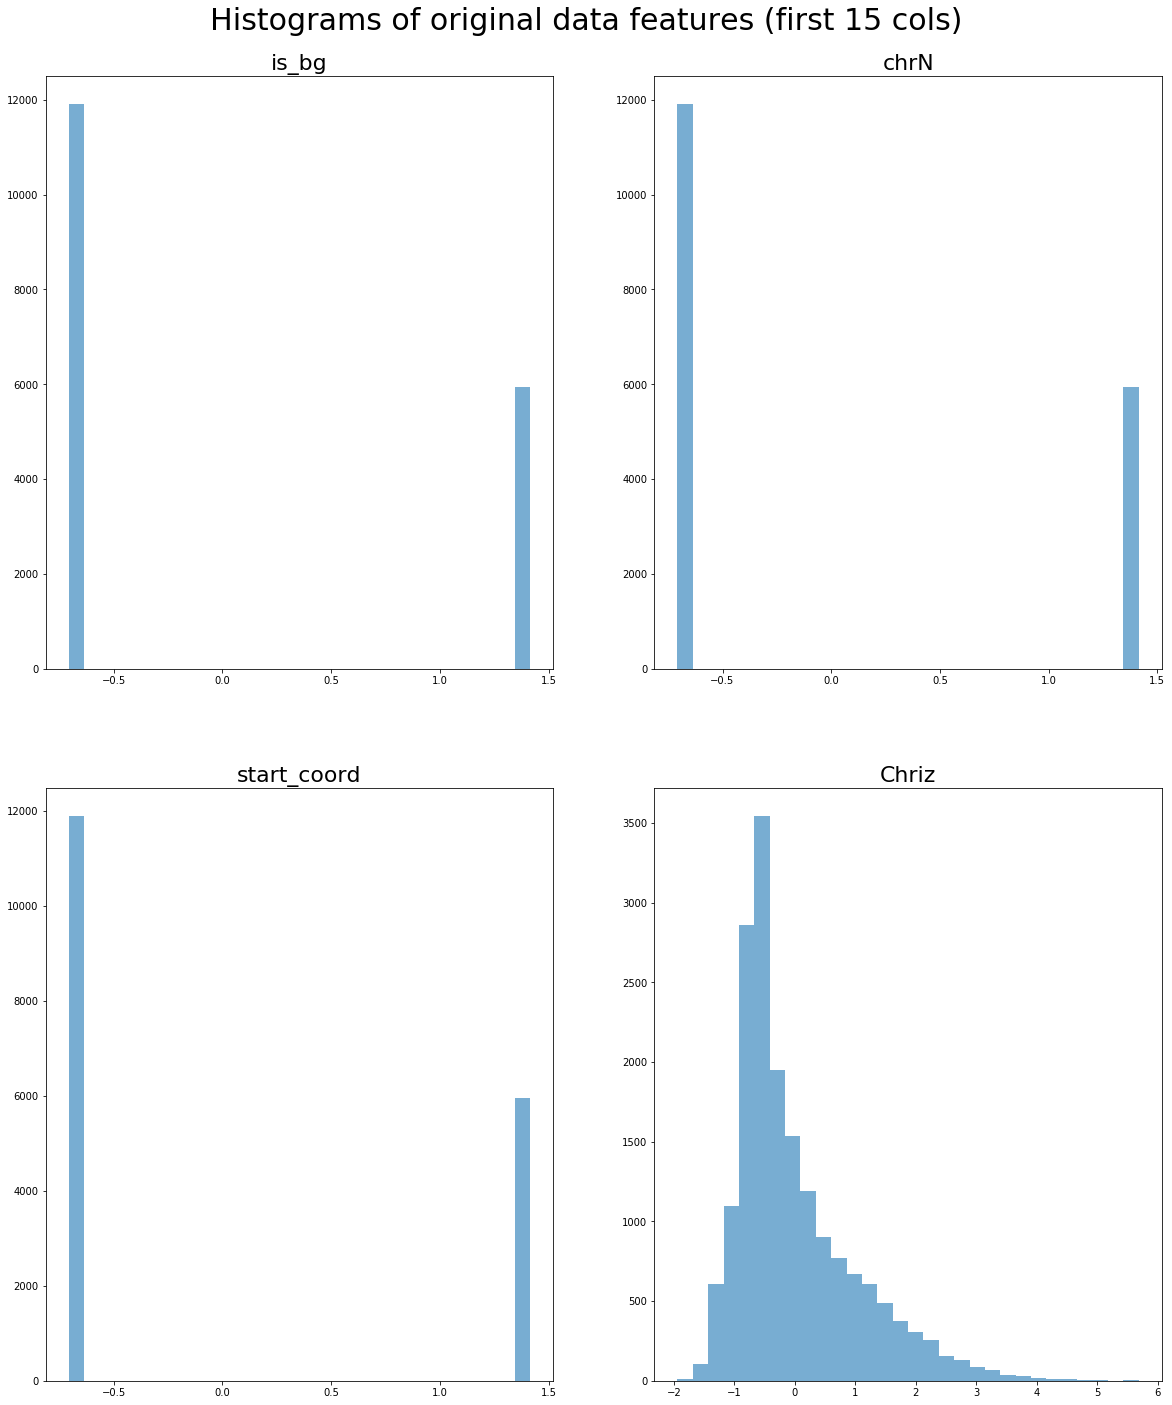

In [67]:
ncols = 2
nrows = 2
plotData(pd.DataFrame(data_scaled), ncols, nrows, bins=30, method = 'hist', is_sharex=False, plt_title='Histograms of original data features (first 15 cols)')

# target - gamma

# Explore target

In [68]:
target = gamma_S2.copy()
target.head()

is_s2  is_kc  is_bg   chrN  start_coord  gamma
0      1      0      0  chr2L            0   0.00
1      1      0      0  chr2L        20000   3.42
2      1      0      0  chr2L        40000   3.42
3      1      0      0  chr2L        60000   1.33
4      1      0      0  chr2L        80000   1.31

In [69]:
# np.unique(target.gamma)

Text(0.5, 1.0, 'gamma values for all bins')

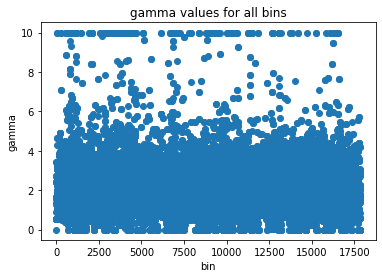

In [70]:
plt.scatter(np.arange(len(target.gamma)), target.gamma) # target
plt.xlabel('bin')
plt.ylabel('gamma')
plt.title('gamma values for all bins')

Text(0.5, 1.0, 'Distribution of gamma values for all bins')

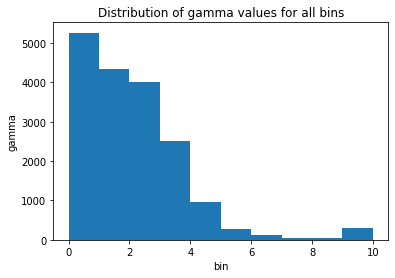

In [71]:
plt.hist(target.gamma)
plt.xlabel('bin')
plt.ylabel('gamma')
plt.title('Distribution of gamma values for all bins')

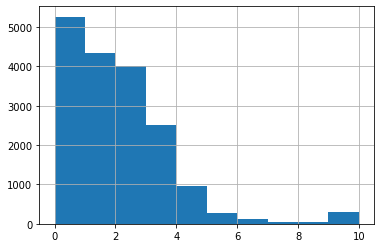

In [72]:
target.gamma.hist()

Log scale

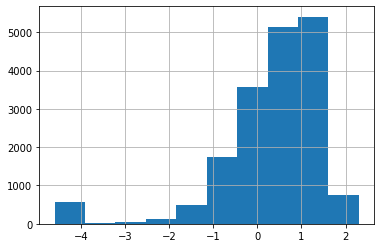

In [73]:
(np.log(0.01+target.gamma)).hist()

# Clean Data  from empty chromosomes

In [74]:
data_scaled_clean, target_clean, empty_chr_names, num_empty_bins = data_scaled, target, [], []
# cleanDataTarget(data_scaled, target)

data_scaled_clean.shape, target_clean.shape

((17850, 21), (17850, 6))

In [75]:
data_scaled_clean.head()

is_bg      chrN  start_coord     Chriz      CTCF    Su(Hw)   BEAF-32  \
0  1.414214 -0.707107    -0.707107  0.755421 -1.508001 -0.126727  0.209618   
1  1.414214 -0.707107    -0.707107  0.153151  0.151492 -1.542192 -0.114738   
2  1.414214 -0.707107    -0.707107 -0.560011  0.840358 -0.953351 -0.184648   
3  1.414214 -0.707107    -0.707107  0.344721  0.929213  0.130064  0.724996   
4  1.414214 -0.707107    -0.707107  0.266319 -0.937126 -1.481698  0.186515   

      CP190       GAF   H3K4me1  ...   H3K4me3   H3K9me2   H3K9me3   H3K27ac  \
0 -0.133627  1.166431  1.033207  ...  0.093165  0.098740  0.975874 -0.115480   
1 -0.079133 -0.564412 -0.794248  ...  0.391553  1.470283  3.187246 -1.273433   
2 -0.153375  0.923584 -0.647438  ...  0.316339 -0.077057 -0.194480 -0.858237   
3 -0.088177  3.192486  0.898212  ...  0.989820 -0.591066 -0.294798  1.596030   
4 -0.204106  0.514116  1.275701  ... -0.489929 -0.512214 -0.138873  0.827012   

   H3K27me1  H3K27me3  H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0  0.257041  0.316606 -0.037417  1.325925 -0.509654           2.108008  
1 -1.160511  1.730216 -0.627418 -0.447203 -0.910527          -0.304369  
2 -1.511445  1.677905 -0.639368 -0.690857 -0.851721          -0.038778  
3  1.126274 -1.251289 -0.357625  1.203168  0.609996           1.220388  
4  0.991603 -1.452440  0.841822  1.388128  0.319005           0.848454  

[5 rows x 21 columns]

In [76]:
target_clean.head()

is_s2  is_kc  is_bg   chrN  start_coord  gamma
0      1      0      0  chr2L            0   0.00
1      1      0      0  chr2L        20000   3.42
2      1      0      0  chr2L        40000   3.42
3      1      0      0  chr2L        60000   1.33
4      1      0      0  chr2L        80000   1.31

Target distribution

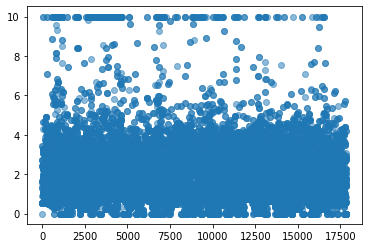

In [77]:
plt.scatter(np.arange(len(target_clean)),  target_clean.gamma, alpha=0.5)

(array([5265., 4351., 4013., 2500.,  956.,  269.,  110.,   56.,   36.,
         294.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

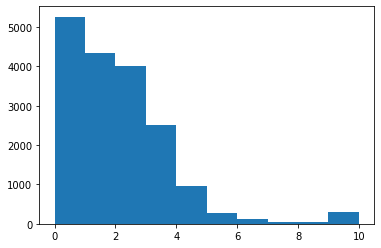

In [78]:
plt.hist(target_clean.gamma)

Log scale

(array([ 575.,    0.,   11.,   49.,   60.,  391., 1944., 4975., 8106.,
        1739.]),
 array([-6.90775528, -5.98671124, -5.06566721, -4.14462317, -3.22357913,
        -2.3025351 , -1.38149106, -0.46044702,  0.46059701,  1.38164105,
         2.30268509]),
 <a list of 10 Patch objects>)

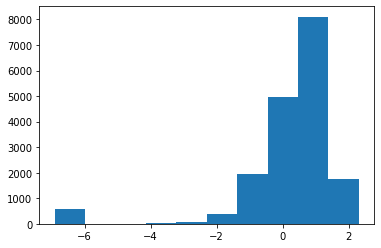

In [79]:
plt.hist(np.log(0.001 + target_clean.gamma))

In [80]:
target.shape, target.head()

((17850, 6),    is_s2  is_kc  is_bg   chrN  start_coord  gamma
 0      1      0      0  chr2L            0   0.00
 1      1      0      0  chr2L        20000   3.42
 2      1      0      0  chr2L        40000   3.42
 3      1      0      0  chr2L        60000   1.33
 4      1      0      0  chr2L        80000   1.31)

# data_scaled_clean, target_clean - prossesed data

# Train Test Split

In [81]:
data = data_scaled_clean 
target = target_clean['gamma']

In [82]:
X, y = data_scaled_clean, target_clean['gamma']
X.shape, y.shape

((17850, 21), (17850,))

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X[:], y[:], test_size=0.3, random_state=16)

X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((12495, 21), (5355, 21), (12495,), (5355,))

# Linear Regression

In [84]:
%time

# Create linear regression object
lin_reg = linear_model.LinearRegression() 

# Train the model using the training sets
lin_reg.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg.predict(X_test)

model = lin_reg

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


 TEST PREDICTION Error
weighted_mse_test: 1.0259360786590266 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0345967145868364 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5013705225184906
test sizes =  5355 5355 5355


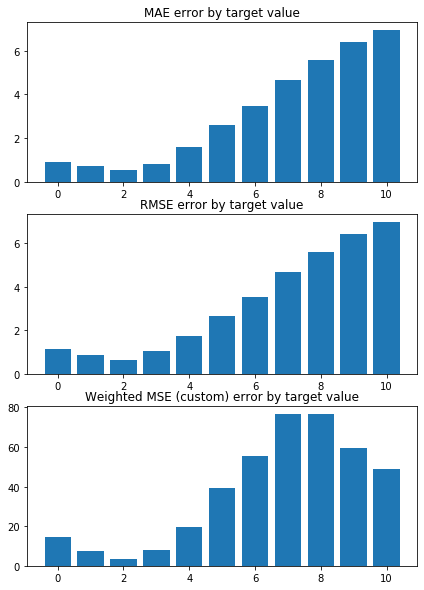

In [85]:
# Make predictions using the testing set
y_pred_train = lin_reg.predict(X_train)

weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const = cout_errors_lin(X_train,  
                                                                          X_test,
                                                                          y_train.values, 
                                                                          y_test.values, 
                                                                          model)

In [86]:
# The coefficients
print('Coefficients: \n', lin_reg.coef_[:20])

Coefficients: 
 [-1.68283641e+12 -1.68283641e+12 -1.68283641e+12 -3.16973904e-01
 -2.32360775e-02 -9.27058115e-03 -1.60459047e-01 -4.09812252e-03
 -1.69959605e-01 -2.28310200e-01  6.07243476e-02 -7.00097131e-02
  3.07096750e-02 -1.54722187e-02  2.11932325e-02 -7.92775734e-02
 -1.04493470e-01 -1.32738113e-01 -3.92483473e-01  6.15844727e-02]


In [87]:
coef = lin_reg.coef_

(array([ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 18.]),
 array([-1.68283641e+12, -1.51455277e+12, -1.34626913e+12, -1.17798548e+12,
        -1.00970184e+12, -8.41418203e+11, -6.73134563e+11, -5.04850922e+11,
        -3.36567281e+11, -1.68283641e+11,  1.33449554e-01]),
 <a list of 10 Patch objects>)

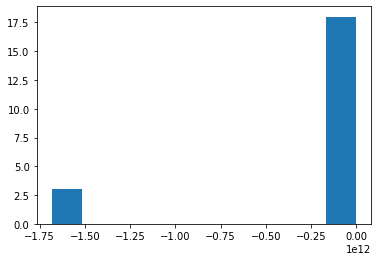

In [88]:
plt.hist(lin_reg.coef_)

Посмотрим на распределения остатков и на нормальное распределение.

(array([  2.,   1.,   0.,   2.,   5.,   2.,   5.,  12.,  16.,  18.,  34.,
         33.,  73.,  50.,  68.,  85., 109., 125., 141., 154., 187., 227.,
        217., 228., 210., 217., 239., 206., 215., 174., 180., 141., 134.,
        103.,  81.,  66.,  61.,  57.,  38.,  27.,  23.,   5.,   5.,  16.,
          1.,   2.,   2.,   0.,   1.,   2.]),
 array([-3.61611866, -3.47045975, -3.32480084, -3.17914193, -3.03348302,
        -2.88782412, -2.74216521, -2.5965063 , -2.45084739, -2.30518848,
        -2.15952957, -2.01387066, -1.86821175, -1.72255284, -1.57689393,
        -1.43123502, -1.28557611, -1.1399172 , -0.99425829, -0.84859938,
        -0.70294047, -0.55728156, -0.41162265, -0.26596374, -0.12030483,
         0.02535408,  0.17101299,  0.3166719 ,  0.46233081,  0.60798972,
         0.75364862,  0.89930753,  1.04496644,  1.19062535,  1.33628426,
         1.48194317,  1.62760208,  1.77326099,  1.9189199 ,  2.06457881,
         2.21023772,  2.35589663,  2.50155554,  2.64721445,  2.79287336,
 

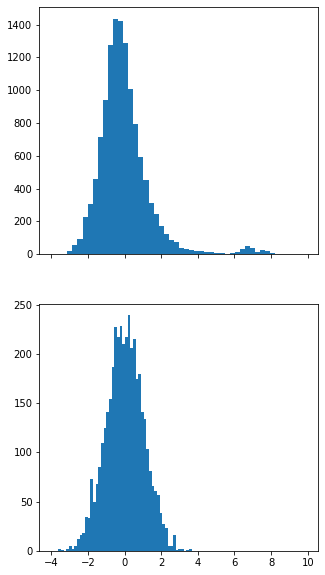

In [89]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
axes[0].hist((y_train - y_pred_train).values, bins=50)
axes[1].hist(np.random.randn(4000), bins=50)

Следовательно ошибка на train имеет нормальное распределение -> модель обучается описывать данные

Значения, на которых модель возвращает наибольшую ошибку:

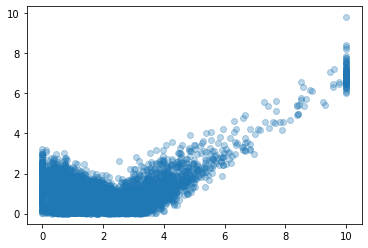

In [90]:
plt.scatter(y_test,  np.abs(y_test - y_pred) , alpha=0.3)

# Remove outlires
Посмотрим на результаты удаления объектов, для которых значение целевой переменной больше 9.

In [91]:
target_clean.head()

is_s2  is_kc  is_bg   chrN  start_coord  gamma
0      1      0      0  chr2L            0   0.00
1      1      0      0  chr2L        20000   3.42
2      1      0      0  chr2L        40000   3.42
3      1      0      0  chr2L        60000   1.33
4      1      0      0  chr2L        80000   1.31

In [92]:
target_clean

is_s2  is_kc  is_bg   chrN  start_coord  gamma
0          1      0      0  chr2L            0   0.00
1          1      0      0  chr2L        20000   3.42
2          1      0      0  chr2L        40000   3.42
3          1      0      0  chr2L        60000   1.33
4          1      0      0  chr2L        80000   1.31
5          1      0      0  chr2L       100000   0.52
6          1      0      0  chr2L       120000   0.52
7          1      0      0  chr2L       140000   1.31
8          1      0      0  chr2L       160000   2.72
9          1      0      0  chr2L       180000   2.72
10         1      0      0  chr2L       200000   2.72
11         1      0      0  chr2L       220000   1.68
12         1      0      0  chr2L       240000   1.68
13         1      0      0  chr2L       260000   0.52
14         1      0      0  chr2L       280000   0.52
15         1      0      0  chr2L       300000   1.68
16         1      0      0  chr2L       320000   2.41
17         1      0      0  chr2L       340000   2.41
18         1      0      0  chr2L       360000   2.41
19         1      0      0  chr2L       380000   2.41
20         1      0      0  chr2L       400000   1.53
21         1      0      0  chr2L       420000   0.52
22         1      0      0  chr2L       440000   0.52
23         1      0      0  chr2L       460000   0.52
24         1      0      0  chr2L       480000   0.52
25         1      0      0  chr2L       500000   0.52
26         1      0      0  chr2L       520000   0.87
27         1      0      0  chr2L       540000   1.04
28         1      0      0  chr2L       560000   1.04
29         1      0      0  chr2L       580000   1.04
...      ...    ...    ...    ...          ...    ...
17820      0      0      1   chrX     21820000   0.00
17821      0      0      1   chrX     21840000   0.00
17822      0      0      1   chrX     21860000   0.85
17823      0      0      1   chrX     21880000   3.08
17824      0      0      1   chrX     21900000   1.38
17825      0      0      1   chrX     21920000   1.38
17826      0      0      1   chrX     21940000   1.49
17827      0      0      1   chrX     21960000   1.68
17828      0      0      1   chrX     21980000   4.21
17829      0      0      1   chrX     22000000   4.21
17830      0      0      1   chrX     22020000   2.29
17831      0      0      1   chrX     22040000   1.83
17832      0      0      1   chrX     22060000   1.83
17833      0      0      1   chrX     22080000   2.77
17834      0      0      1   chrX     22100000   2.29
17835      0      0      1   chrX     22120000   2.29
17836      0      0      1   chrX     22140000   2.77
17837      0      0      1   chrX     22160000   2.77
17838      0      0      1   chrX     22180000   2.77
17839      0      0      1   chrX     22200000   1.62
17840      0      0      1   chrX     22220000   1.38
17841      0      0      1   chrX     22240000   1.38
17842      0      0      1   chrX     22260000   2.07
17843      0      0      1   chrX     22280000   2.07
17844      0      0      1   chrX     22300000   2.92
17845      0      0      1   chrX     22320000   2.92
17846      0      0      1   chrX     22340000   2.92
17847      0      0      1   chrX     22360000   1.99
17848      0      0      1   chrX     22380000   0.00
17849      0      0      1   chrX     22400000   0.00

[17850 rows x 6 columns]

In [93]:
# data_scaled_clean[target < 9].values

# target[target < 9].values

KFold(n_splits=5, random_state=3, shuffle=True)
train_index= [    0     1     2 ... 17553 17554 17555]
 TEST PREDICTION Error
weighted_mse_test: 0.9365263126886512 


 TRAIN PREDICTION Error
weighted_mse_train: 0.904250174415776 


 CONSTANT pred Error:
weighted_mse_test_const:  1.3928635628031936
test sizes =  3512 3512 3512


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


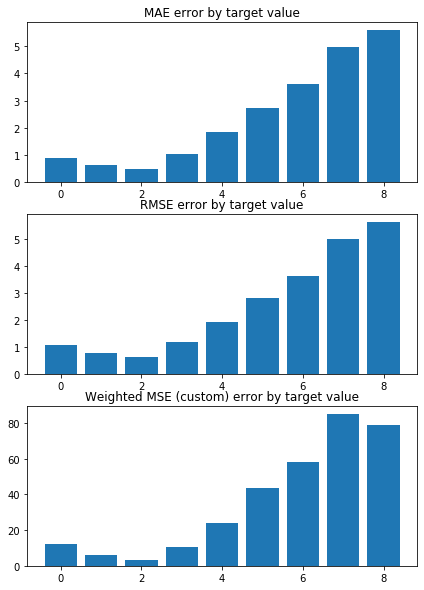

train_index= [    2     3     4 ... 17553 17554 17555]
 TEST PREDICTION Error
weighted_mse_test: 0.9361894625875998 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9062368490185324 


 CONSTANT pred Error:
weighted_mse_test_const:  1.3946819931814114
test sizes =  3511 3511 3511


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


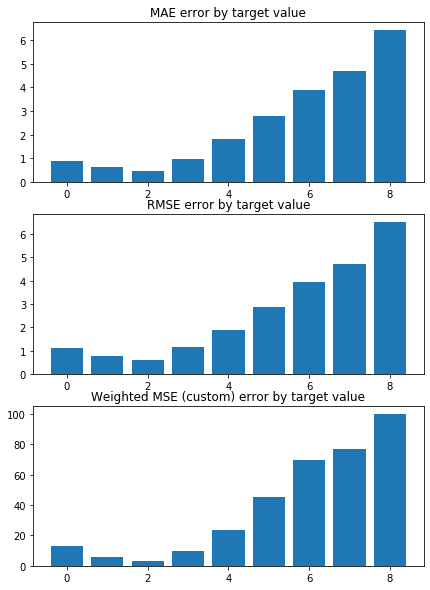

train_index= [    0     1     2 ... 17552 17554 17555]
 TEST PREDICTION Error
weighted_mse_test: 0.9013085582836268 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9176367192261915 


 CONSTANT pred Error:
weighted_mse_test_const:  1.33310880214971
test sizes =  3511 3511 3511


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


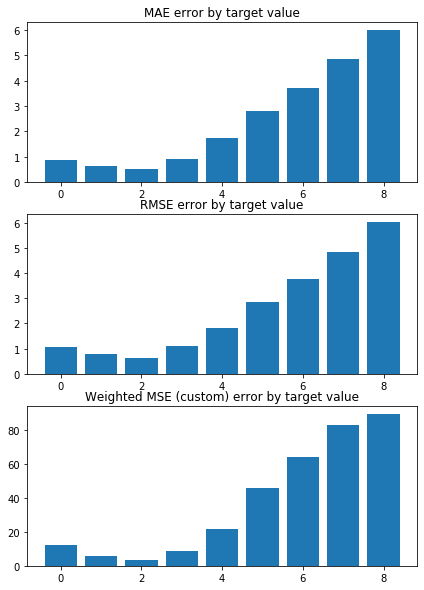

train_index= [    0     1     3 ... 17553 17554 17555]
 TEST PREDICTION Error
weighted_mse_test: 0.9165128496828596 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9123365666049104 


 CONSTANT pred Error:
weighted_mse_test_const:  1.3858310411685706
test sizes =  3511 3511 3511


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


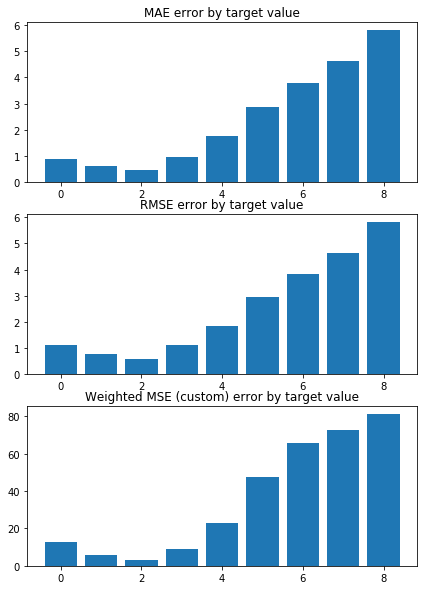

train_index= [    0     1     2 ... 17549 17550 17553]
 TEST PREDICTION Error
weighted_mse_test: 0.8852221786030499 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9214429654408266 


 CONSTANT pred Error:
weighted_mse_test_const:  1.3480882167658808
test sizes =  3511 3511 3511


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


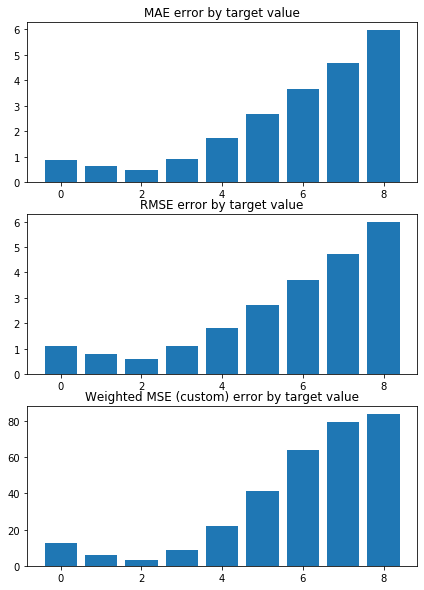

Weighted Mean squared error on Train: 0.91 
 MSE mean train: 1.3193532064756117 

Mean squared error on Test: 0.92 
 MSE mean test:  1.3232966647091822 

Root of MSE on Test: 0.96 
 1.1503463238126082 

Variance score on Test: 0.02 
 r2_test: 0.32326115415876794 

wMSE_train 0.91
wMSE_test 0.92
MSE_train 1.32
MSE_test 1.32
MAE_train 0.86
MAE_test 0.84
r2_test 0.32
    start_coord          chrN         is_bg     Chriz  H3K36me3   H3K4me1  \
0 -7.305561e+09 -7.305561e+09 -7.305561e+09 -0.340205 -0.311781 -0.196987   
1  1.433856e+09  1.433856e+09  1.433856e+09 -0.332118 -0.309146 -0.173844   
2 -3.108473e+09 -3.108473e+09 -3.108473e+09 -0.355702 -0.314376 -0.212975   
3  4.119608e+09  4.119608e+09  4.119608e+09 -0.310552 -0.329300 -0.227820   
4  1.684609e+09  1.684609e+09  1.684609e+09 -0.347777 -0.309437 -0.213928   

    BEAF-32       GAF   H3K4me2  H3K36me1  ...  H3K27me1   H3K9me2   H3K9me3  \
0 -0.131379 -0.121608  0.100863 -0.099424  ... -0.047703  0.044001 -0.043862   
1 -0.11954

In [94]:
X, y = data_scaled_clean[target < 9].values, target[target < 9].values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.LinearRegression() 
model_name = 'LR+L1_no_outliers'


lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=5, random_state=3, shuffle=True)


In [95]:
results_pd 

model_name  wMSE_test_mean  wMSE_test_std  wMSE_train_mean  \
0  LR+L1_no_outliers        0.915152       0.019944         0.912381   

   wMSE_train_std comments                  params  MSE_test_mean  \
0        0.006536        -  test_params = testtest       1.323297   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0      0.039524        1.319353       0.009883   

                                             r2_test n_splits  \
0  [0.32111774912476376, 0.31698748091029916, 0.3...        5   

                                               model  
0  LinearRegression(copy_X=True, fit_intercept=Tr...

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# K-fold cross Validation - RL

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0438181782673885 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0321676009820264 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5084857885756024
test sizes =  1785 1785 1785


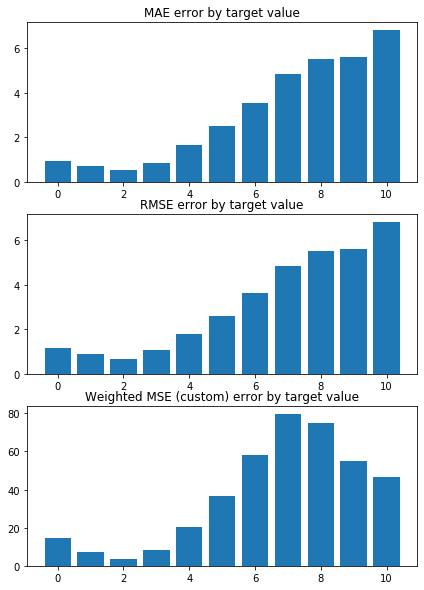

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0245825563552902 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0374071504149316 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


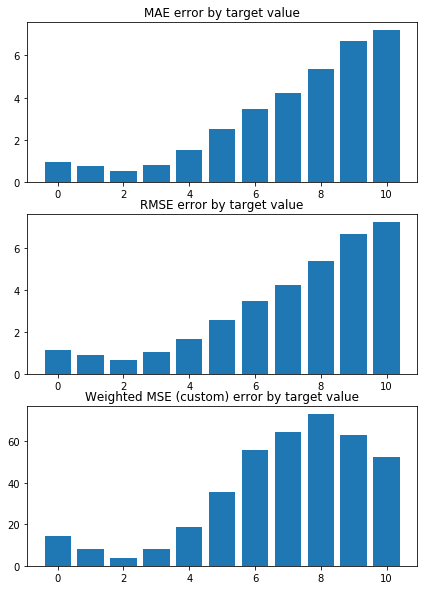

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0166576239895724 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0371343383906246 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


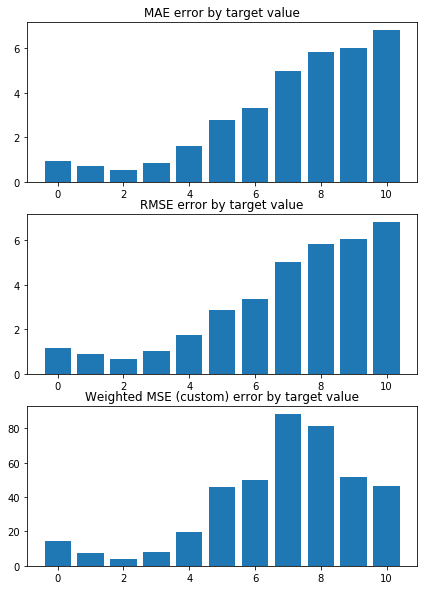

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9692930623337067 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0474088713415397 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


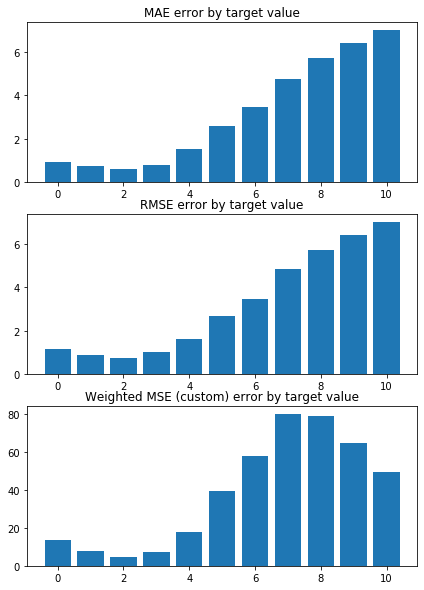

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0467383694619683 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0339459679901863 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


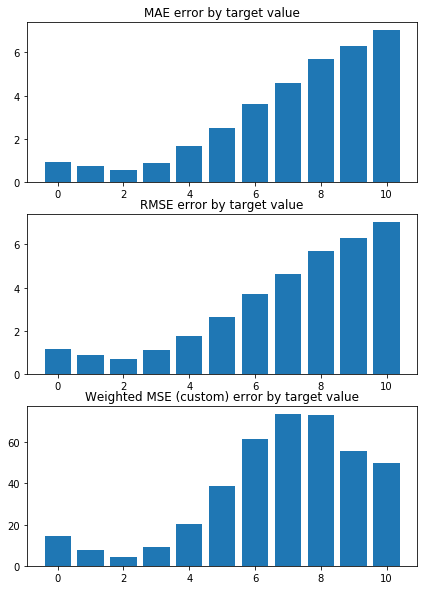

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1076669886773678 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0291454649028047 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


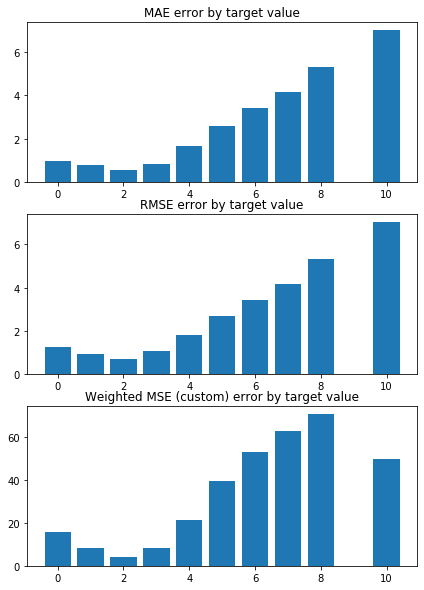

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0915830886038285 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0303960213863428 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


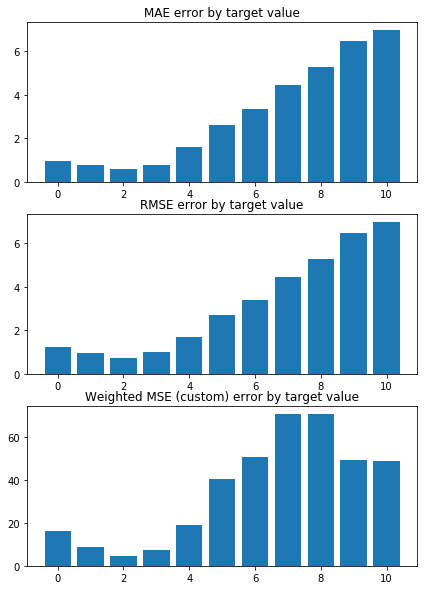

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0680417340904054 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0309658816662268 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


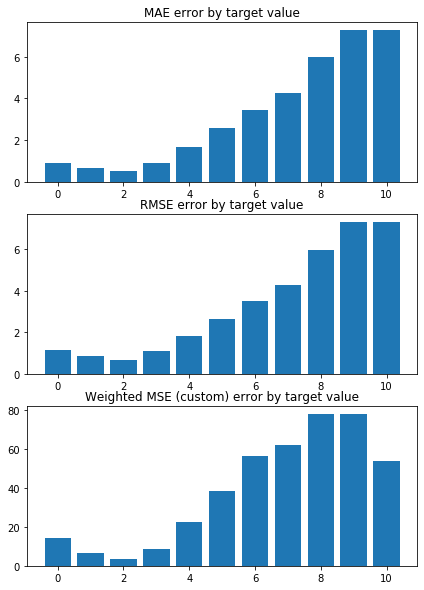

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.9801140516699653 


 TRAIN PREDICTION Error
weighted_mse_train: 1.04114529707682 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


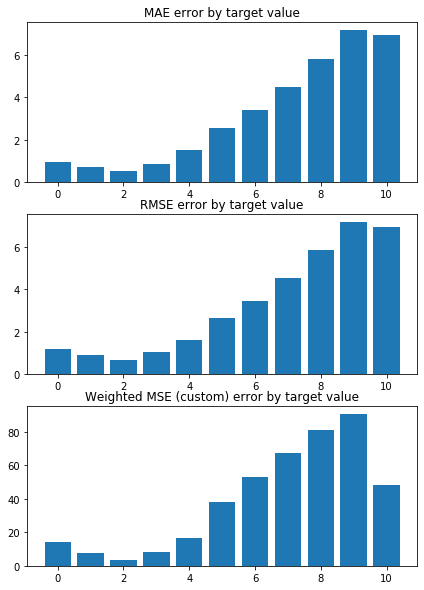

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.033913655159871 


 TRAIN PREDICTION Error
weighted_mse_train: 1.03637574267555 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


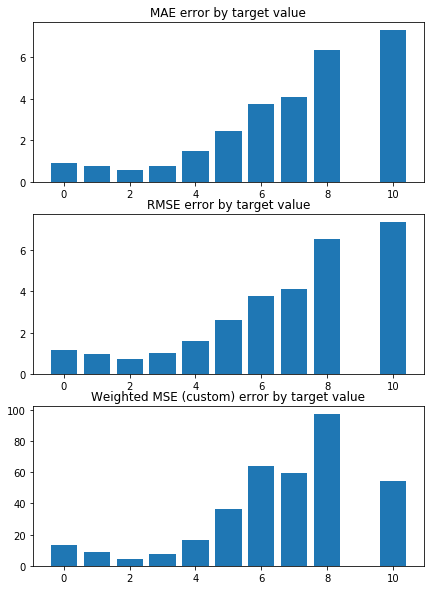

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.147985224218238 

Mean squared error on Test: 1.04 
 MSE mean test:  2.152856783826949 

Root of MSE on Test: 1.02 
 1.4672616616769312 

Variance score on Test: 0.04 
 r2_test: 0.2725664691193821 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.15
MSE_test 2.15
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
          is_bg          chrN   start_coord  H3K36me3     Chriz   H3K4me1  \
0  3.215212e+09  3.215212e+09  3.215212e+09 -0.380469 -0.325661 -0.237559   
1  8.755898e+09  8.755898e+09  8.755898e+09 -0.388094 -0.327093 -0.250427   
2  3.280767e+09  3.280767e+09  3.280767e+09 -0.384774 -0.329693 -0.246946   
3 -5.536658e+09 -5.536658e+09 -5.536658e+09 -0.380371 -0.343528 -0.254160   
4 -4.644017e+09 -4.644017e+09 -4.644017e+09 -0.379114 -0.332625 -0.256548   
5 -3.185525e+09 -3.185525e+09 -3.185525e+09 -0.375486 -0.331523 -0.256608   
6  6.876503e+08  6.876503e+08  6.876503e+08 -0.374350 -0.333865 -0.258751   
7  2.866187e+09  2.8

model_name  wMSE_test_mean  wMSE_test_std  wMSE_train_mean  \
0  LR+L1_no_outliers        0.915152       0.019944         0.912381   
1                 LR        1.038241       0.041786         1.035609   

   wMSE_train_std comments                  params  MSE_test_mean  \
0        0.006536        -  test_params = testtest       1.323297   
1        0.005302        -  test_params = testtest       2.152857   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0      0.039524        1.319353       0.009883   
1      0.153323        2.147985       0.017038   

                                             r2_test n_splits  \
0  [0.32111774912476376, 0.31698748091029916, 0.3...        5   
1  [0.29507279966080857, 0.2755899643705616, 0.28...       10   

                                               model  
0  LinearRegression(copy_X=True, fit_intercept=Tr...  
1  LinearRegression(copy_X=True, fit_intercept=Tr...

In [96]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.LinearRegression() 

model_name = 'LR'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)
results_pd

In [97]:
results_pd

model_name  wMSE_test_mean  wMSE_test_std  wMSE_train_mean  \
0  LR+L1_no_outliers        0.915152       0.019944         0.912381   
1                 LR        1.038241       0.041786         1.035609   

   wMSE_train_std comments                  params  MSE_test_mean  \
0        0.006536        -  test_params = testtest       1.323297   
1        0.005302        -  test_params = testtest       2.152857   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0      0.039524        1.319353       0.009883   
1      0.153323        2.147985       0.017038   

                                             r2_test n_splits  \
0  [0.32111774912476376, 0.31698748091029916, 0.3...        5   
1  [0.29507279966080857, 0.2755899643705616, 0.28...       10   

                                               model  
0  LinearRegression(copy_X=True, fit_intercept=Tr...  
1  LinearRegression(copy_X=True, fit_intercept=Tr...

In [98]:
coefs_argsort, coefs

(array([[ 0,  1,  2, 18,  3,  9,  8,  6, 17, 20, 16, 11, 15, 10, 19,  4,
         14, 12, 13,  5,  7],
        [ 0,  1,  2, 18,  3,  9,  8,  6, 20, 17, 16, 19, 15, 11, 10,  4,
         13, 12,  5,  7, 14],
        [ 0,  1,  2, 18,  3,  9,  8,  6, 17, 20, 16, 19, 10, 15, 11,  4,
         14, 13, 12,  7,  5],
        [ 2,  1,  0, 18,  3,  9,  8,  6, 20, 17, 16, 11, 19, 15, 10,  4,
         13, 14, 12,  5,  7],
        [ 2,  1,  0, 18,  3,  9,  8,  6, 17, 20, 10, 16, 19, 11, 15,  4,
         14, 12,  5,  7, 13],
        [ 2,  1,  0, 18,  3,  9,  8,  6, 20, 17, 19, 16, 15, 11, 10, 13,
         12,  4, 14,  7,  5],
        [ 0,  1,  2, 18,  3,  9,  8,  6, 20, 17, 10, 11, 16, 19, 15,  4,
         14,  5, 12,  7, 13],
        [ 0,  1,  2, 18,  3,  9,  8, 17,  6, 20, 16, 15, 19, 11, 10,  4,
         14, 13, 12,  7,  5],
        [ 0,  1,  2, 18,  3,  9,  8,  6, 17, 20, 16, 19, 11, 15, 10,  4,
         14,  5, 13, 12,  7],
        [ 2,  1,  0, 18,  3,  9,  8,  6, 20, 17, 16, 11, 10, 19, 15,  4,


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

(array([  1.,   0.,   2.,   0.,   3.,   2.,   8.,  12.,  16.,   8.,  27.,
         46.,  41.,  58.,  67.,  83.,  98., 123., 128., 141., 169., 159.,
        175., 219., 230., 209., 189., 204., 204., 191., 159., 159., 138.,
        114., 117., 109.,  82.,  71.,  49.,  44.,  33.,  35.,  18.,  22.,
         17.,   6.,   6.,   4.,   2.,   2.]),
 array([-3.43729559, -3.30583482, -3.17437404, -3.04291327, -2.9114525 ,
        -2.77999173, -2.64853096, -2.51707019, -2.38560941, -2.25414864,
        -2.12268787, -1.9912271 , -1.85976633, -1.72830556, -1.59684478,
        -1.46538401, -1.33392324, -1.20246247, -1.0710017 , -0.93954092,
        -0.80808015, -0.67661938, -0.54515861, -0.41369784, -0.28223707,
        -0.15077629, -0.01931552,  0.11214525,  0.24360602,  0.37506679,
         0.50652756,  0.63798834,  0.76944911,  0.90090988,  1.03237065,
         1.16383142,  1.2952922 ,  1.42675297,  1.55821374,  1.68967451,
         1.82113528,  1.95259605,  2.08405683,  2.2155176 ,  2.34697837,
 

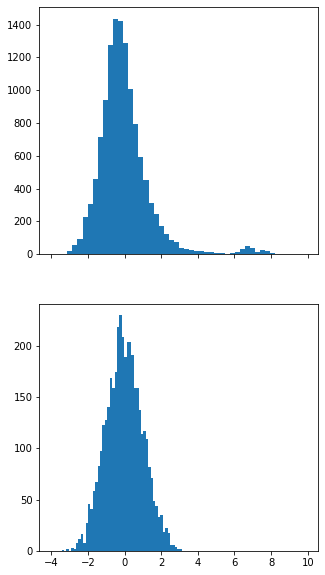

In [99]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
axes[0].hist((y_train - y_pred_train), bins=50)
axes[1].hist(np.random.randn(4000), bins=50)

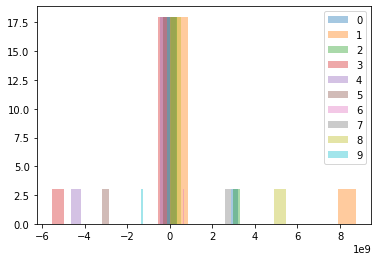

In [100]:
for i, coef_i in enumerate(coefs):
    plt.hist(coef_i, label=str(i), alpha=0.4, bins=10)
plt.legend()

(array([18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]),
 array([-3.80468886e-01,  3.21521242e+08,  6.43042485e+08,  9.64563727e+08,
         1.28608497e+09,  1.60760621e+09,  1.92912745e+09,  2.25064870e+09,
         2.57216994e+09,  2.89369118e+09,  3.21521242e+09]),
 <a list of 10 Patch objects>)

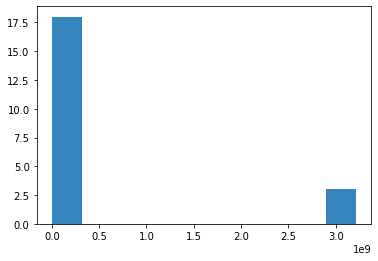

In [101]:
plt.hist(coefs[0], label=str(i), alpha=0.9, bins=10)

### Отсортированные номера выделенных признаков обычной линейной модели

In [102]:
su_drsc.columns

Index(['is_s2', 'is_kc', 'is_bg', 'chrN', 'start_coord', 'Chriz', 'CTCF',
       'Su(Hw)', 'BEAF-32', 'CP190', 'GAF', 'H3K4me1', 'H3K4me2', 'H3K4me3',
       'H3K9me2', 'H3K9me3', 'H3K27ac', 'H3K27me1', 'H3K27me3', 'H3K36me1',
       'H3K36me3', 'H4K16ac', 'RNA-polymerase-II'],
      dtype='object')

In [103]:
su_drsc.columns[2:][coefs_argsort[0]]

Index(['is_bg', 'chrN', 'start_coord', 'H3K36me3', 'Chriz', 'H3K4me1', 'GAF',
       'BEAF-32', 'H3K36me1', 'RNA-polymerase-II', 'H3K27me3', 'H3K4me3',
       'H3K27me1', 'H3K4me2', 'H4K16ac', 'CTCF', 'H3K27ac', 'H3K9me2',
       'H3K9me3', 'Su(Hw)', 'CP190'],
      dtype='object')

In [104]:
coefs_argsort

array([[ 0,  1,  2, 18,  3,  9,  8,  6, 17, 20, 16, 11, 15, 10, 19,  4,
        14, 12, 13,  5,  7],
       [ 0,  1,  2, 18,  3,  9,  8,  6, 20, 17, 16, 19, 15, 11, 10,  4,
        13, 12,  5,  7, 14],
       [ 0,  1,  2, 18,  3,  9,  8,  6, 17, 20, 16, 19, 10, 15, 11,  4,
        14, 13, 12,  7,  5],
       [ 2,  1,  0, 18,  3,  9,  8,  6, 20, 17, 16, 11, 19, 15, 10,  4,
        13, 14, 12,  5,  7],
       [ 2,  1,  0, 18,  3,  9,  8,  6, 17, 20, 10, 16, 19, 11, 15,  4,
        14, 12,  5,  7, 13],
       [ 2,  1,  0, 18,  3,  9,  8,  6, 20, 17, 19, 16, 15, 11, 10, 13,
        12,  4, 14,  7,  5],
       [ 0,  1,  2, 18,  3,  9,  8,  6, 20, 17, 10, 11, 16, 19, 15,  4,
        14,  5, 12,  7, 13],
       [ 0,  1,  2, 18,  3,  9,  8, 17,  6, 20, 16, 15, 19, 11, 10,  4,
        14, 13, 12,  7,  5],
       [ 0,  1,  2, 18,  3,  9,  8,  6, 17, 20, 16, 19, 11, 15, 10,  4,
        14,  5, 13, 12,  7],
       [ 2,  1,  0, 18,  3,  9,  8,  6, 20, 17, 16, 11, 10, 19, 15,  4,
        13, 12,  5,

In [105]:
pd.DataFrame(coefs_argsort, columns=su_drsc.columns[2:][coefs_argsort[0]])

is_bg  chrN  start_coord  H3K36me3  Chriz  H3K4me1  GAF  BEAF-32  H3K36me1  \
0      0     1            2        18      3        9    8        6        17   
1      0     1            2        18      3        9    8        6        20   
2      0     1            2        18      3        9    8        6        17   
3      2     1            0        18      3        9    8        6        20   
4      2     1            0        18      3        9    8        6        17   
5      2     1            0        18      3        9    8        6        20   
6      0     1            2        18      3        9    8        6        20   
7      0     1            2        18      3        9    8       17         6   
8      0     1            2        18      3        9    8        6        17   
9      2     1            0        18      3        9    8        6        20   

   RNA-polymerase-II  ...  H3K4me3  H3K27me1  H3K4me2  H4K16ac  CTCF  H3K27ac  \
0                 20  ...       11        15       10       19     4       14   
1                 17  ...       19        15       11       10     4       13   
2                 20  ...       19        10       15       11     4       14   
3                 17  ...       11        19       15       10     4       13   
4                 20  ...       16        19       11       15     4       14   
5                 17  ...       16        15       11       10    13       12   
6                 17  ...       11        16       19       15     4       14   
7                 20  ...       15        19       11       10     4       14   
8                 20  ...       19        11       15       10     4       14   
9                 17  ...       11        10       19       15     4       13   

   H3K9me2  H3K9me3  Su(Hw)  CP190  
0       12       13       5      7  
1       12        5       7     14  
2       13       12       7      5  
3       14       12       5      7  
4       12        5       7     13  
5        4       14       7      5  
6        5       12       7     13  
7       13       12       7      5  
8        5       13      12      7  
9       12        5      14      7  

[10 rows x 21 columns]

# !! одинаковая приоритизация 

In [106]:
def getConfIdxFrequencies(coefs_argsort, row_lim, min_lim = 5, max_lim = 5):
    ''' 
    Get Frequencies of feature indexes in the sorted array of indexes bu the coefficient of the feature in different itterstions.
    The smallest and the biggest elements are valueable - as they give the biggest impact.
    min_lim, max_lim - limitations of the number of smallest and biggest coefficients to consider for the frequency.
    '''
    merged_coefs = np.concatenate(np.hstack([coefs_argsort[:row_lim,:min_lim], coefs_argsort[:row_lim,-max_lim:]]))

    merged_coefs = list(merged_coefs)

    featur_freq_dict =  dict((i, merged_coefs.count(i)) for i in merged_coefs)
    for key, value in  sorted(featur_freq_dict.items(), key=lambda item: (-item[1], item[0])):
        print("{}: {}".format(key, value))
        
    return featur_freq_dict

In [107]:
featur_freq_dict = getConfIdxFrequencies(coefs_argsort, row_lim=len(coefs_argsort), min_lim = 3, max_lim = 3)

0: 10
1: 10
2: 10
7: 10
5: 8
12: 5
13: 4
14: 3


## Explore fold with big error

train_index= [    0     1     2 ... 17847 17848 17849]
train_index= [    0     1     3 ... 17847 17848 17849]
train_index= [    1     2     3 ... 17847 17848 17849]
train_index= [    0     1     2 ... 17847 17848 17849]
train_index= [    0     1     2 ... 17847 17848 17849]
train_index= [    0     1     2 ... 17847 17848 17849]
train_index= [    0     1     2 ... 17846 17847 17849]
train_index= [    0     2     3 ... 17847 17848 17849]
train_index= [    0     1     2 ... 17843 17847 17848]
train_index= [    0     1     2 ... 17846 17848 17849]


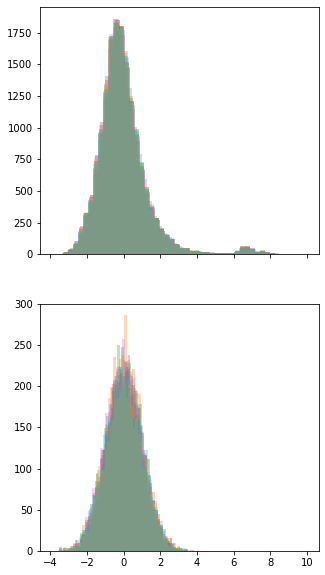

In [108]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)

for train_index, test_index in kf.split(X):

    print('train_index=', train_index)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

     # Train the model using the training sets
    model.fit(X_train, y_train)

    # Make predictions using the train set
    y_pred_train = model.predict(X_train)

    # Make predictions using the testing set
    y_pred = model.predict(X_test)

    axes[0].hist(y_train - y_pred_train, bins=50, alpha=0.3)
    axes[1].hist(np.random.randn(4000), bins=50, alpha=0.3)

# ================================================================

# Linear Regression with L1 regularization -  LASSO

$$ (1 / (2  n\_{samples}))  ||y - Xw||^2_2 + \alpha * ||w||_1 $$


In [109]:
X, y = data_scaled_clean, target_clean.gamma
X_train, X_test, y_train, y_test = train_test_split(X[:], y[:], test_size=0.3, random_state=10)

In [110]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 
# Create linear regression object
lin_reg_l1 = linear_model.Lasso()

# Train the model using the training sets
lin_reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg_l1.predict(X_test)

Коэффициенты

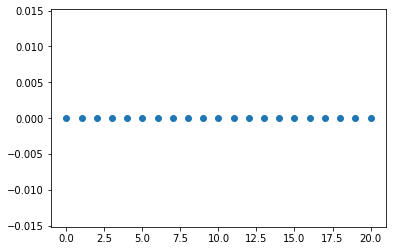

In [111]:
# plt.plot(lin_reg_l1.coef_)
plt.scatter( np.arange(len(lin_reg_l1.coef_)) , lin_reg_l1.coef_)


plt.show()

In [112]:
su_drsc.columns[2:][lin_reg_l1.coef_ < 0]

Index([], dtype='object')

In [113]:
lin_reg_l1.coef_

array([ 0.,  0., -0., -0., -0.,  0., -0., -0., -0., -0., -0., -0.,  0.,
       -0., -0., -0.,  0., -0., -0., -0., -0.])

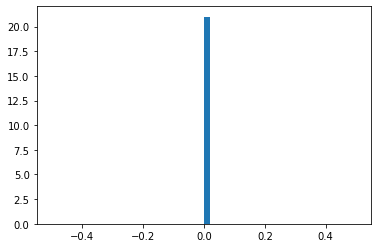

In [114]:
plt.hist(lin_reg_l1.coef_, bins=50)
plt.show()

In [115]:
# f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
# axes[0].hist((y_train - y_pred_train), bins=50)
# axes[1].hist(np.random.randn(4000), bins=50)

### Cross validation
without outliers

In [116]:
# X, y = data_scaled_clean[target < 9].values, target[target < 9].values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# # Create linear regression with L2 regularization object
# model_l1 = linear_model.Lasso(0.2)

# model_name = 'LR+L1_t<.9'

# lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
#                 weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
#                 rmse_test, rmse_train, rmse_test_const, \
#                 mae_test,    mae_train,  mae_test_const, \
#                 results_pd = train_test_KFold(X, y, 
#                                               model, model_name, results_pd,
#                                               n_splits=5, random_state=3, shuffle=True)
# results_pd

In [117]:
# np.mean(weighted_mse_test_all)

In [118]:
# for coef_i in coefs_l1:
#     plt.hist(coef_i, alpha=0.5)
# plt.hist(coefs_l1[0], alpha=0.5)

In [119]:
# np.sort(coefs_l1)

In [120]:
# lin_reg_l1.predict(X_test)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# K-fold cross Validation - RL + L 1 

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5084857885756024 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4986539723313137 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5084857885756024
test sizes =  1785 1785 1785


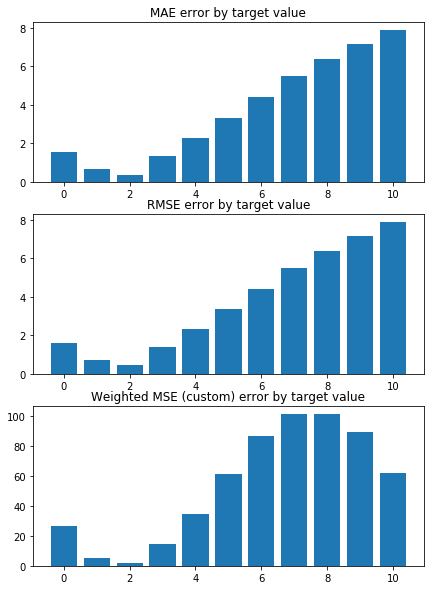

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5223866913238566 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5000452670038045 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


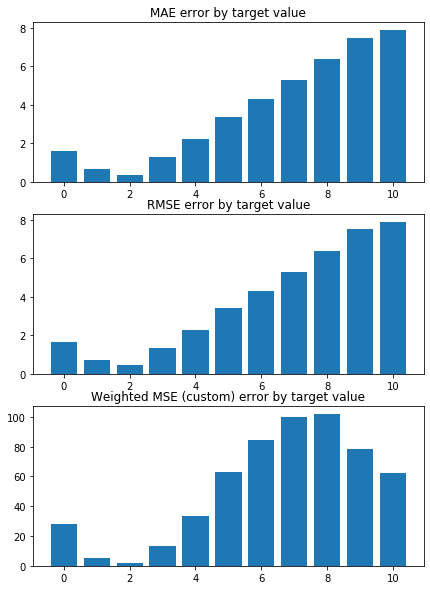

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4829104249189313 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5054458089959184 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


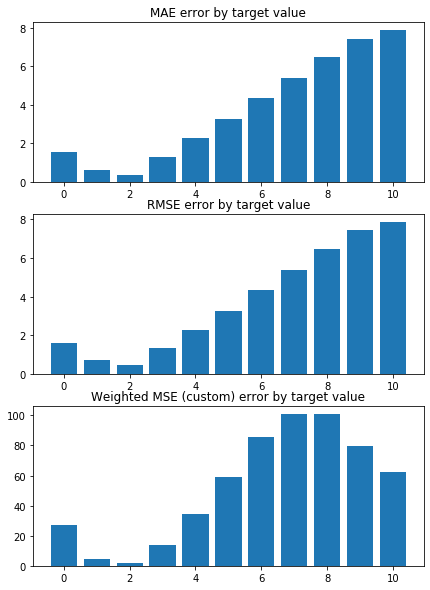

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4244925388995253 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5157153565133847 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


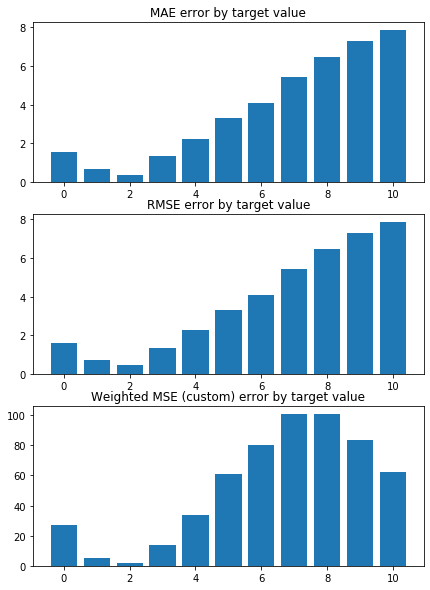

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.492735903069663 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5045636879865436 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


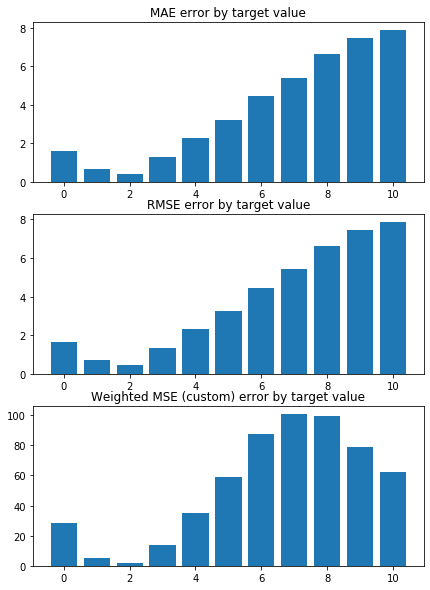

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5334384341949743 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5021296506382618 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


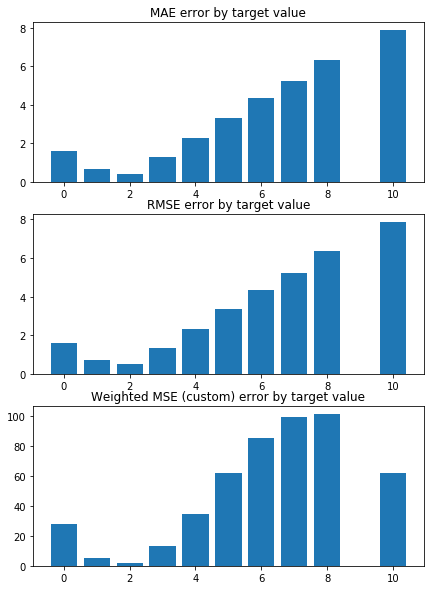

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5139765180356128 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5023200753947654 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


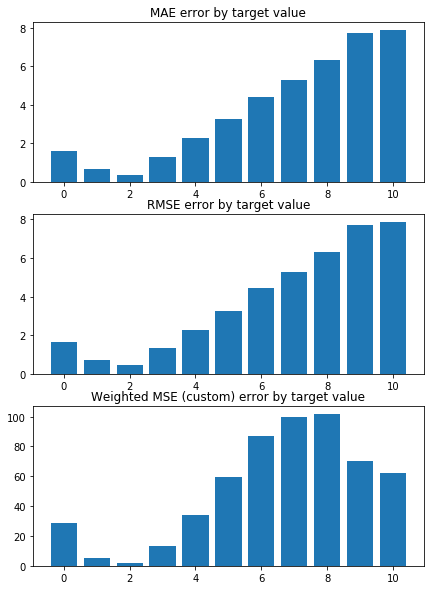

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5657406847615234 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4930764070047973 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


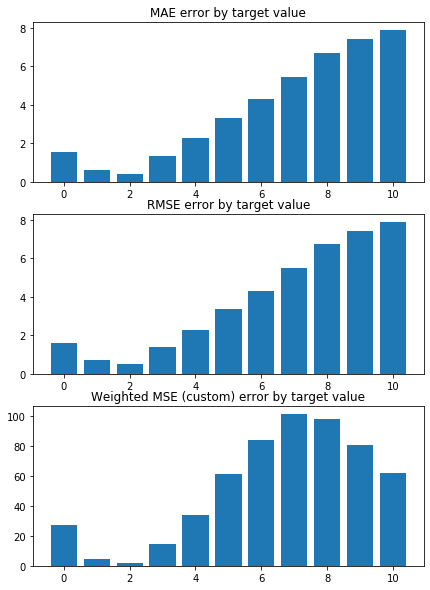

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.46550533906606 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5050318879760942 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


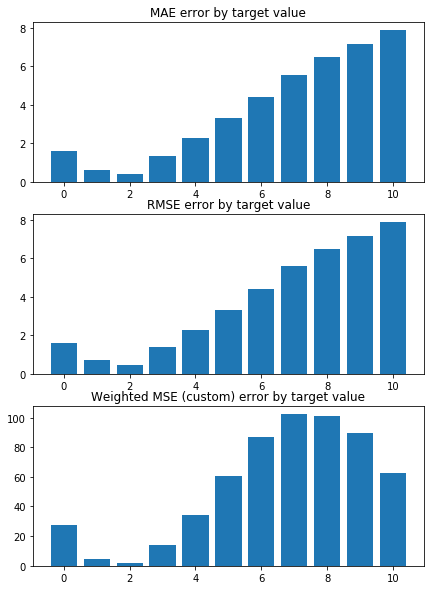

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5204784209799074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5014976051400921 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


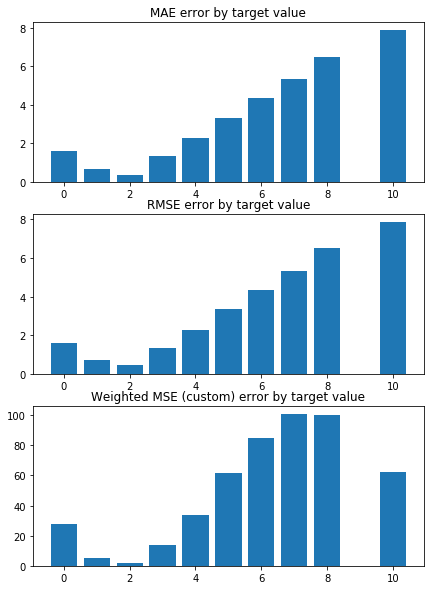

Weighted Mean squared error on Train: 1.50 
 MSE mean train: 2.958612123656919 

Mean squared error on Test: 1.50 
 MSE mean test:  2.9588950737074304 

Root of MSE on Test: 1.23 
 1.7201439107549783 

Variance score on Test: 0.04 
 r2_test: -0.000502398722420172 

wMSE_train 1.5
wMSE_test 1.5
MSE_train 2.96
MSE_test 2.96
MAE_train 1.26
MAE_test 1.29
r2_test -0.0
   is_bg  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
1    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
2    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
3    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
4    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
5    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
6    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
7 

model_name  wMSE_test_mean  wMSE_test_std  wMSE_train_mean  \
0  LR+L1_no_outliers        0.915152       0.019944         0.912381   
1                 LR        1.038241       0.041786         1.035609   
2              LR+L1        1.503015       0.037112         1.502848   

   wMSE_train_std comments                  params  MSE_test_mean  \
0        0.006536        -  test_params = testtest       1.323297   
1        0.005302        -  test_params = testtest       2.152857   
2        0.005510        -  test_params = testtest       2.958895   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0      0.039524        1.319353       0.009883   
1      0.153323        2.147985       0.017038   
2      0.165080        2.958612       0.018354   

                                             r2_test n_splits  \
0  [0.32111774912476376, 0.31698748091029916, 0.3...        5   
1  [0.29507279966080857, 0.2755899643705616, 0.28...       10   
2  [-0.001250621628477555, -3.83457383368313e-05,...       10   

                                               model  
0  LinearRegression(copy_X=True, fit_intercept=Tr...  
1  LinearRegression(copy_X=True, fit_intercept=Tr...  
2  Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...

In [121]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.Lasso()

model_name = 'LR+L1'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)
results_pd

# Fined parametrs for lasso L1

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [    0     1     2 ... 17847 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17343.963285234517, tolerance: 4.761018983228135
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.0437097325063787 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0320274617495415 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5084857885756024
test sizes =  1785 1785 1785


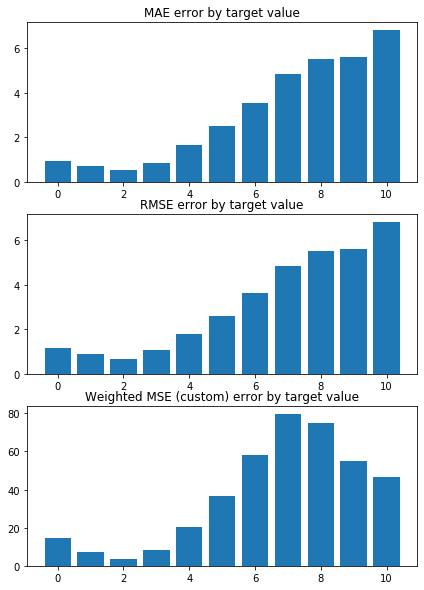

train_index= [    0     1     3 ... 17847 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17251.1151947998, tolerance: 4.749698079840649
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.024221798877296 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0370231154874336 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


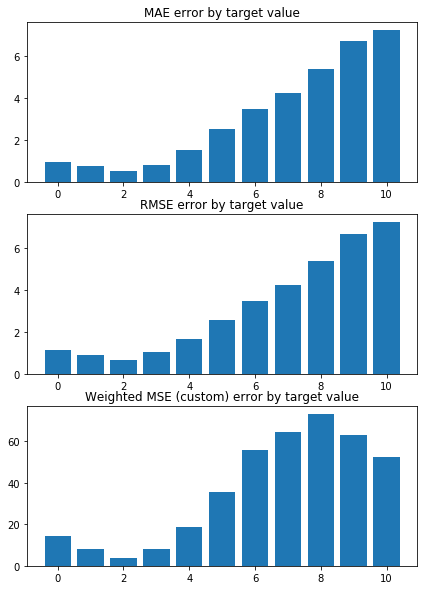

train_index= [    1     2     3 ... 17847 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17261.571509771482, tolerance: 4.743536101080611
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.0165041246737805 


 TRAIN PREDICTION Error
weighted_mse_train: 1.036992985686316 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


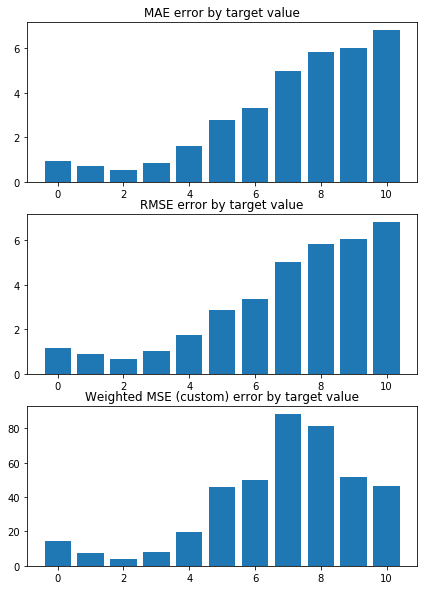

train_index= [    0     1     2 ... 17847 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17549.002294879214, tolerance: 4.82725716737006
  positive)


 TEST PREDICTION Error
weighted_mse_test: 0.9695495949794637 


 TRAIN PREDICTION Error
weighted_mse_train: 1.047645683953828 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


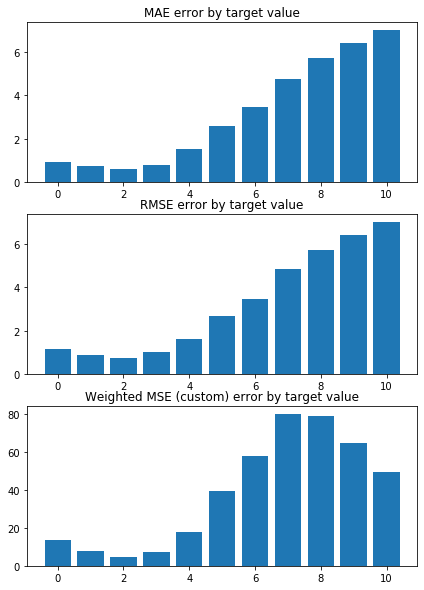

train_index= [    0     1     2 ... 17847 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17181.802074120867, tolerance: 4.739731556616248
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.0469371225008475 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0341434282577262 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


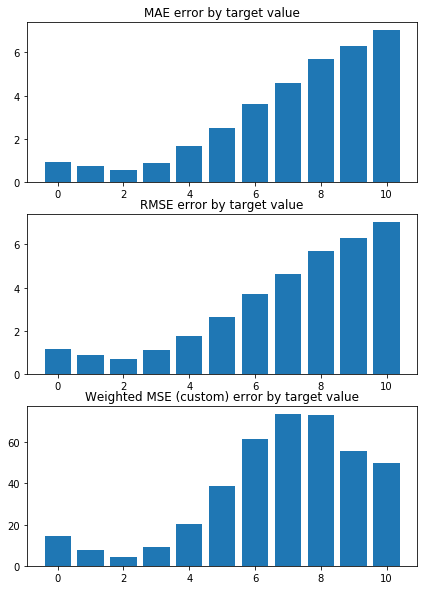

train_index= [    0     1     2 ... 17847 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17208.470311860438, tolerance: 4.751966749714286
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.107819319353757 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0292798397911658 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


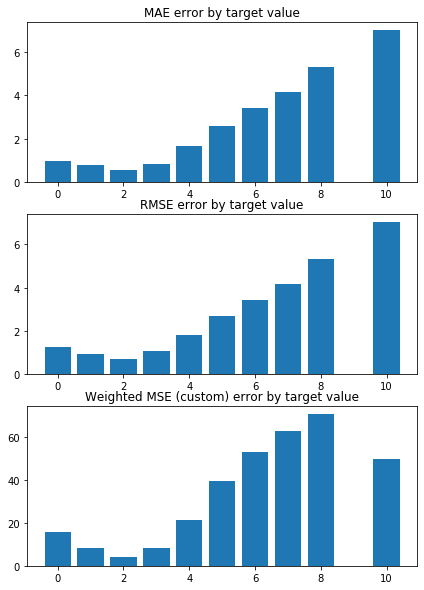

train_index= [    0     1     2 ... 17846 17847 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17253.398860031244, tolerance: 4.75829948389916
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.0915519261875652 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0303663364147677 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


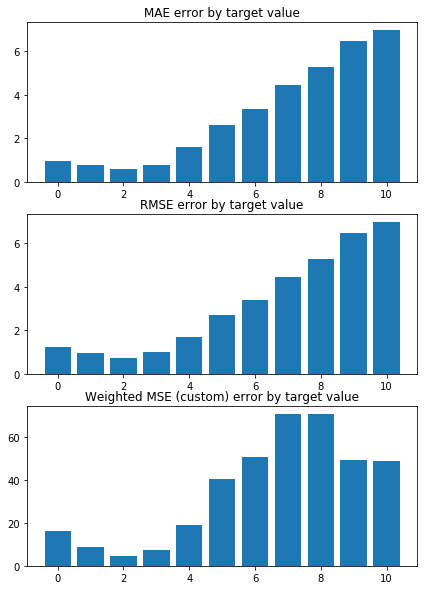

train_index= [    0     2     3 ... 17847 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17082.833209391378, tolerance: 4.716349585894802
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.0679241454429638 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0308405184089124 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


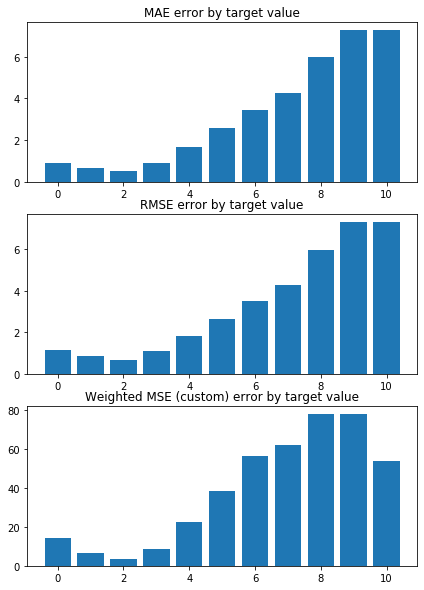

train_index= [    0     1     2 ... 17843 17847 17848]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17360.808974523043, tolerance: 4.765458300587612
  positive)


 TEST PREDICTION Error
weighted_mse_test: 0.9798945861177362 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0409091336987037 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


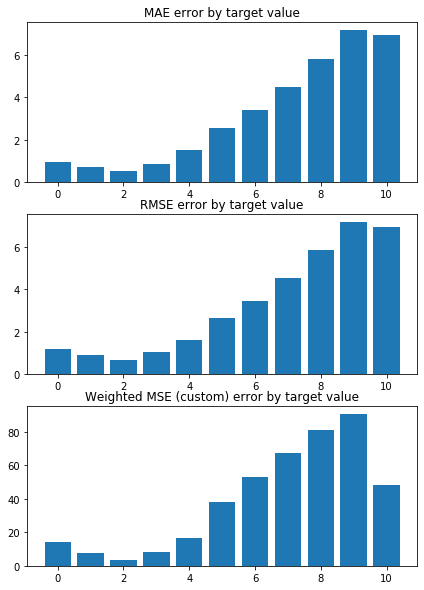

train_index= [    0     1     2 ... 17846 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17043.92771142301, tolerance: 4.716787758316839
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.0339759558067776 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0364340768165312 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


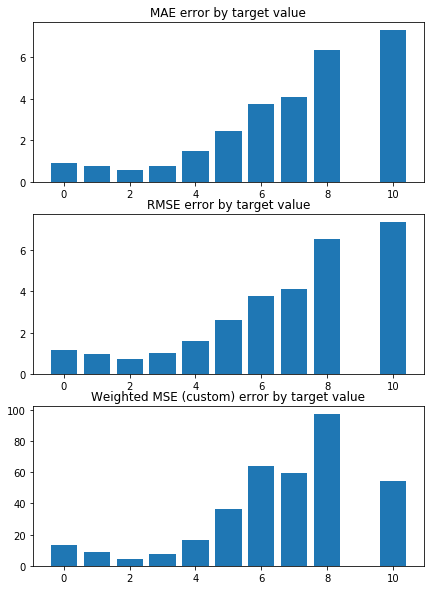

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.147984978848864 

Mean squared error on Test: 1.04 
 MSE mean test:  2.1528730514156917 

Root of MSE on Test: 1.02 
 1.4672672051864621 

Variance score on Test: 0.04 
 r2_test: 0.2725605511620611 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.15
MSE_test 2.15
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32     is_bg  H3K36me1  \
0 -0.380469 -0.325661 -0.237559 -0.167865 -0.152292  0.141897 -0.135761   
1 -0.388096 -0.327093 -0.250428 -0.164091 -0.145425  0.143241 -0.121414   
2 -0.384774 -0.329693 -0.246946 -0.168286 -0.155022  0.141818 -0.139131   
3 -0.380372 -0.343528 -0.254161 -0.162013 -0.145745  0.148820 -0.137026   
4 -0.379115 -0.332625 -0.256548 -0.175836 -0.143108  0.150126 -0.130677   
5 -0.375486 -0.331523 -0.256608 -0.163763 -0.143545  0.146003 -0.130548   
6 -0.374350 -0.333865 -0.258751 -0.159877 -0.153497  0.147884 -0.121470   
7 -0.381371 -0.330876 -0.230451 -0.

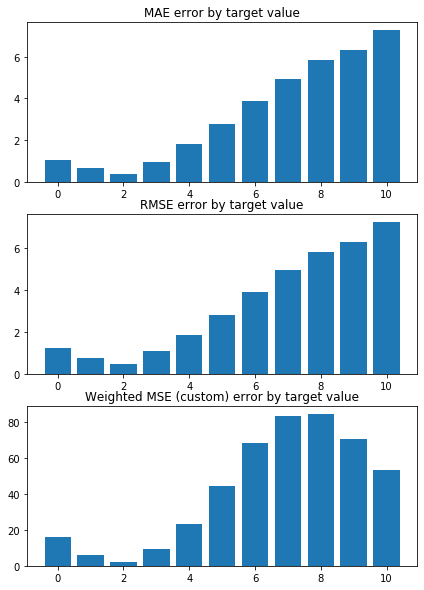

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0563141811602366 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0524461950380712 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


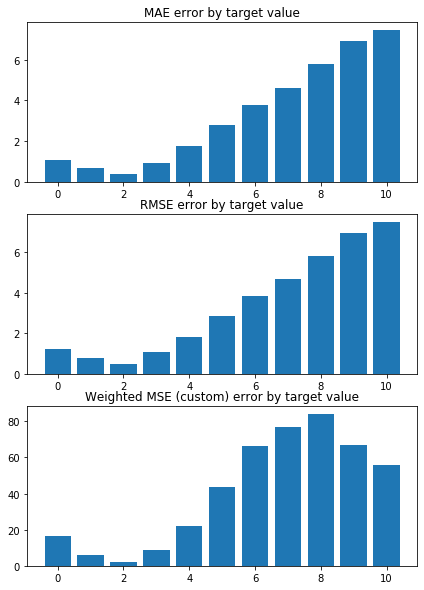

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0315414251538018 


 TRAIN PREDICTION Error
weighted_mse_train: 1.056832101880037 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


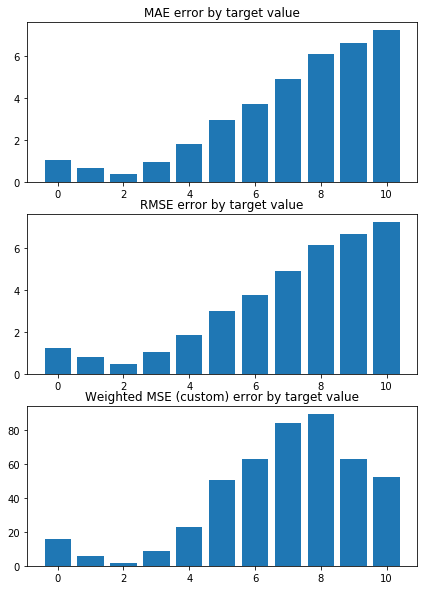

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9836101852246056 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0629419623726337 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


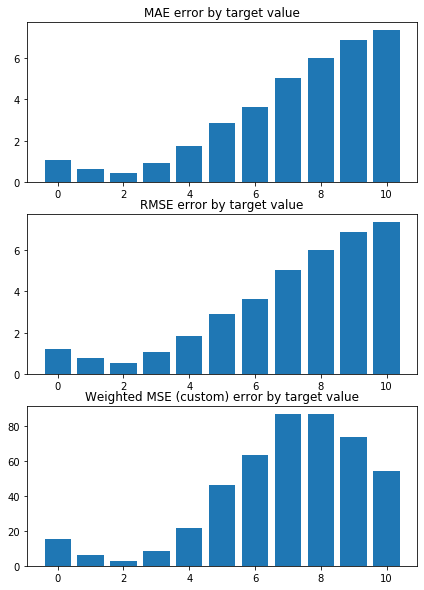

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.054619812410748 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0529544548071534 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


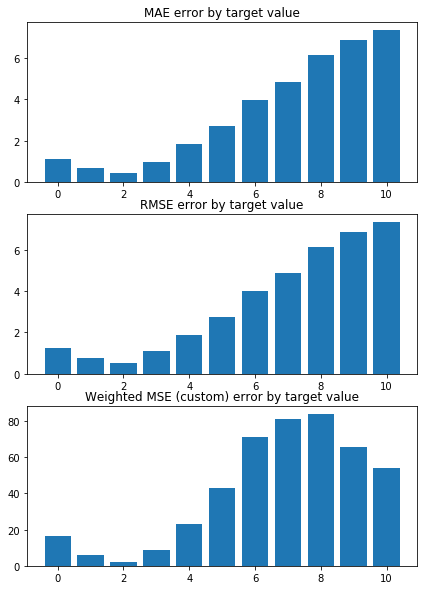

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1124379627059187 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0478737426679432 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


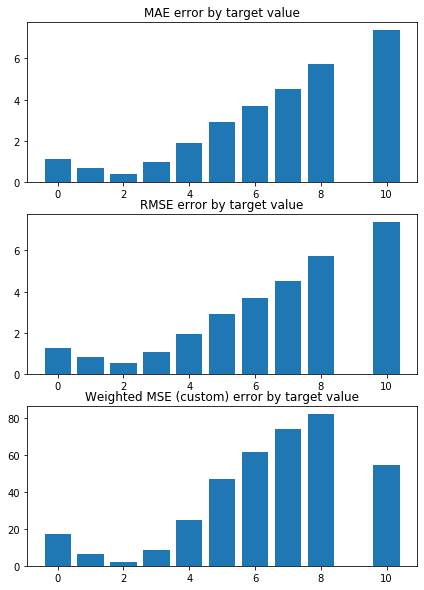

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0933697963110494 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0485747989838958 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


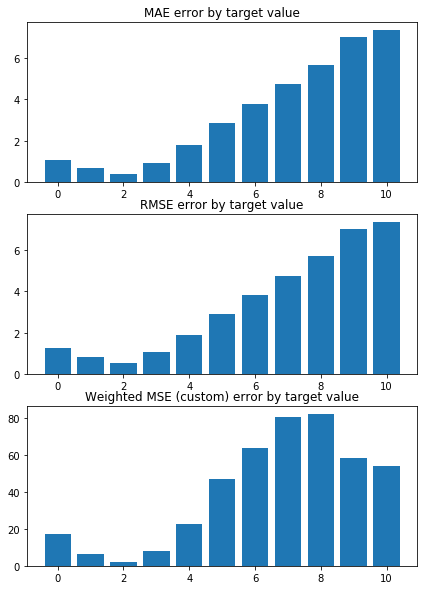

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0884166275539162 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0477856644450776 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


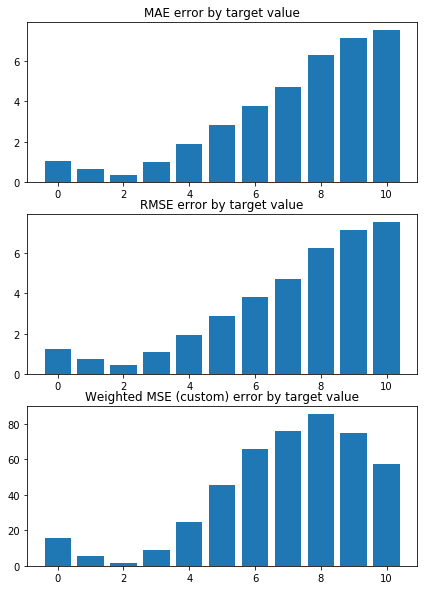

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.0084473136785461 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0580632538084915 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


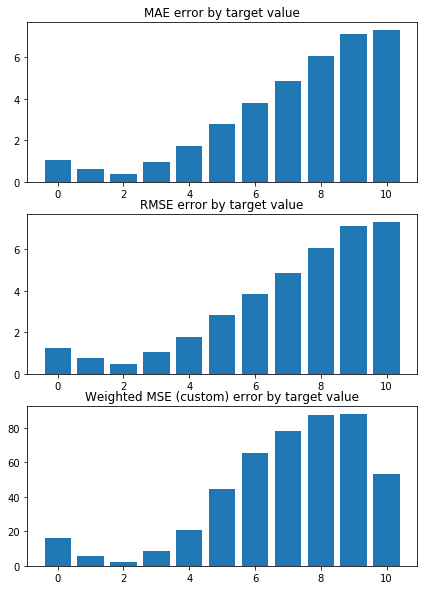

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0486547291207897 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0525017006246267 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


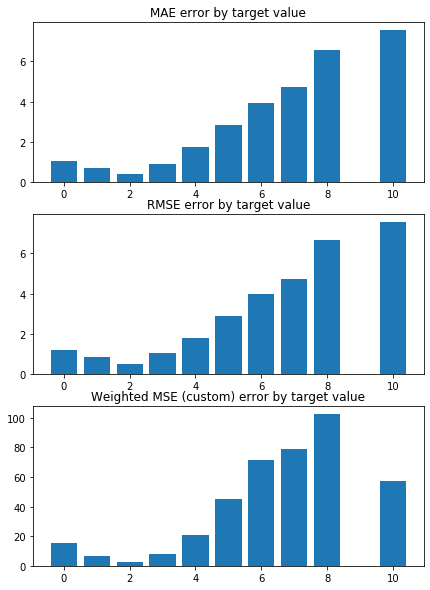

Weighted Mean squared error on Train: 1.05 
 MSE mean train: 2.2635742125367186 

Mean squared error on Test: 1.05 
 MSE mean test:  2.2644001353295873 

Root of MSE on Test: 1.03 
 1.5047923894443338 

Variance score on Test: 0.04 
 r2_test: 0.23482729250362522 

wMSE_train 1.05
wMSE_test 1.05
MSE_train 2.26
MSE_test 2.26
MAE_train 1.01
MAE_test 1.03
r2_test 0.23
    H3K4me1   H3K4me2     Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  \
0 -0.229884 -0.172255 -0.169405 -0.162280      -0.0       0.0      -0.0   
1 -0.226619 -0.176549 -0.173414 -0.159670      -0.0       0.0      -0.0   
2 -0.241550 -0.158712 -0.167476 -0.166853      -0.0       0.0      -0.0   
3 -0.232867 -0.172500 -0.186451 -0.151083      -0.0       0.0      -0.0   
4 -0.239023 -0.157393 -0.175539 -0.165219      -0.0       0.0      -0.0   
5 -0.239123 -0.171076 -0.170792 -0.160146      -0.0       0.0      -0.0   
6 -0.229903 -0.169822 -0.180221 -0.159583      -0.0       0.0      -0.0   
7 -0.227361 -0.177050 -0.171598 -

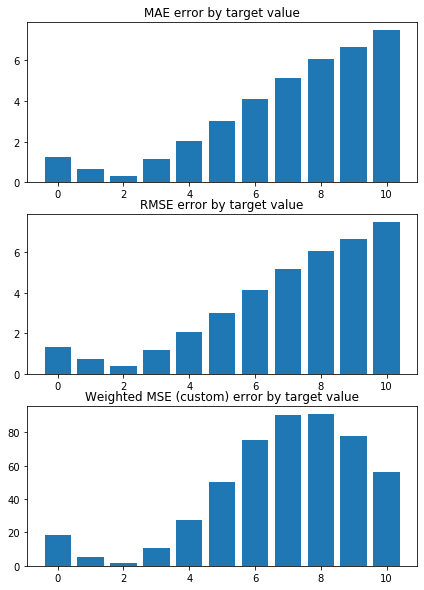

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1722056433108452 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1569526063279543 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


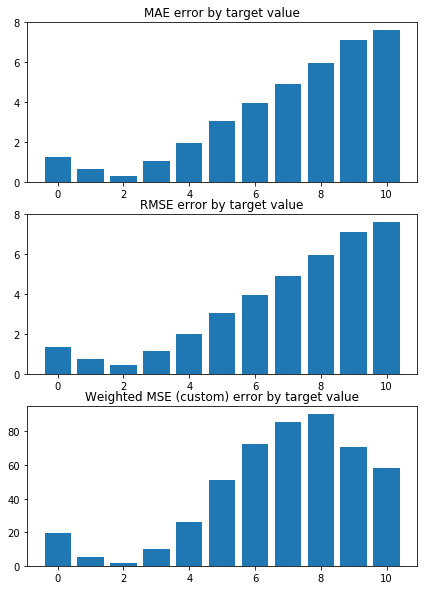

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1314408335720125 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1627328940140245 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


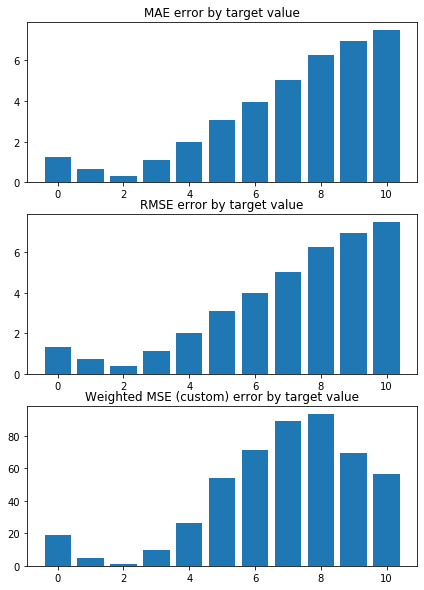

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0869446685258903 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1664325181489776 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


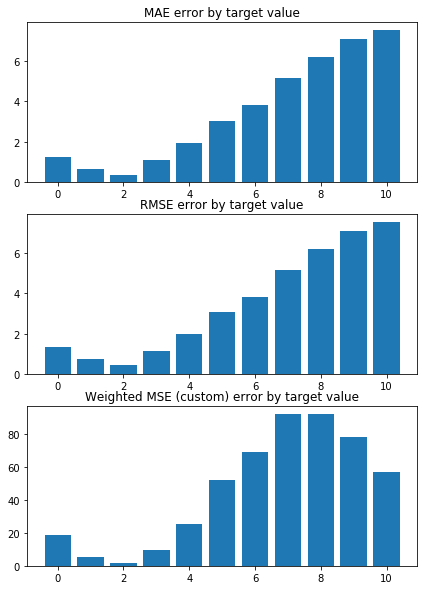

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1523573614662668 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1580342004568511 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


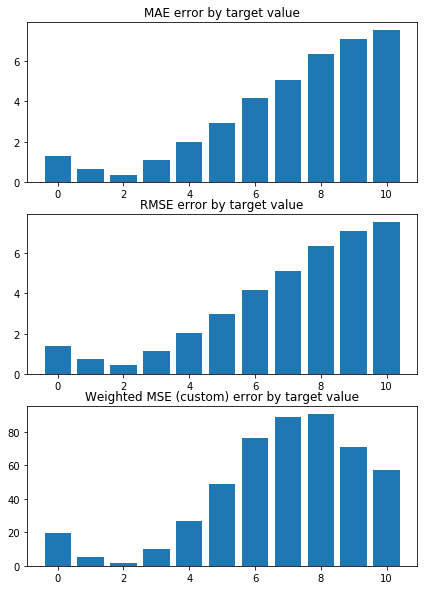

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.2063374814694543 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1532946495351055 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


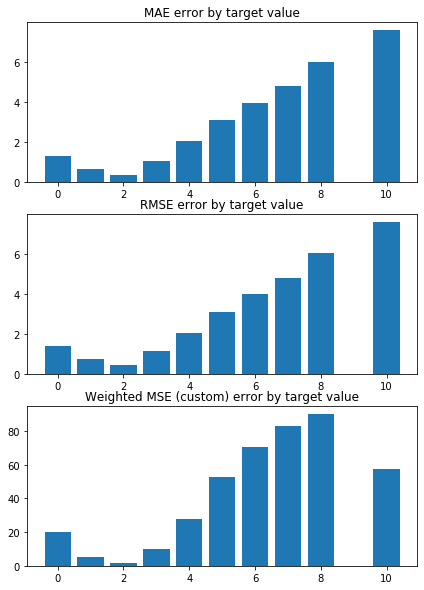

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1879693318024664 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1531066882621204 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


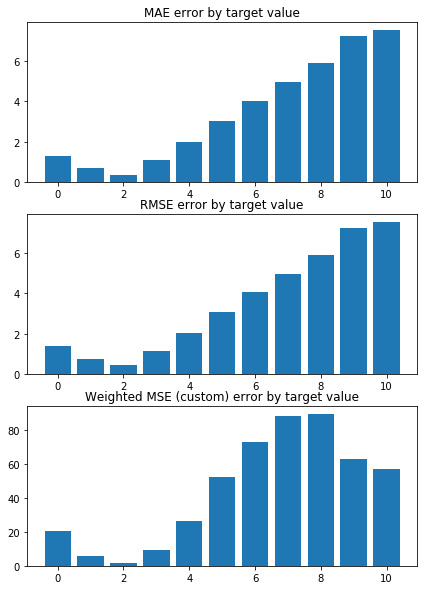

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.2086834700293745 


 TRAIN PREDICTION Error
weighted_mse_train: 1.151385549951421 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


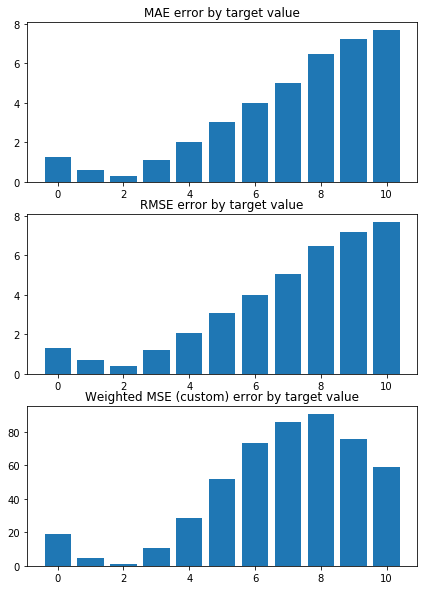

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.1150461491760972 


 TRAIN PREDICTION Error
weighted_mse_train: 1.162365095770671 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


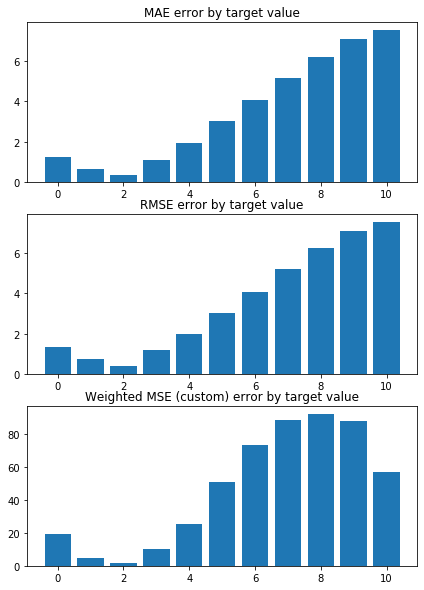

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1582653012712123 


 TRAIN PREDICTION Error
weighted_mse_train: 1.155935097889397 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


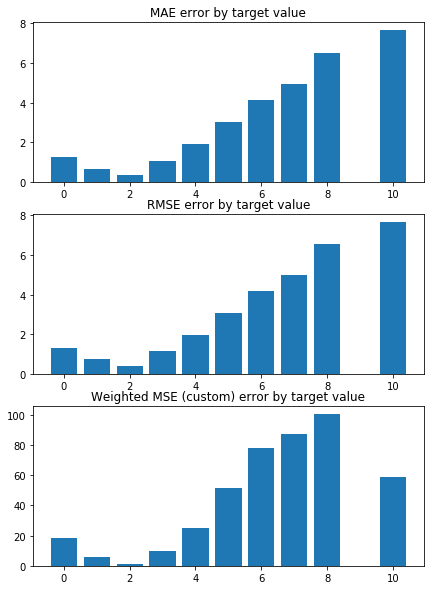

Weighted Mean squared error on Train: 1.16 
 MSE mean train: 2.448568362549515 

Mean squared error on Test: 1.16 
 MSE mean test:  2.4495271657342723 

Root of MSE on Test: 1.08 
 1.565096535595895 

Variance score on Test: 0.04 
 r2_test: 0.17211698638268674 

wMSE_train 1.16
wMSE_test 1.16
MSE_train 2.45
MSE_test 2.45
MAE_train 1.08
MAE_test 1.11
r2_test 0.17
    H3K4me2     Chriz  H3K36me3   H3K4me1  H3K36me1  H3K27me3  H3K27me1  \
0 -0.330756 -0.056487 -0.023915 -0.013810      -0.0       0.0      -0.0   
1 -0.336597 -0.057905 -0.022985 -0.009032      -0.0       0.0      -0.0   
2 -0.316818 -0.052389 -0.032684 -0.024910      -0.0       0.0      -0.0   
3 -0.328228 -0.076039 -0.011911 -0.017909      -0.0       0.0      -0.0   
4 -0.314275 -0.062539 -0.029181 -0.024132      -0.0       0.0      -0.0   
5 -0.329280 -0.056522 -0.022752 -0.023790      -0.0       0.0      -0.0   
6 -0.326855 -0.068685 -0.020944 -0.015143      -0.0       0.0      -0.0   
7 -0.334513 -0.058583 -0.020790 -0.

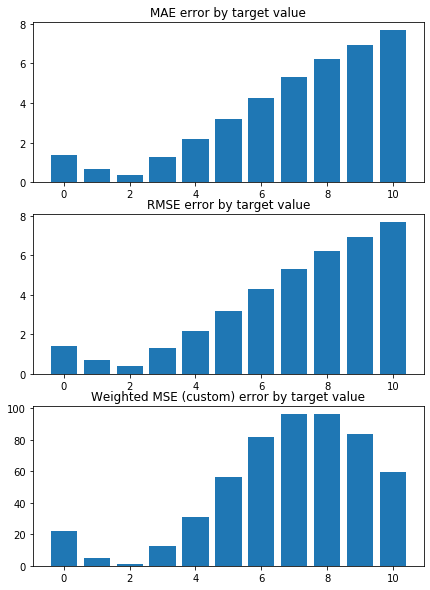

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.3179558143551318 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2996795374081076 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


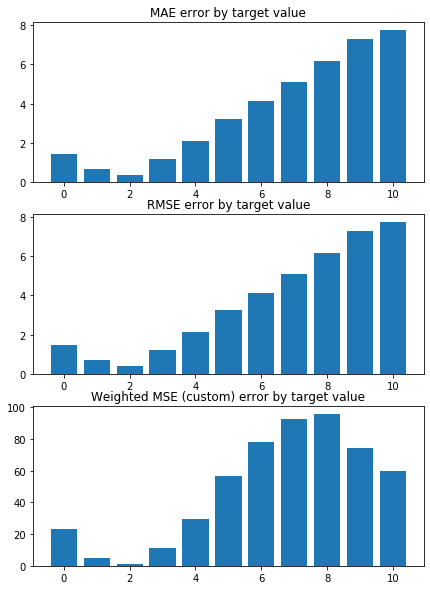

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.2816423632061502 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3080597915401713 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


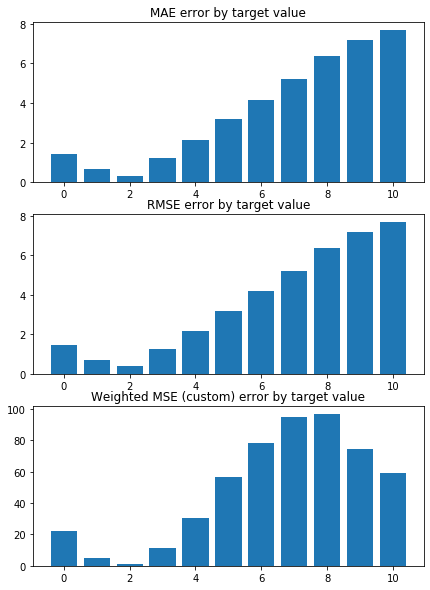

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.221989466869843 


 TRAIN PREDICTION Error
weighted_mse_train: 1.310041162620438 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


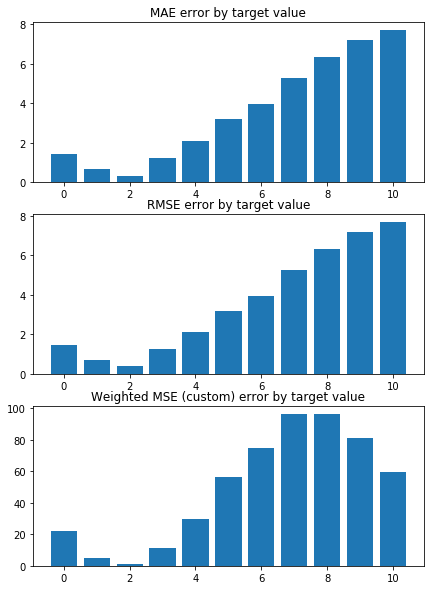

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.2959819621678001 


 TRAIN PREDICTION Error
weighted_mse_train: 1.304291321735832 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


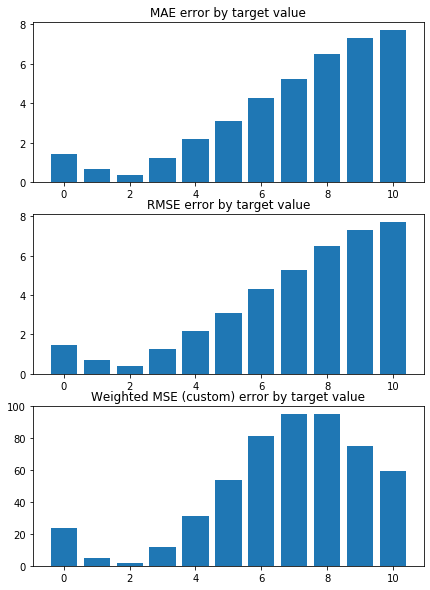

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.3417649022660336 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2965280671585175 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


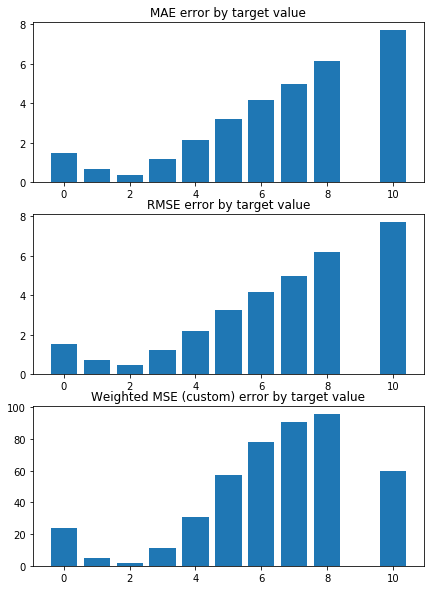

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.3203594679907986 


 TRAIN PREDICTION Error
weighted_mse_train: 1.297943152488397 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


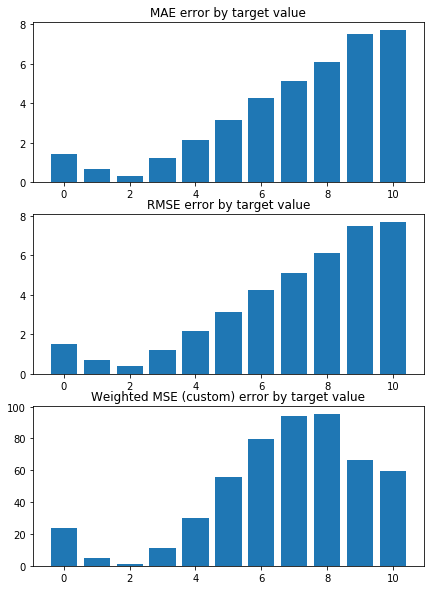

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.3589641481685977 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2930970434165712 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


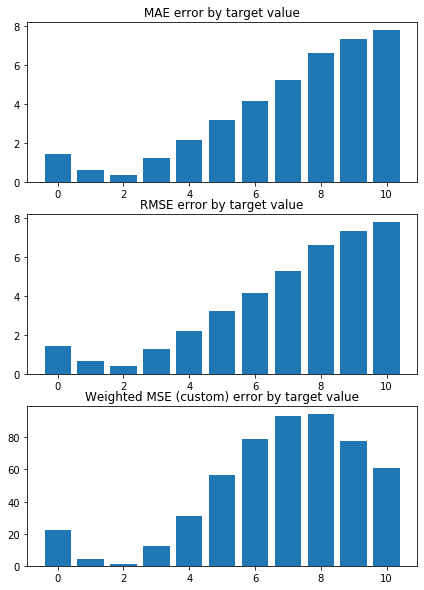

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.2628310108007936 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3073305339108925 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


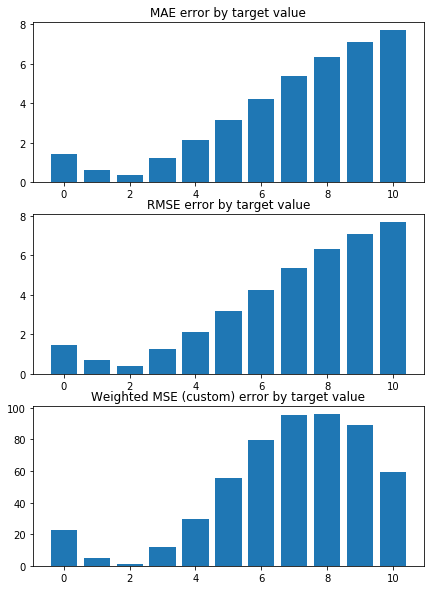

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.3099886137595116 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3003578711258996 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


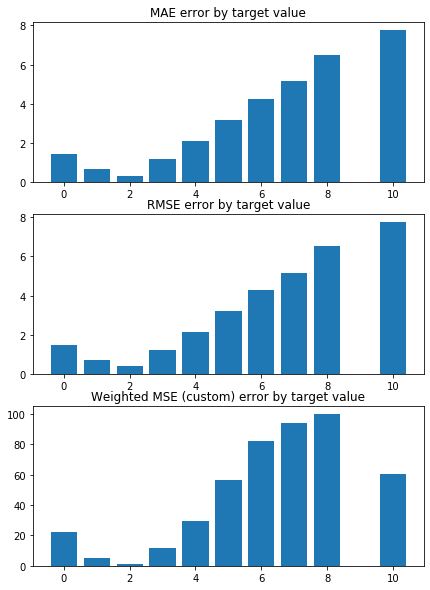

Weighted Mean squared error on Train: 1.30 
 MSE mean train: 2.6691595465804547 

Mean squared error on Test: 1.30 
 MSE mean test:  2.669599525733424 

Root of MSE on Test: 1.14 
 1.6338909161059143 

Variance score on Test: 0.04 
 r2_test: 0.09758706797546943 

wMSE_train 1.3
wMSE_test 1.3
MSE_train 2.67
MSE_test 2.67
MAE_train 1.16
MAE_test 1.19
r2_test 0.1
    H3K4me2  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  \
0 -0.203059      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
1 -0.205448      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
2 -0.201977      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
3 -0.210934      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
4 -0.204468      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
5 -0.209569      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
6 -0.208398      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
7 -0.205496      -0.0      -0.0       0.0      -0.0  

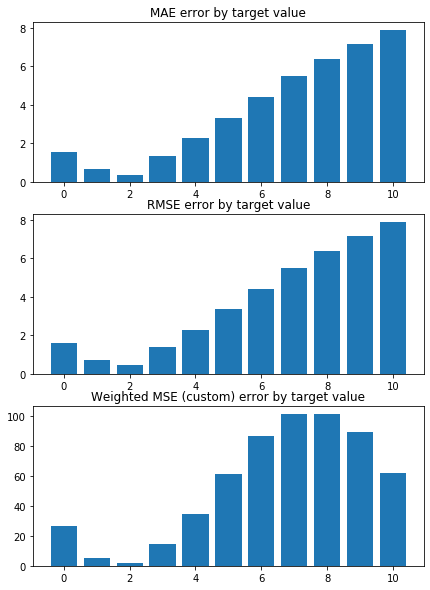

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5166789734210804 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4944529716388983 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


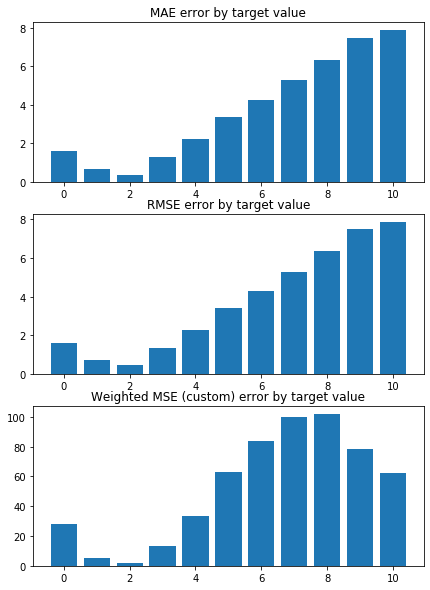

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4796803067909559 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5022532957037449 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


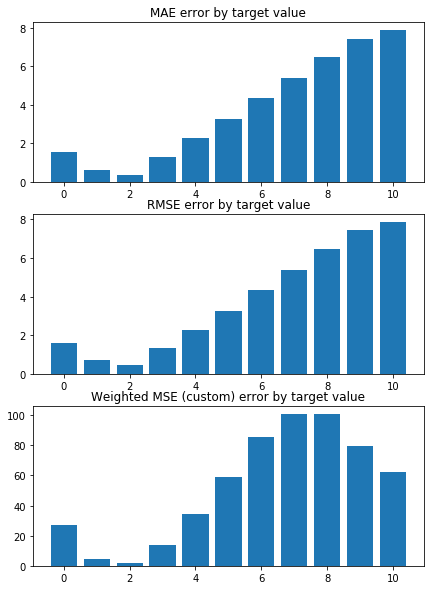

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.412629303209562 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5037507117121243 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


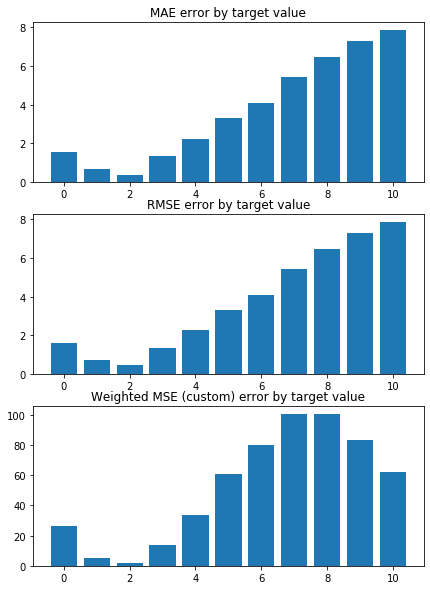

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4868270275237594 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4985291219129366 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


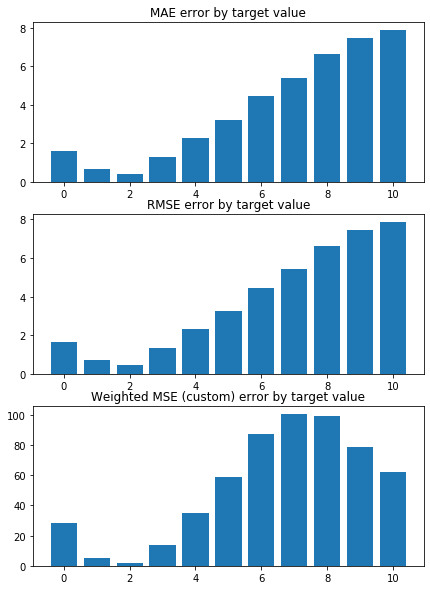

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5223789885110826 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4903227076930015 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


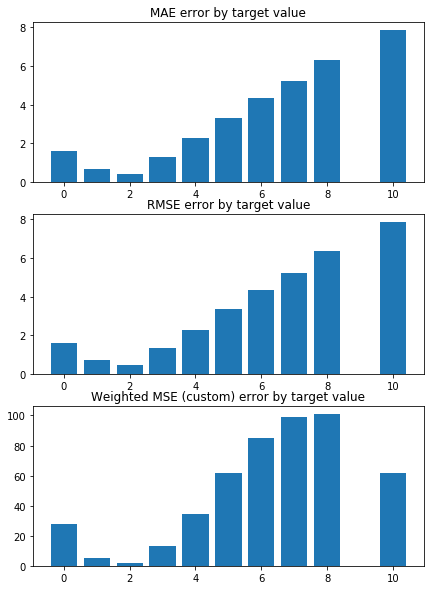

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5049726084415453 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4929127364818582 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


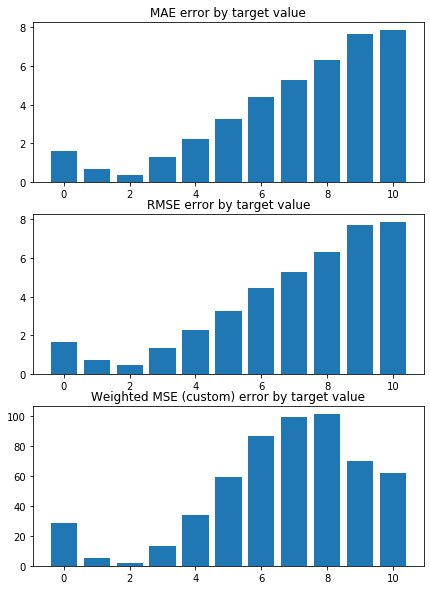

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5592530709445265 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4867621819162706 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


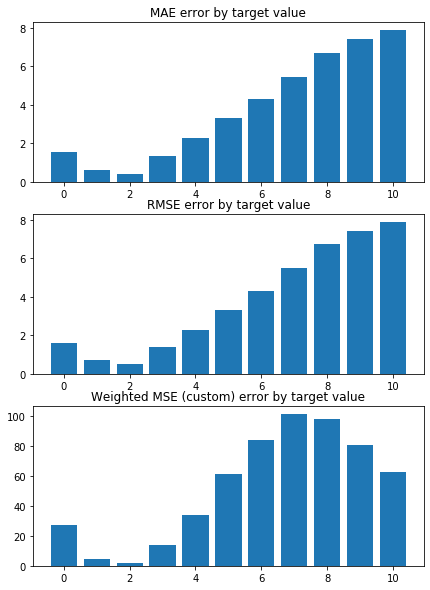

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.4626002498338024 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5021901412392409 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


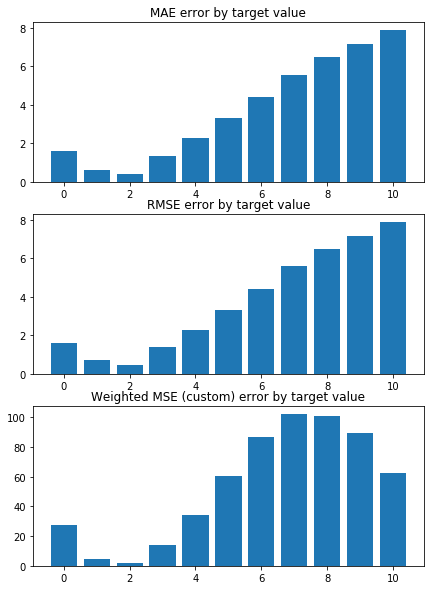

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5127992331648408 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4941369939883602 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


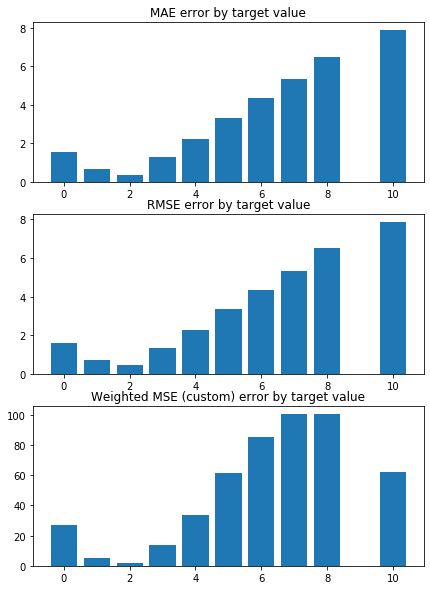

Weighted Mean squared error on Train: 1.50 
 MSE mean train: 2.9491620318162157 

Mean squared error on Test: 1.50 
 MSE mean test:  2.949605353940803 

Root of MSE on Test: 1.22 
 1.7174415139796764 

Variance score on Test: 0.04 
 r2_test: 0.0026825187477259706 

wMSE_train 1.5
wMSE_test 1.5
MSE_train 2.95
MSE_test 2.95
MAE_train 1.25
MAE_test 1.28
r2_test 0.0
    H3K4me2  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  \
0 -0.002459      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
1 -0.004891      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
2 -0.002788      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
3 -0.010468      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
4 -0.005259      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
5 -0.010274      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
6 -0.008189      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
7 -0.005532      -0.0      -0.0       0.0      -0.0

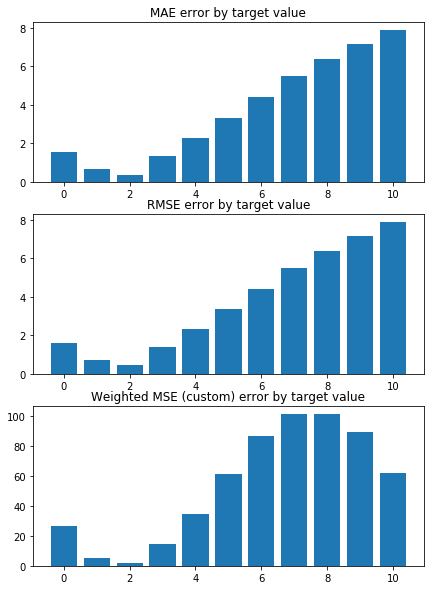

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5223866913238566 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5000452670038045 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


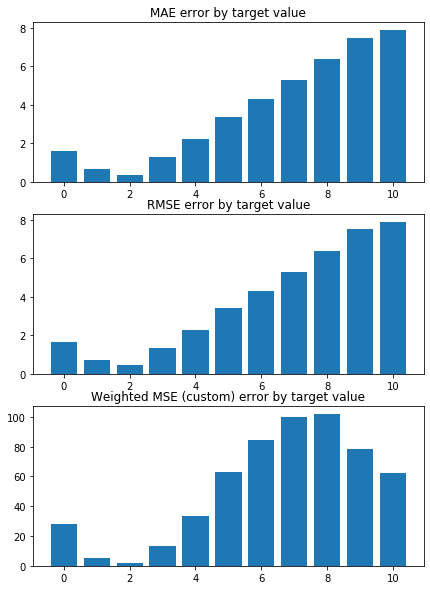

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4829104249189313 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5054458089959184 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


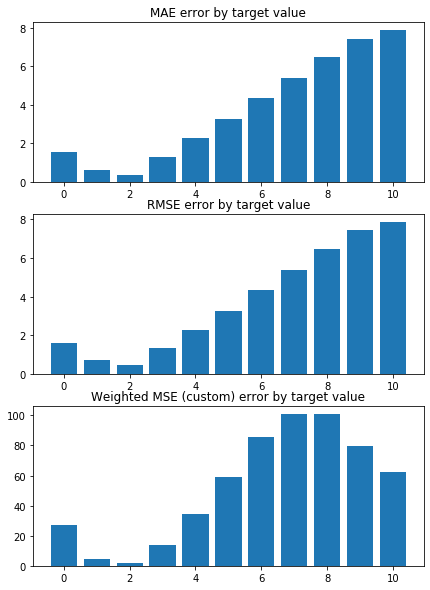

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4244925388995253 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5157153565133847 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


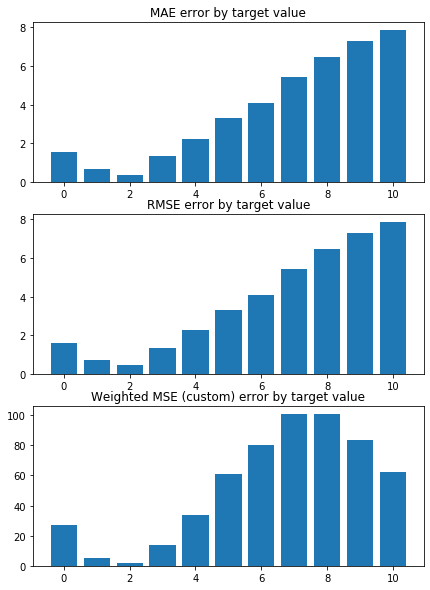

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.492735903069663 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5045636879865436 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


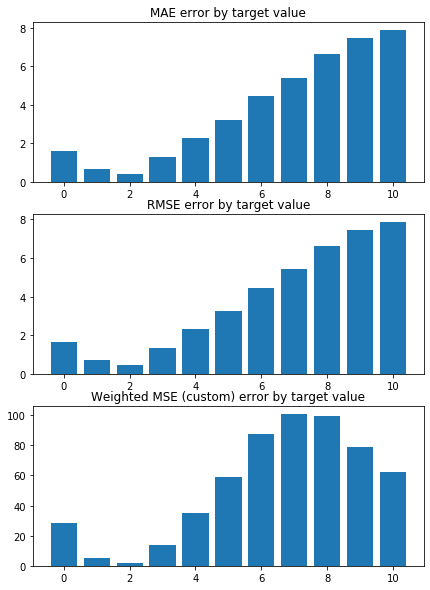

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5334384341949743 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5021296506382618 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


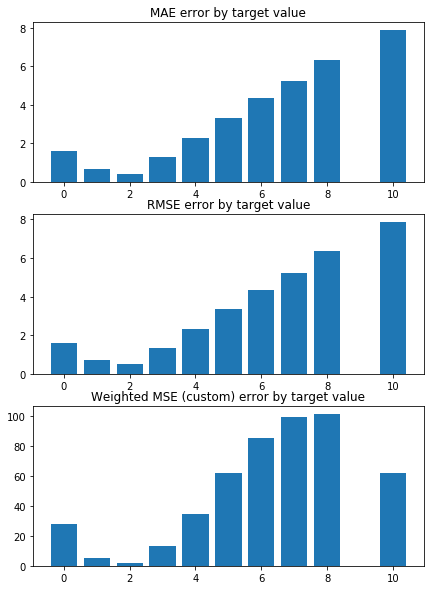

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5139765180356128 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5023200753947654 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


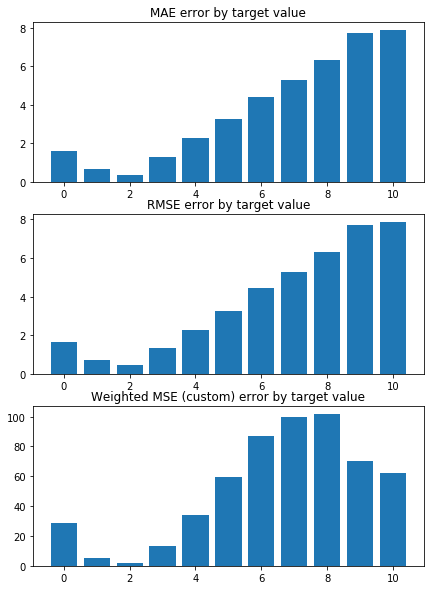

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5657406847615234 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4930764070047973 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


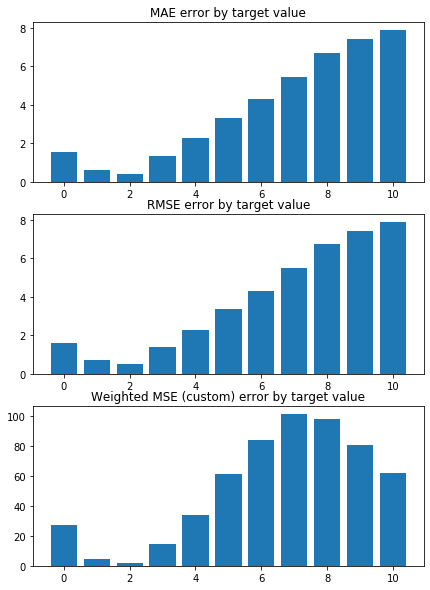

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.46550533906606 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5050318879760942 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


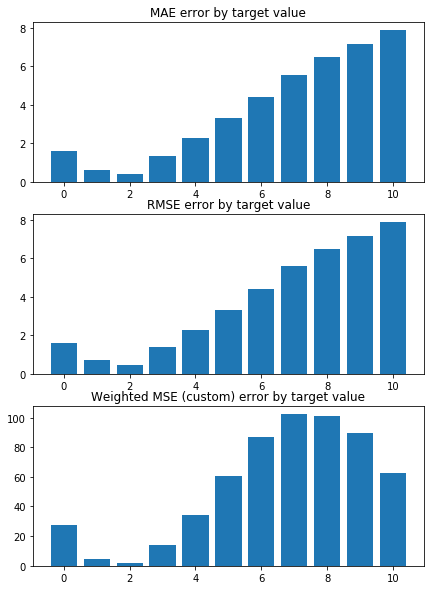

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5204784209799074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5014976051400921 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


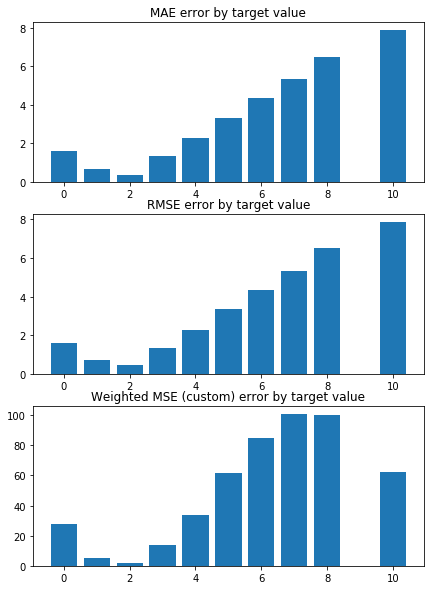

Weighted Mean squared error on Train: 1.50 
 MSE mean train: 2.958612123656919 

Mean squared error on Test: 1.50 
 MSE mean test:  2.9588950737074304 

Root of MSE on Test: 1.23 
 1.7201439107549783 

Variance score on Test: 0.04 
 r2_test: -0.000502398722420172 

wMSE_train 1.5
wMSE_test 1.5
MSE_train 2.96
MSE_test 2.96
MAE_train 1.26
MAE_test 1.29
r2_test -0.0
   is_bg  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
1    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
2    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
3    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
4    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
5    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
6    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
7 

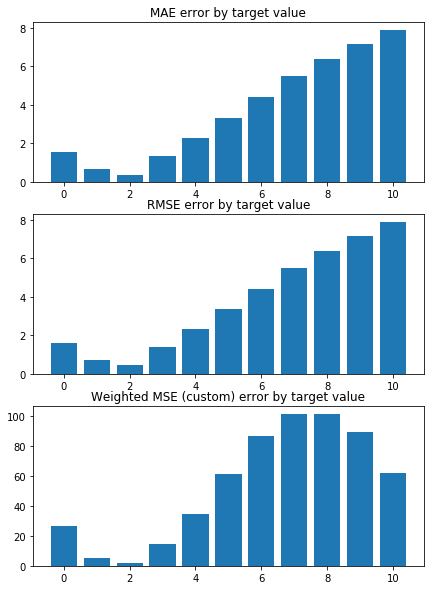

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5223866913238566 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5000452670038045 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


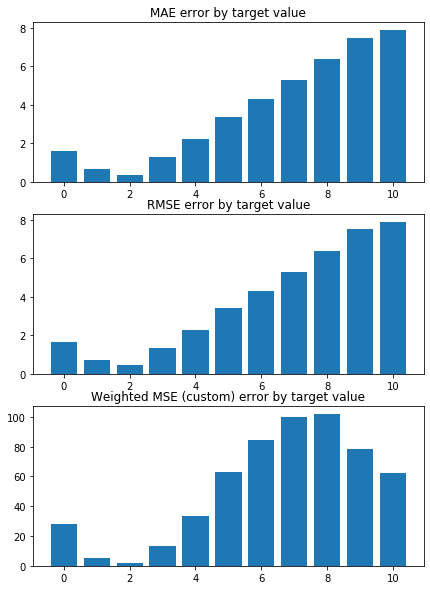

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4829104249189313 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5054458089959184 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


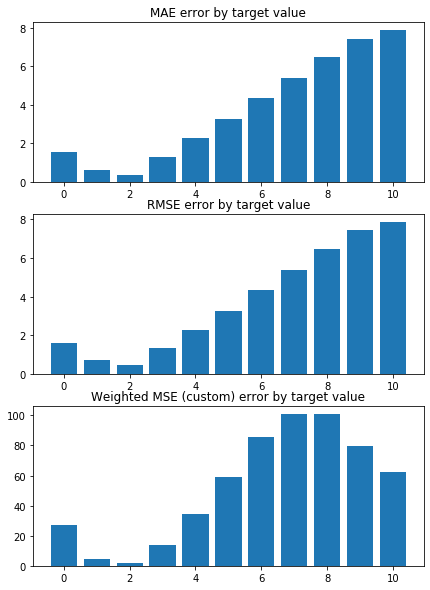

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4244925388995253 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5157153565133847 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


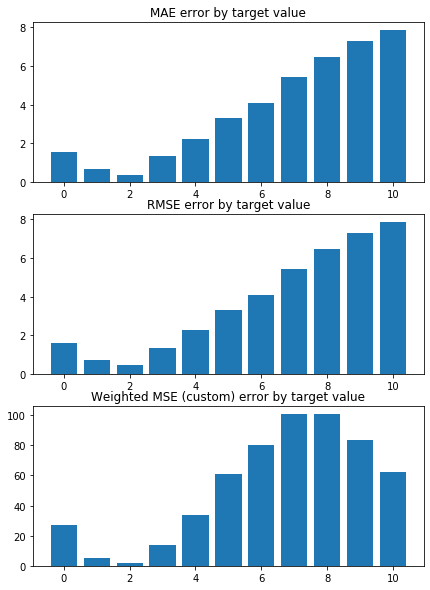

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.492735903069663 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5045636879865436 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


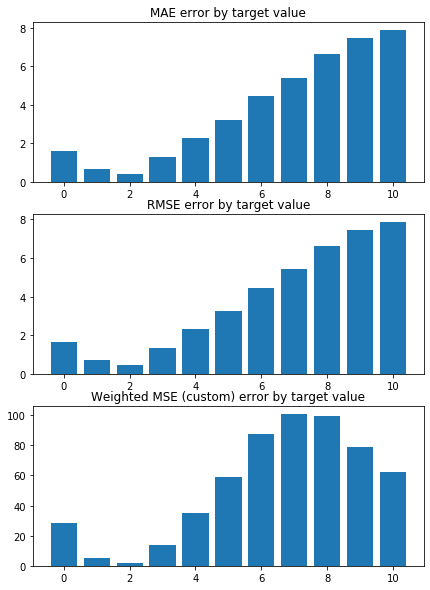

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5334384341949743 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5021296506382618 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


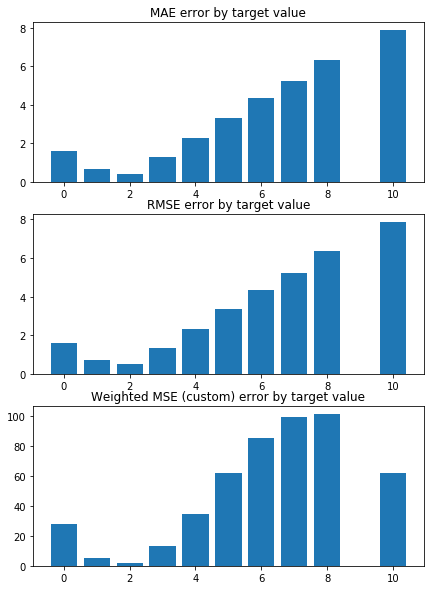

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5139765180356128 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5023200753947654 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


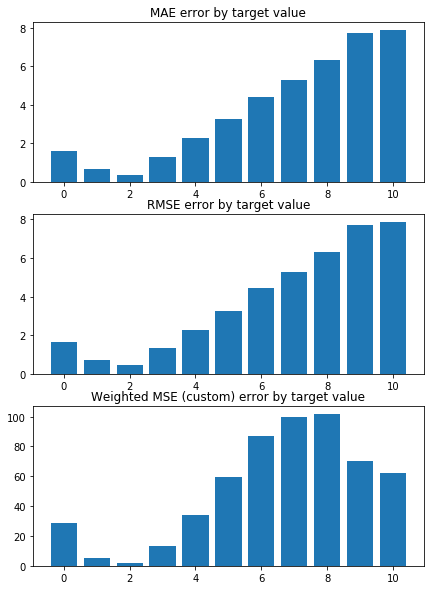

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5657406847615234 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4930764070047973 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


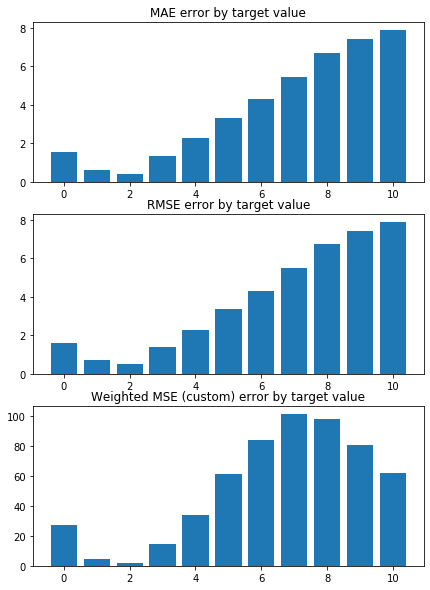

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.46550533906606 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5050318879760942 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


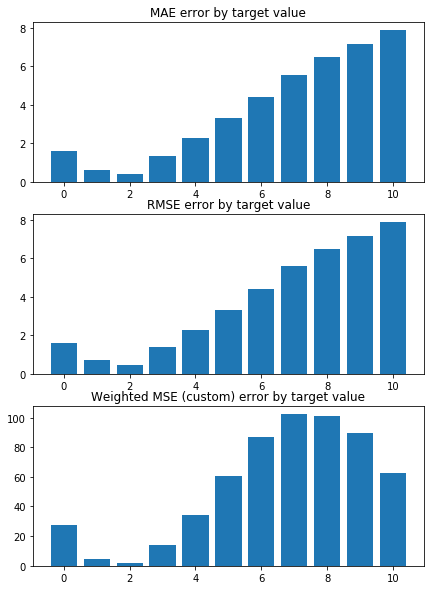

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5204784209799074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5014976051400921 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


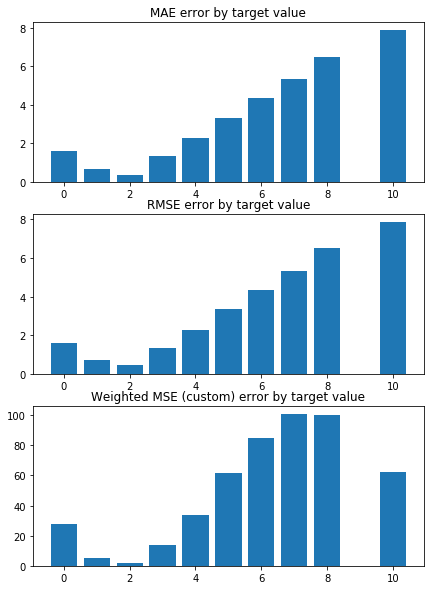

Weighted Mean squared error on Train: 1.50 
 MSE mean train: 2.958612123656919 

Mean squared error on Test: 1.50 
 MSE mean test:  2.9588950737074304 

Root of MSE on Test: 1.23 
 1.7201439107549783 

Variance score on Test: 0.04 
 r2_test: -0.000502398722420172 

wMSE_train 1.5
wMSE_test 1.5
MSE_train 2.96
MSE_test 2.96
MAE_train 1.26
MAE_test 1.29
r2_test -0.0
   is_bg  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
1    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
2    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
3    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
4    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
5    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
6    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
7 

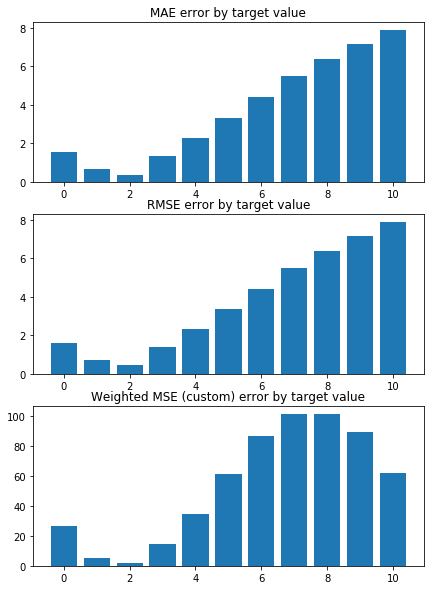

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5223866913238566 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5000452670038045 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


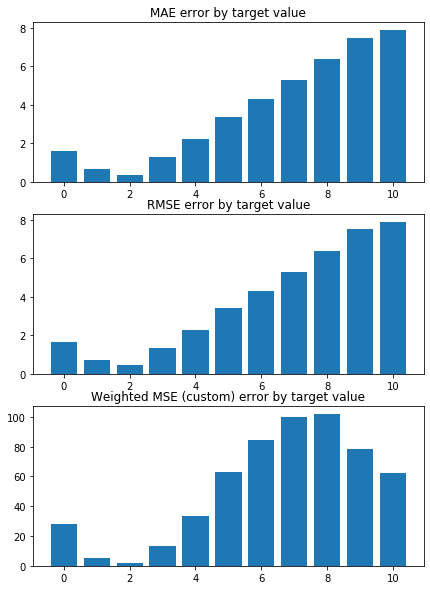

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4829104249189313 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5054458089959184 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


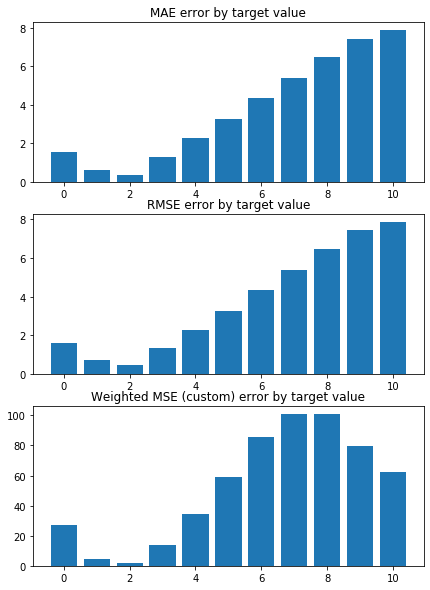

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4244925388995253 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5157153565133847 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


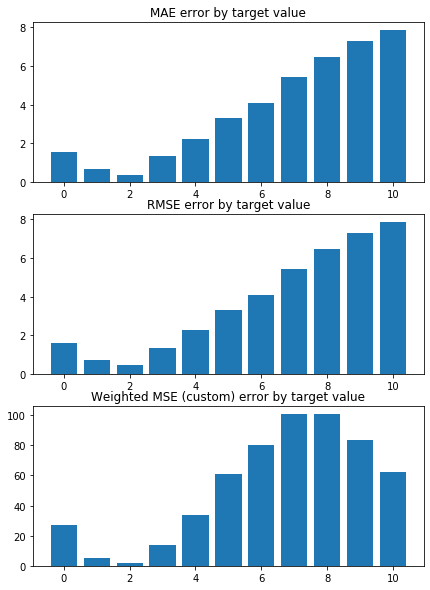

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.492735903069663 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5045636879865436 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


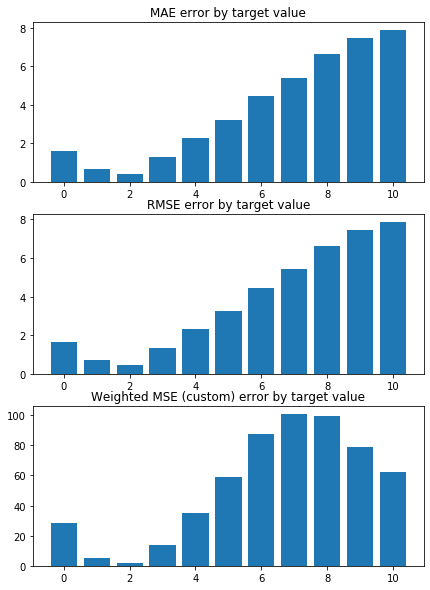

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5334384341949743 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5021296506382618 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


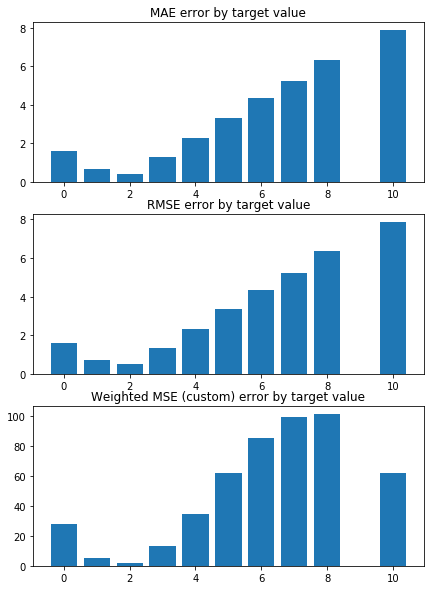

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5139765180356128 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5023200753947654 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


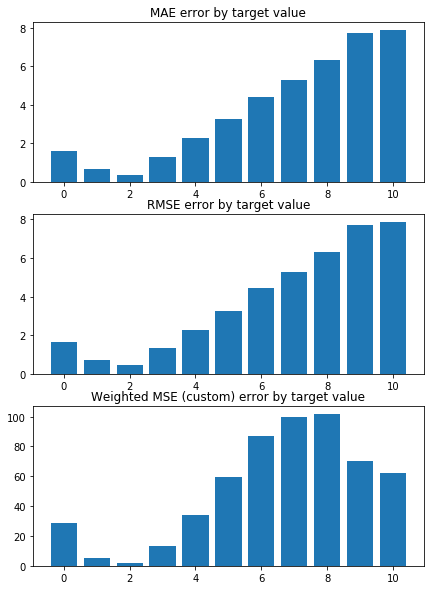

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5657406847615234 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4930764070047973 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


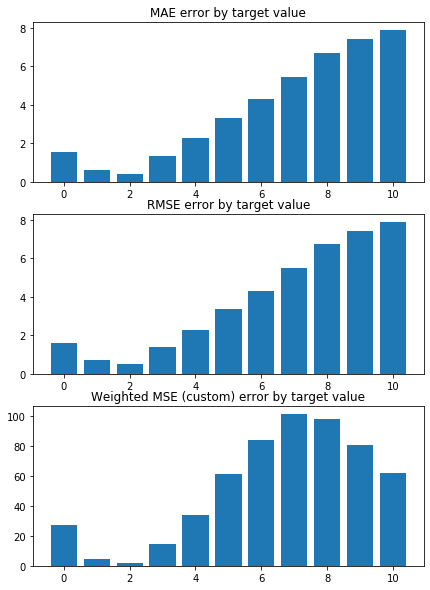

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.46550533906606 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5050318879760942 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


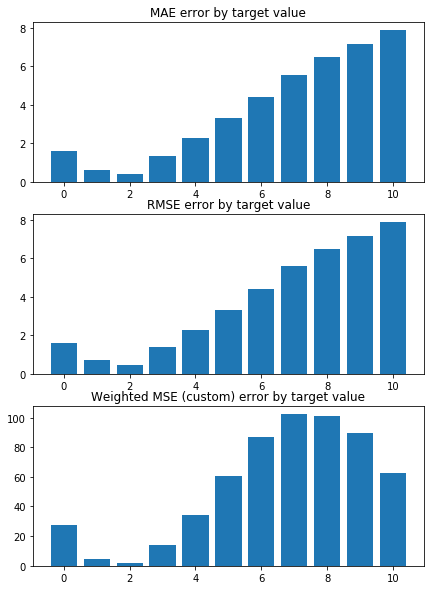

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5204784209799074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5014976051400921 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


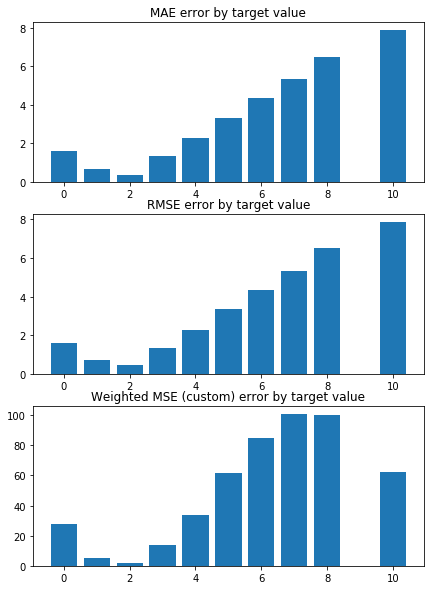

Weighted Mean squared error on Train: 1.50 
 MSE mean train: 2.958612123656919 

Mean squared error on Test: 1.50 
 MSE mean test:  2.9588950737074304 

Root of MSE on Test: 1.23 
 1.7201439107549783 

Variance score on Test: 0.04 
 r2_test: -0.000502398722420172 

wMSE_train 1.5
wMSE_test 1.5
MSE_train 2.96
MSE_test 2.96
MAE_train 1.26
MAE_test 1.29
r2_test -0.0
   is_bg  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
1    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
2    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
3    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
4    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
5    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
6    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
7 

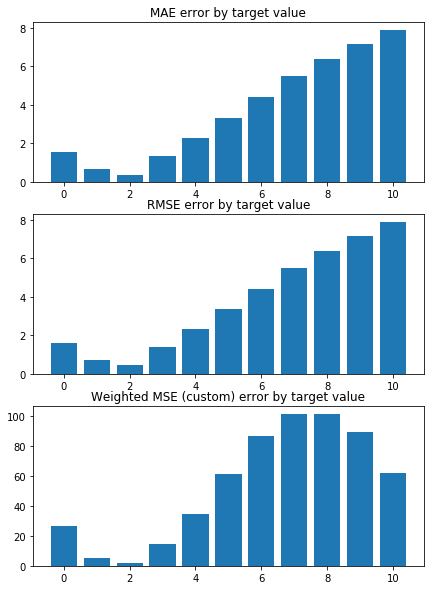

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5223866913238566 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5000452670038045 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


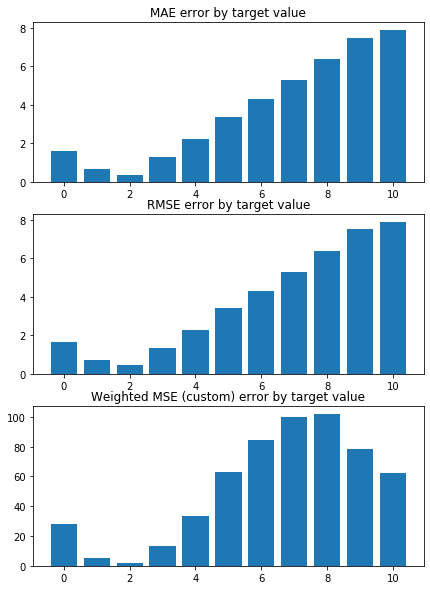

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4829104249189313 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5054458089959184 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


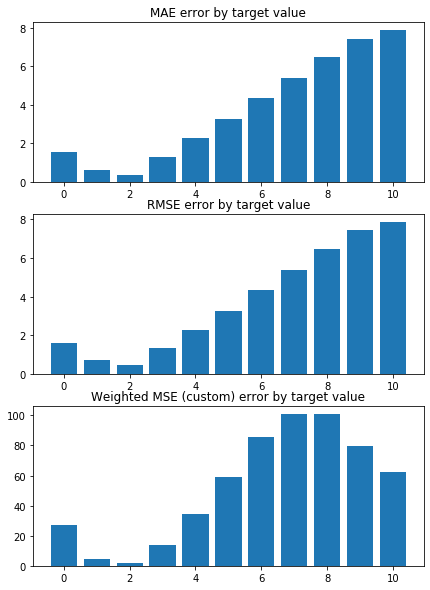

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4244925388995253 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5157153565133847 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


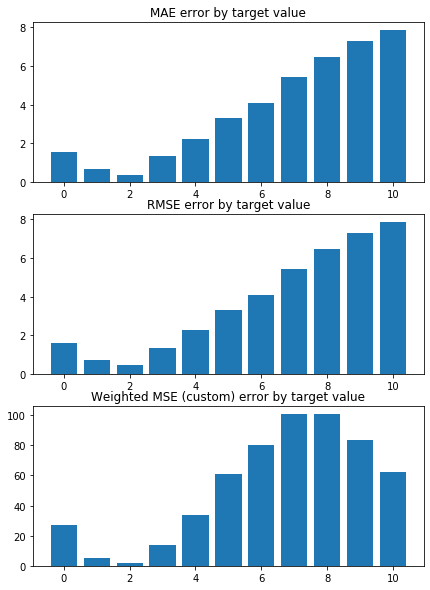

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.492735903069663 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5045636879865436 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


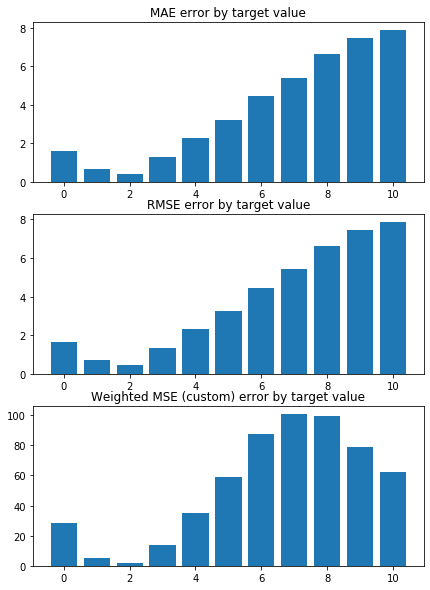

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5334384341949743 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5021296506382618 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


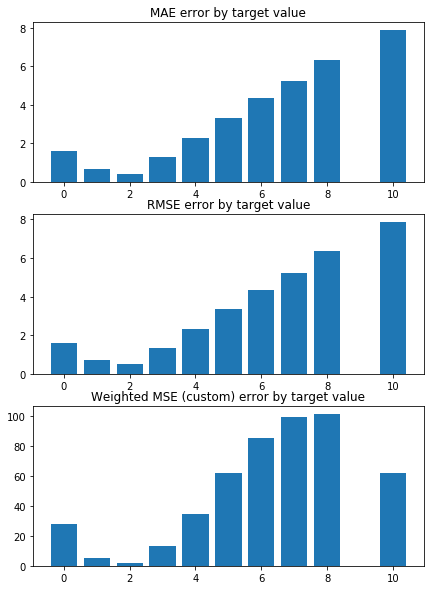

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5139765180356128 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5023200753947654 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


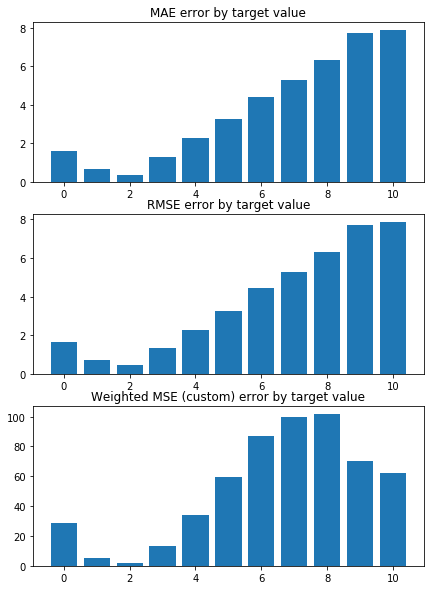

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5657406847615234 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4930764070047973 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


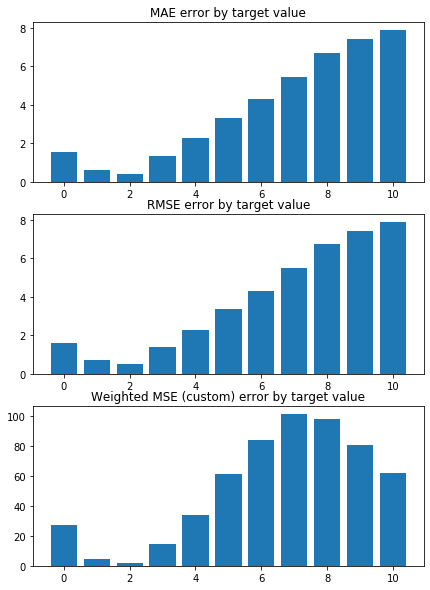

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.46550533906606 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5050318879760942 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


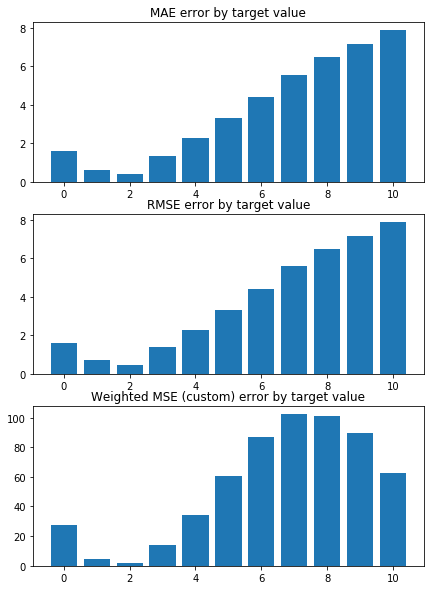

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5204784209799074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5014976051400921 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


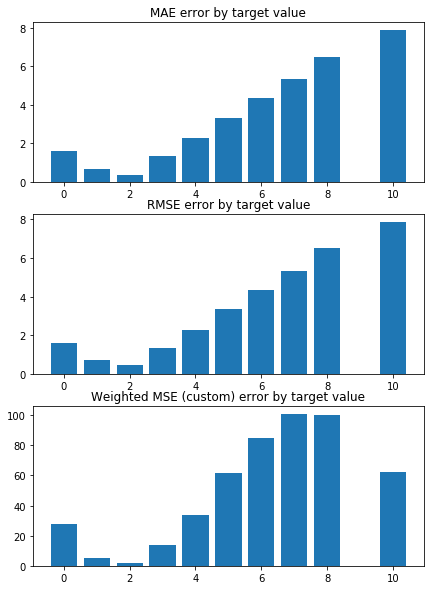

Weighted Mean squared error on Train: 1.50 
 MSE mean train: 2.958612123656919 

Mean squared error on Test: 1.50 
 MSE mean test:  2.9588950737074304 

Root of MSE on Test: 1.23 
 1.7201439107549783 

Variance score on Test: 0.04 
 r2_test: -0.000502398722420172 

wMSE_train 1.5
wMSE_test 1.5
MSE_train 2.96
MSE_test 2.96
MAE_train 1.26
MAE_test 1.29
r2_test -0.0
   is_bg  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
1    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
2    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
3    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
4    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
5    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
6    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
7 

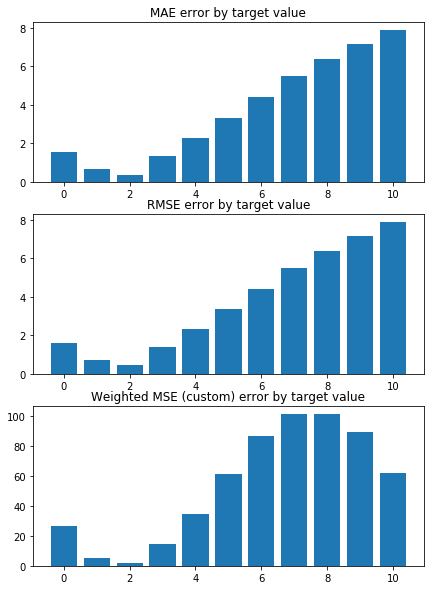

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5223866913238566 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5000452670038045 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


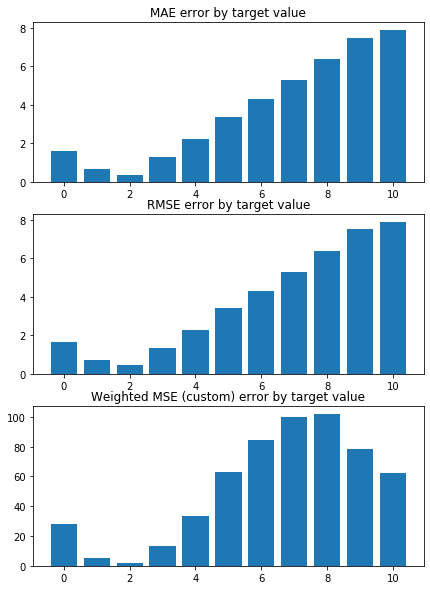

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4829104249189313 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5054458089959184 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


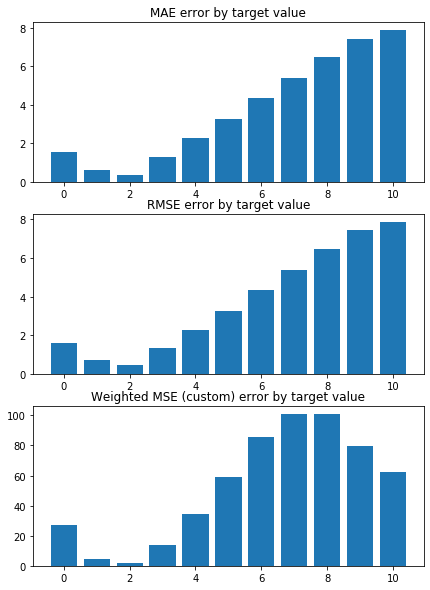

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4244925388995253 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5157153565133847 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


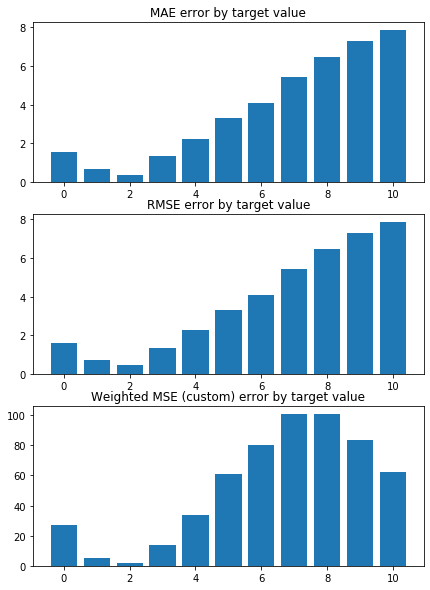

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.492735903069663 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5045636879865436 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


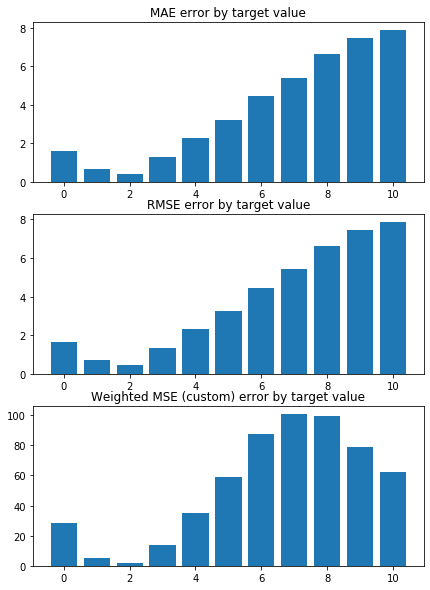

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5334384341949743 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5021296506382618 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


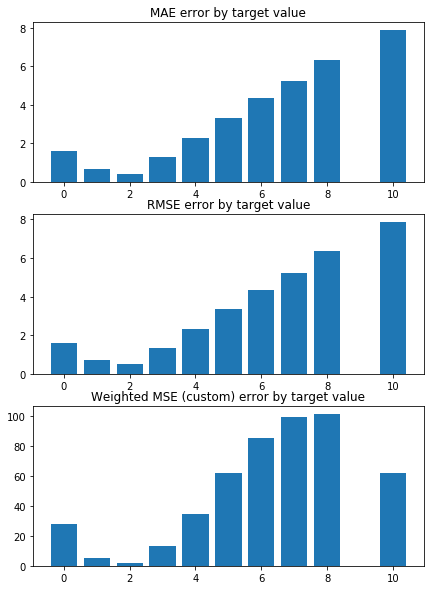

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5139765180356128 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5023200753947654 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


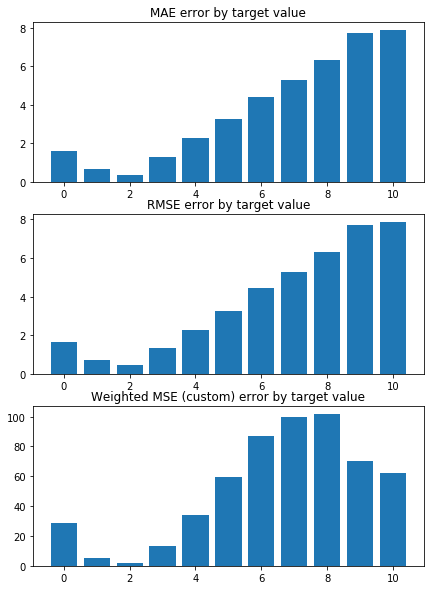

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5657406847615234 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4930764070047973 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


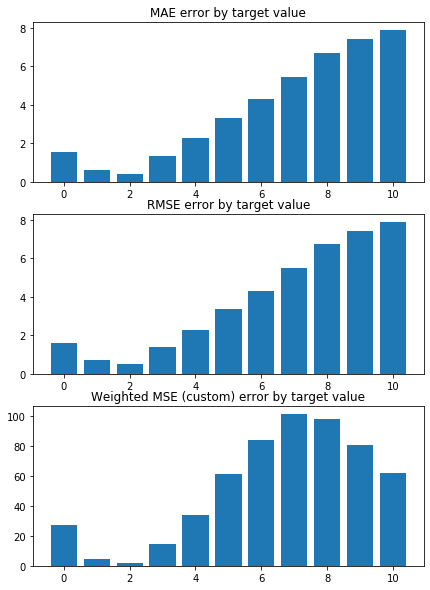

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.46550533906606 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5050318879760942 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


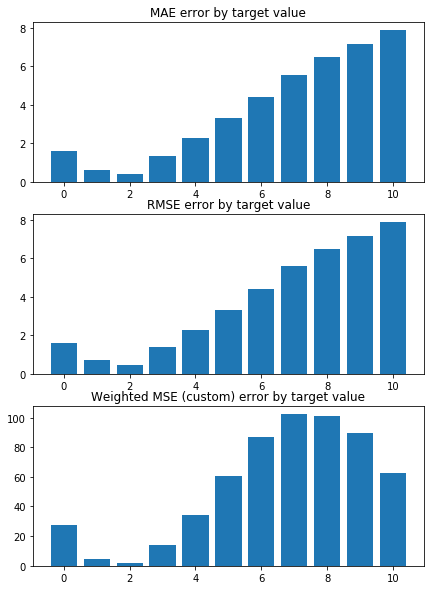

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5204784209799074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5014976051400921 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


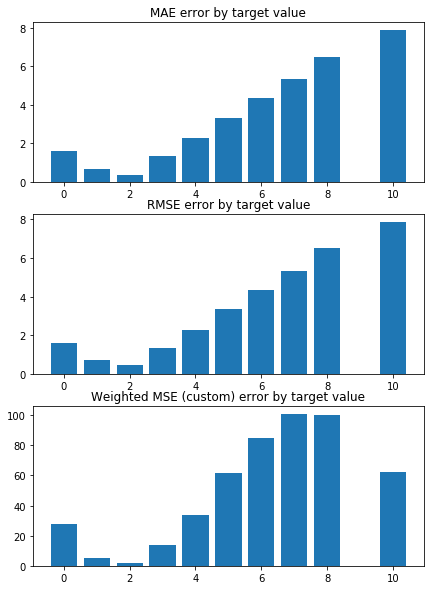

Weighted Mean squared error on Train: 1.50 
 MSE mean train: 2.958612123656919 

Mean squared error on Test: 1.50 
 MSE mean test:  2.9588950737074304 

Root of MSE on Test: 1.23 
 1.7201439107549783 

Variance score on Test: 0.04 
 r2_test: -0.000502398722420172 

wMSE_train 1.5
wMSE_test 1.5
MSE_train 2.96
MSE_test 2.96
MAE_train 1.26
MAE_test 1.29
r2_test -0.0
   is_bg  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
1    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
2    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
3    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
4    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
5    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
6    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
7 

In [122]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

alpha_grid = np.arange(0, 2, 0.2)
# Create linear regression object

model_name = 'LR+L1_grid'
n_splits = 10
random_state = 16 
shuffle = True

wmse_test = []
wmse_train = []

for alpha in alpha_grid:
    model = linear_model.Lasso(alpha=alpha)

    

    lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                    weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                    rmse_test, rmse_train, rmse_test_const, \
                    mae_test,    mae_train,  mae_test_const, \
                    _ = train_test_KFold(X, y, 
                                                  model, model_name, results_pd,
                                                  n_splits=n_splits, random_state=random_state, shuffle=shuffle)
#     results_pd
    wmse_test.append(np.mean(weighted_mse_test_all))
    wmse_train.append(np.mean(weighted_mse_train_all))


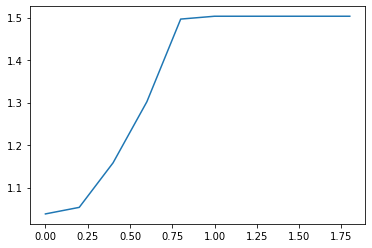

In [123]:
plt.plot(alpha_grid, wmse_test)

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [    0     1     2 ... 17847 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17343.963285234517, tolerance: 4.761018983228135
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.0437097325063787 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0320274617495415 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5084857885756024
test sizes =  1785 1785 1785


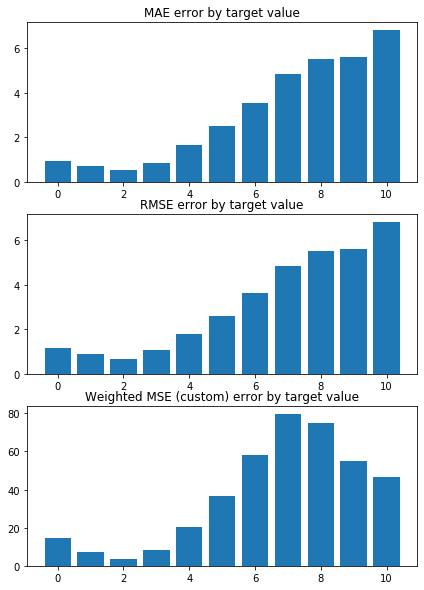

train_index= [    0     1     3 ... 17847 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17251.1151947998, tolerance: 4.749698079840649
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.024221798877296 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0370231154874336 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


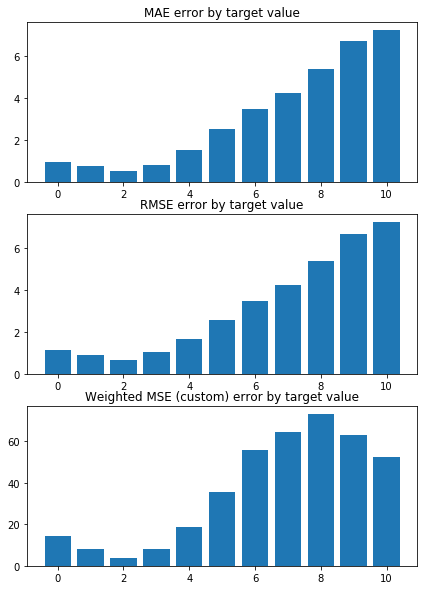

train_index= [    1     2     3 ... 17847 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17261.571509771482, tolerance: 4.743536101080611
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.0165041246737805 


 TRAIN PREDICTION Error
weighted_mse_train: 1.036992985686316 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


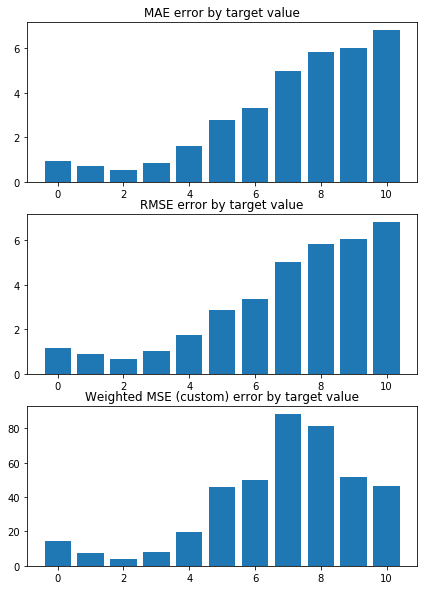

train_index= [    0     1     2 ... 17847 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17549.002294879214, tolerance: 4.82725716737006
  positive)


 TEST PREDICTION Error
weighted_mse_test: 0.9695495949794637 


 TRAIN PREDICTION Error
weighted_mse_train: 1.047645683953828 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


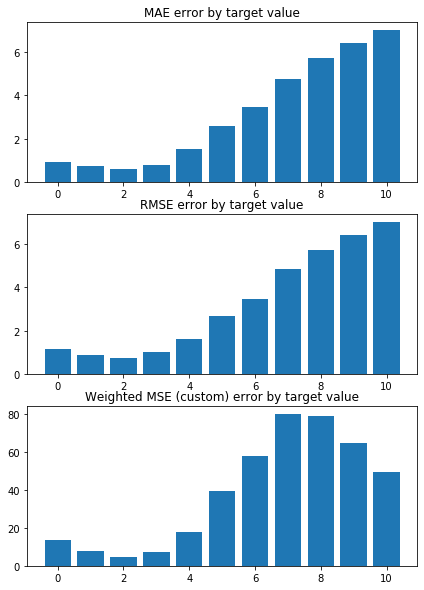

train_index= [    0     1     2 ... 17847 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17181.802074120867, tolerance: 4.739731556616248
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.0469371225008475 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0341434282577262 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


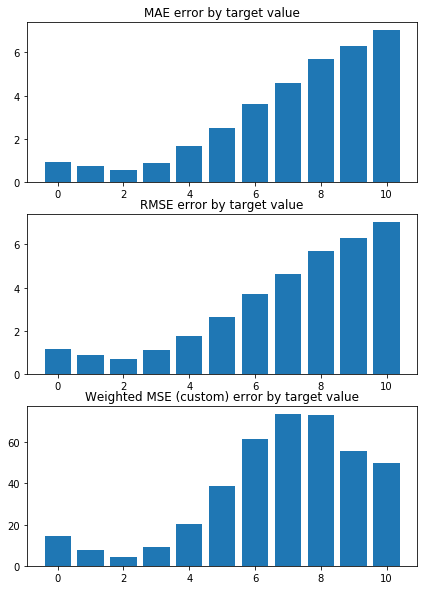

train_index= [    0     1     2 ... 17847 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17208.470311860438, tolerance: 4.751966749714286
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.107819319353757 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0292798397911658 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


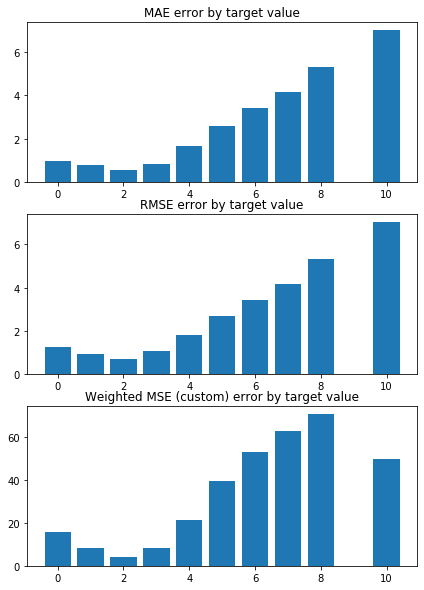

train_index= [    0     1     2 ... 17846 17847 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17253.398860031244, tolerance: 4.75829948389916
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.0915519261875652 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0303663364147677 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


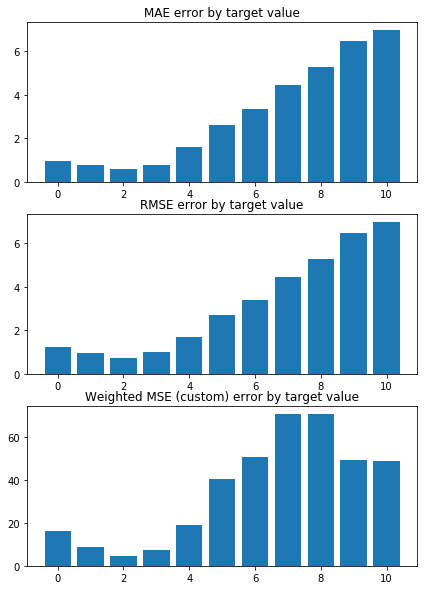

train_index= [    0     2     3 ... 17847 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17082.833209391378, tolerance: 4.716349585894802
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.0679241454429638 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0308405184089124 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


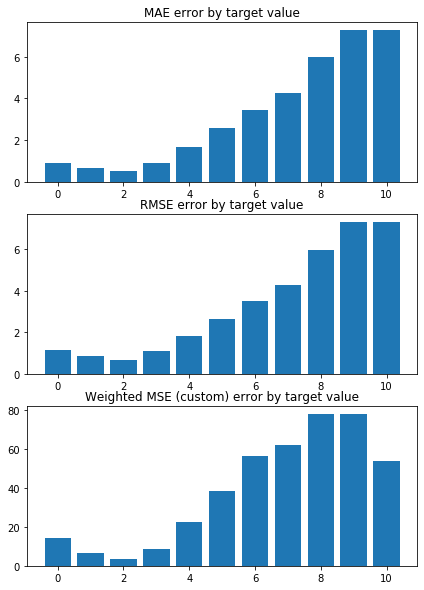

train_index= [    0     1     2 ... 17843 17847 17848]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17360.808974523043, tolerance: 4.765458300587612
  positive)


 TEST PREDICTION Error
weighted_mse_test: 0.9798945861177362 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0409091336987037 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


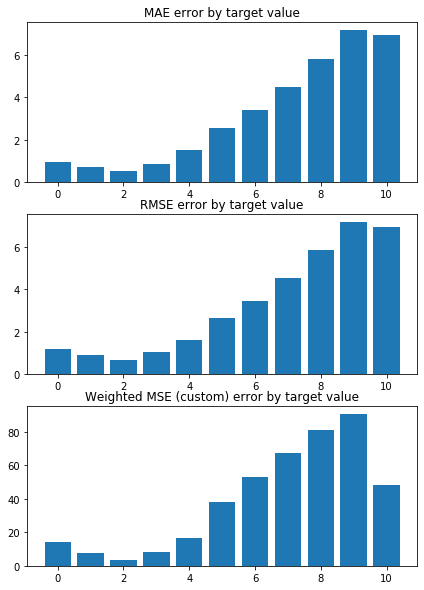

train_index= [    0     1     2 ... 17846 17848 17849]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17043.92771142301, tolerance: 4.716787758316839
  positive)


 TEST PREDICTION Error
weighted_mse_test: 1.0339759558067776 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0364340768165312 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


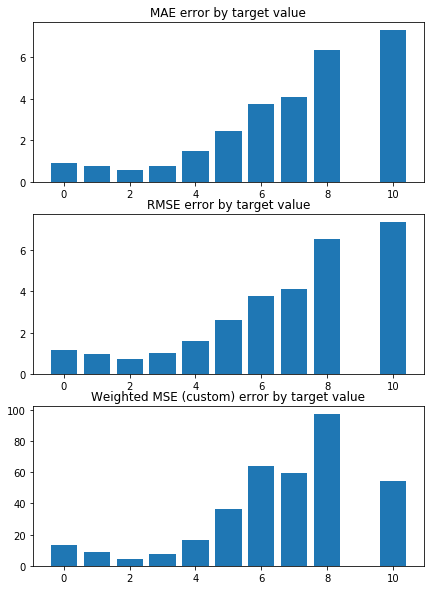

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.147984978848864 

Mean squared error on Test: 1.04 
 MSE mean test:  2.1528730514156917 

Root of MSE on Test: 1.02 
 1.4672672051864621 

Variance score on Test: 0.04 
 r2_test: 0.2725605511620611 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.15
MSE_test 2.15
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32     is_bg  H3K36me1  \
0 -0.380469 -0.325661 -0.237559 -0.167865 -0.152292  0.141897 -0.135761   
1 -0.388096 -0.327093 -0.250428 -0.164091 -0.145425  0.143241 -0.121414   
2 -0.384774 -0.329693 -0.246946 -0.168286 -0.155022  0.141818 -0.139131   
3 -0.380372 -0.343528 -0.254161 -0.162013 -0.145745  0.148820 -0.137026   
4 -0.379115 -0.332625 -0.256548 -0.175836 -0.143108  0.150126 -0.130677   
5 -0.375486 -0.331523 -0.256608 -0.163763 -0.143545  0.146003 -0.130548   
6 -0.374350 -0.333865 -0.258751 -0.159877 -0.153497  0.147884 -0.121470   
7 -0.381371 -0.330876 -0.230451 -0.

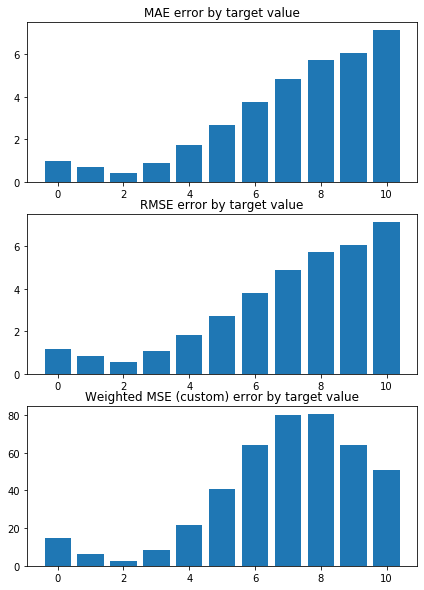

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0261506132886689 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0287399358144493 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


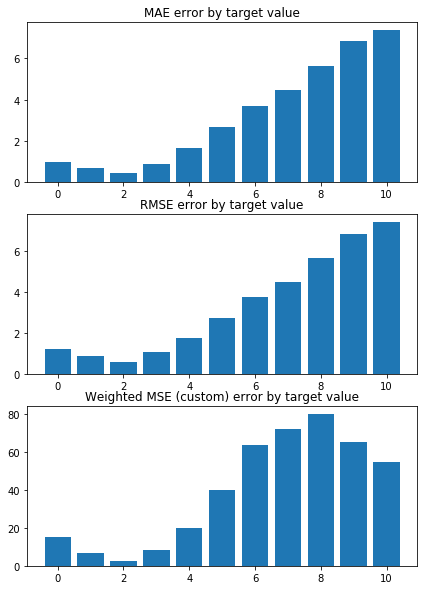

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0100558275396465 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0319548295174839 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


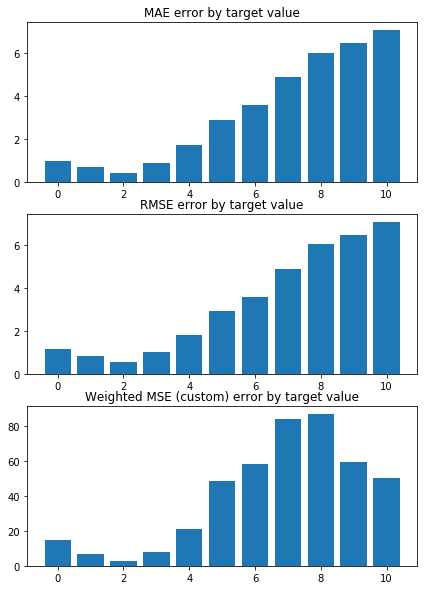

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9590215577509201 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0396253206871202 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


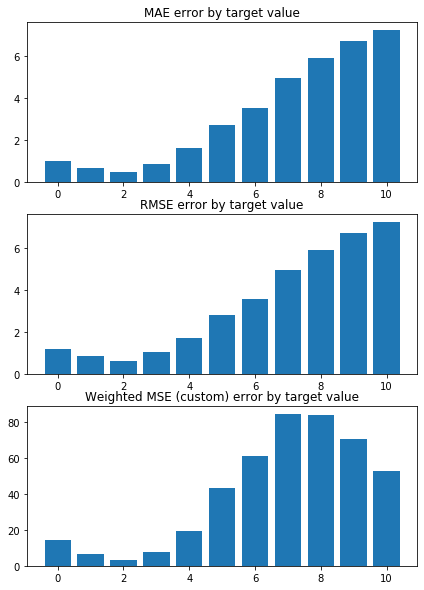

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0342599486228767 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0269004567814135 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


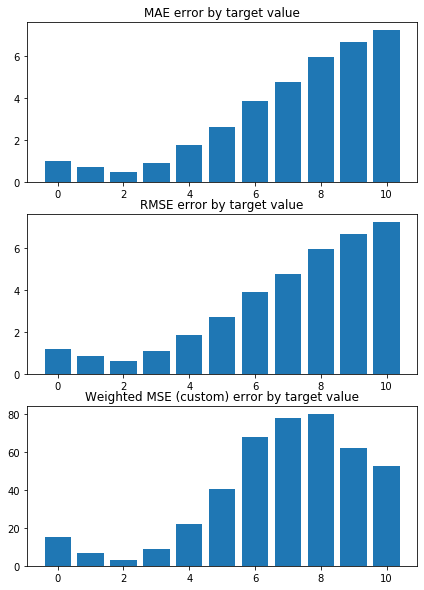

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0956859810547568 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0232720516953444 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


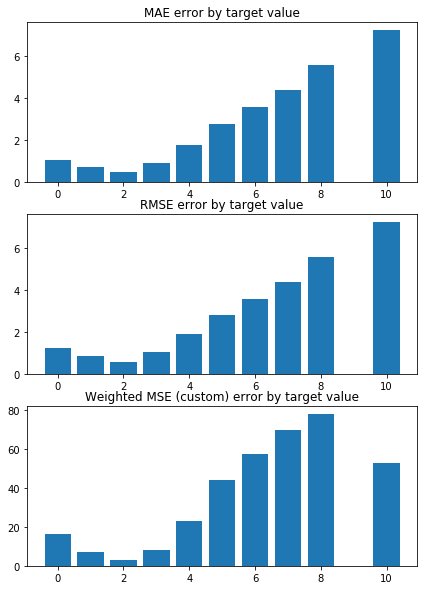

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.075107028003704 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0238943586704201 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


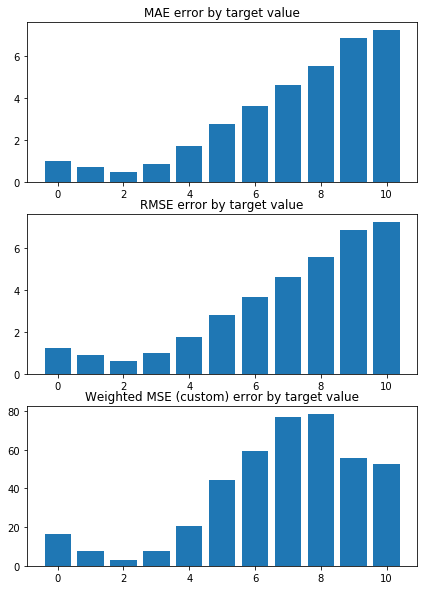

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0565088556748239 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0238999384581795 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


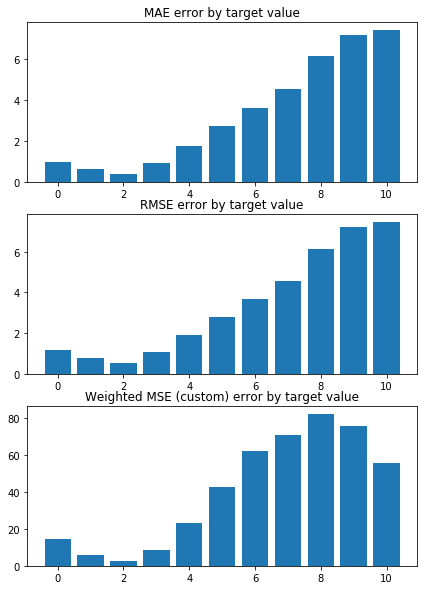

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.9796126633209792 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0336741297878163 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


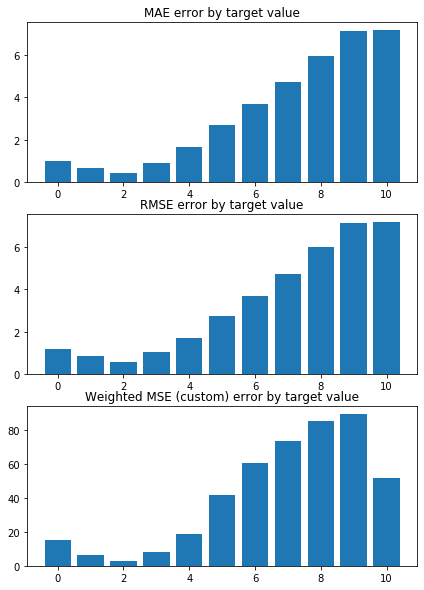

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0250360264969032 


 TRAIN PREDICTION Error
weighted_mse_train: 1.029226839225675 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


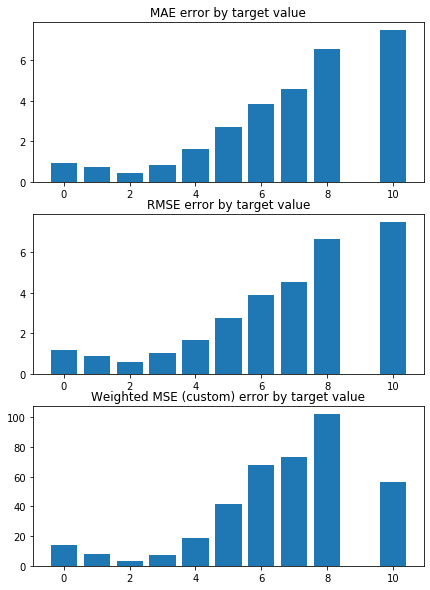

Weighted Mean squared error on Train: 1.03 
 MSE mean train: 2.199492588135393 

Mean squared error on Test: 1.03 
 MSE mean test:  2.2014287571070397 

Root of MSE on Test: 1.01 
 1.4837212531695567 

Variance score on Test: 0.04 
 r2_test: 0.2561481570249135 

wMSE_train 1.03
wMSE_test 1.03
MSE_train 2.2
MSE_test 2.2
MAE_train 0.99
MAE_test 1.0
r2_test 0.26
    H3K4me1  H3K36me3     Chriz   BEAF-32       GAF   H3K4me3  start_coord  \
0 -0.319946 -0.243856 -0.210890 -0.060509 -0.041490 -0.035781    -0.016427   
1 -0.316677 -0.242651 -0.217732 -0.056277 -0.043118 -0.026567    -0.019222   
2 -0.329459 -0.248953 -0.212406 -0.060499 -0.042697 -0.022961    -0.006931   
3 -0.323021 -0.234664 -0.229472 -0.054140 -0.040165 -0.024944    -0.008470   
4 -0.321594 -0.248226 -0.221274 -0.060216 -0.050118 -0.023540    -0.018912   
5 -0.327952 -0.242942 -0.214756 -0.056514 -0.042166 -0.026481    -0.016391   
6 -0.320470 -0.241071 -0.223304 -0.060184 -0.037428 -0.031702    -0.017710   
7 -0.316415 -0

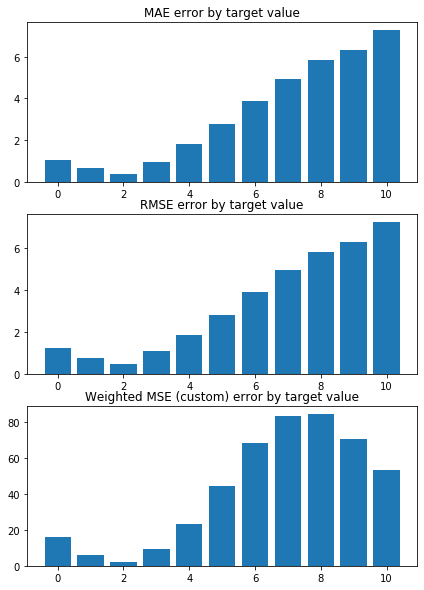

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0563141811602366 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0524461950380712 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


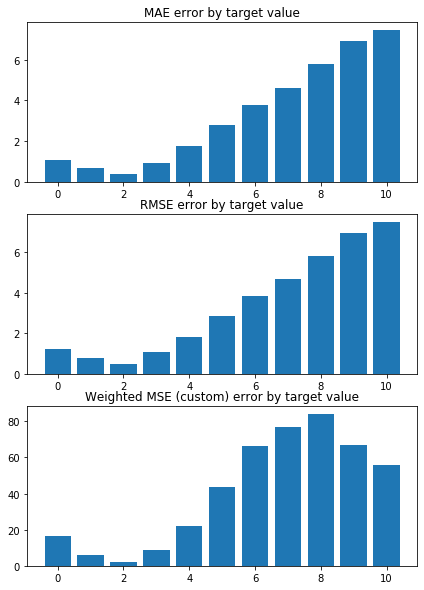

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0315414251538018 


 TRAIN PREDICTION Error
weighted_mse_train: 1.056832101880037 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


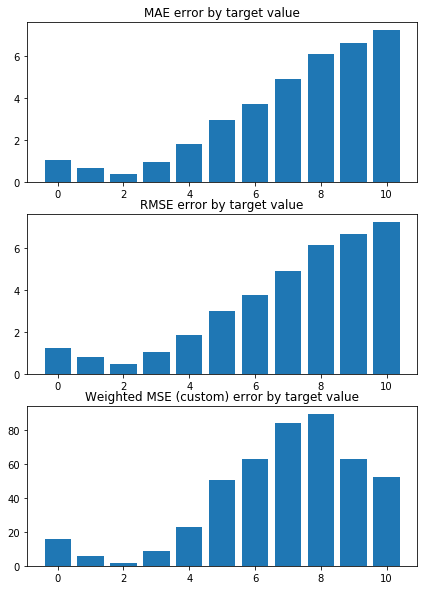

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9836101852246056 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0629419623726337 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


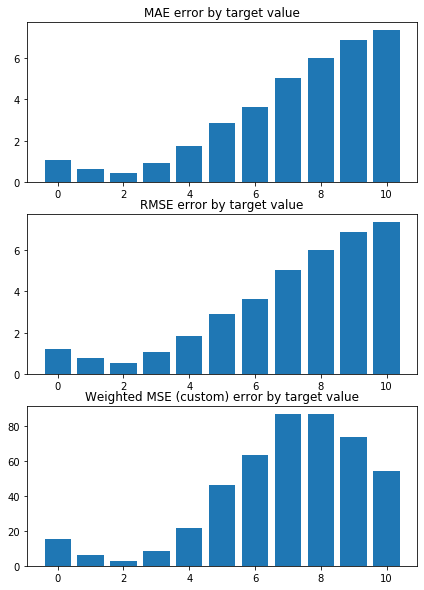

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.054619812410748 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0529544548071534 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


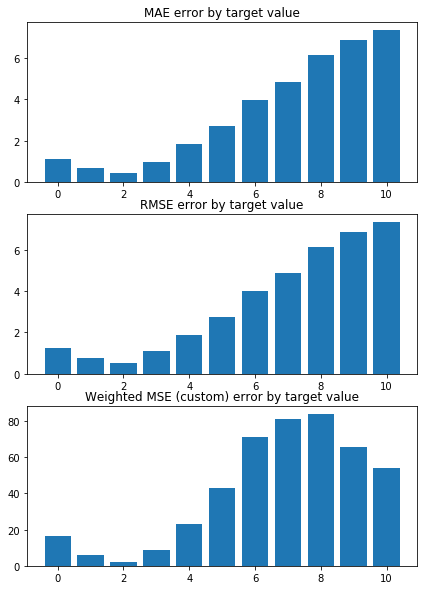

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1124379627059187 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0478737426679432 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


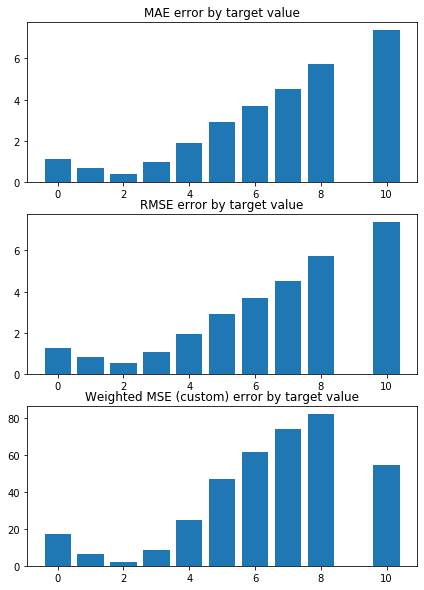

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0933697963110494 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0485747989838958 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


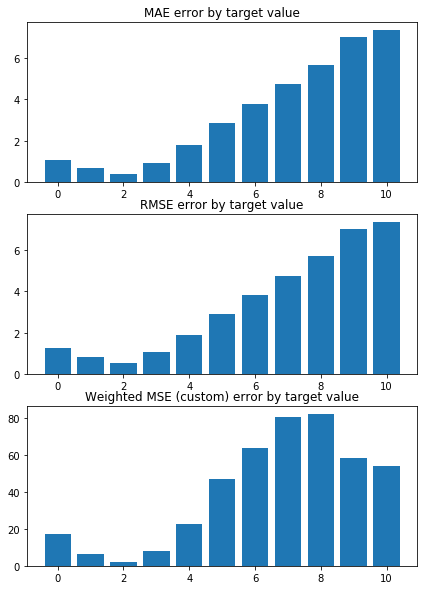

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0884166275539162 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0477856644450776 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


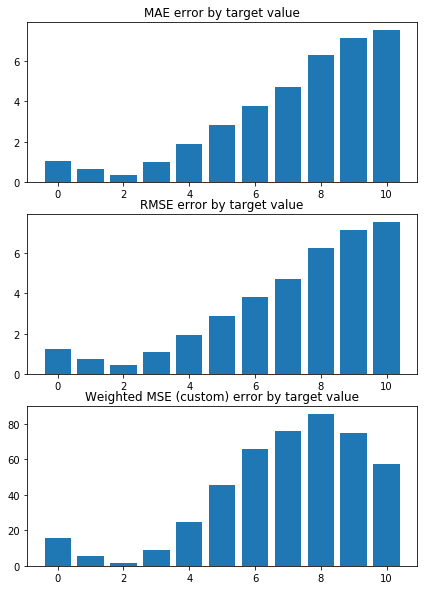

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.0084473136785461 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0580632538084915 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


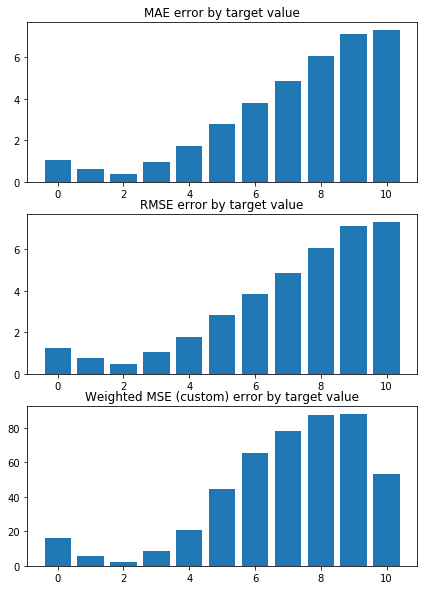

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0486547291207897 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0525017006246267 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


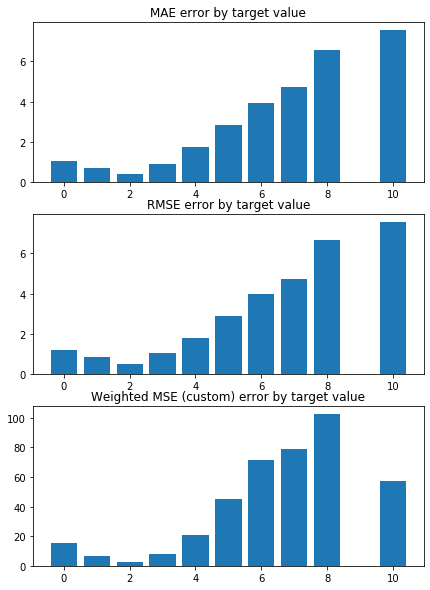

Weighted Mean squared error on Train: 1.05 
 MSE mean train: 2.2635742125367186 

Mean squared error on Test: 1.05 
 MSE mean test:  2.2644001353295873 

Root of MSE on Test: 1.03 
 1.5047923894443338 

Variance score on Test: 0.04 
 r2_test: 0.23482729250362522 

wMSE_train 1.05
wMSE_test 1.05
MSE_train 2.26
MSE_test 2.26
MAE_train 1.01
MAE_test 1.03
r2_test 0.23
    H3K4me1   H3K4me2     Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  \
0 -0.229884 -0.172255 -0.169405 -0.162280      -0.0       0.0      -0.0   
1 -0.226619 -0.176549 -0.173414 -0.159670      -0.0       0.0      -0.0   
2 -0.241550 -0.158712 -0.167476 -0.166853      -0.0       0.0      -0.0   
3 -0.232867 -0.172500 -0.186451 -0.151083      -0.0       0.0      -0.0   
4 -0.239023 -0.157393 -0.175539 -0.165219      -0.0       0.0      -0.0   
5 -0.239123 -0.171076 -0.170792 -0.160146      -0.0       0.0      -0.0   
6 -0.229903 -0.169822 -0.180221 -0.159583      -0.0       0.0      -0.0   
7 -0.227361 -0.177050 -0.171598 -

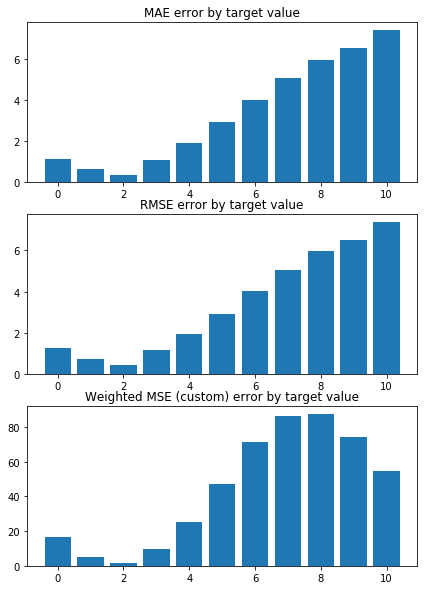

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.100975669263001 


 TRAIN PREDICTION Error
weighted_mse_train: 1.092063064581766 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


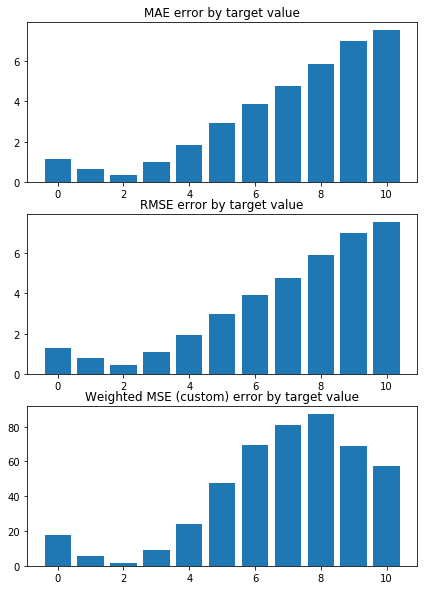

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0691418201942373 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0972230365367854 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


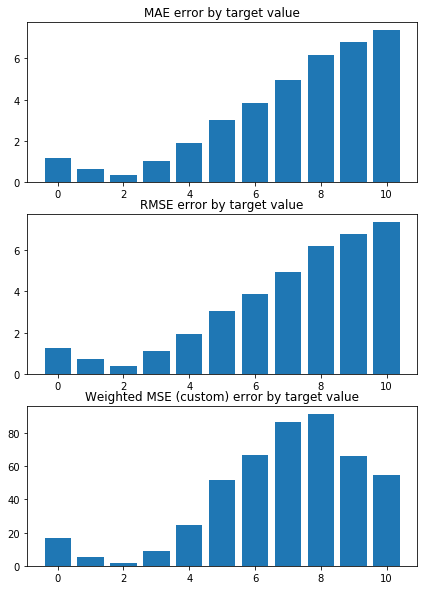

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0223469562369756 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1020872739472476 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


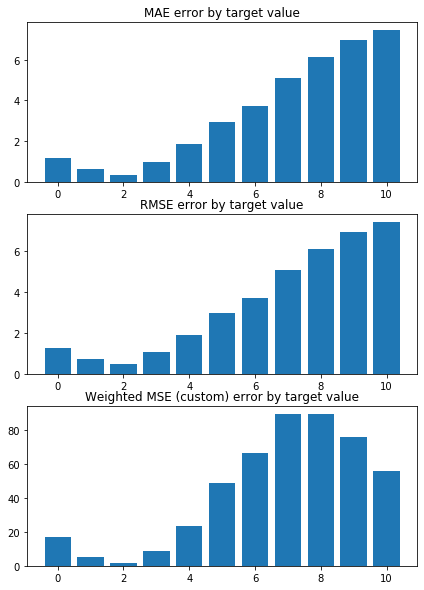

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.091527894911351 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0929486766130614 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


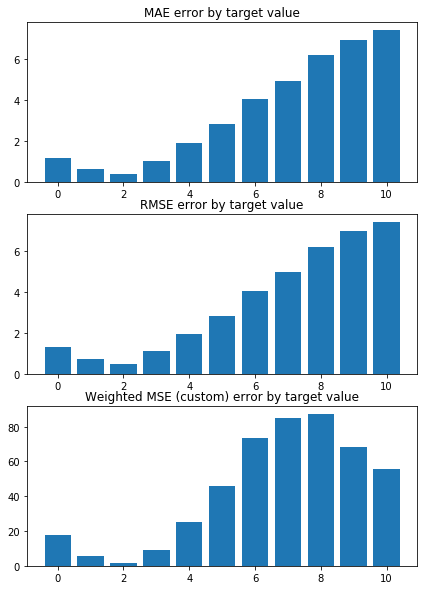

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1465112215877353 


 TRAIN PREDICTION Error
weighted_mse_train: 1.087974490845797 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


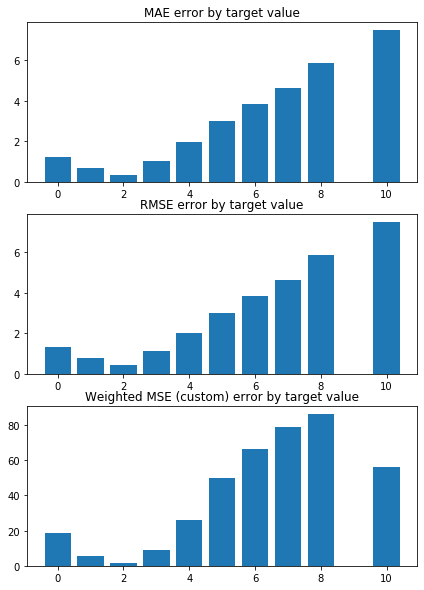

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1282130587269545 


 TRAIN PREDICTION Error
weighted_mse_train: 1.088280298575001 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


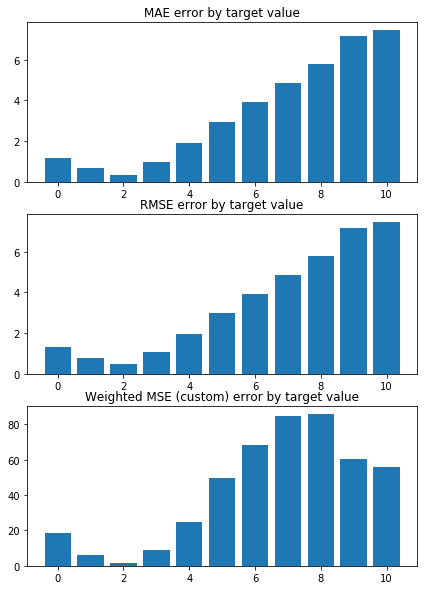

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1362356796269966 


 TRAIN PREDICTION Error
weighted_mse_train: 1.087009370280117 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


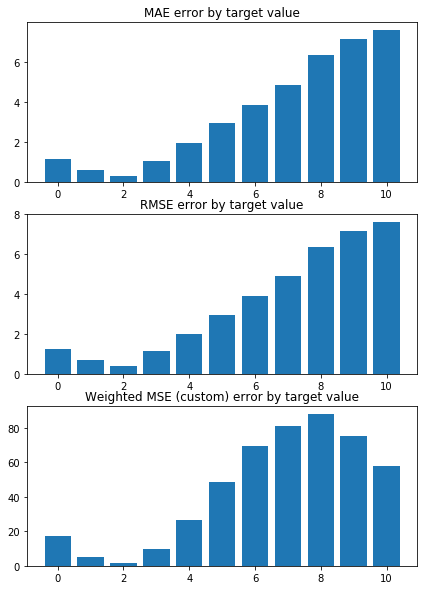

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.0499281323653855 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0976817974050475 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


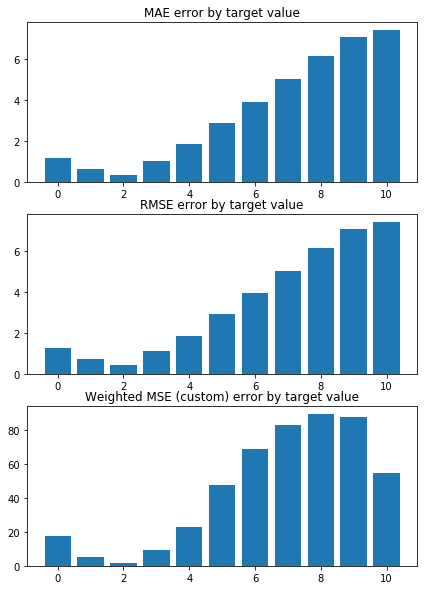

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0901322212826934 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0915770963882958 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


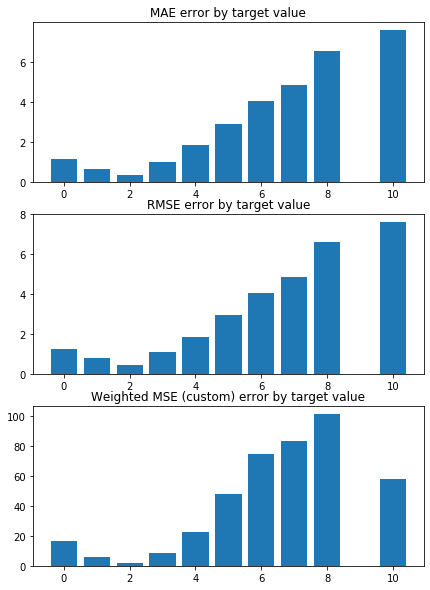

Weighted Mean squared error on Train: 1.09 
 MSE mean train: 2.3406564907951637 

Mean squared error on Test: 1.09 
 MSE mean test:  2.341537795149404 

Root of MSE on Test: 1.05 
 1.5302084155922695 

Variance score on Test: 0.04 
 r2_test: 0.20870624969269116 

wMSE_train 1.09
wMSE_test 1.09
MSE_train 2.34
MSE_test 2.34
MAE_train 1.04
MAE_test 1.06
r2_test 0.21
    H3K4me2   H3K4me1     Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  \
0 -0.251524 -0.121834 -0.112935 -0.093098      -0.0       0.0      -0.0   
1 -0.256589 -0.117814 -0.115650 -0.091328      -0.0       0.0      -0.0   
2 -0.237778 -0.133220 -0.109924 -0.099769      -0.0       0.0      -0.0   
3 -0.250369 -0.125385 -0.131242 -0.081497      -0.0       0.0      -0.0   
4 -0.235848 -0.131568 -0.119031 -0.097200      -0.0       0.0      -0.0   
5 -0.250183 -0.131453 -0.113654 -0.091449      -0.0       0.0      -0.0   
6 -0.248357 -0.122510 -0.124443 -0.090264      -0.0       0.0      -0.0   
7 -0.255799 -0.119740 -0.115081 -0

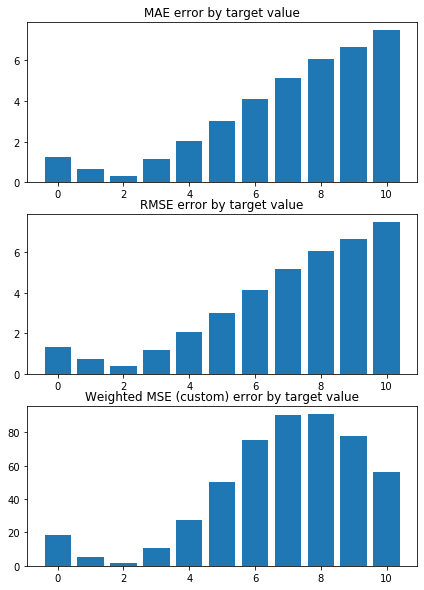

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1722056433108452 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1569526063279543 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


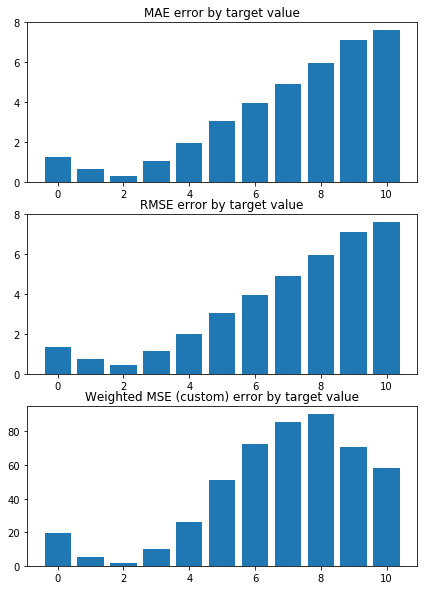

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1314408335720125 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1627328940140245 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


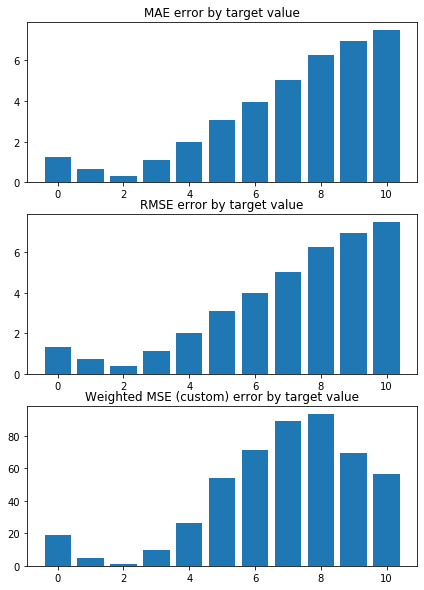

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0869446685258903 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1664325181489776 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


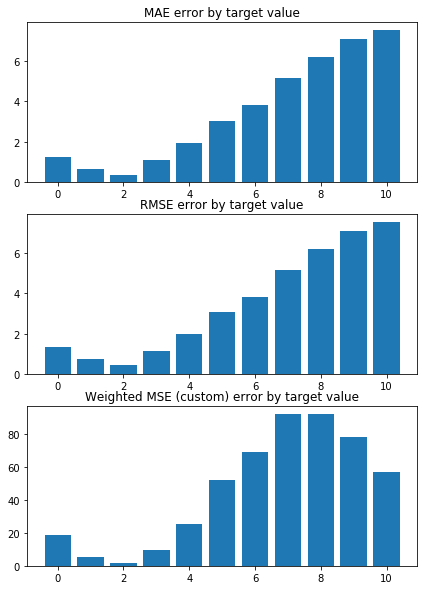

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1523573614662668 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1580342004568511 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


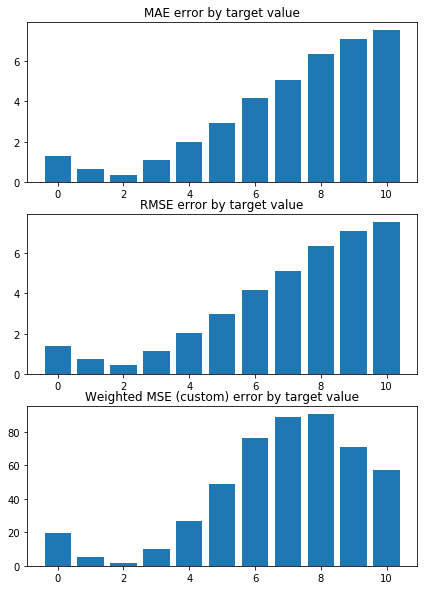

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.2063374814694543 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1532946495351055 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


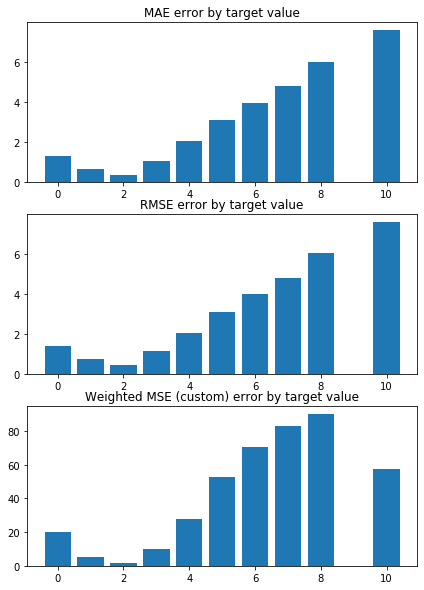

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1879693318024664 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1531066882621204 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


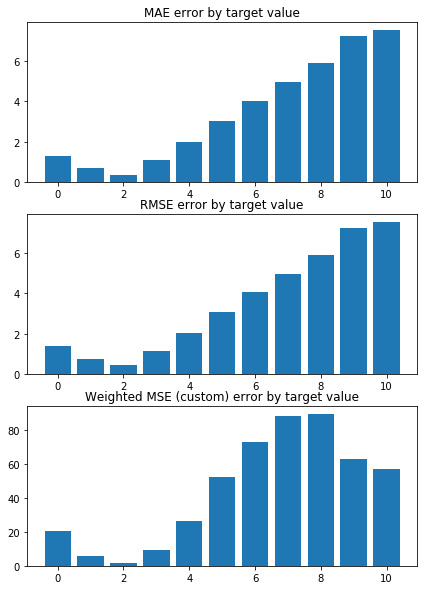

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.2086834700293745 


 TRAIN PREDICTION Error
weighted_mse_train: 1.151385549951421 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


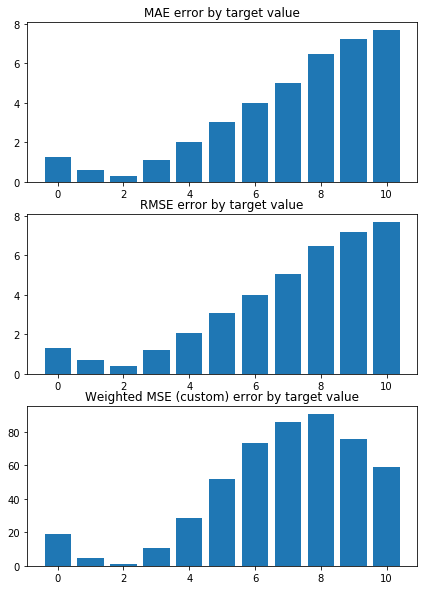

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.1150461491760972 


 TRAIN PREDICTION Error
weighted_mse_train: 1.162365095770671 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


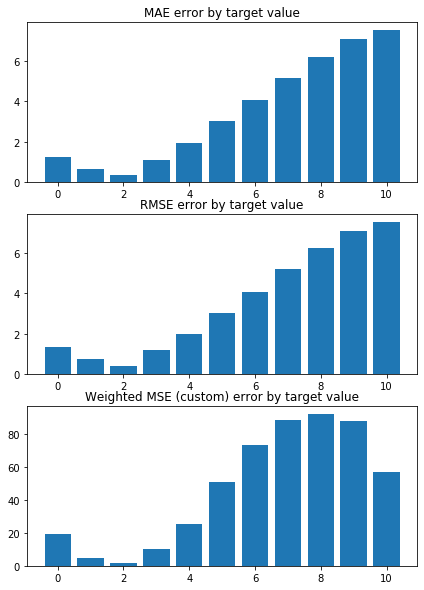

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1582653012712123 


 TRAIN PREDICTION Error
weighted_mse_train: 1.155935097889397 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


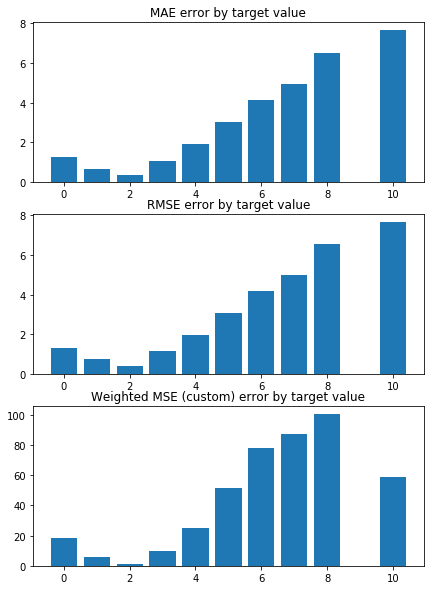

Weighted Mean squared error on Train: 1.16 
 MSE mean train: 2.448568362549515 

Mean squared error on Test: 1.16 
 MSE mean test:  2.4495271657342723 

Root of MSE on Test: 1.08 
 1.565096535595895 

Variance score on Test: 0.04 
 r2_test: 0.17211698638268674 

wMSE_train 1.16
wMSE_test 1.16
MSE_train 2.45
MSE_test 2.45
MAE_train 1.08
MAE_test 1.11
r2_test 0.17
    H3K4me2     Chriz  H3K36me3   H3K4me1  H3K36me1  H3K27me3  H3K27me1  \
0 -0.330756 -0.056487 -0.023915 -0.013810      -0.0       0.0      -0.0   
1 -0.336597 -0.057905 -0.022985 -0.009032      -0.0       0.0      -0.0   
2 -0.316818 -0.052389 -0.032684 -0.024910      -0.0       0.0      -0.0   
3 -0.328228 -0.076039 -0.011911 -0.017909      -0.0       0.0      -0.0   
4 -0.314275 -0.062539 -0.029181 -0.024132      -0.0       0.0      -0.0   
5 -0.329280 -0.056522 -0.022752 -0.023790      -0.0       0.0      -0.0   
6 -0.326855 -0.068685 -0.020944 -0.015143      -0.0       0.0      -0.0   
7 -0.334513 -0.058583 -0.020790 -0.

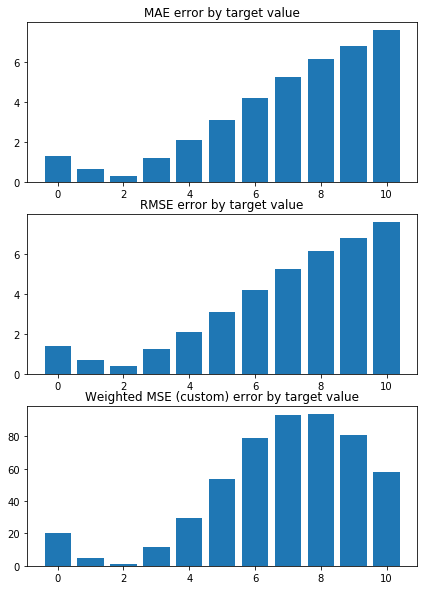

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.2421160145231072 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2252894034824002 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


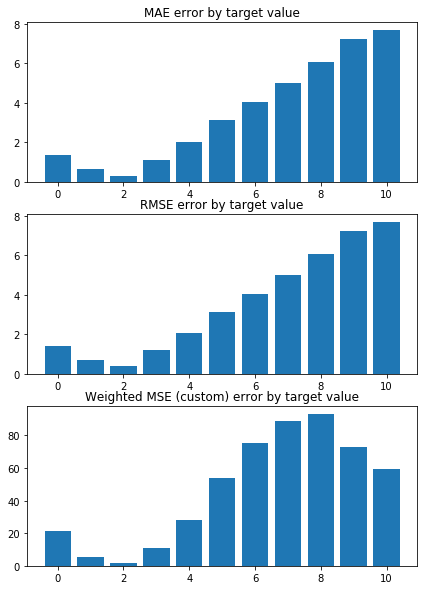

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.2053588688361407 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2348011268193166 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


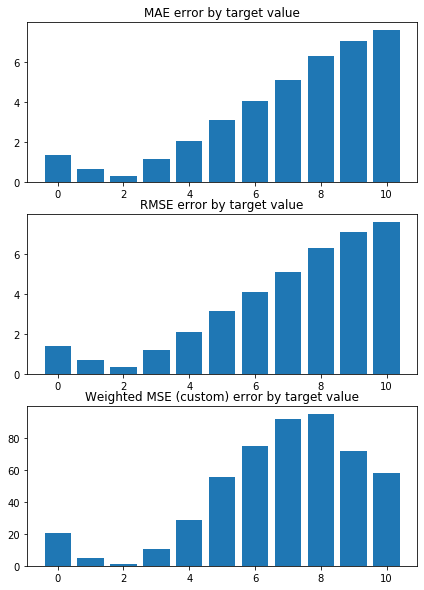

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1499094565601244 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2343670123068304 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


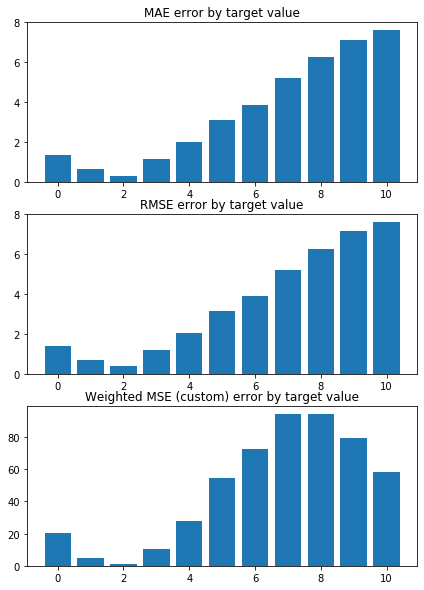

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.2218699530814767 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2293845936164762 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


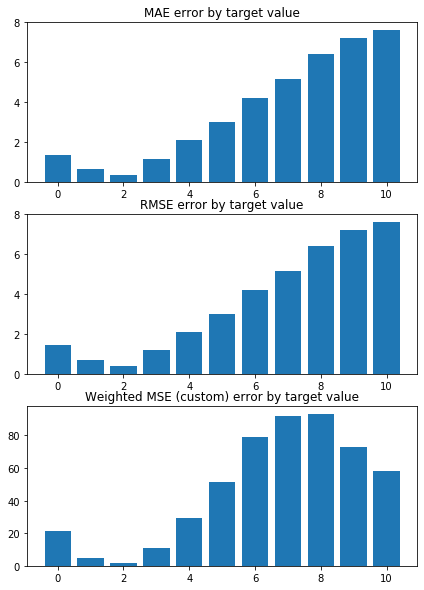

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.2745744825489855 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2239601491912147 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


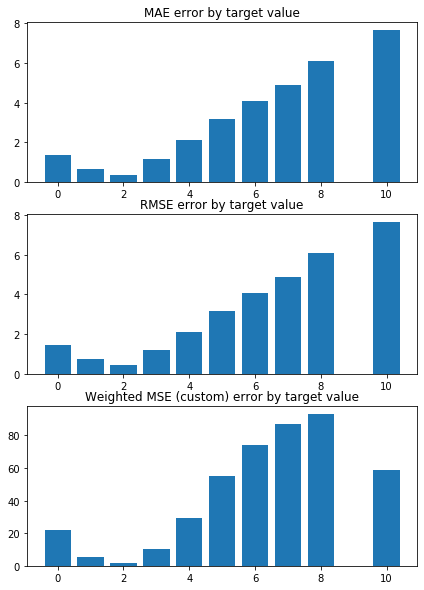

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.2502857925181874 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2219023137293317 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


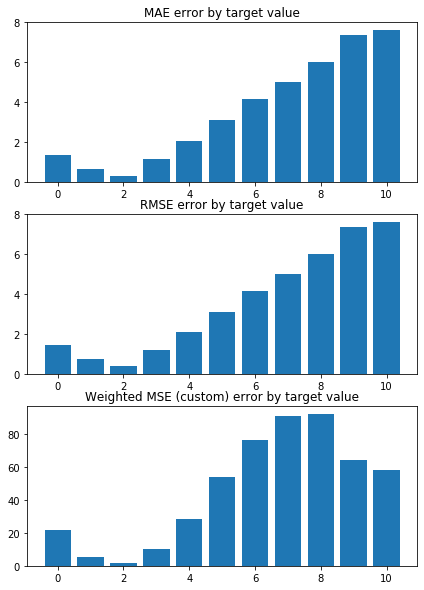

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.281604721305679 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2194103343603455 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


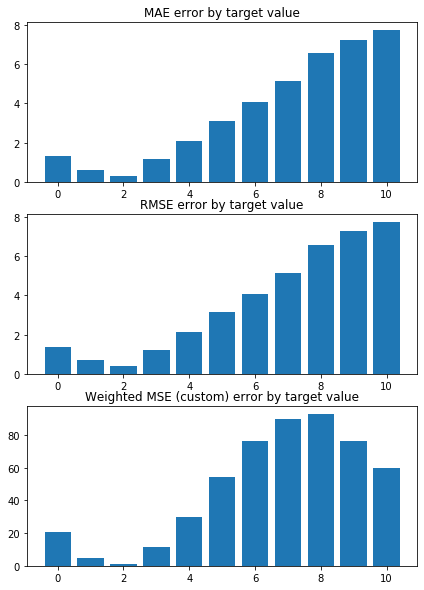

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.1858087218434379 


 TRAIN PREDICTION Error
weighted_mse_train: 1.232233569211427 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


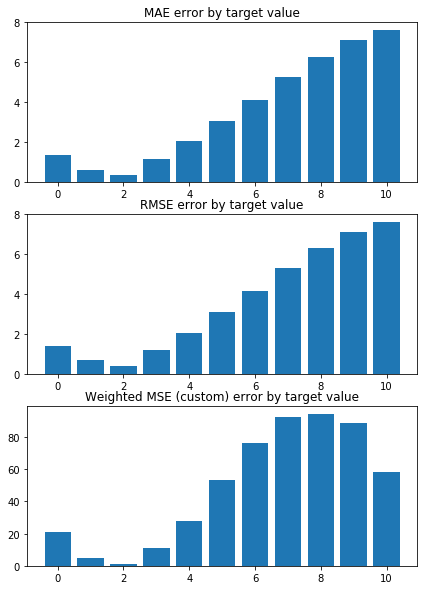

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.232310461375346 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2265078982395412 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


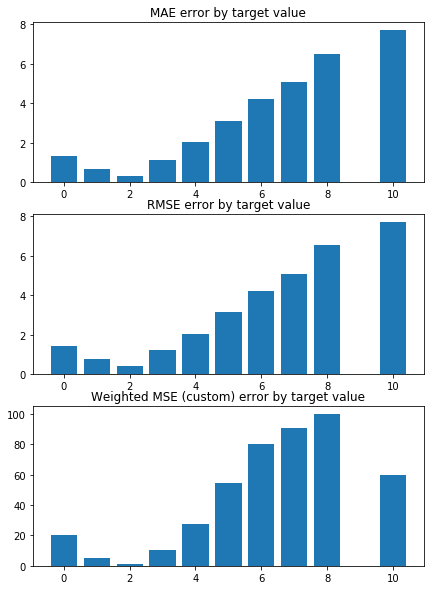

Weighted Mean squared error on Train: 1.23 
 MSE mean train: 2.556534714358425 

Mean squared error on Test: 1.23 
 MSE mean test:  2.557166185726399 

Root of MSE on Test: 1.11 
 1.5991141878322508 

Variance score on Test: 0.04 
 r2_test: 0.13568390808764721 

wMSE_train 1.23
wMSE_test 1.23
MSE_train 2.56
MSE_test 2.56
MAE_train 1.12
MAE_test 1.15
r2_test 0.14
    H3K4me2     Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  \
0 -0.295181 -0.010224      -0.0      -0.0       0.0      -0.0     -0.0   
1 -0.296108 -0.012063      -0.0      -0.0       0.0      -0.0     -0.0   
2 -0.296360 -0.006537      -0.0      -0.0       0.0      -0.0     -0.0   
3 -0.294513 -0.020894      -0.0      -0.0       0.0      -0.0     -0.0   
4 -0.292120 -0.015010      -0.0      -0.0       0.0      -0.0     -0.0   
5 -0.305890 -0.004192      -0.0      -0.0       0.0      -0.0     -0.0   
6 -0.292279 -0.020233      -0.0      -0.0       0.0      -0.0     -0.0   
7 -0.296761 -0.010922      -0.0      -0.0  

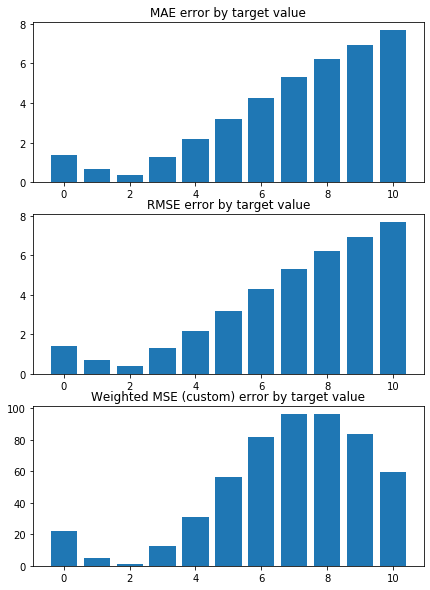

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.3179558143551318 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2996795374081076 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


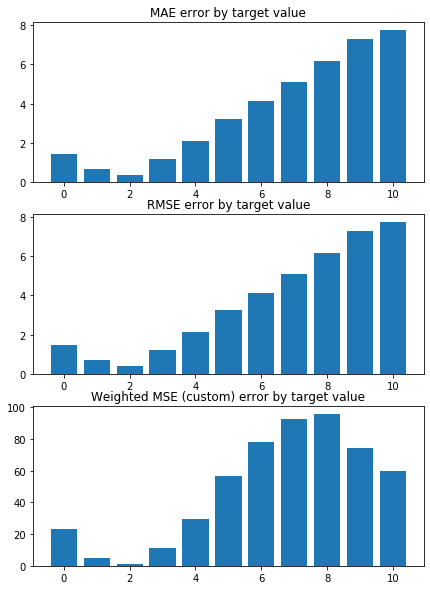

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.2816423632061502 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3080597915401713 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


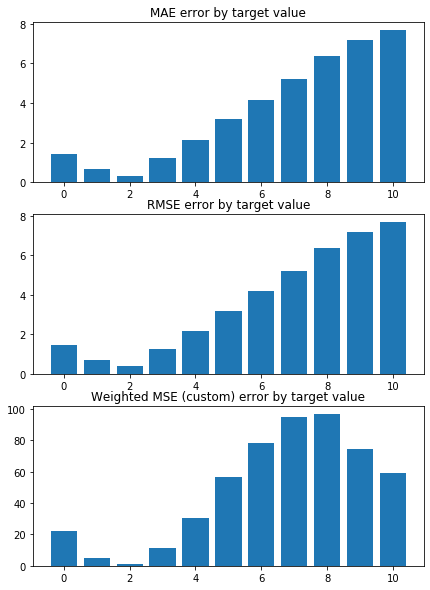

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.221989466869843 


 TRAIN PREDICTION Error
weighted_mse_train: 1.310041162620438 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


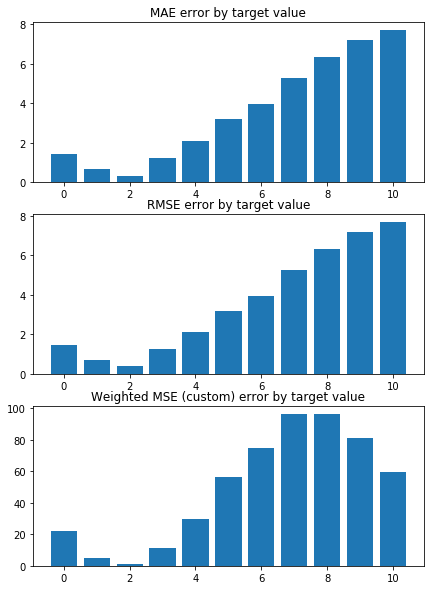

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.2959819621678001 


 TRAIN PREDICTION Error
weighted_mse_train: 1.304291321735832 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


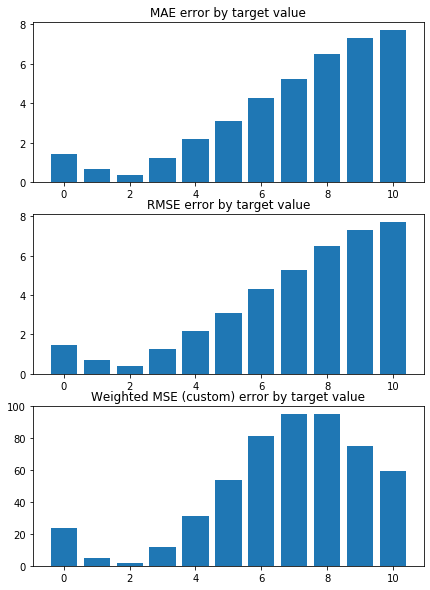

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.3417649022660336 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2965280671585175 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


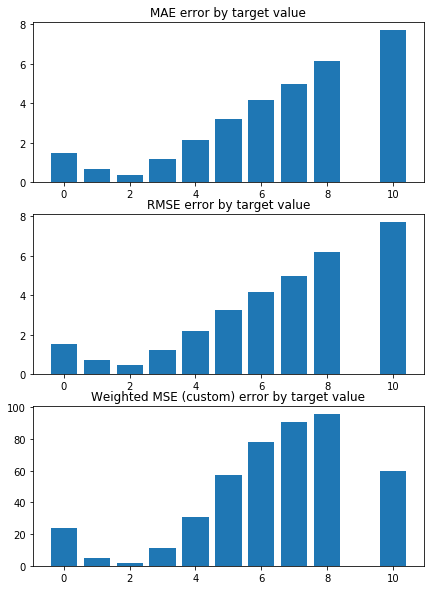

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.3203594679907986 


 TRAIN PREDICTION Error
weighted_mse_train: 1.297943152488397 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


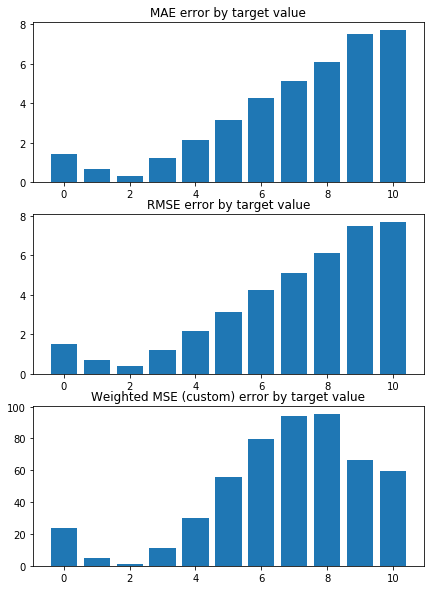

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.3589641481685977 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2930970434165712 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


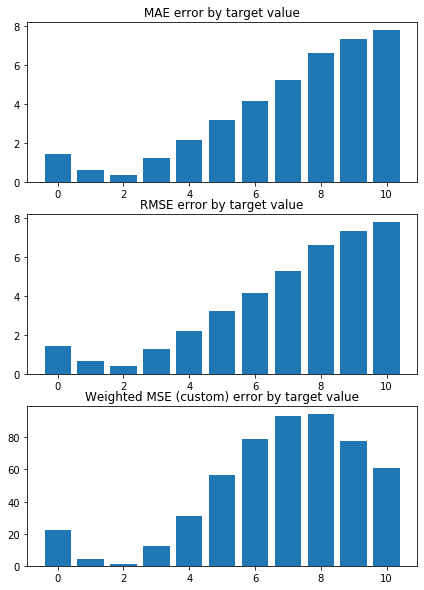

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.2628310108007936 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3073305339108925 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


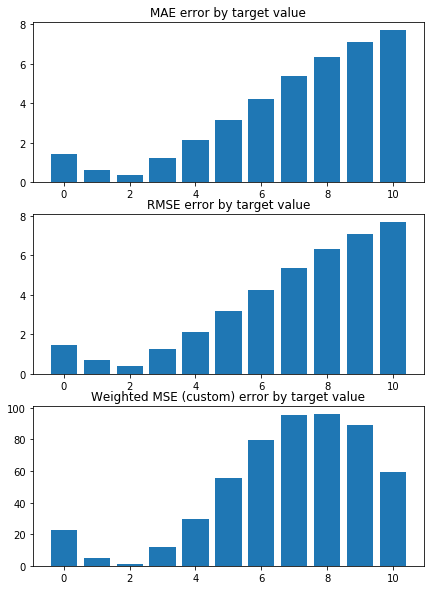

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.3099886137595116 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3003578711258996 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


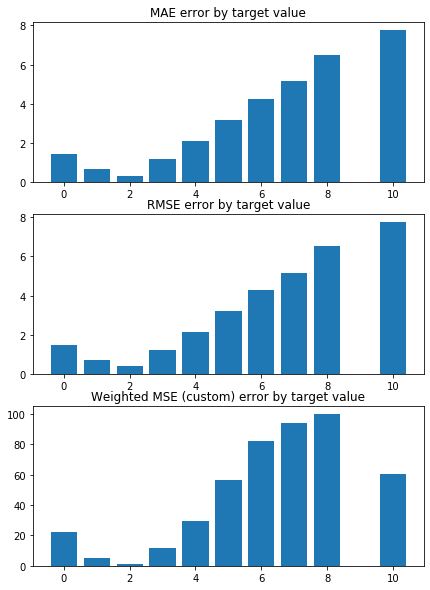

Weighted Mean squared error on Train: 1.30 
 MSE mean train: 2.6691595465804547 

Mean squared error on Test: 1.30 
 MSE mean test:  2.669599525733424 

Root of MSE on Test: 1.14 
 1.6338909161059143 

Variance score on Test: 0.04 
 r2_test: 0.09758706797546943 

wMSE_train 1.3
wMSE_test 1.3
MSE_train 2.67
MSE_test 2.67
MAE_train 1.16
MAE_test 1.19
r2_test 0.1
    H3K4me2  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  \
0 -0.203059      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
1 -0.205448      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
2 -0.201977      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
3 -0.210934      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
4 -0.204468      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
5 -0.209569      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
6 -0.208398      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
7 -0.205496      -0.0      -0.0       0.0      -0.0  

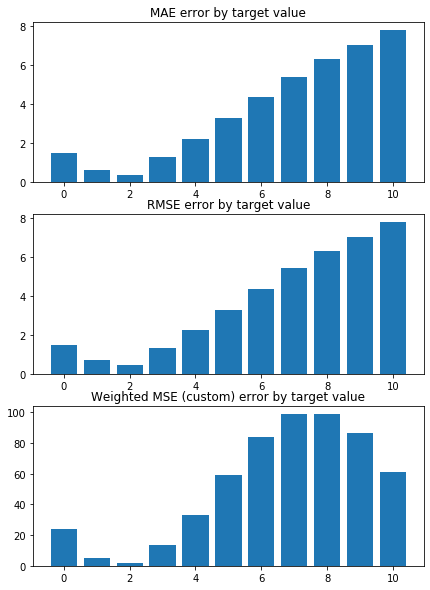

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4086940914019639 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3886341470744687 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


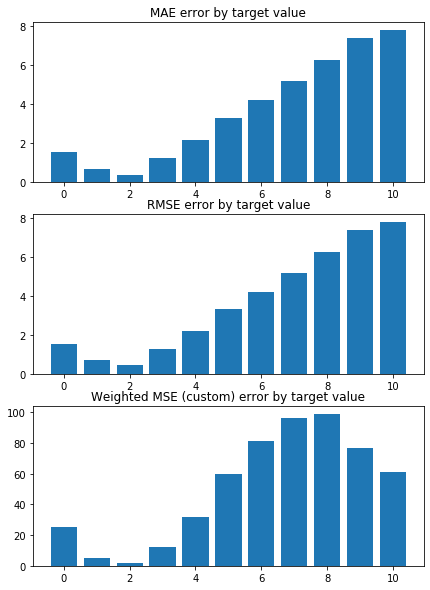

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.3725852931110645 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3967951091789852 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


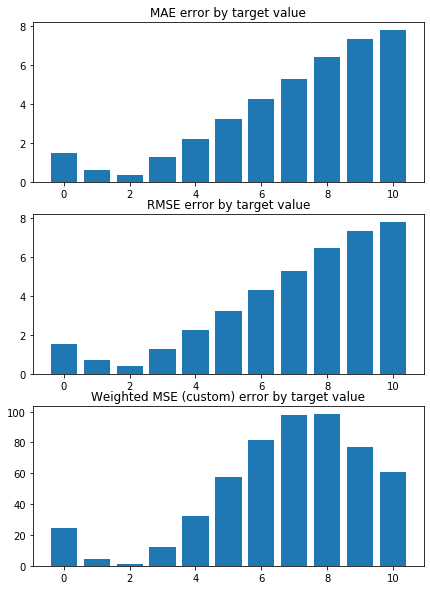

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.3086253483300034 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3984798234077946 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


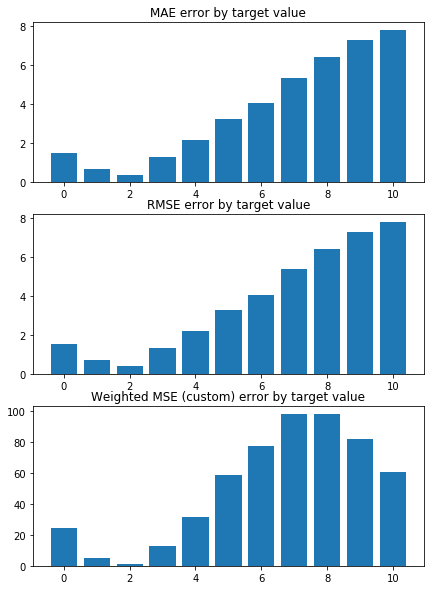

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.3833682246012546 


 TRAIN PREDICTION Error
weighted_mse_train: 1.393040590176329 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


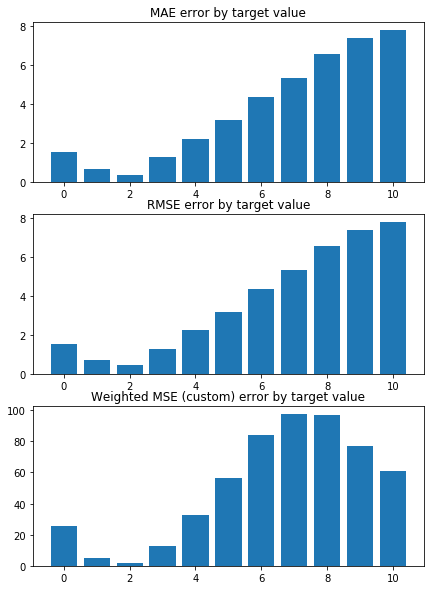

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4240094735500766 


 TRAIN PREDICTION Error
weighted_mse_train: 1.385049310812751 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


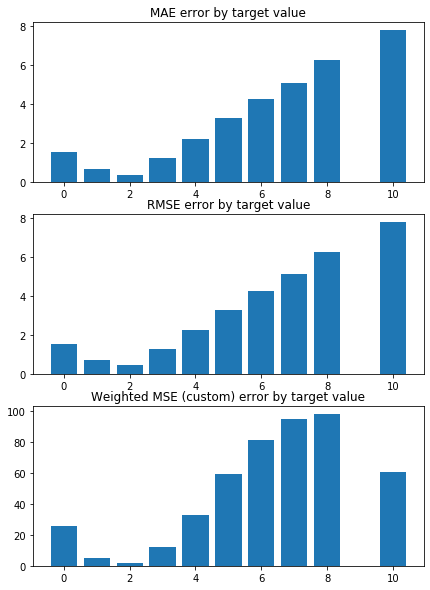

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4041361583783258 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3870165611733363 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


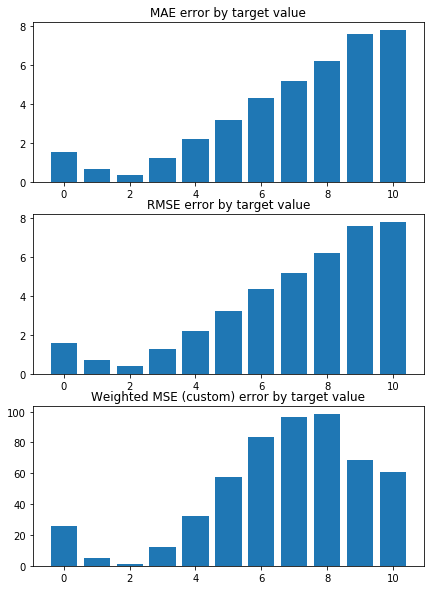

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.450785939006303 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3815202180572668 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


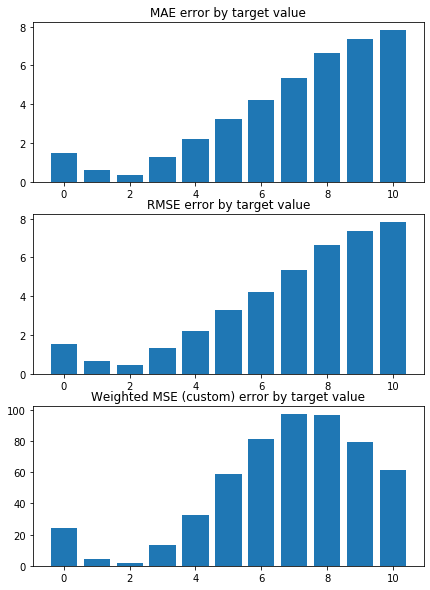

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.3542537108692736 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3963461523126768 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


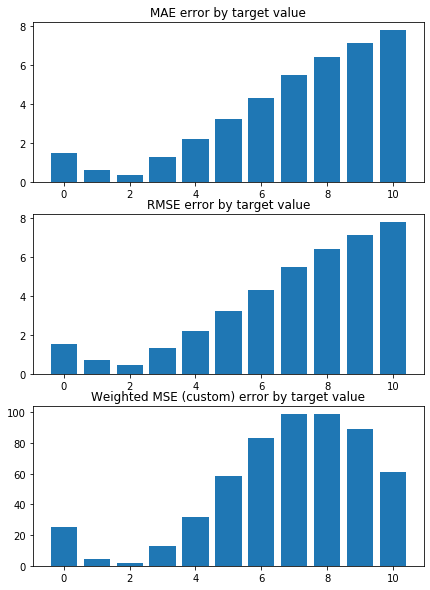

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4027741053697602 


 TRAIN PREDICTION Error
weighted_mse_train: 1.388835595447854 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


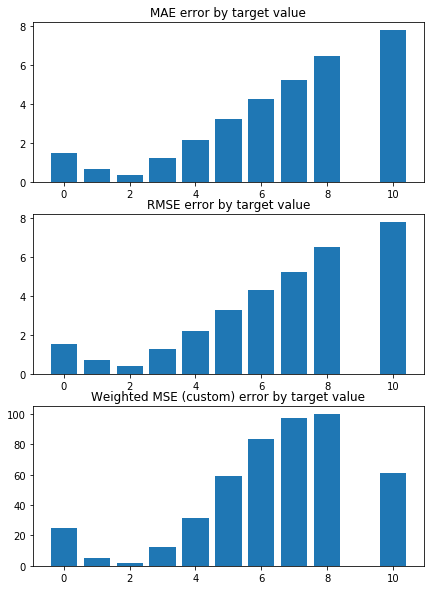

Weighted Mean squared error on Train: 1.39 
 MSE mean train: 2.799160700439915 

Mean squared error on Test: 1.39 
 MSE mean test:  2.79960057692672 

Root of MSE on Test: 1.18 
 1.6732006983403755 

Variance score on Test: 0.04 
 r2_test: 0.05353027760339675 

wMSE_train 1.39
wMSE_test 1.39
MSE_train 2.8
MSE_test 2.8
MAE_train 1.21
MAE_test 1.24
r2_test 0.05
    H3K4me2  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  \
0 -0.102759      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
1 -0.105169      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
2 -0.102382      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
3 -0.110701      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
4 -0.104863      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
5 -0.109922      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
6 -0.108294      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
7 -0.105514      -0.0      -0.0       0.0      -0.0   

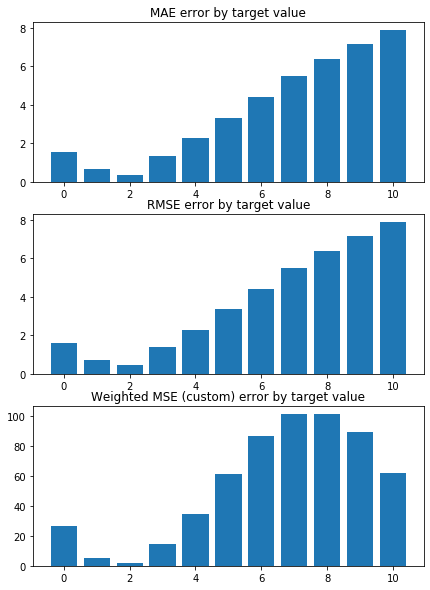

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5166789734210804 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4944529716388983 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


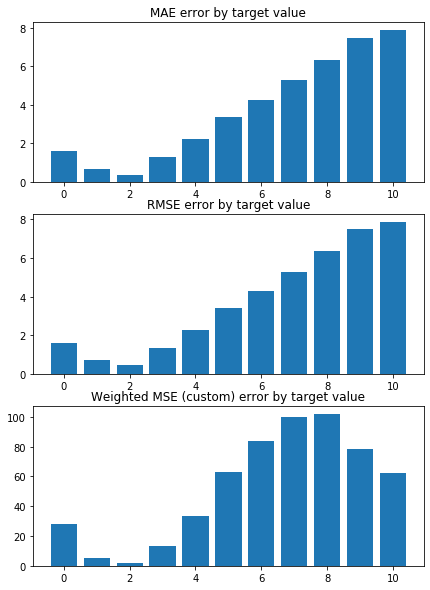

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4796803067909559 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5022532957037449 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


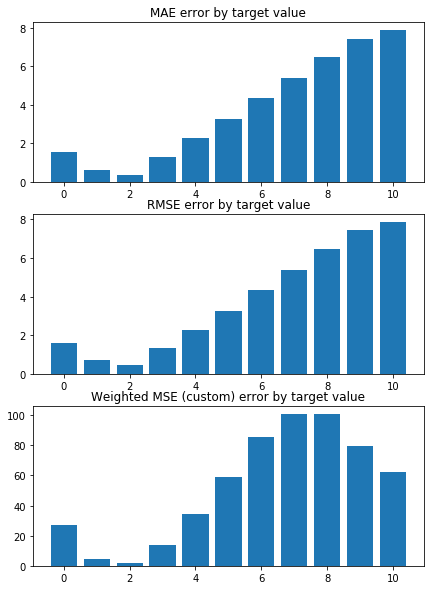

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.412629303209562 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5037507117121243 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


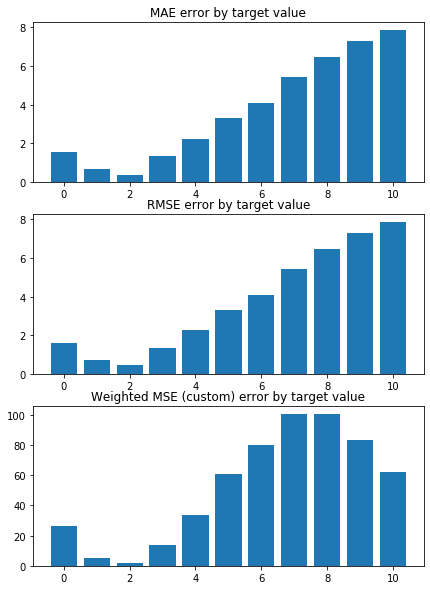

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4868270275237594 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4985291219129366 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


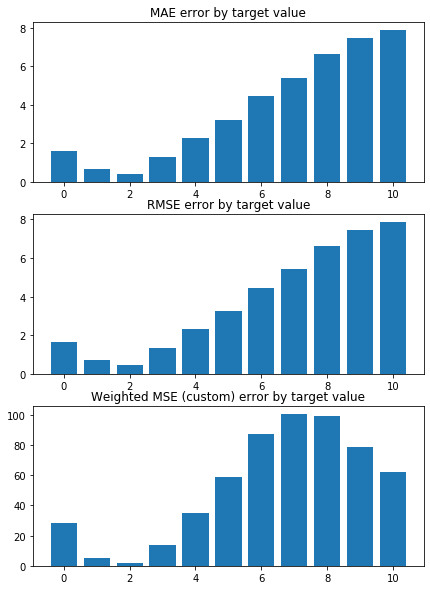

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5223789885110826 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4903227076930015 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


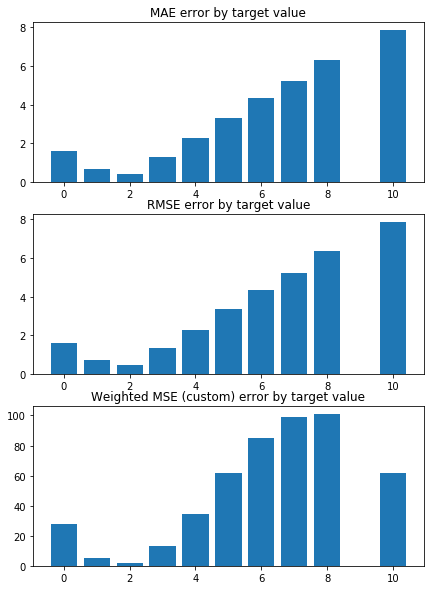

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5049726084415453 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4929127364818582 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


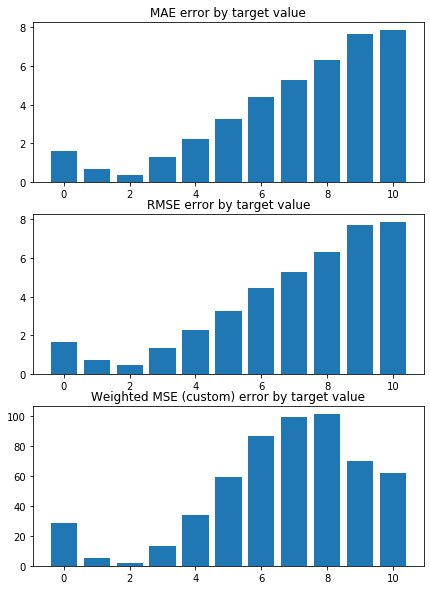

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5592530709445265 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4867621819162706 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


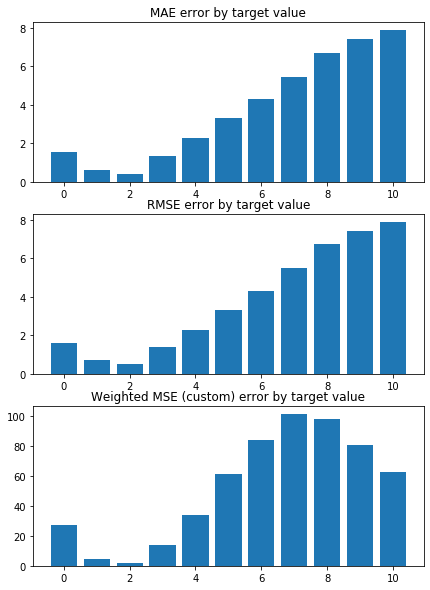

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.4626002498338024 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5021901412392409 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


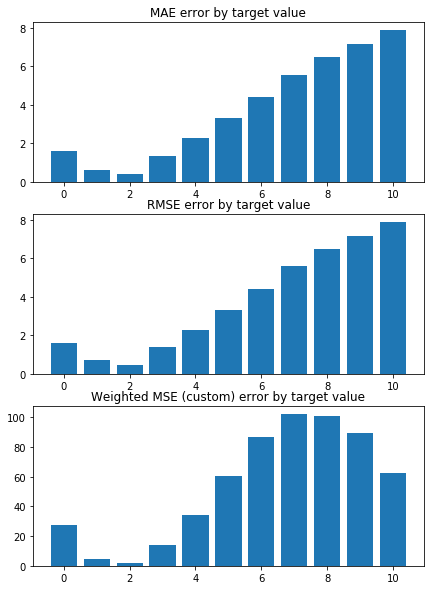

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5127992331648408 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4941369939883602 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


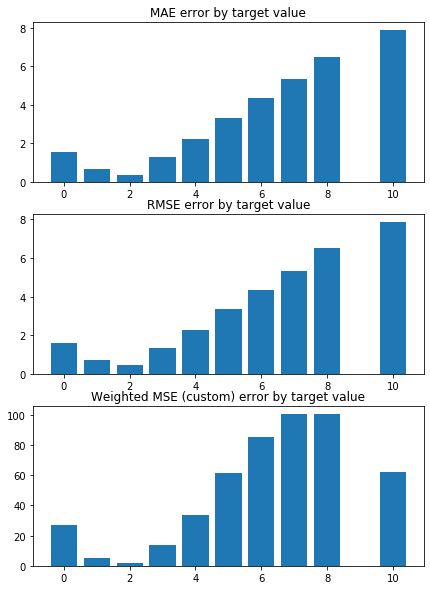

Weighted Mean squared error on Train: 1.50 
 MSE mean train: 2.9491620318162157 

Mean squared error on Test: 1.50 
 MSE mean test:  2.949605353940803 

Root of MSE on Test: 1.22 
 1.7174415139796764 

Variance score on Test: 0.04 
 r2_test: 0.0026825187477259706 

wMSE_train 1.5
wMSE_test 1.5
MSE_train 2.95
MSE_test 2.95
MAE_train 1.25
MAE_test 1.28
r2_test 0.0
    H3K4me2  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  \
0 -0.002459      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
1 -0.004891      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
2 -0.002788      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
3 -0.010468      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
4 -0.005259      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
5 -0.010274      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
6 -0.008189      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
7 -0.005532      -0.0      -0.0       0.0      -0.0

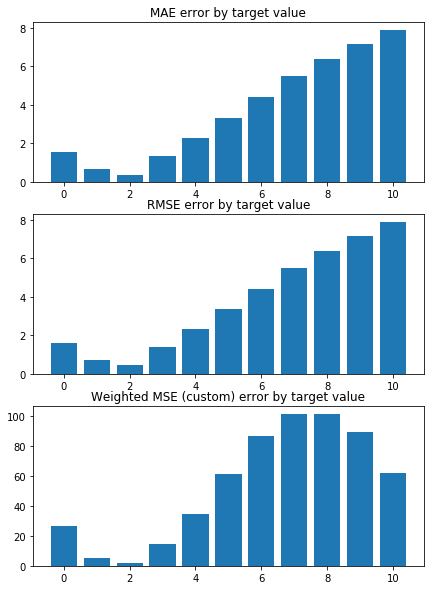

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5223866913238566 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5000452670038045 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


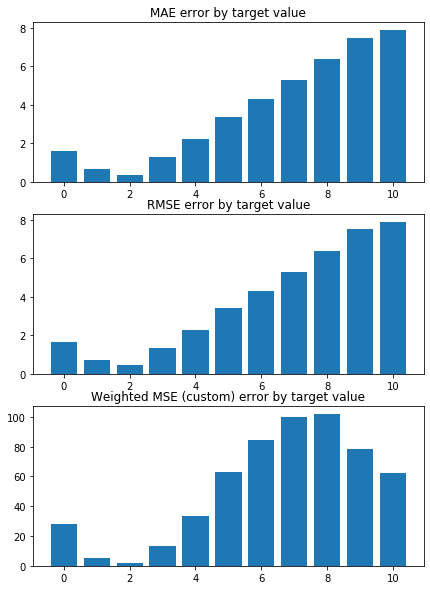

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4829104249189313 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5054458089959184 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


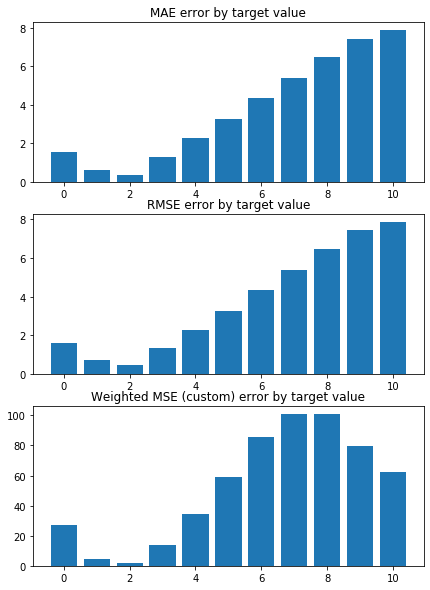

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.4244925388995253 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5157153565133847 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


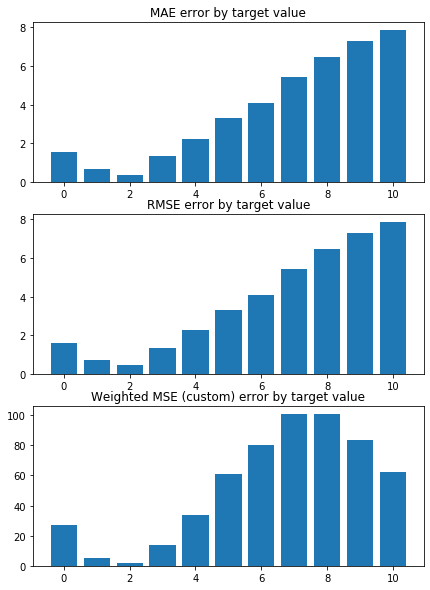

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.492735903069663 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5045636879865436 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


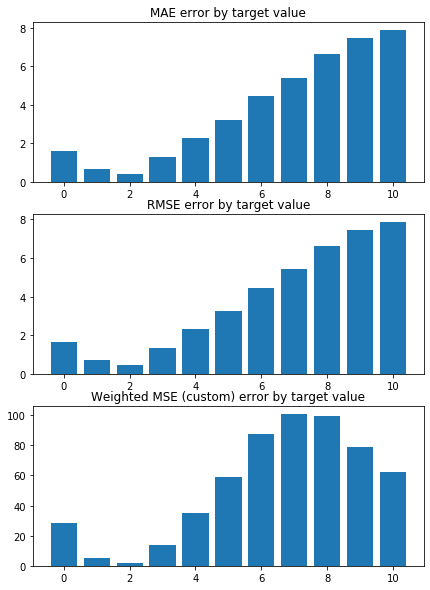

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5334384341949743 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5021296506382618 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


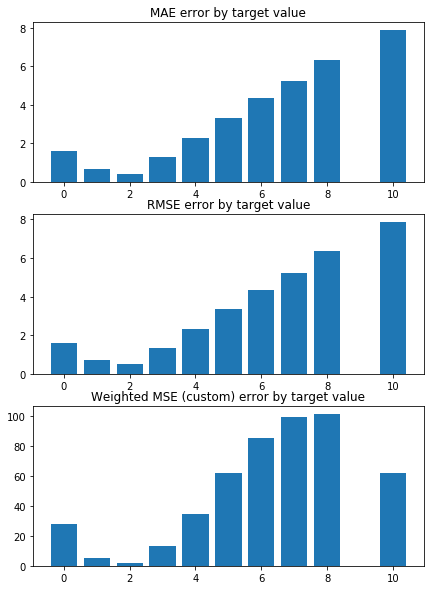

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5139765180356128 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5023200753947654 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


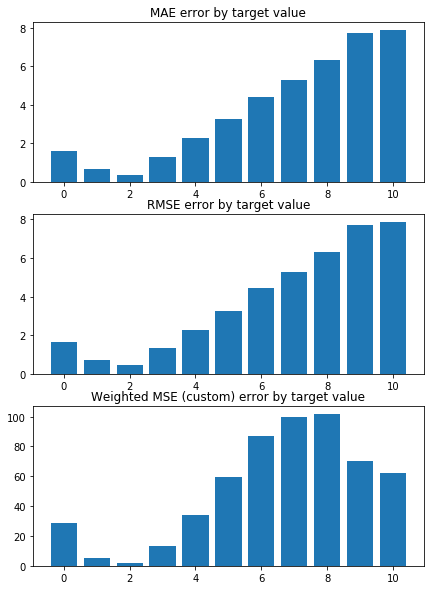

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5657406847615234 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4930764070047973 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


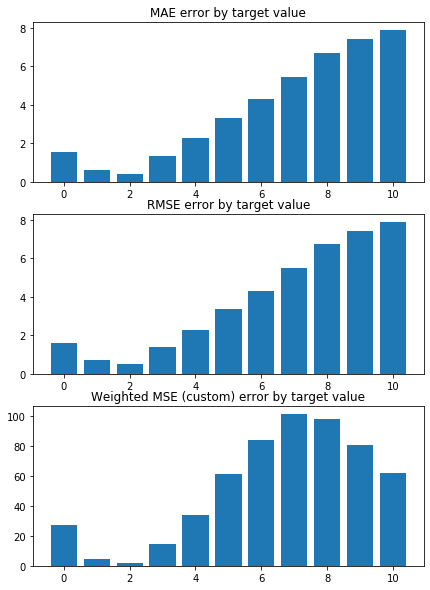

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.46550533906606 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5050318879760942 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


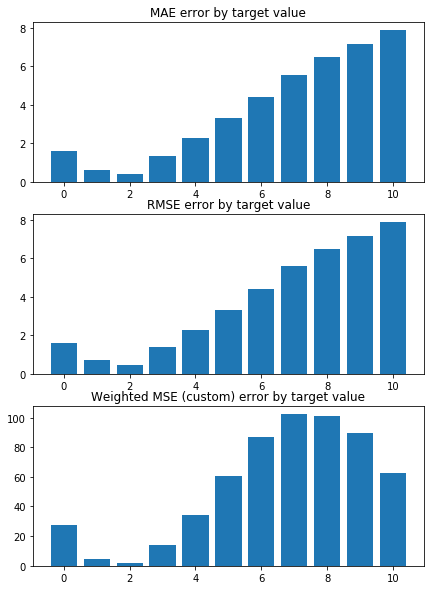

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.5204784209799074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5014976051400921 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


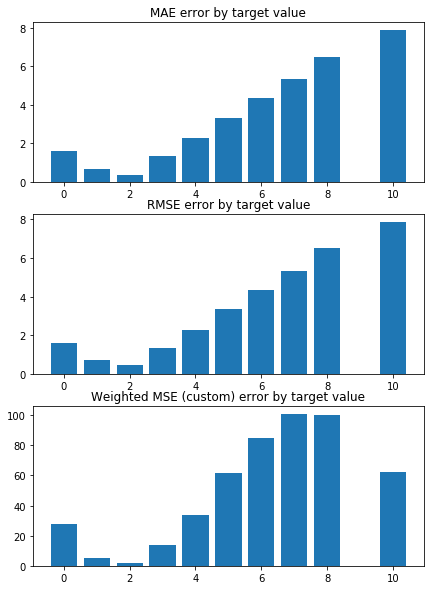

Weighted Mean squared error on Train: 1.50 
 MSE mean train: 2.958612123656919 

Mean squared error on Test: 1.50 
 MSE mean test:  2.9588950737074304 

Root of MSE on Test: 1.23 
 1.7201439107549783 

Variance score on Test: 0.04 
 r2_test: -0.000502398722420172 

wMSE_train 1.5
wMSE_test 1.5
MSE_train 2.96
MSE_test 2.96
MAE_train 1.26
MAE_test 1.29
r2_test -0.0
   is_bg  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
1    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
2    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
3    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
4    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
5    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
6    0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0      0.0   
7 

In [124]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

alpha_grid = np.arange(0, 1, 0.1)
# Create linear regression object

model_name = 'LR+L1_grid0.1-1'
n_splits = 10
random_state = 16 
shuffle = True


wmse_test = []
wmse_train = []

for alpha in alpha_grid:
    model = linear_model.Lasso(alpha=alpha)

    lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                        weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                        rmse_test, rmse_train, rmse_test_const, \
                        mae_test,    mae_train,  mae_test_const, \
                        _ = train_test_KFold(X, y, model, model_name, results_pd,
                                             n_splits=n_splits, random_state=random_state, shuffle=shuffle)


    wmse_test.append(np.mean(weighted_mse_test_all))
    wmse_train.append(np.mean(weighted_mse_train_all))


In [125]:
wmse_test

[1.0382088306446564,
 1.0297438443140308,
 1.0536084939612,
 1.0933642029711446,
 1.1583152187624364,
 1.227736146281264,
 1.3019751798476107,
 1.390755430522987,
 1.4963457895834844,
 1.5030150743825657]

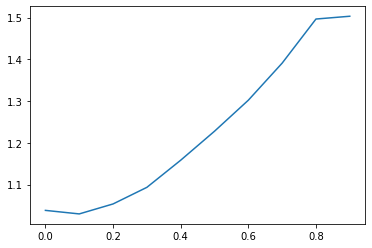

In [126]:
plt.plot(alpha_grid, wmse_test)

In [127]:
# Best alpha = 0.2

# L1 - best  score

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0586729062923868 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0507877799786123 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5084857885756024
test sizes =  1785 1785 1785


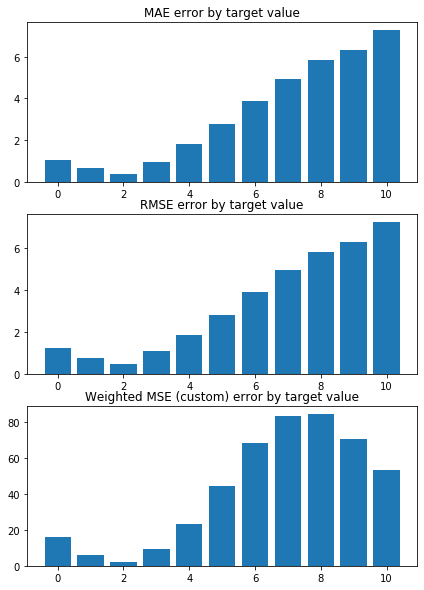

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0563141811602366 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0524461950380712 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


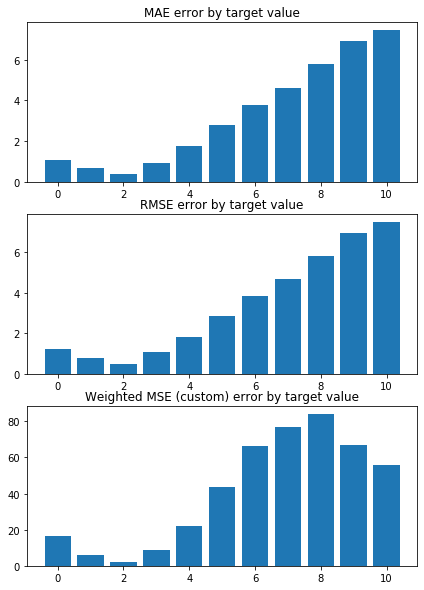

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0315414251538018 


 TRAIN PREDICTION Error
weighted_mse_train: 1.056832101880037 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


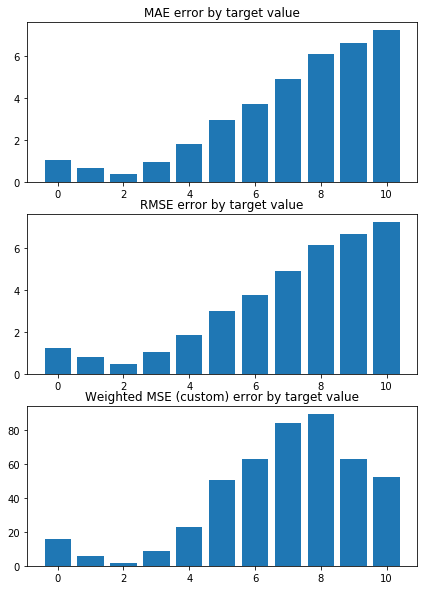

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9836101852246056 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0629419623726337 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


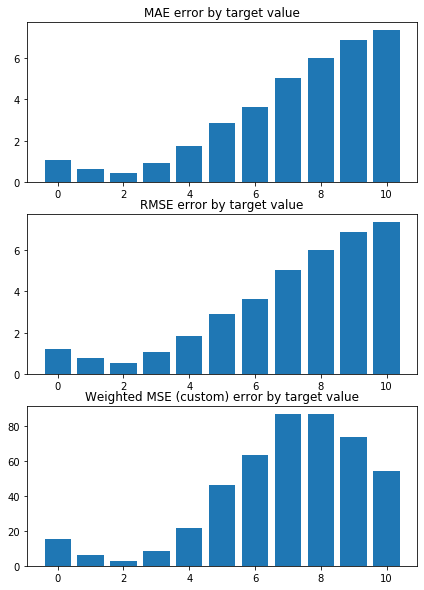

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.054619812410748 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0529544548071534 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


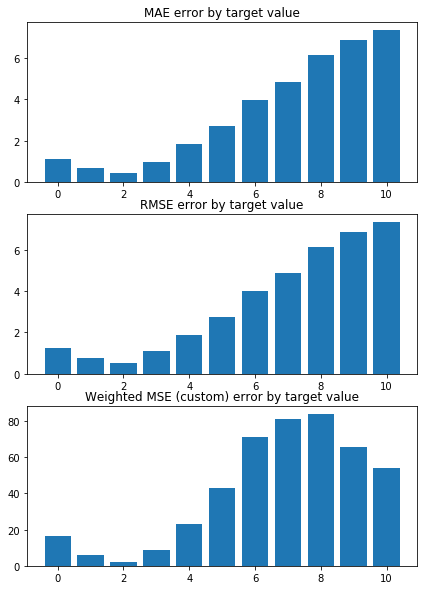

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1124379627059187 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0478737426679432 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


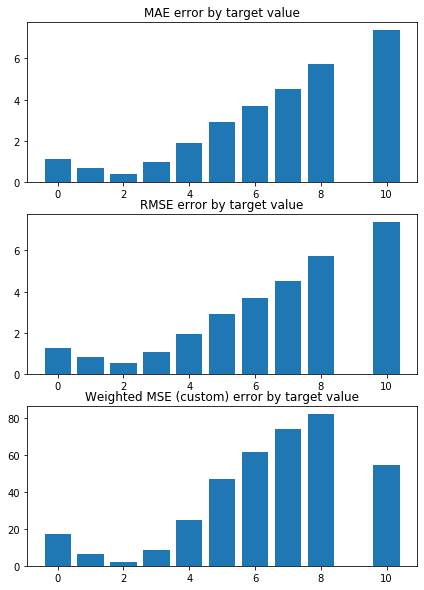

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0933697963110494 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0485747989838958 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


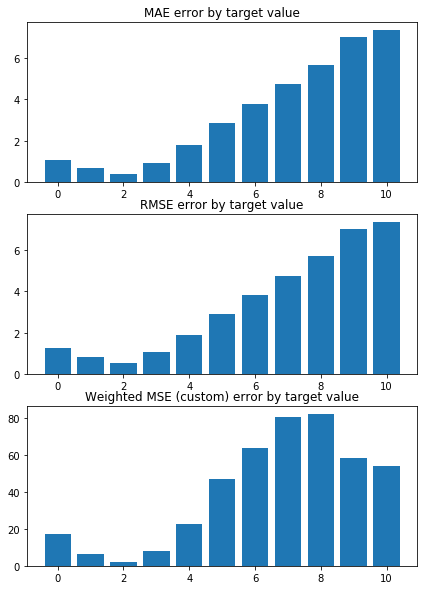

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0884166275539162 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0477856644450776 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


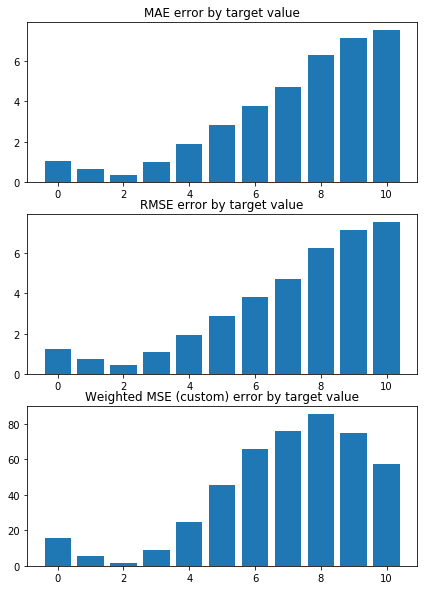

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 1.0084473136785461 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0580632538084915 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


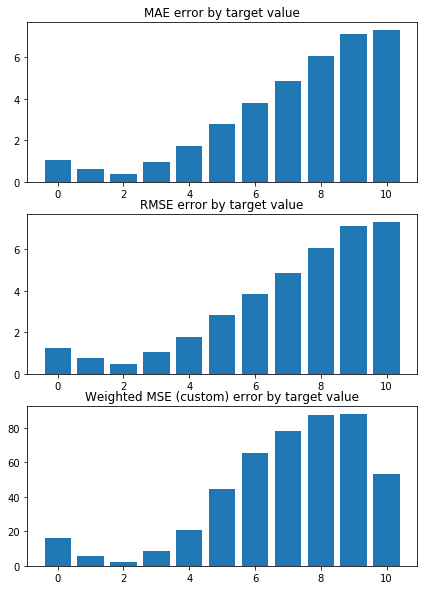

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0486547291207897 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0525017006246267 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


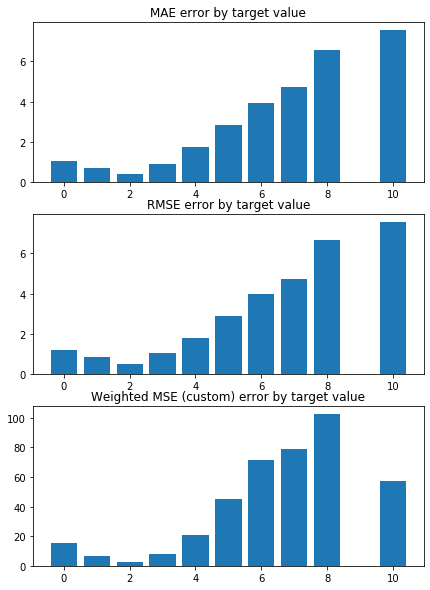

Weighted Mean squared error on Train: 1.05 
 MSE mean train: 2.2635742125367186 

Mean squared error on Test: 1.05 
 MSE mean test:  2.2644001353295873 

Root of MSE on Test: 1.03 
 1.5047923894443338 

Variance score on Test: 0.04 
 r2_test: 0.23482729250362522 

wMSE_train 1.05
wMSE_test 1.05
MSE_train 2.26
MSE_test 2.26
MAE_train 1.01
MAE_test 1.03
r2_test 0.23
    H3K4me1   H3K4me2     Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  \
0 -0.229884 -0.172255 -0.169405 -0.162280      -0.0       0.0      -0.0   
1 -0.226619 -0.176549 -0.173414 -0.159670      -0.0       0.0      -0.0   
2 -0.241550 -0.158712 -0.167476 -0.166853      -0.0       0.0      -0.0   
3 -0.232867 -0.172500 -0.186451 -0.151083      -0.0       0.0      -0.0   
4 -0.239023 -0.157393 -0.175539 -0.165219      -0.0       0.0      -0.0   
5 -0.239123 -0.171076 -0.170792 -0.160146      -0.0       0.0      -0.0   
6 -0.229903 -0.169822 -0.180221 -0.159583      -0.0       0.0      -0.0   
7 -0.227361 -0.177050 -0.171598 -

model_name  wMSE_test_mean  wMSE_test_std  wMSE_train_mean  \
0     LR+L1_no_outliers        0.915152       0.019944         0.912381   
1                    LR        1.038241       0.041786         1.035609   
2                 LR+L1        1.503015       0.037112         1.502848   
3  LR+L1_alf=0.2_spt=10        1.053608       0.037065         1.053076   

   wMSE_train_std comments                  params  MSE_test_mean  \
0        0.006536        -  test_params = testtest       1.323297   
1        0.005302        -  test_params = testtest       2.152857   
2        0.005510        -  test_params = testtest       2.958895   
3        0.004665        -  test_params = testtest       2.264400   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0      0.039524        1.319353       0.009883   
1      0.153323        2.147985       0.017038   
2      0.165080        2.958612       0.018354   
3      0.154071        2.263574       0.016959   

                                             r2_test n_splits  \
0  [0.32111774912476376, 0.31698748091029916, 0.3...        5   
1  [0.29507279966080857, 0.2755899643705616, 0.28...       10   
2  [-0.001250621628477555, -3.83457383368313e-05,...       10   
3  [0.24949882841496618, 0.23685037694872024, 0.2...       10   

                                               model  
0  LinearRegression(copy_X=True, fit_intercept=Tr...  
1  LinearRegression(copy_X=True, fit_intercept=Tr...  
2  Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...  
3  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...

In [128]:
# L1 - best 
model = linear_model.Lasso(alpha=0.2)


model_name = 'LR+L1_alf=0.2_spt=10'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)

# wmse_test.append(np.mean(weighted_mse_test_all))
# wmse_train.append(np.mean(weighted_mse_train_all))
results_pd

In [129]:
coefs_argsort, coefs

(array([[ 9, 10,  3, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
          4,  2,  1, 19, 20],
        [ 9, 10,  3, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
          4,  2,  1, 19, 20],
        [ 9,  3, 18, 10, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
          4,  2,  1, 19, 20],
        [ 9,  3, 10, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
          4,  2,  1, 19, 20],
        [ 9,  3, 18, 10, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
          4,  2,  1, 19, 20],
        [ 9, 10,  3, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
          4,  2,  1, 19, 20],
        [ 9,  3, 10, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
          4,  2,  1, 19, 20],
        [ 9, 10,  3, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
          4,  2,  1, 19, 20],
        [ 9,  3, 10, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
          4,  2,  1, 19, 20],
        [ 9,  3, 10, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,


In [130]:
su_drsc.columns[2:][coefs_argsort[0]]

Index(['H3K4me1', 'H3K4me2', 'Chriz', 'H3K36me3', 'H3K36me1', 'H3K27me3',
       'H3K27me1', 'H3K27ac', 'H3K9me3', 'H3K9me2', 'H3K4me3', 'is_bg', 'GAF',
       'CP190', 'BEAF-32', 'Su(Hw)', 'CTCF', 'start_coord', 'chrN', 'H4K16ac',
       'RNA-polymerase-II'],
      dtype='object')

In [131]:
coefs_argsort[:]

array([[ 9, 10,  3, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
         4,  2,  1, 19, 20],
       [ 9, 10,  3, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
         4,  2,  1, 19, 20],
       [ 9,  3, 18, 10, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
         4,  2,  1, 19, 20],
       [ 9,  3, 10, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
         4,  2,  1, 19, 20],
       [ 9,  3, 18, 10, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
         4,  2,  1, 19, 20],
       [ 9, 10,  3, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
         4,  2,  1, 19, 20],
       [ 9,  3, 10, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
         4,  2,  1, 19, 20],
       [ 9, 10,  3, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
         4,  2,  1, 19, 20],
       [ 9,  3, 10, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
         4,  2,  1, 19, 20],
       [ 9,  3, 10, 18, 17, 16, 15, 14, 13, 12, 11,  0,  8,  7,  6,  5,
         4,  2,  1,

In [132]:

wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)

wmse_mean_train, wmse_mean_test = 1.0530761654606542 1.0536084939612


In [133]:
su_drsc.columns[2:][coefs_argsort[0]], coefs

(Index(['H3K4me1', 'H3K4me2', 'Chriz', 'H3K36me3', 'H3K36me1', 'H3K27me3',
        'H3K27me1', 'H3K27ac', 'H3K9me3', 'H3K9me2', 'H3K4me3', 'is_bg', 'GAF',
        'CP190', 'BEAF-32', 'Su(Hw)', 'CTCF', 'start_coord', 'chrN', 'H4K16ac',
        'RNA-polymerase-II'],
       dtype='object'),
 array([[ 0.        ,  0.        , -0.        , -0.16940544, -0.        ,
          0.        , -0.        , -0.        , -0.        , -0.22988433,
         -0.17225467, -0.        ,  0.        , -0.        , -0.        ,
         -0.        ,  0.        , -0.        , -0.16227963, -0.        ,
         -0.        ],
        [ 0.        ,  0.        , -0.        , -0.17341367, -0.        ,
          0.        , -0.        , -0.        , -0.        , -0.2266193 ,
         -0.17654877, -0.        ,  0.        , -0.        , -0.        ,
         -0.        ,  0.        , -0.        , -0.15966956, -0.        ,
         -0.        ],
        [ 0.        ,  0.        , -0.        , -0.16747554, -0.        ,

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS + L 1

Получили наиболее влияющие признаки

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Linear Regression with L2 regularization -  Ridge

In [134]:
X, y = data_scaled_clean, target_clean.gamma
X_train, X_test, y_train, y_test = train_test_split(X[:], y[:], test_size=0.3, random_state=10)


In [135]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 
# Create linear regression object
lin_reg_l2 = linear_model.Ridge()

# Train the model using the training sets
lin_reg_l2.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg_l2.predict(X_test)

Коэффициенты

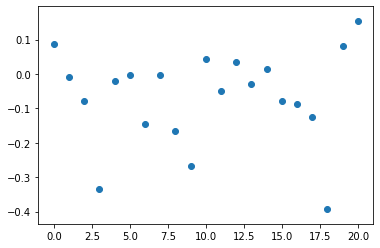

In [136]:
plt.scatter( np.arange(len(lin_reg_l2.coef_)) , lin_reg_l2.coef_)
plt.show()

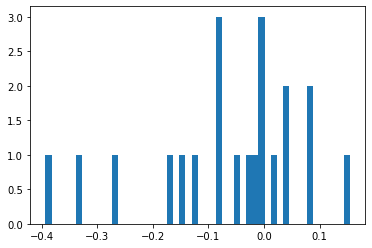

In [137]:
plt.hist(lin_reg_l2.coef_, bins=50)
plt.show()

In [138]:
# Make predictions using the testing set
y_pred_train = lin_reg_l2.predict(X_train)
# The mean squared error
print("Mean squared error on Train: %.2f"
      % mean_squared_error(y_train, y_pred_train))

# The mean squared error
print("Mean squared error on Test: %.2f"
      % mean_squared_error(y_test, y_pred))


# The mean squared error
print("Root of Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred)))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean squared error on Train: 2.16
Mean squared error on Test: 2.12
Root of Mean squared error: 1.45
Variance score: 0.27


(array([  2.,   0.,   1.,   1.,   6.,   3.,   5.,   6.,  23.,  19.,  26.,
         26.,  43.,  53.,  62.,  94.,  99., 109., 135., 145., 175., 197.,
        197., 207., 235., 249., 184., 214., 214., 202., 145., 187., 130.,
        109., 108., 104.,  58.,  61.,  49.,  41.,  17.,  19.,  11.,  10.,
          7.,   1.,   4.,   2.,   2.,   3.]),
 array([-3.60465784, -3.4638204 , -3.32298296, -3.18214552, -3.04130807,
        -2.90047063, -2.75963319, -2.61879575, -2.47795831, -2.33712087,
        -2.19628342, -2.05544598, -1.91460854, -1.7737711 , -1.63293366,
        -1.49209622, -1.35125877, -1.21042133, -1.06958389, -0.92874645,
        -0.78790901, -0.64707157, -0.50623412, -0.36539668, -0.22455924,
        -0.0837218 ,  0.05711564,  0.19795308,  0.33879053,  0.47962797,
         0.62046541,  0.76130285,  0.90214029,  1.04297773,  1.18381518,
         1.32465262,  1.46549006,  1.6063275 ,  1.74716494,  1.88800238,
         2.02883983,  2.16967727,  2.31051471,  2.45135215,  2.59218959,
 

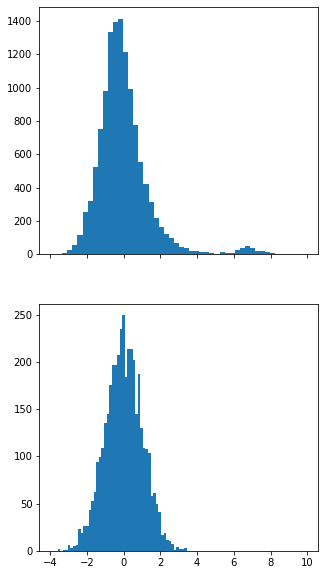

In [139]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
axes[0].hist((y_train - y_pred_train), bins=50)
axes[1].hist(np.random.randn(4000), bins=50)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# K-fold cross Validation - RL + L2


## Fined parametrs for L2

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0437097325063809 


 TRAIN PREDICTION Error
weighted_mse_train: 1.032027461749543 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5084857885756024
test sizes =  1785 1785 1785


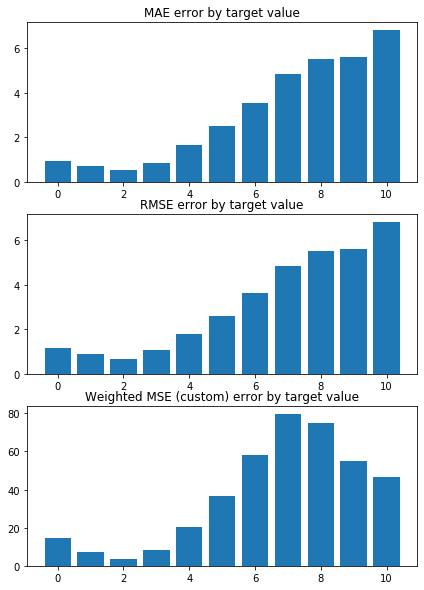

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0242217988772921 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0370231154874294 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


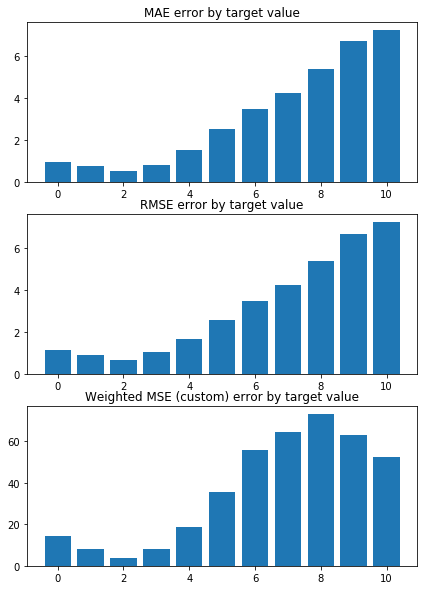

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0166575228233743 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0371342979999711 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


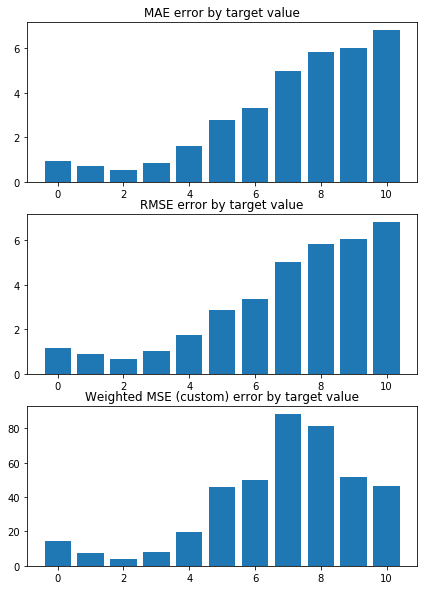

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9695495949794679 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0476456839538315 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


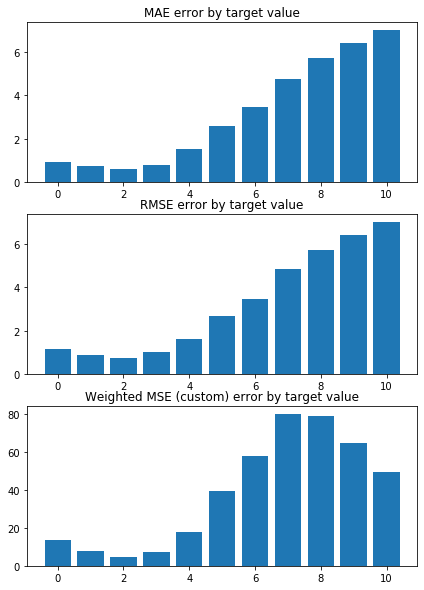

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0467386916447068 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0339462959885162 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


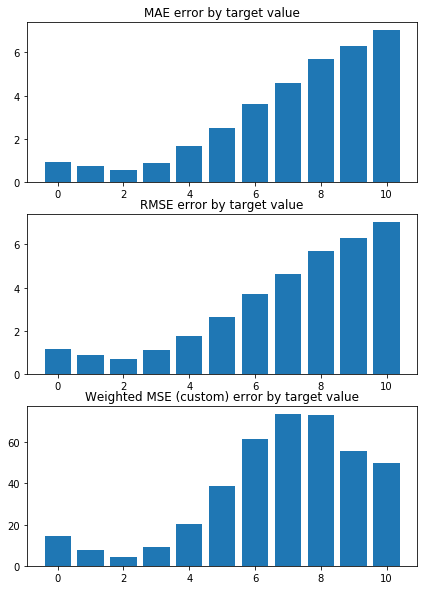

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1078193193537578 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0292798397911662 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


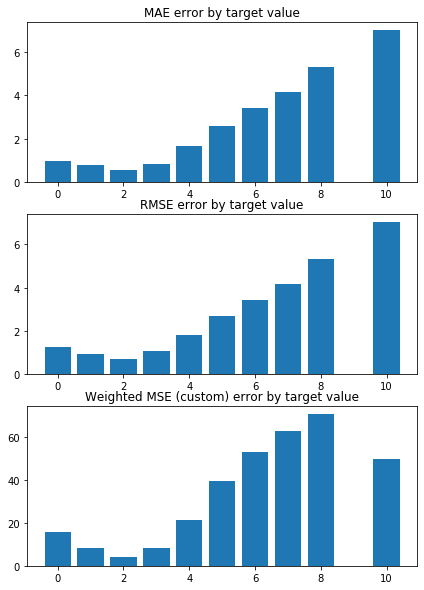

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.09158305381113 


 TRAIN PREDICTION Error
weighted_mse_train: 1.030396006221029 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


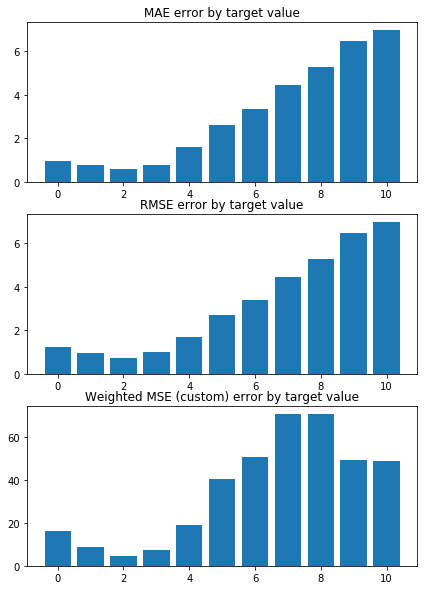

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0680419777327943 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0309659684065815 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


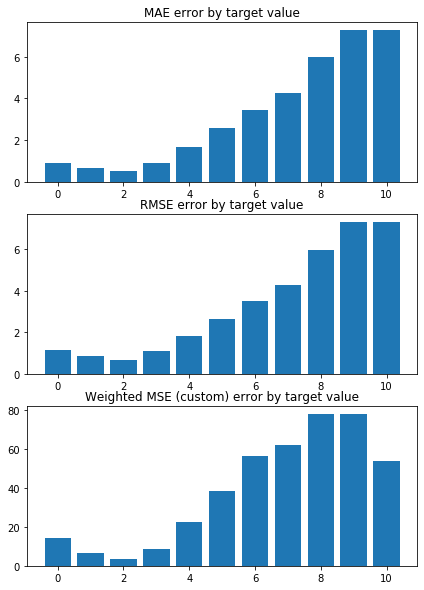

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.9798945861177376 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0409091336987053 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


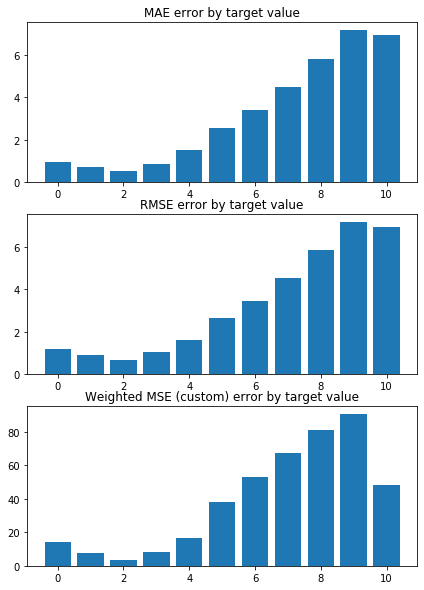

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0339137379120003 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0363757603595 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


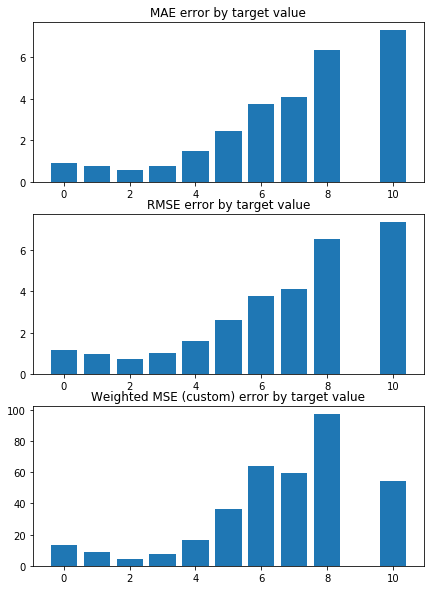

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.147985032273932 

Mean squared error on Test: 1.04 
 MSE mean test:  2.1528735359788413 

Root of MSE on Test: 1.02 
 1.467267370310824 

Variance score on Test: 0.04 
 r2_test: 0.27256035533408735 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.15
MSE_test 2.15
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32  H3K36me1  \
0 -0.380469 -0.325661 -0.237559 -0.167865 -0.152292 -0.135761   
1 -0.388096 -0.327093 -0.250428 -0.164091 -0.145425 -0.121414   
2 -0.384774 -0.329693 -0.246945 -0.168286 -0.155021 -0.139131   
3 -0.380372 -0.343528 -0.254161 -0.162013 -0.145745 -0.137026   
4 -0.379114 -0.332625 -0.256548 -0.175836 -0.143109 -0.130677   
5 -0.375486 -0.331523 -0.256608 -0.163763 -0.143545 -0.130548   
6 -0.374350 -0.333865 -0.258751 -0.159877 -0.153497 -0.121470   
7 -0.381371 -0.330877 -0.230451 -0.173300 -0.138200 -0.141477   
8 -0.384629 -0.328589 -0.253221 -0.161345 -0.14895

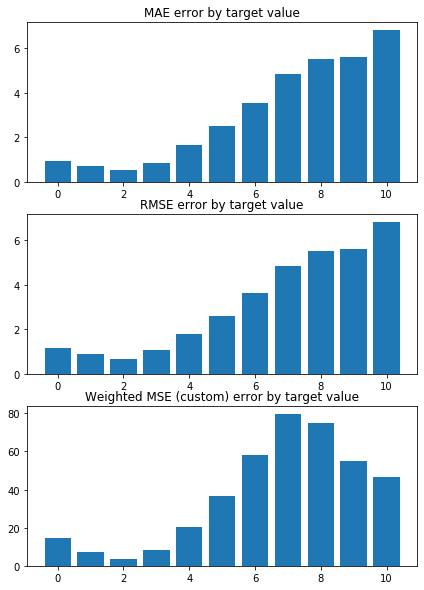

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.024217214047601 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0370141486059703 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


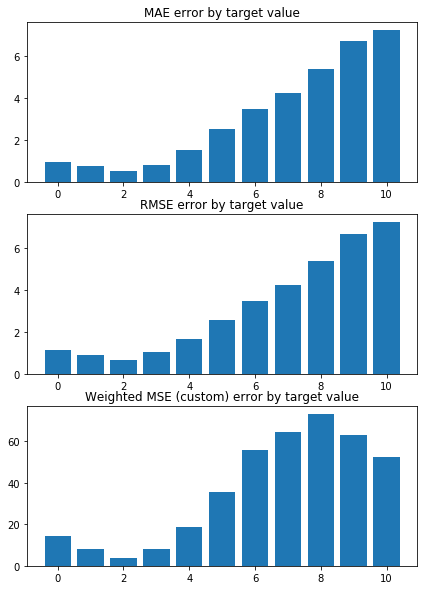

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.016491592671219 


 TRAIN PREDICTION Error
weighted_mse_train: 1.036985043273529 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


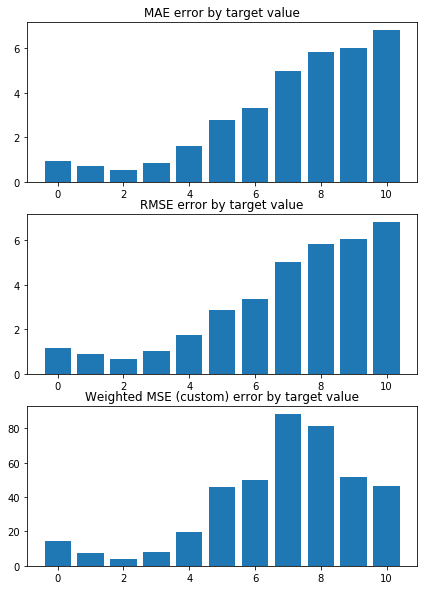

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9695374046767113 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0476368134214298 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


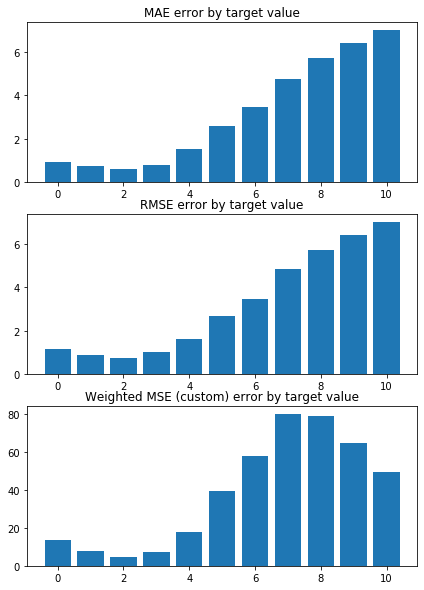

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.046927388143681 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0341348529083558 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


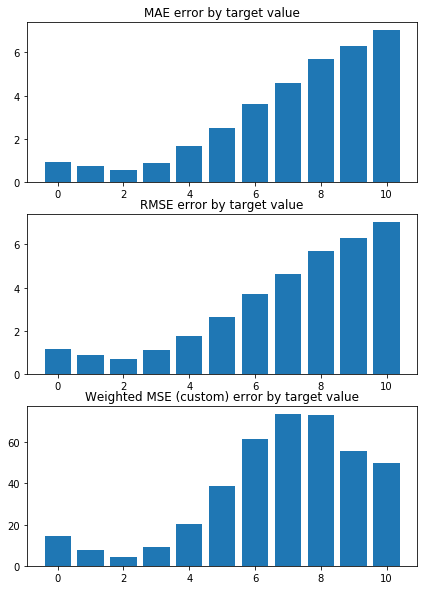

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.107811707344476 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0292718119427284 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


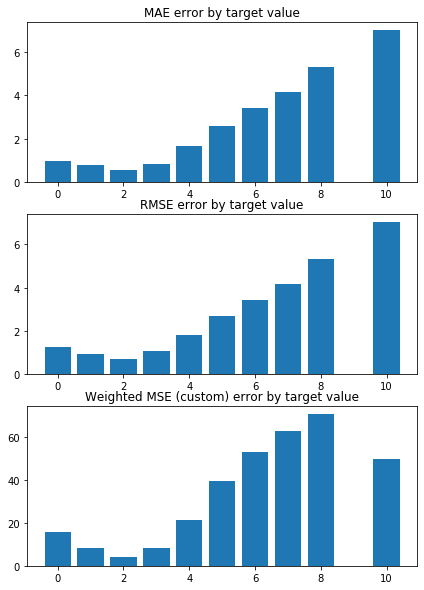

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0915438351005846 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0303576697998604 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


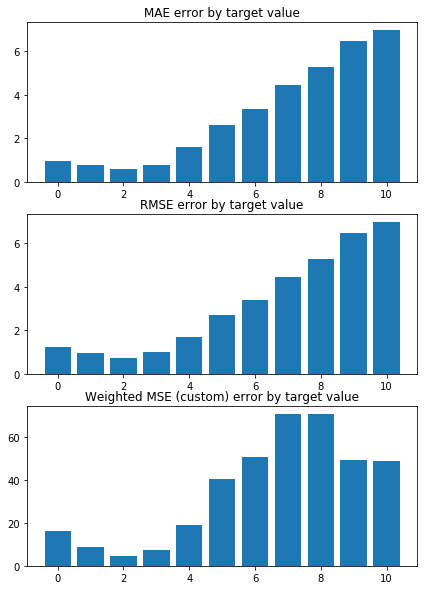

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0679163706102994 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0308320428196367 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


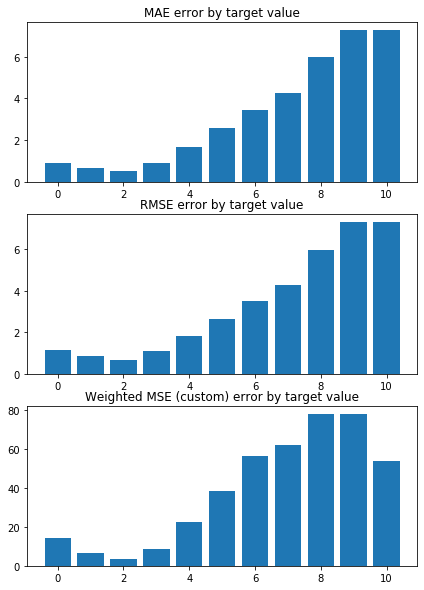

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.9798859843210582 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0409005929026989 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


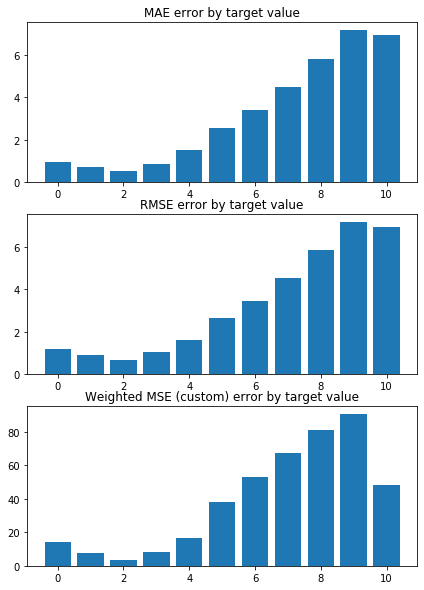

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0339642162349287 


 TRAIN PREDICTION Error
weighted_mse_train: 1.036425257341371 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


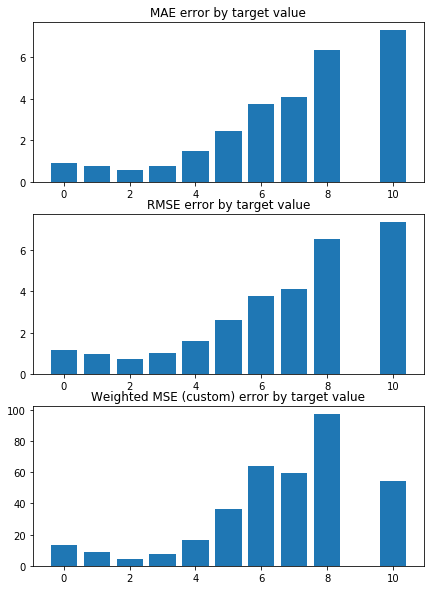

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.1479849879845183 

Mean squared error on Test: 1.04 
 MSE mean test:  2.152871855376872 

Root of MSE on Test: 1.02 
 1.4672667976127833 

Variance score on Test: 0.04 
 r2_test: 0.2725609888108953 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.15
MSE_test 2.15
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32  H3K36me1  \
0 -0.380353 -0.325577 -0.237469 -0.167837 -0.152254 -0.135695   
1 -0.387977 -0.327005 -0.250342 -0.164068 -0.145391 -0.121352   
2 -0.384656 -0.329604 -0.246858 -0.168261 -0.154983 -0.139063   
3 -0.380256 -0.343438 -0.254067 -0.161989 -0.145711 -0.136960   
4 -0.378999 -0.332542 -0.256441 -0.175810 -0.143074 -0.130617   
5 -0.375373 -0.331434 -0.256519 -0.163740 -0.143512 -0.130486   
6 -0.374235 -0.333779 -0.258639 -0.159853 -0.153461 -0.121413   
7 -0.381253 -0.330785 -0.230381 -0.173273 -0.138166 -0.141406   
8 -0.384510 -0.328501 -0.253128 -0.161322 -0.14892

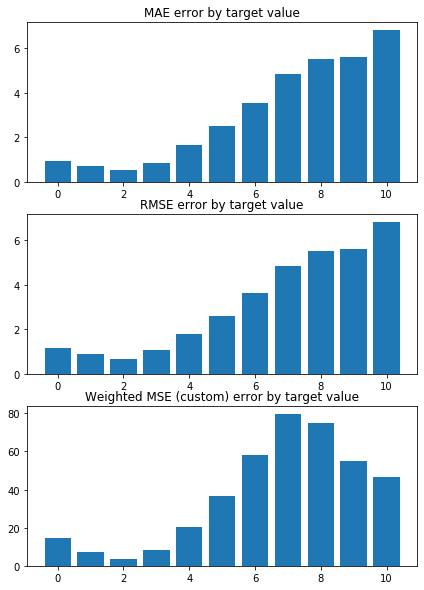

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0242126389456476 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0370051999261025 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


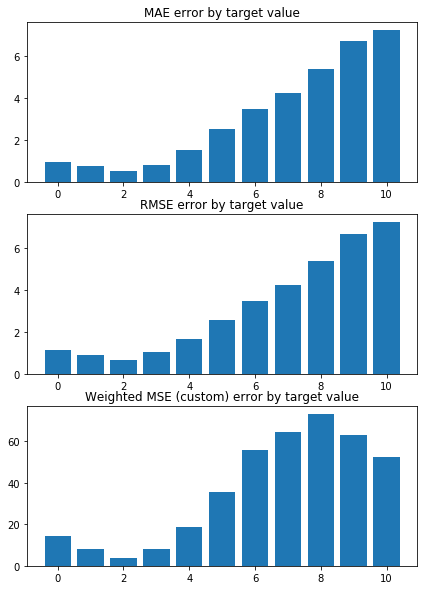

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0164790839302738 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0369771187582264 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


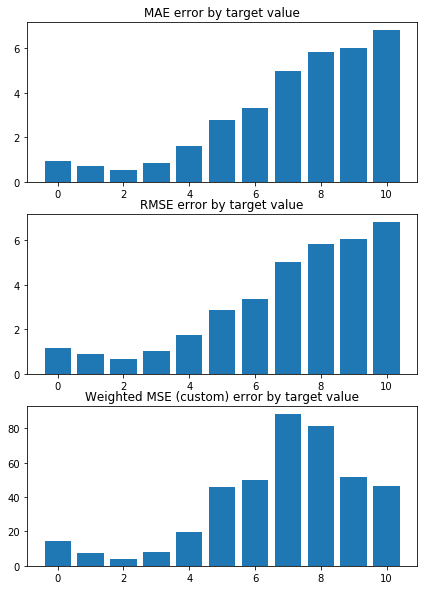

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9695252356249013 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0476279621263893 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


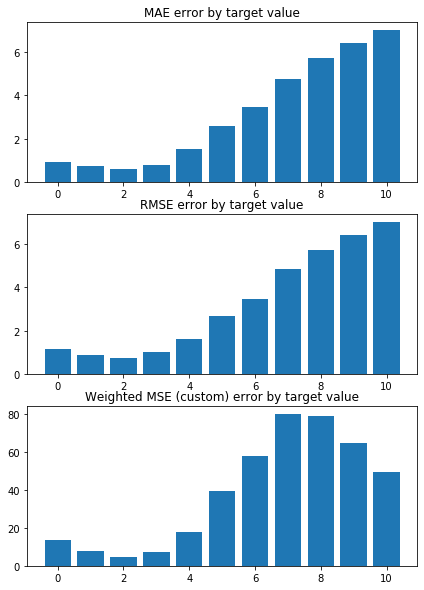

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.046917676650518 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0341262974402243 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


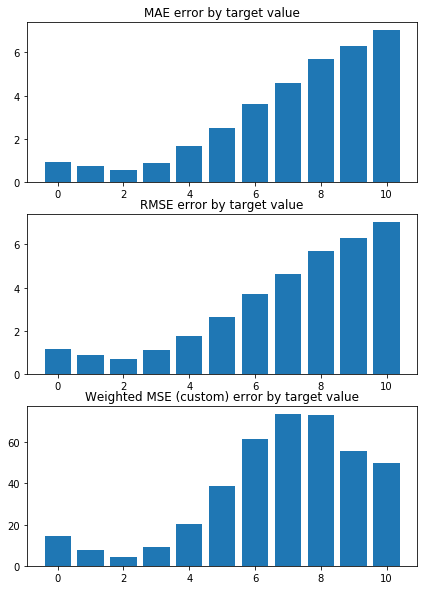

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1078041127235372 


 TRAIN PREDICTION Error
weighted_mse_train: 1.029263801114474 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


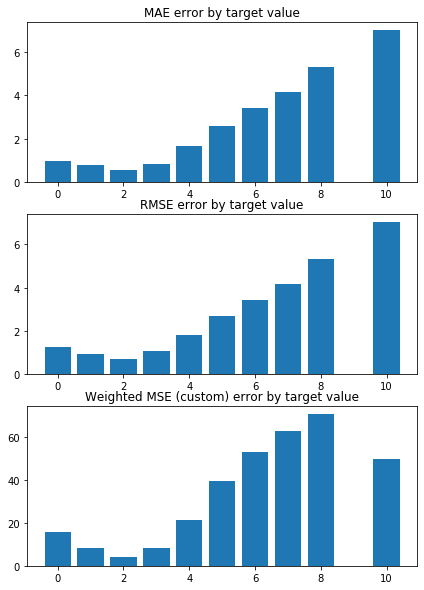

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0915357681611157 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0303490242516364 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


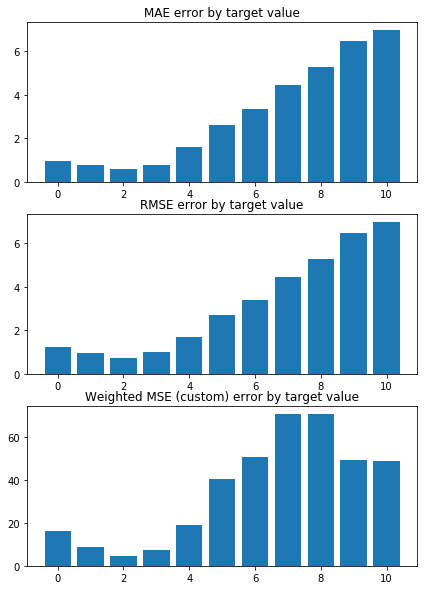

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0679086065428338 


 TRAIN PREDICTION Error
weighted_mse_train: 1.030823584504231 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


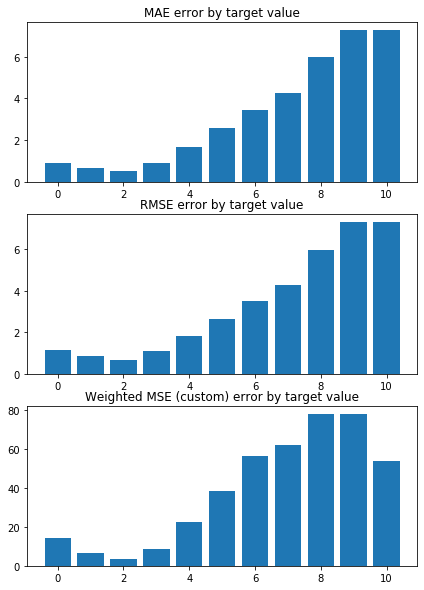

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.9798774021240074 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0408920707125104 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


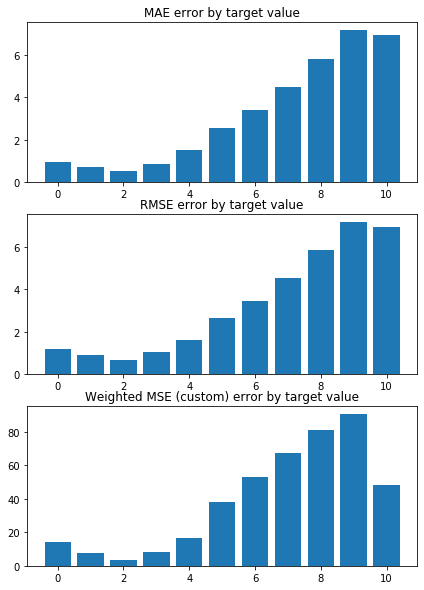

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.033952505497376 


 TRAIN PREDICTION Error
weighted_mse_train: 1.036416457801463 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


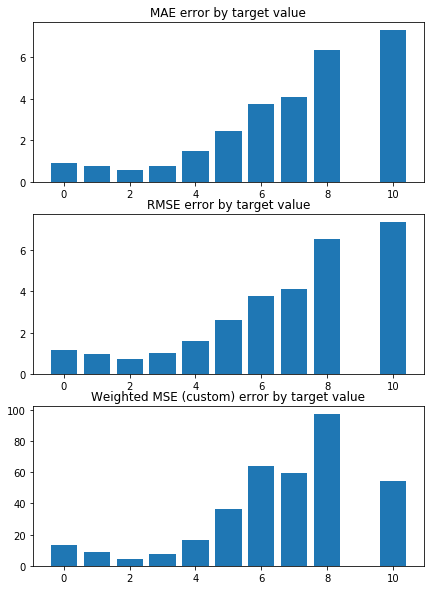

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.147985015339141 

Mean squared error on Test: 1.04 
 MSE mean test:  2.1528706794695966 

Root of MSE on Test: 1.02 
 1.4672663968992123 

Variance score on Test: 0.04 
 r2_test: 0.27256141960080055 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.15
MSE_test 2.15
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32  H3K36me1  \
0 -0.380236 -0.325492 -0.237380 -0.167810 -0.152217 -0.135630   
1 -0.387859 -0.326916 -0.250255 -0.164044 -0.145358 -0.121291   
2 -0.384538 -0.329515 -0.246771 -0.168235 -0.154944 -0.138996   
3 -0.380139 -0.343348 -0.253974 -0.161965 -0.145677 -0.136894   
4 -0.378884 -0.332459 -0.256334 -0.175783 -0.143040 -0.130558   
5 -0.375259 -0.331345 -0.256430 -0.163716 -0.143478 -0.130424   
6 -0.374121 -0.333694 -0.258528 -0.159828 -0.153425 -0.121357   
7 -0.381136 -0.330694 -0.230311 -0.173246 -0.138133 -0.141335   
8 -0.384391 -0.328414 -0.253035 -0.161299 -0.1488

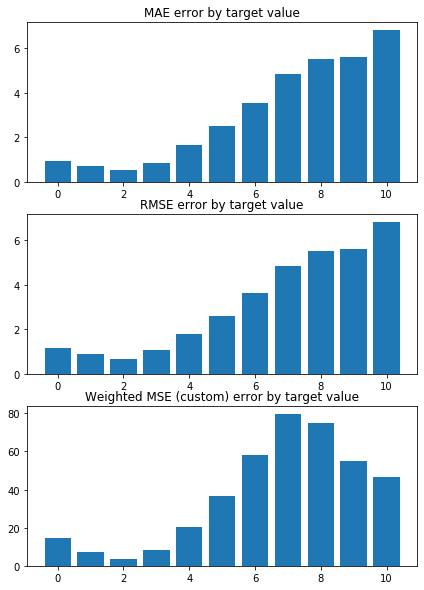

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0242080735498087 


 TRAIN PREDICTION Error
weighted_mse_train: 1.036996269390391 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


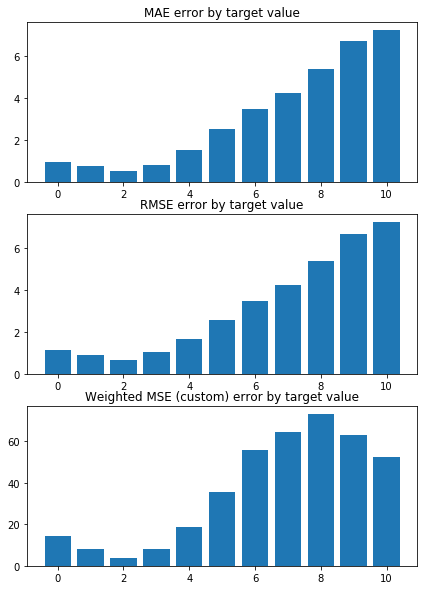

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0164665983757735 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0369692120799976 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


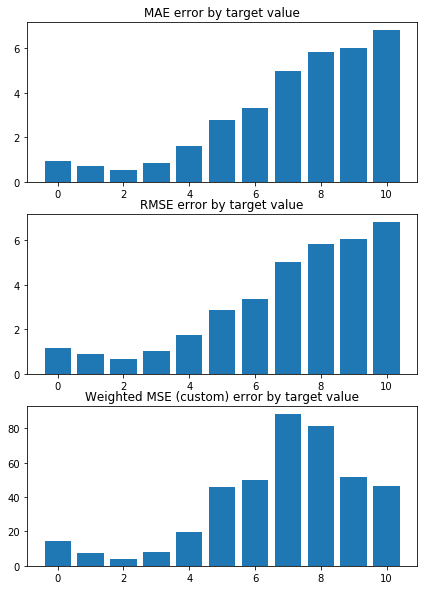

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.969513087757333 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0476191300027313 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


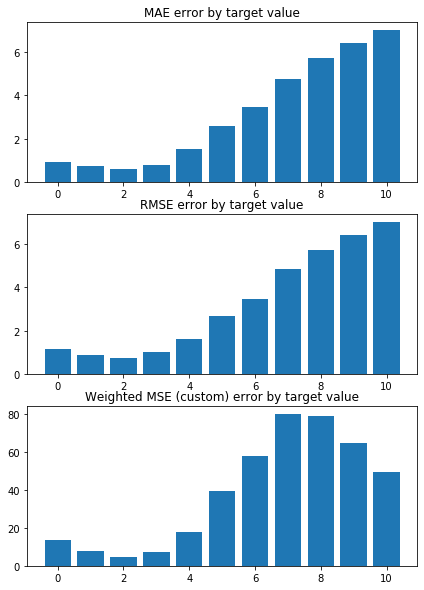

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.046907987927567 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0341177617768602 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


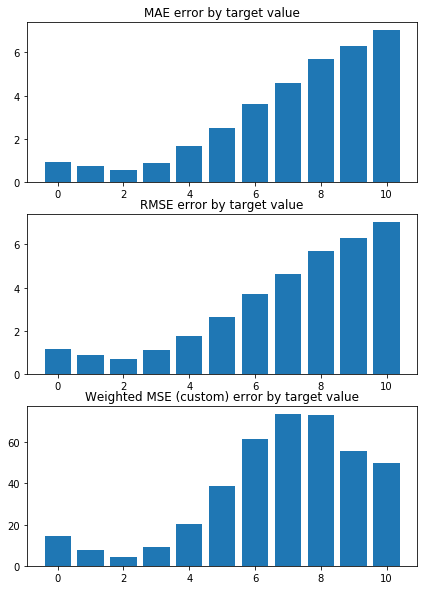

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.107796535422803 


 TRAIN PREDICTION Error
weighted_mse_train: 1.029255807252145 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


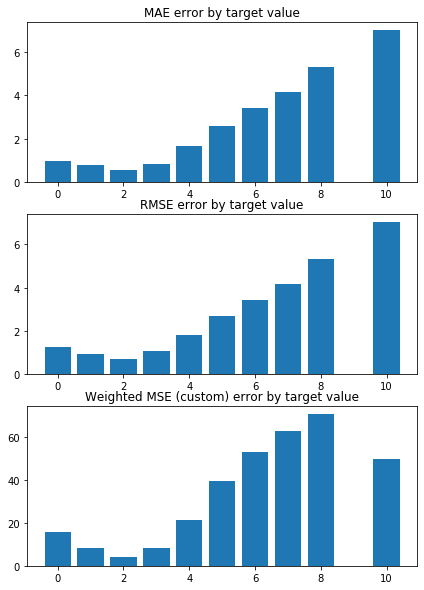

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0915277252579854 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0303403996834315 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


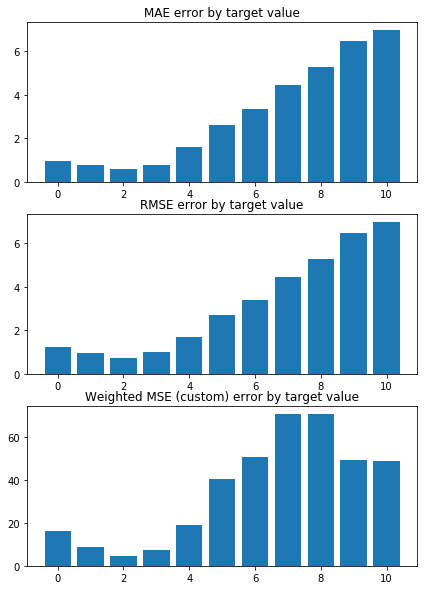

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0679008532329974 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0308151434105335 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


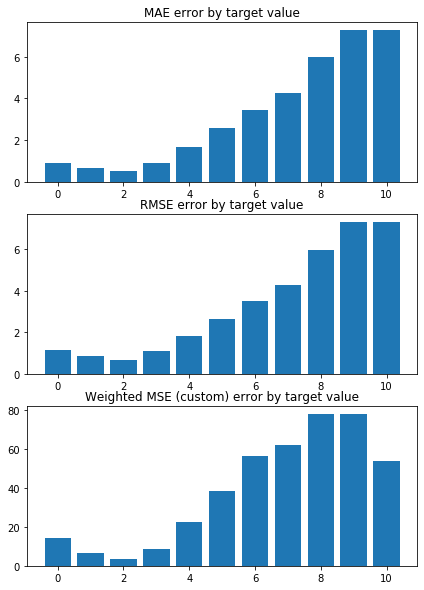

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.979868839464157 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0408835670651586 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


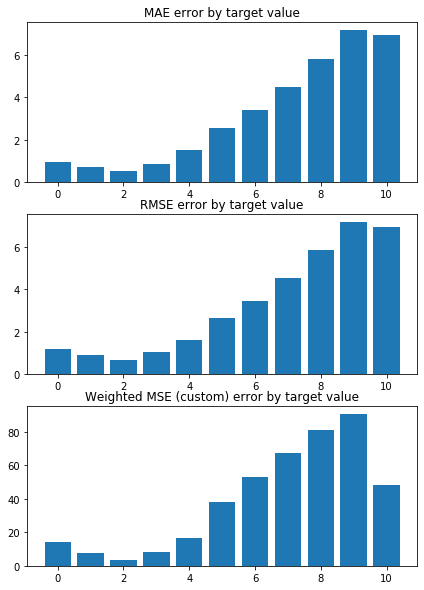

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0339408234672478 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0364076781192268 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


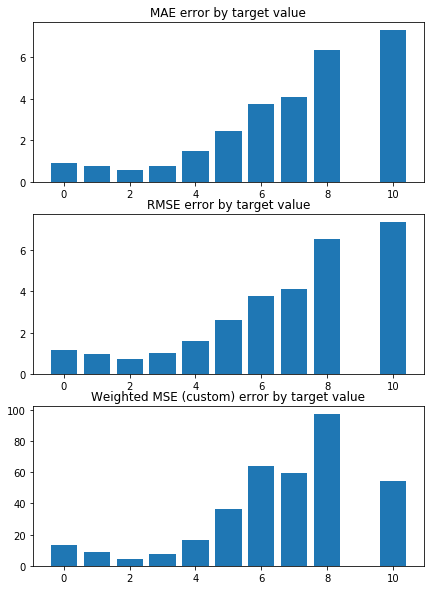

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.147985060834645 

Mean squared error on Test: 1.04 
 MSE mean test:  2.1528695236075936 

Root of MSE on Test: 1.02 
 1.4672660030163562 

Variance score on Test: 0.04 
 r2_test: 0.27256184356108404 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.15
MSE_test 2.15
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32  H3K36me1  \
0 -0.380120 -0.325407 -0.237290 -0.167783 -0.152180 -0.135565   
1 -0.387741 -0.326827 -0.250169 -0.164021 -0.145324 -0.121229   
2 -0.384420 -0.329426 -0.246684 -0.168209 -0.154905 -0.138929   
3 -0.380023 -0.343258 -0.253881 -0.161941 -0.145643 -0.136829   
4 -0.378769 -0.332376 -0.256228 -0.175757 -0.143007 -0.130499   
5 -0.375146 -0.331256 -0.256341 -0.163693 -0.143445 -0.130362   
6 -0.374006 -0.333609 -0.258416 -0.159804 -0.153388 -0.121300   
7 -0.381018 -0.330602 -0.230241 -0.173218 -0.138100 -0.141265   
8 -0.384272 -0.328327 -0.252943 -0.161276 -0.1488

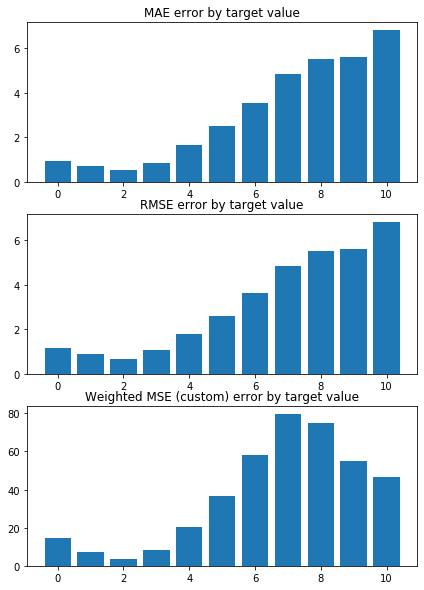

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0242035178385445 


 TRAIN PREDICTION Error
weighted_mse_train: 1.036987356941737 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


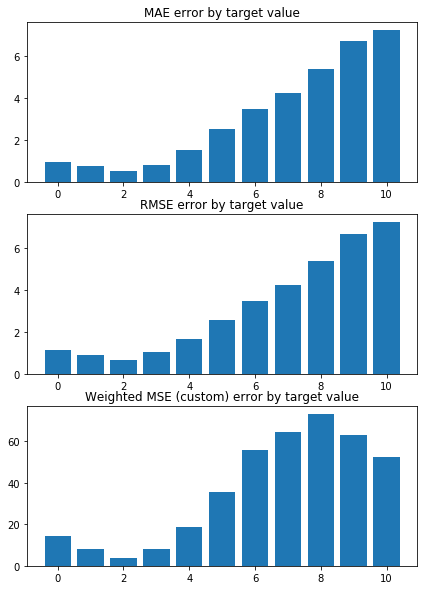

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0164541359330126 


 TRAIN PREDICTION Error
weighted_mse_train: 1.03696132317882 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


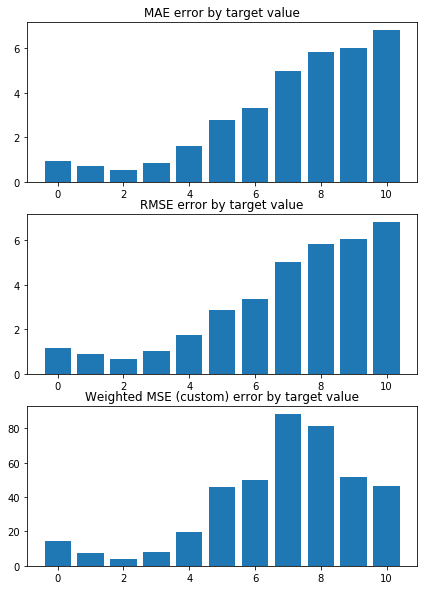

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.969500961007735 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0476103169849142 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


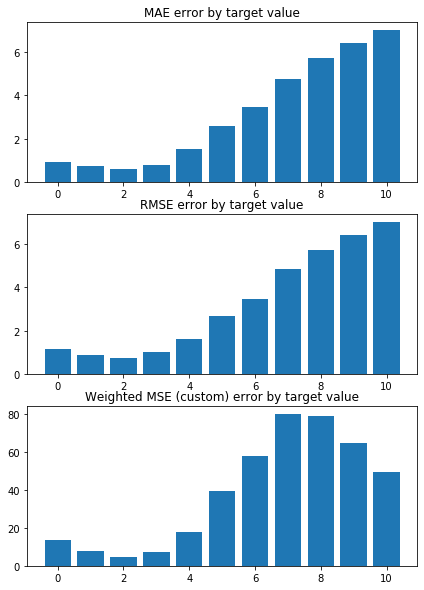

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0468983218817387 


 TRAIN PREDICTION Error
weighted_mse_train: 1.034109245842352 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


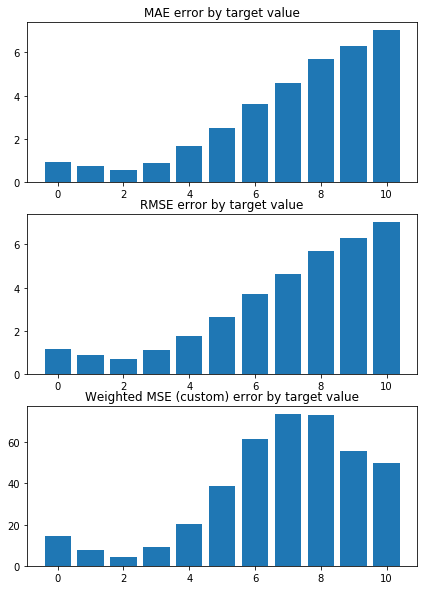

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1077889753746155 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0292478303018127 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


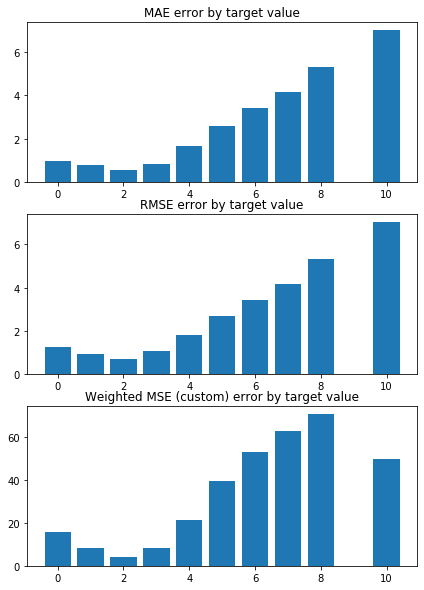

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0915197062808841 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0303317960092426 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


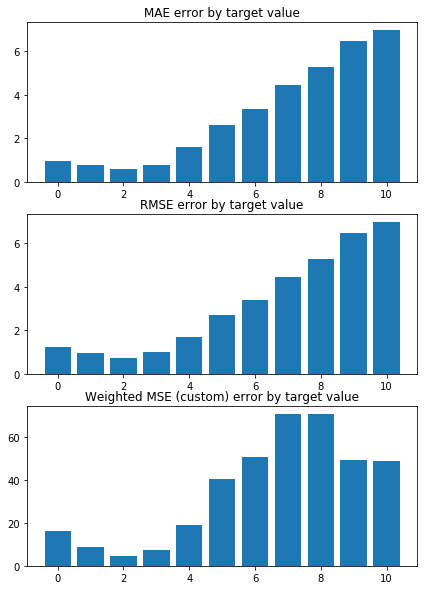

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0678931106731187 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0308067194866626 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


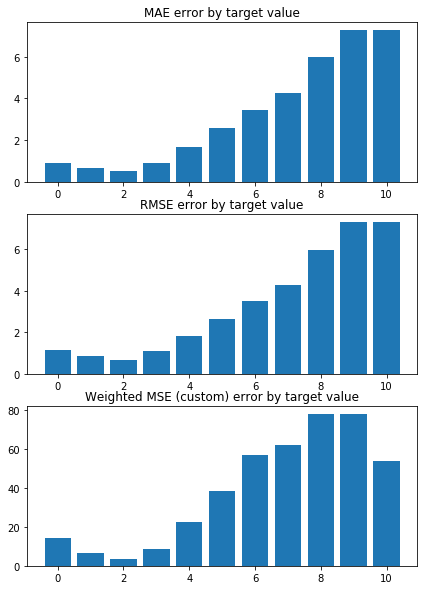

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.979860296279448 


 TRAIN PREDICTION Error
weighted_mse_train: 1.040875081898063 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


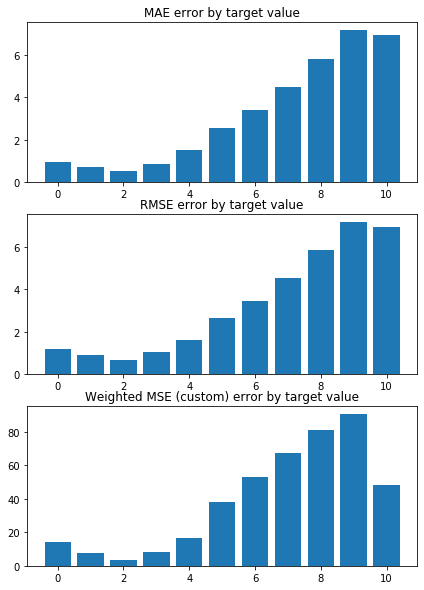

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0339291700186284 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0363989182176607 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


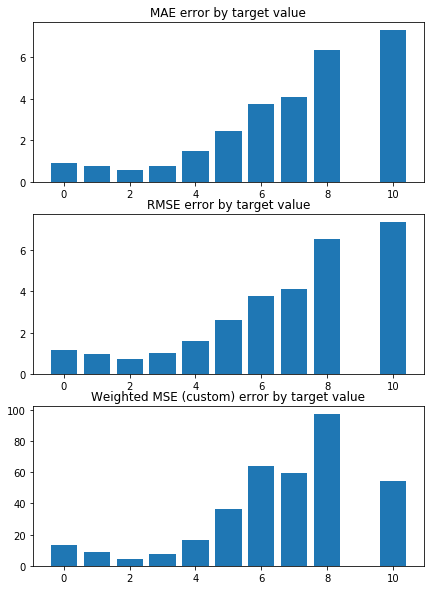

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.1479851243935024 

Mean squared error on Test: 1.04 
 MSE mean test:  2.152868387705208 

Root of MSE on Test: 1.02 
 1.4672656159350317 

Variance score on Test: 0.04 
 r2_test: 0.27256226072084294 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.15
MSE_test 2.15
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32  H3K36me1  \
0 -0.380003 -0.325323 -0.237201 -0.167755 -0.152142 -0.135501   
1 -0.387623 -0.326739 -0.250083 -0.163997 -0.145291 -0.121167   
2 -0.384302 -0.329337 -0.246597 -0.168184 -0.154866 -0.138862   
3 -0.379907 -0.343168 -0.253788 -0.161917 -0.145609 -0.136763   
4 -0.378653 -0.332293 -0.256122 -0.175730 -0.142973 -0.130440   
5 -0.375033 -0.331167 -0.256252 -0.163670 -0.143412 -0.130299   
6 -0.373891 -0.333523 -0.258305 -0.159779 -0.153352 -0.121243   
7 -0.380901 -0.330511 -0.230171 -0.173191 -0.138067 -0.141195   
8 -0.384153 -0.328240 -0.252851 -0.161253 -0.1488

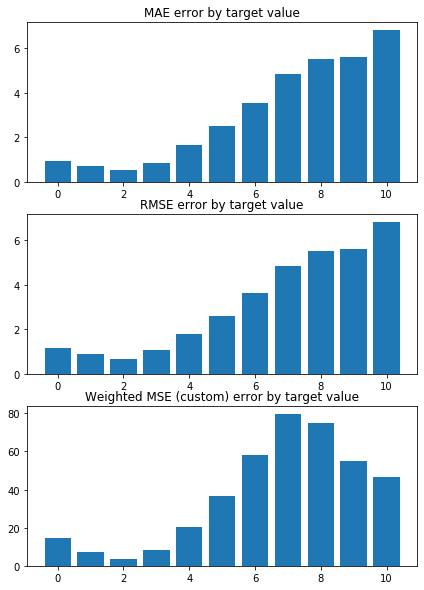

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0241989717903983 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0369784625233756 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


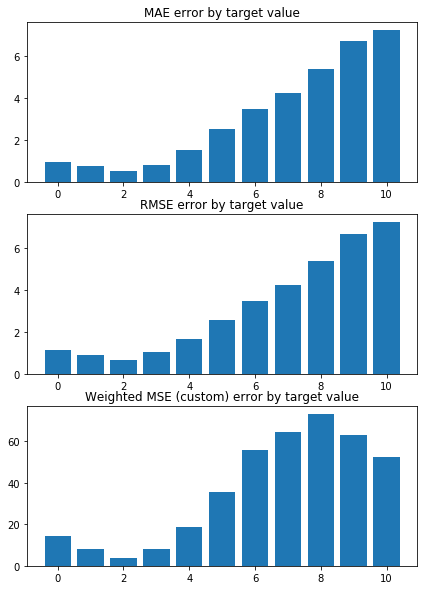

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0164416965277479 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0369534519950496 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


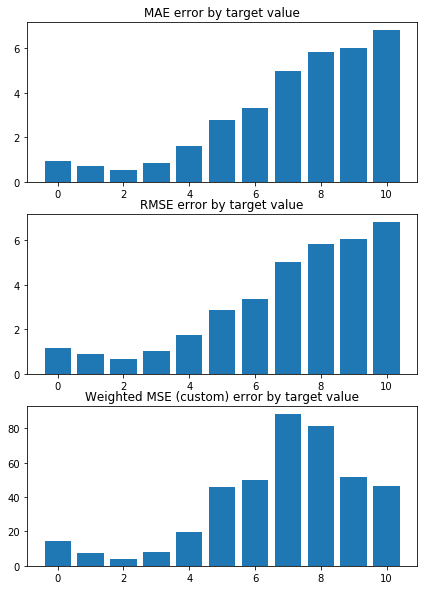

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9694888553102626 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0476015230078264 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


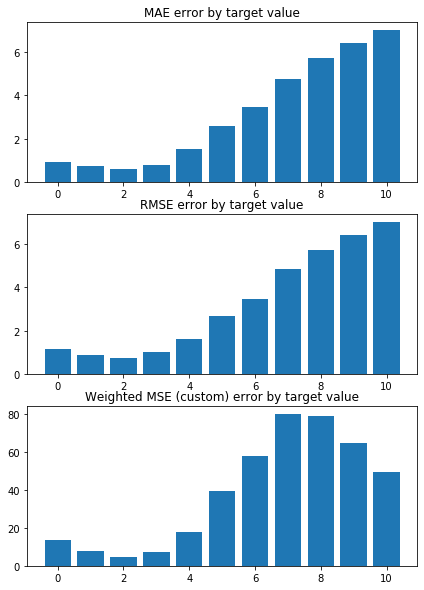

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0468886784206397 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0341007495613437 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


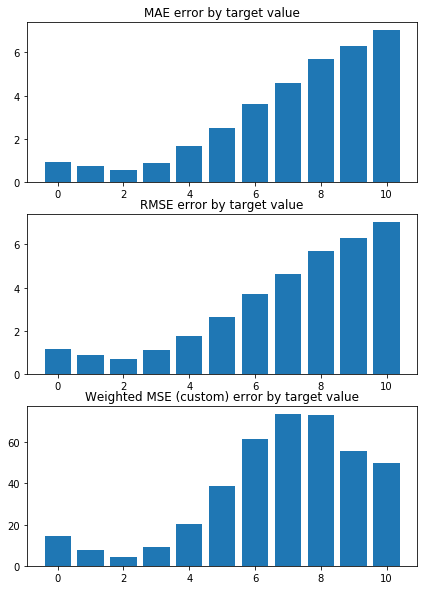

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1077814325117947 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0292398702098762 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


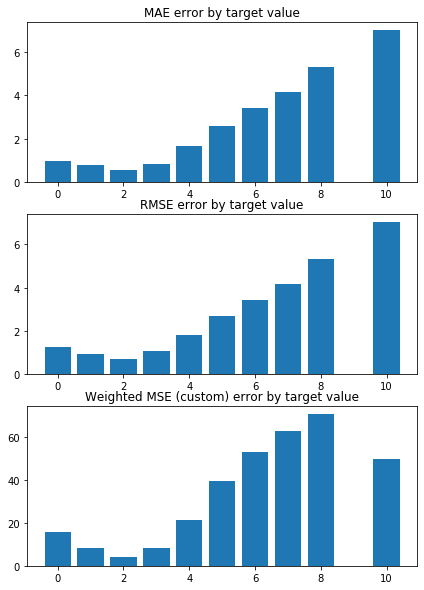

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0915117111203585 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0303232131437214 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


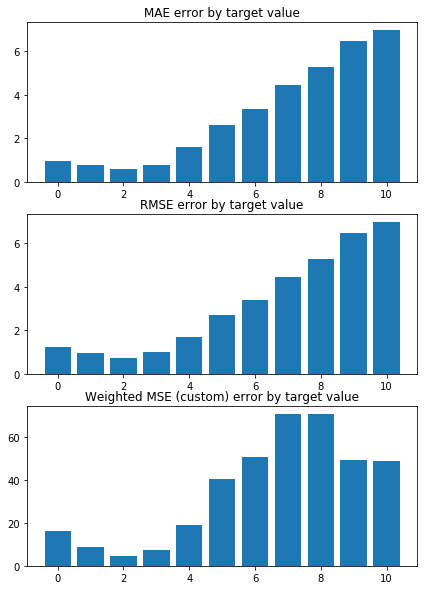

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0678853788554274 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0307983126810158 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


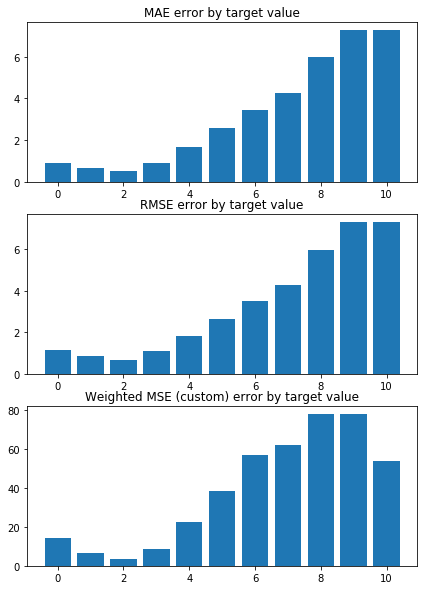

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.9798517725081847 


 TRAIN PREDICTION Error
weighted_mse_train: 1.040866615149038 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


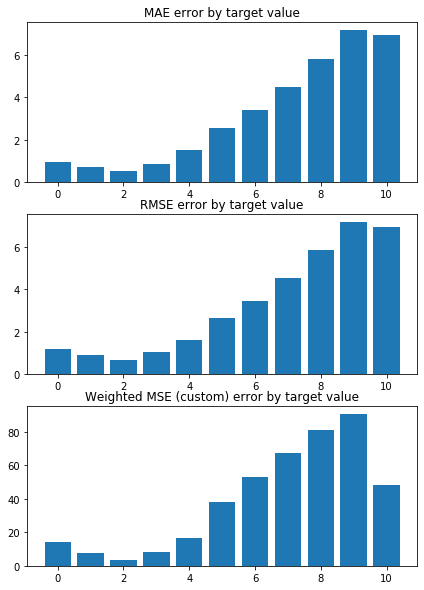

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0339175450265463 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0363901780203302 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


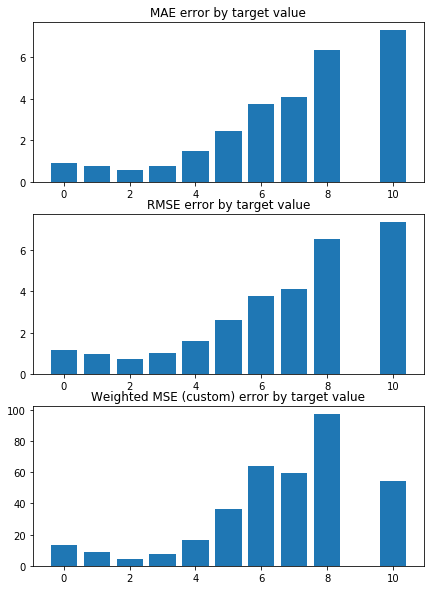

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.147985205938742 

Mean squared error on Test: 1.04 
 MSE mean test:  2.152867271677401 

Root of MSE on Test: 1.02 
 1.4672652356262657 

Variance score on Test: 0.04 
 r2_test: 0.27256267110896637 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.15
MSE_test 2.15
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32  H3K36me1  \
0 -0.379887 -0.325238 -0.237113 -0.167728 -0.152105 -0.135436   
1 -0.387504 -0.326650 -0.249998 -0.163974 -0.145257 -0.121105   
2 -0.384184 -0.329249 -0.246510 -0.168158 -0.154827 -0.138795   
3 -0.379791 -0.343078 -0.253695 -0.161893 -0.145575 -0.136698   
4 -0.378538 -0.332210 -0.256016 -0.175704 -0.142939 -0.130380   
5 -0.374920 -0.331078 -0.256163 -0.163647 -0.143379 -0.130237   
6 -0.373777 -0.333438 -0.258195 -0.159755 -0.153316 -0.121186   
7 -0.380783 -0.330420 -0.230102 -0.173163 -0.138033 -0.141125   
8 -0.384034 -0.328153 -0.252759 -0.161230 -0.14877

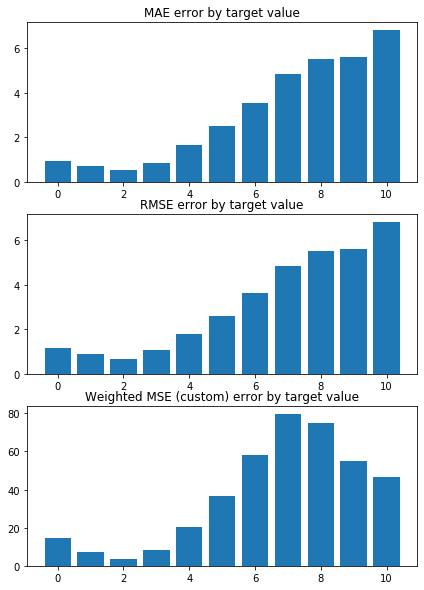

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0241944353840011 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0369695860788757 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


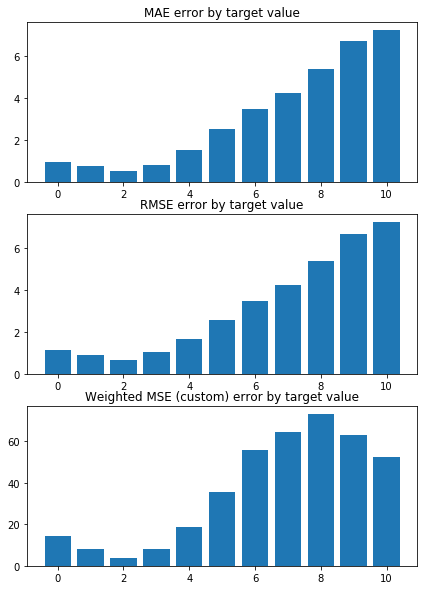

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0164292800861914 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0369455984694205 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


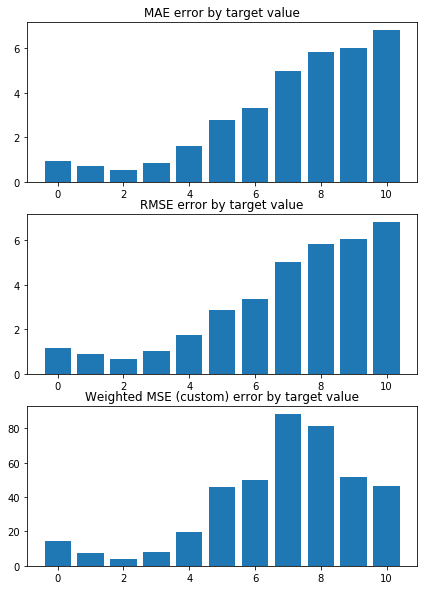

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9694767705994917 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0475927480067808 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


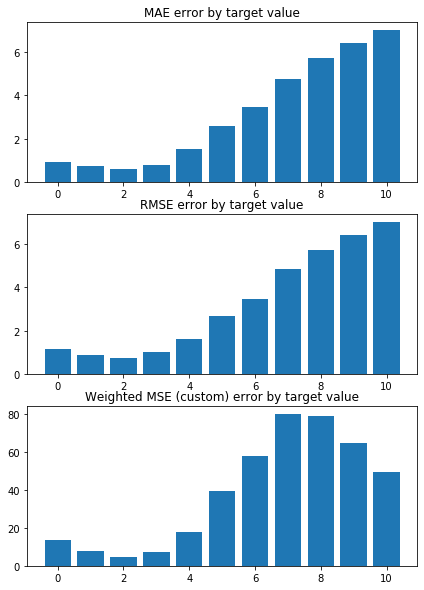

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0468790574525635 


 TRAIN PREDICTION Error
weighted_mse_train: 1.034092272859026 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


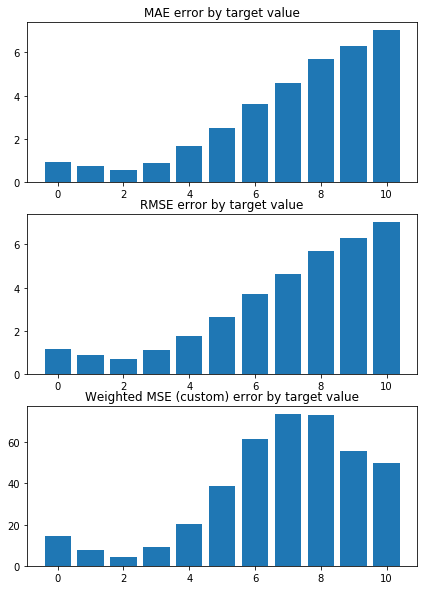

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1077739067676327 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0292319269230565 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


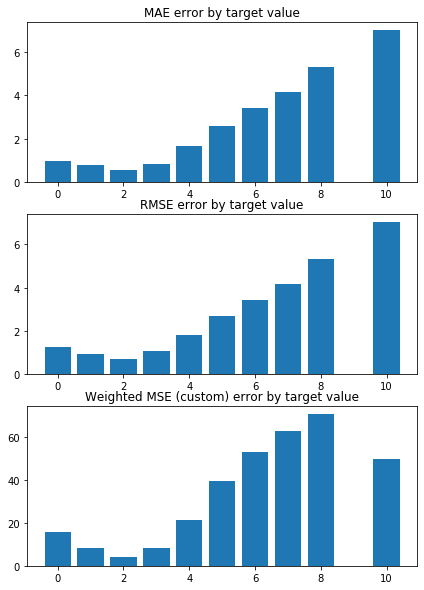

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0915037396678002 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0303146510021668 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


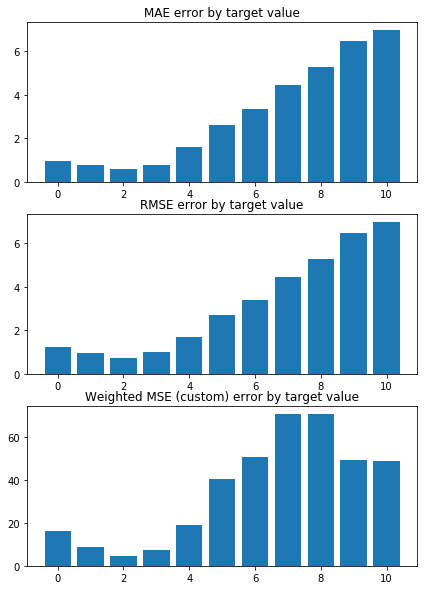

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0678776577720572 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0307899229422681 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


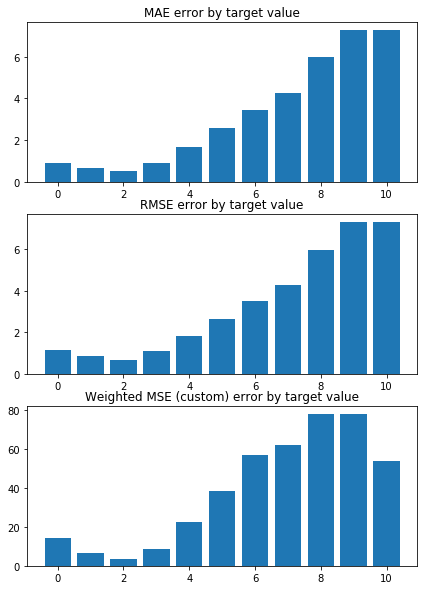

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.9798432680890309 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0408581667562893 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


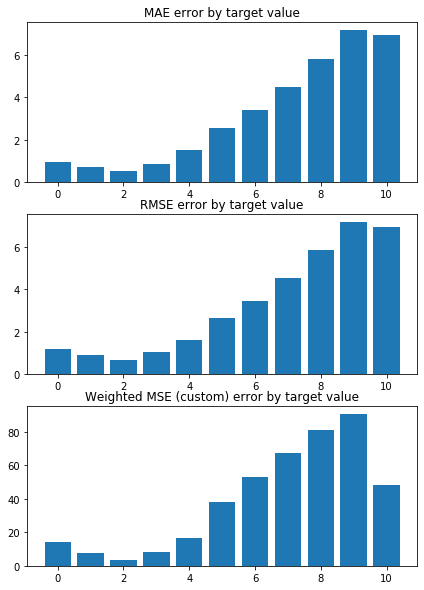

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.033905948366963 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0363814574513632 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


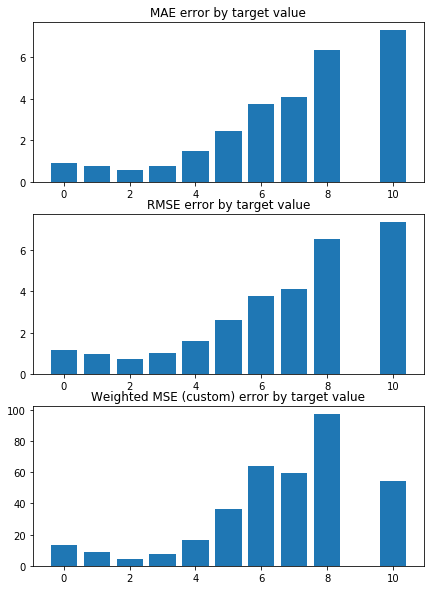

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.147985305393939 

Mean squared error on Test: 1.04 
 MSE mean test:  2.1528661754397356 

Root of MSE on Test: 1.02 
 1.4672648620612898 

Variance score on Test: 0.04 
 r2_test: 0.2725630747541377 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.15
MSE_test 2.15
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32  H3K36me1  \
0 -0.379771 -0.325154 -0.237024 -0.167701 -0.152068 -0.135371   
1 -0.387386 -0.326562 -0.249912 -0.163951 -0.145224 -0.121044   
2 -0.384067 -0.329160 -0.246424 -0.168132 -0.154788 -0.138728   
3 -0.379676 -0.342988 -0.253603 -0.161869 -0.145541 -0.136632   
4 -0.378424 -0.332127 -0.255910 -0.175677 -0.142906 -0.130321   
5 -0.374808 -0.330989 -0.256075 -0.163624 -0.143346 -0.130175   
6 -0.373663 -0.333353 -0.258084 -0.159730 -0.153280 -0.121130   
7 -0.380666 -0.330329 -0.230032 -0.173136 -0.138000 -0.141054   
8 -0.383915 -0.328066 -0.252667 -0.161207 -0.14874

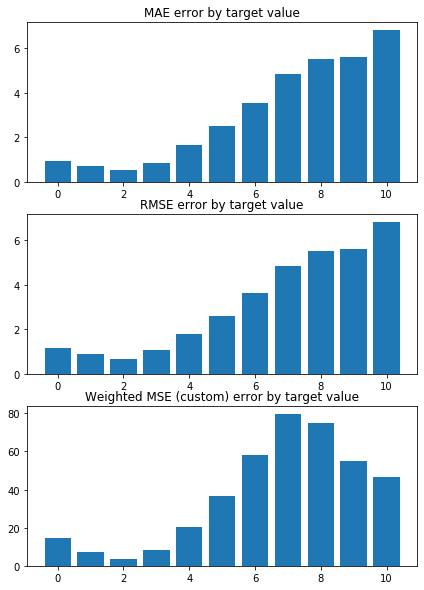

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0241899085980666 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0369607275521344 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


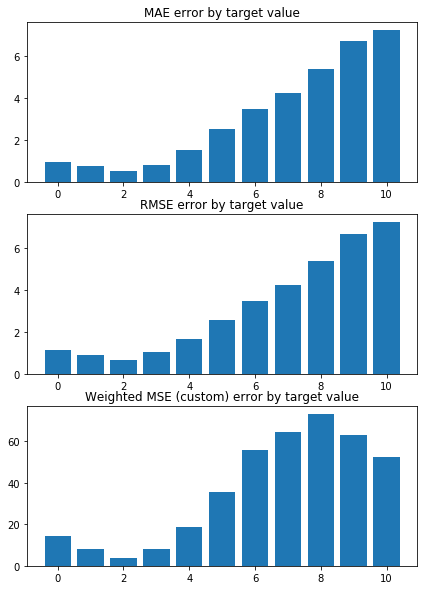

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0164168865350087 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0369377625430372 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


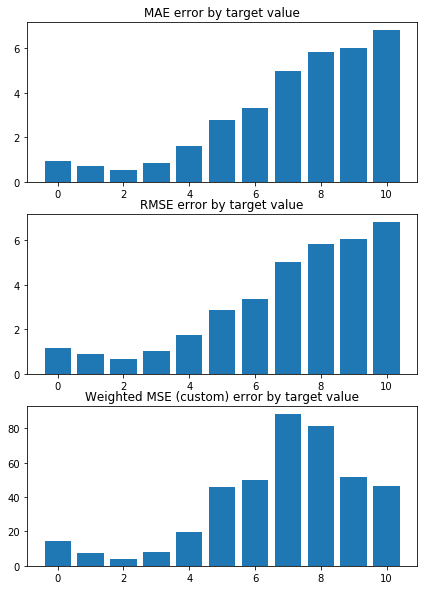

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9694647068104142 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0475839919175114 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


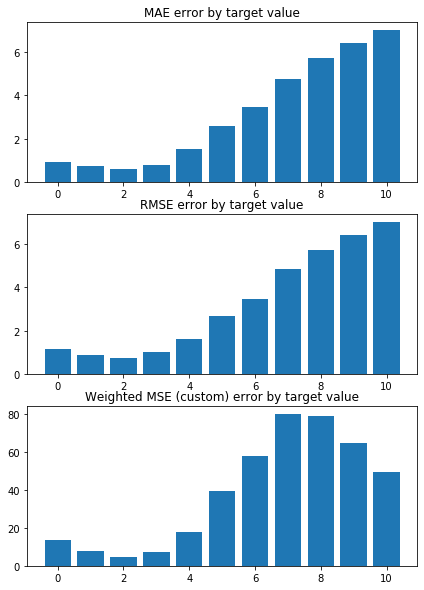

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.046869458886485 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0340838156611318 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


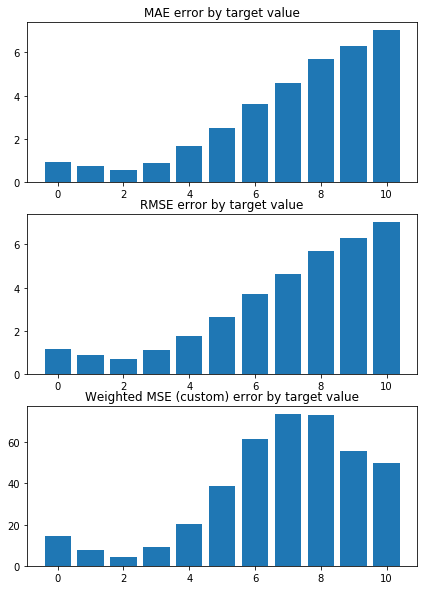

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1077663980758885 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0292240003883952 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


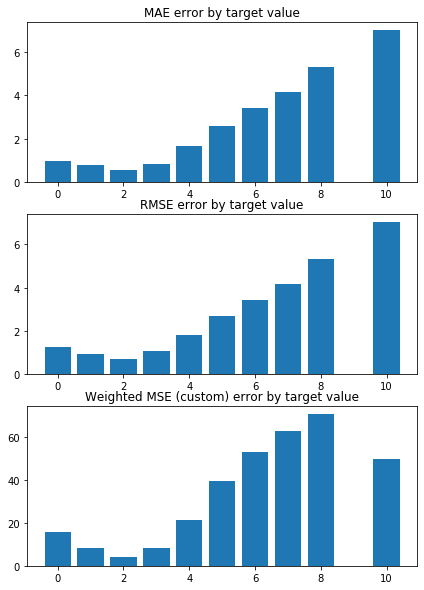

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0914957918154382 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0303061095005184 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


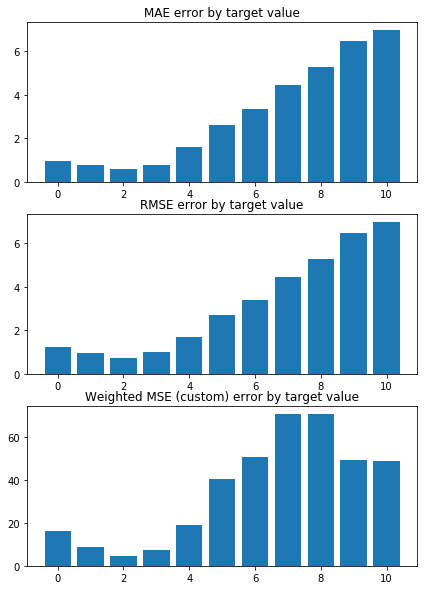

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0678699474150457 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0307815502193673 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


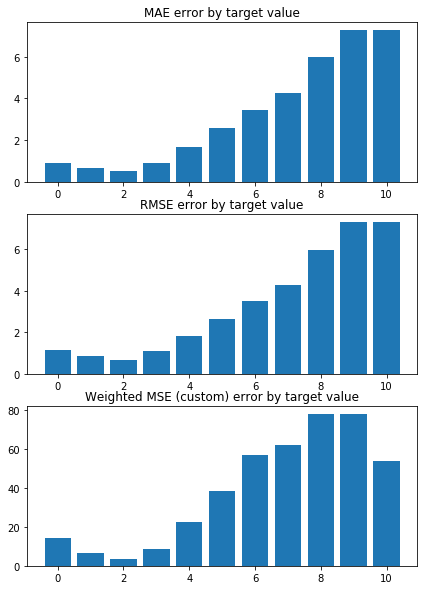

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.9798347829610088 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0408497366584102 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


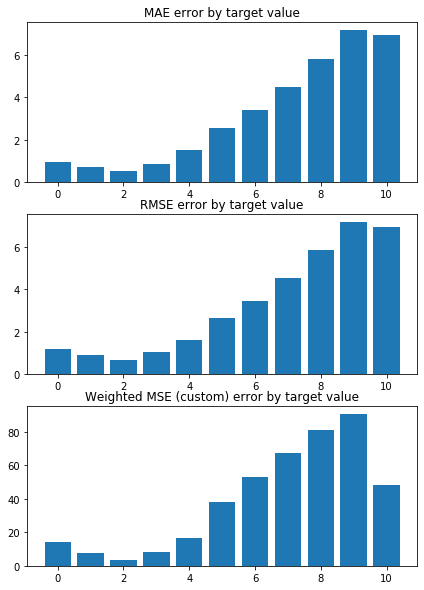

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0338943799167635 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0363727564354428 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


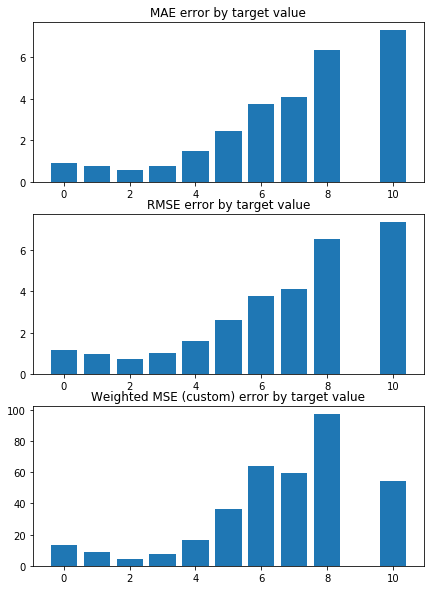

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.147985422683213 

Mean squared error on Test: 1.04 
 MSE mean test:  2.1528650989083777 

Root of MSE on Test: 1.02 
 1.4672644952115408 

Variance score on Test: 0.04 
 r2_test: 0.27256347168483674 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.15
MSE_test 2.15
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32  H3K36me1  \
0 -0.379655 -0.325069 -0.236936 -0.167673 -0.152031 -0.135306   
1 -0.387269 -0.326473 -0.249827 -0.163927 -0.145191 -0.120982   
2 -0.383949 -0.329071 -0.246338 -0.168107 -0.154749 -0.138661   
3 -0.379560 -0.342898 -0.253511 -0.161846 -0.145507 -0.136567   
4 -0.378309 -0.332044 -0.255805 -0.175651 -0.142872 -0.130262   
5 -0.374695 -0.330900 -0.255987 -0.163601 -0.143313 -0.130113   
6 -0.373548 -0.333267 -0.257974 -0.159706 -0.153244 -0.121073   
7 -0.380549 -0.330238 -0.229963 -0.173109 -0.137967 -0.140984   
8 -0.383796 -0.327979 -0.252576 -0.161184 -0.1487

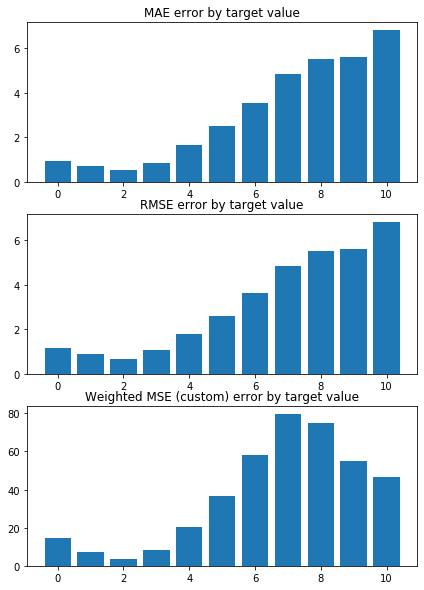

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0241853914113905 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0369518868873748 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


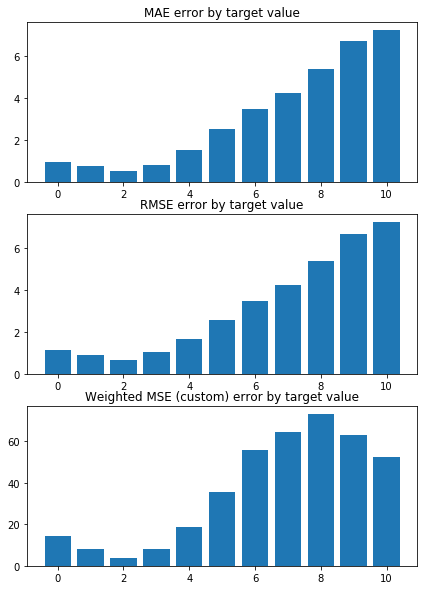

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0164045158013115 


 TRAIN PREDICTION Error
weighted_mse_train: 1.036929944157375 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


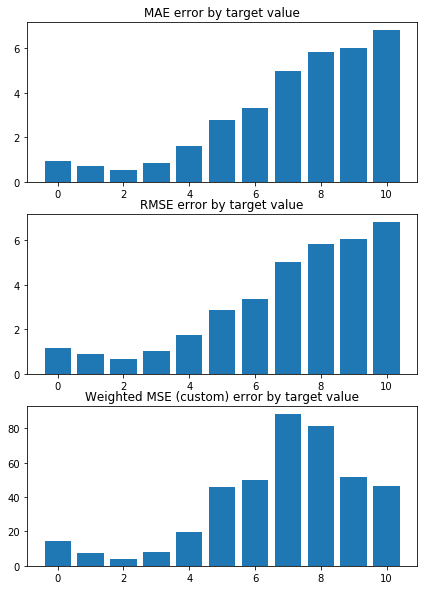

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9694526638784349 


 TRAIN PREDICTION Error
weighted_mse_train: 1.047575254676167 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


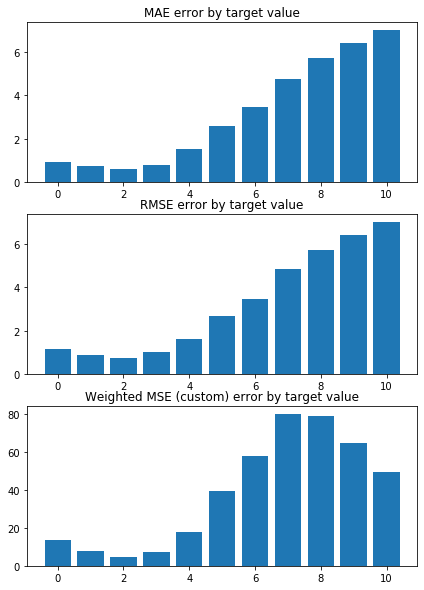

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0468598826320497 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0340753778939278 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


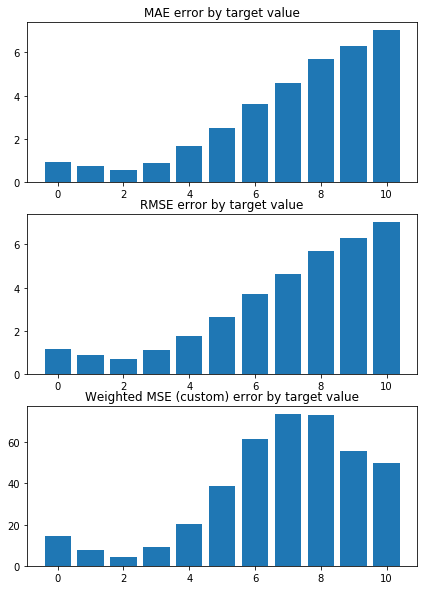

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.107758906370784 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0292160905532495 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


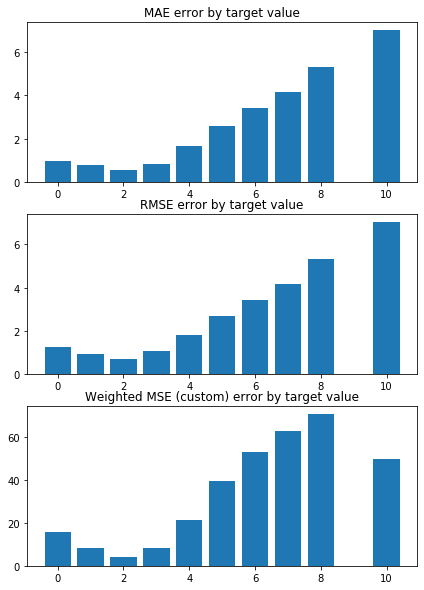

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0914878674563286 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0302975885553465 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


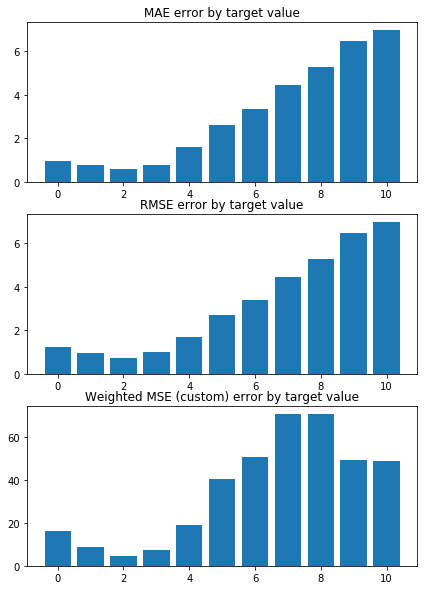

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0678622477763364 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0307731944615333 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


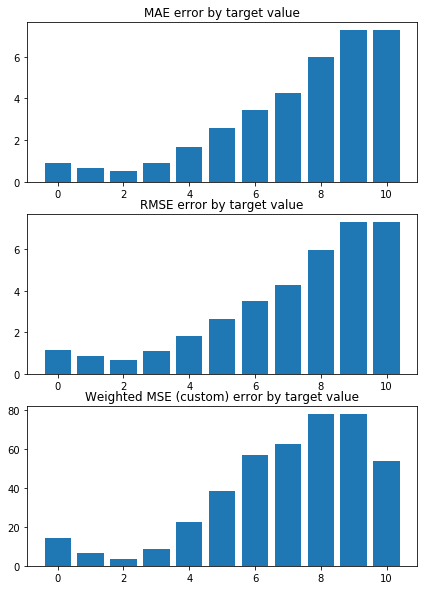

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.9798263170634919 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0408413247943769 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


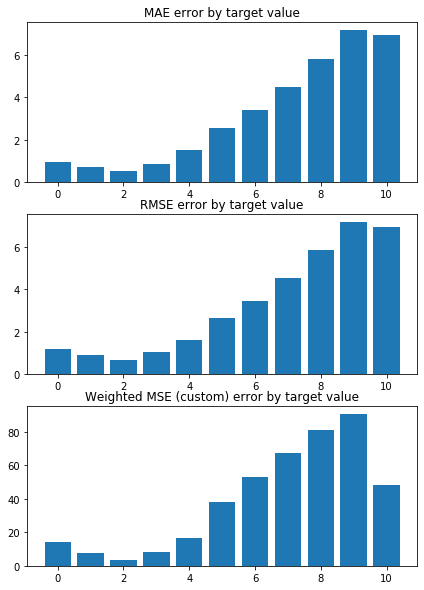

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0338828395537472 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0363640748978016 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


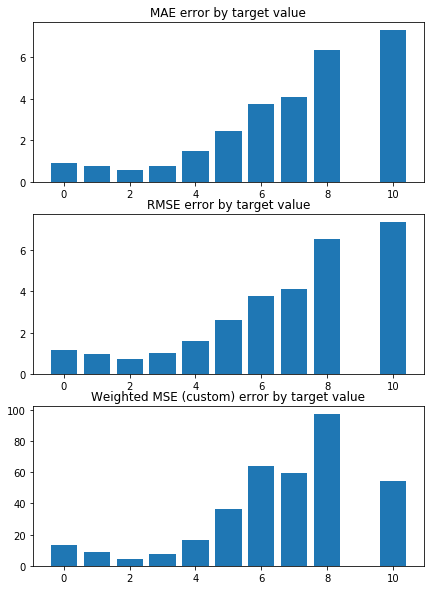

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.147985557731219 

Mean squared error on Test: 1.04 
 MSE mean test:  2.152864042000084 

Root of MSE on Test: 1.02 
 1.467264135048657 

Variance score on Test: 0.04 
 r2_test: 0.27256386192934184 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.15
MSE_test 2.15
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32  H3K36me1  \
0 -0.379539 -0.324985 -0.236848 -0.167646 -0.151994 -0.135241   
1 -0.387151 -0.326385 -0.249742 -0.163904 -0.145157 -0.120921   
2 -0.383832 -0.328982 -0.246252 -0.168081 -0.154710 -0.138594   
3 -0.379444 -0.342808 -0.253419 -0.161822 -0.145473 -0.136502   
4 -0.378194 -0.331961 -0.255700 -0.175624 -0.142839 -0.130203   
5 -0.374583 -0.330811 -0.255899 -0.163578 -0.143280 -0.130052   
6 -0.373434 -0.333182 -0.257864 -0.159682 -0.153208 -0.121017   
7 -0.380432 -0.330147 -0.229894 -0.173082 -0.137934 -0.140914   
8 -0.383678 -0.327892 -0.252484 -0.161161 -0.148671

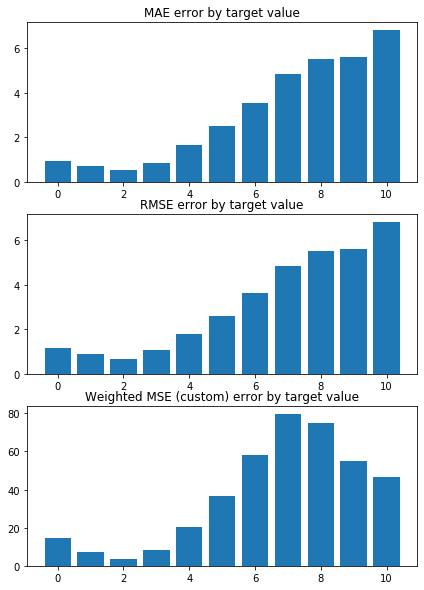

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.024180883802852 


 TRAIN PREDICTION Error
weighted_mse_train: 1.036943064029142 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


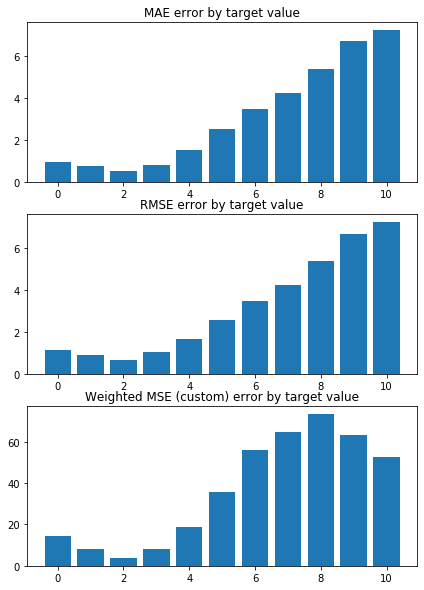

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.016392167812655 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0369221432542715 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


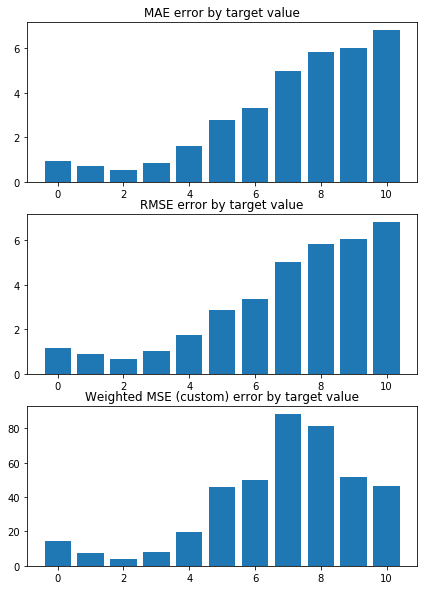

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9694406417393645 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0475665362193083 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


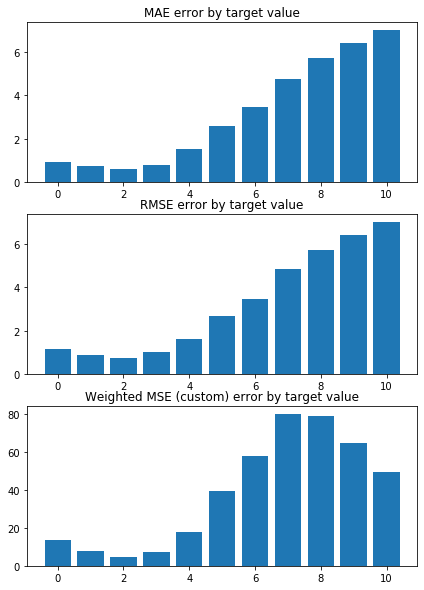

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0468503285995705 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0340669594842125 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


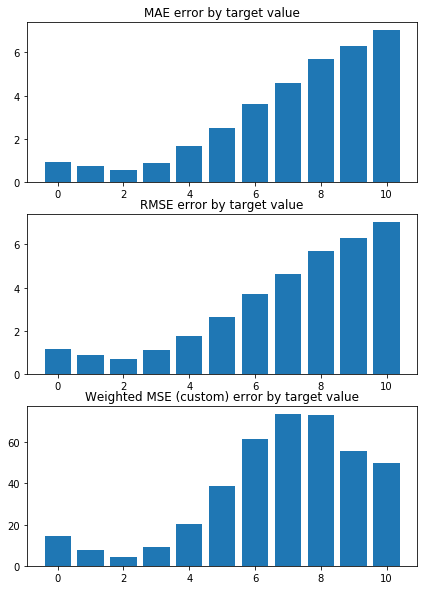

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1077514315869974 


 TRAIN PREDICTION Error
weighted_mse_train: 1.02920819736529 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


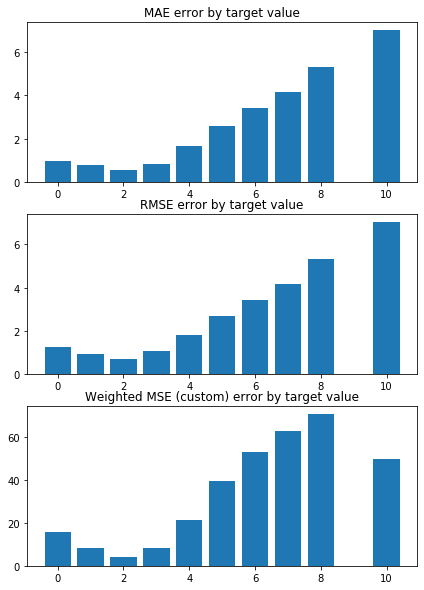

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.091479966484345 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0302890880838478 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


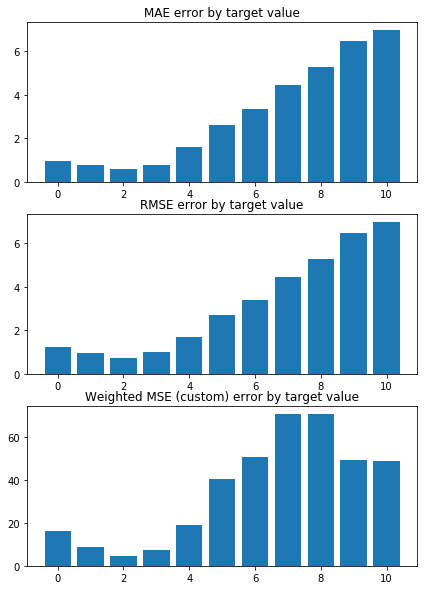

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0678545588477788 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0307648556182538 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


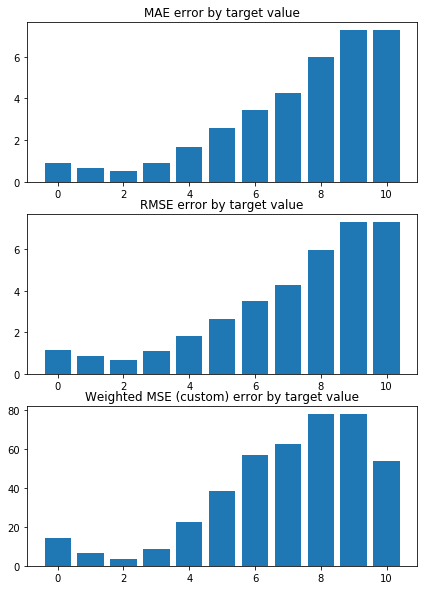

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.9798178703362037 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0408329311035445 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


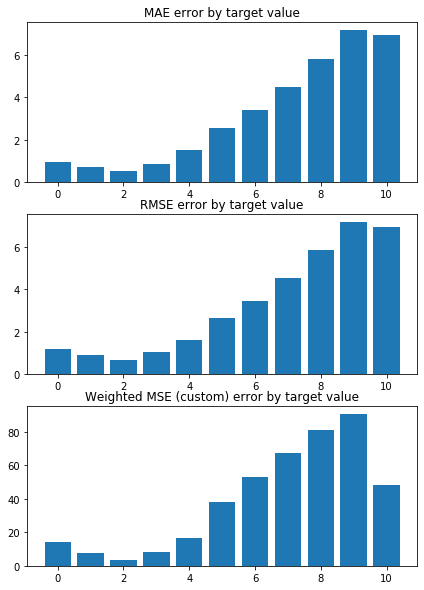

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.033871327156617 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0363554127642154 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


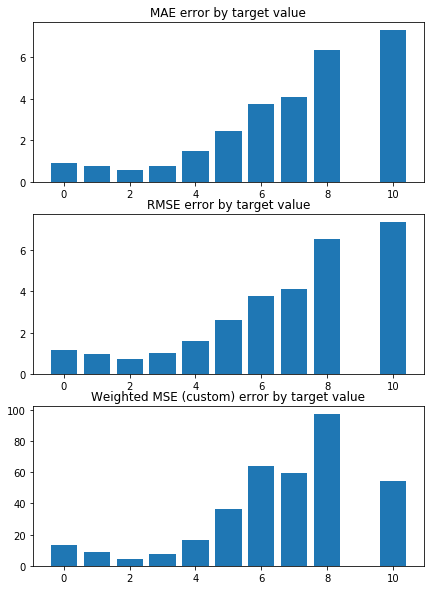

Weighted Mean squared error on Train: 1.04 
 MSE mean train: 2.147985710463143 

Mean squared error on Test: 1.04 
 MSE mean test:  2.1528630046322004 

Root of MSE on Test: 1.02 
 1.4672637815444776 

Variance score on Test: 0.04 
 r2_test: 0.27256424551573233 

wMSE_train 1.04
wMSE_test 1.04
MSE_train 2.15
MSE_test 2.15
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32  H3K36me1  \
0 -0.379424 -0.324900 -0.236761 -0.167619 -0.151956 -0.135177   
1 -0.387033 -0.326297 -0.249657 -0.163880 -0.145124 -0.120860   
2 -0.383715 -0.328893 -0.246167 -0.168056 -0.154672 -0.138527   
3 -0.379329 -0.342718 -0.253328 -0.161798 -0.145439 -0.136436   
4 -0.378080 -0.331878 -0.255596 -0.175598 -0.142805 -0.130144   
5 -0.374470 -0.330722 -0.255812 -0.163555 -0.143247 -0.129990   
6 -0.373320 -0.333096 -0.257755 -0.159657 -0.153172 -0.120960   
7 -0.380315 -0.330056 -0.229825 -0.173054 -0.137901 -0.140844   
8 -0.383560 -0.327805 -0.252394 -0.161138 -0.1486

MSE_test_mean  MSE_test_std  MSE_train_mean  MSE_train_std comments  \
0       2.152874      0.153304        2.147985       0.017038        -   
1       2.152872      0.153307        2.147985       0.017038        -   
2       2.152871      0.153308        2.147985       0.017038        -   
3       2.152870      0.153308        2.147985       0.017038        -   
4       2.152868      0.153309        2.147985       0.017038        -   
5       2.152867      0.153310        2.147985       0.017038        -   
6       2.152866      0.153311        2.147985       0.017038        -   
7       2.152865      0.153311        2.147985       0.017038        -   
8       2.152864      0.153312        2.147986       0.017038        -   
9       2.152863      0.153313        2.147986       0.017038        -   

                                               model    model_name  n_splits  \
0  Ridge(alpha=0, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
1  Ridge(alpha=1, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
2  Ridge(alpha=2, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
3  Ridge(alpha=3, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
4  Ridge(alpha=4, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
5  Ridge(alpha=5, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
6  Ridge(alpha=6, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
7  Ridge(alpha=7, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
8  Ridge(alpha=8, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
9  Ridge(alpha=9, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   

                   params                                            r2_test  \
0  test_params = testtest  [0.2950612429309414, 0.2755801633331252, 0.288...   
1  test_params = testtest  [0.29505994805865654, 0.27557983736012726, 0.2...   
2  test_params = testtest  [0.29505864674726023, 0.275579508615837, 0.288...   
3  test_params = testtest  [0.29505733902941855, 0.2755791771059324, 0.28...   
4  test_params = testtest  [0.29505602493754546, 0.27557884283607637, 0.2...   
5  test_params = testtest  [0.2950547045038049, 0.2755785058119169, 0.288...   
6  test_params = testtest  [0.2950533777601144, 0.27557816603908714, 0.28...   
7  test_params = testtest  [0.29505204473814783, 0.27557782352320526, 0.2...   
8  test_params = testtest  [0.295050705469337, 0.27557747826987544, 0.288...   
9  test_params = testtest  [0.2950493599848757, 0.2755771302846879, 0.288...   

   wMSE_test_mean  wMSE_test_std  wMSE_train_mean  wMSE_train_std  
0        1.038213       0.041810         1.035570        0.005313  
1        1.038200       0.041810         1.035558        0.005318  
2        1.038191       0.041811         1.035549        0.005318  
3        1.038181       0.041812         1.035541        0.005318  
4        1.038172       0.041813         1.035532        0.005317  
5        1.038163       0.041814         1.035524        0.005317  
6        1.038154       0.041815         1.035515        0.005317  
7        1.038145       0.041816         1.035507        0.005317  
8        1.038136       0.041817         1.035499        0.005317  
9        1.038127       0.041817         1.035490        0.005317

In [140]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

alpha_grid = np.arange(0, 10, 1)
# Create linear regression object



model_name = 'LR+L2_grid10'
n_splits = 10
random_state = 16 
shuffle = True

wmse_test = []
wmse_train = []

results_pd_gr = pd.DataFrame()

for alpha in alpha_grid:
    model = linear_model.Ridge(alpha=alpha)

    lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                    weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                    rmse_test, rmse_train, rmse_test_const, \
                    mae_test,    mae_train,  mae_test_const, \
                    results_pd_gr = train_test_KFold(X, y, 
                                                  model, model_name, results_pd_gr,
                                                  n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    wmse_test.append(np.mean(weighted_mse_test_all))
    wmse_train.append(np.mean(weighted_mse_train_all))

results_pd_gr

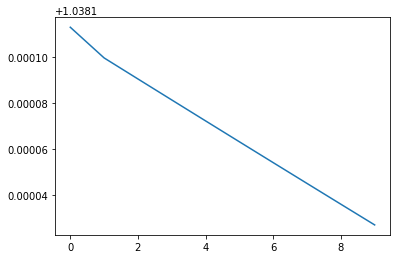

In [141]:
plt.plot(alpha_grid, wmse_test)

In [142]:
wmse_test

[1.0382130015758642,
 1.0381996770097497,
 1.038190543125125,
 1.0381814289205873,
 1.0381723343264138,
 1.038163259273348,
 1.0381542036925957,
 1.0381451675158184,
 1.0381361506751303,
 1.0381271531030922]

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0399638666669133 


 TRAIN PREDICTION Error
weighted_mse_train: 1.028353533002462 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5084857885756024
test sizes =  1785 1785 1785


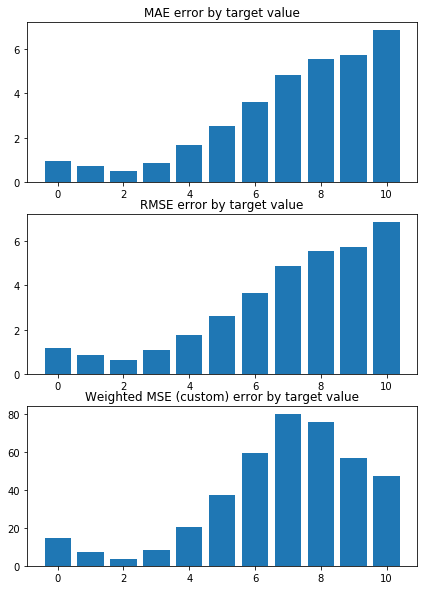

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0223880166763317 


 TRAIN PREDICTION Error
weighted_mse_train: 1.032759252159285 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


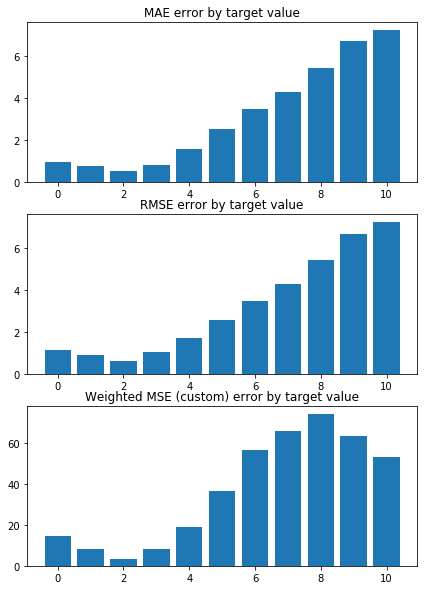

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.01000161143641 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0335513027435552 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


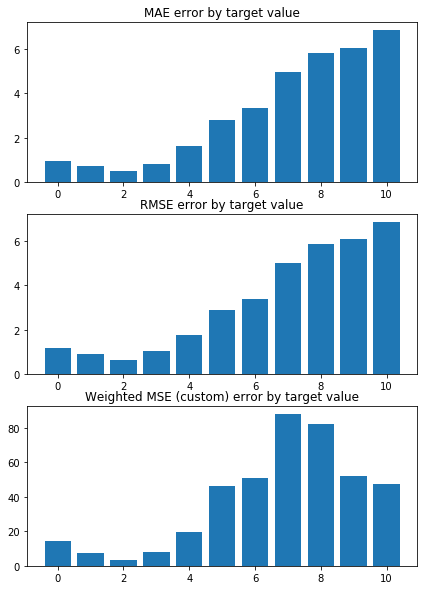

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.963020000740201 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0436156660438836 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


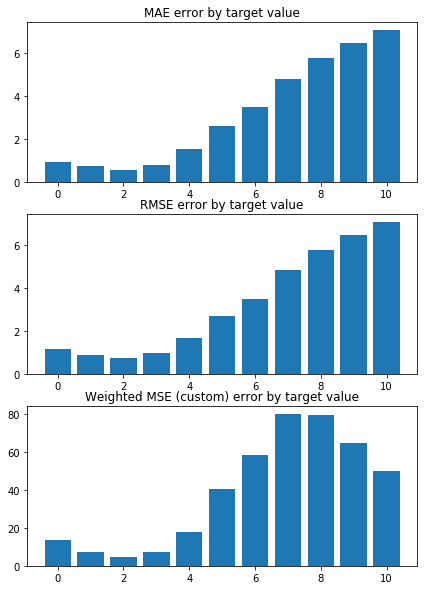

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.04255104784822 


 TRAIN PREDICTION Error
weighted_mse_train: 1.030363614018302 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


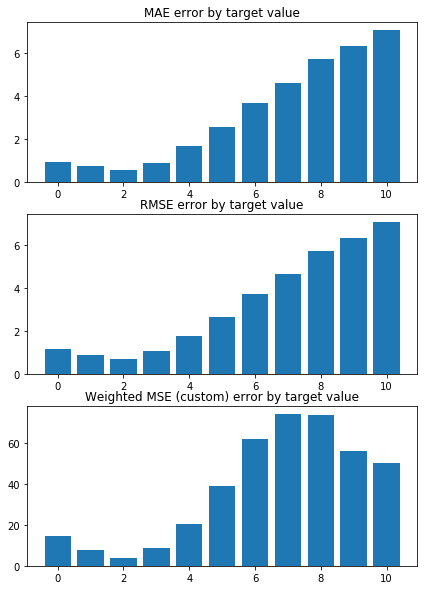

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1043194508188845 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0256402632559523 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


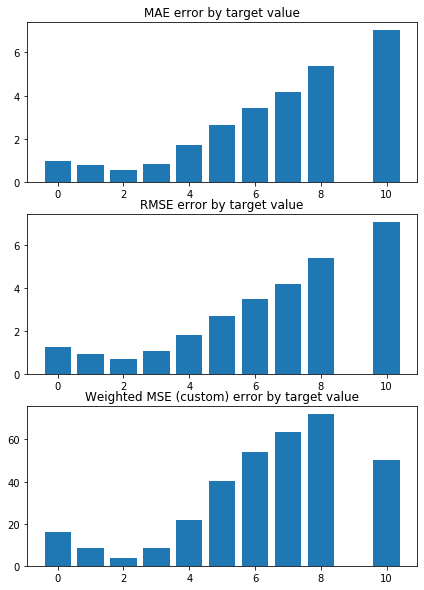

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0886209949470511 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0266140177238514 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


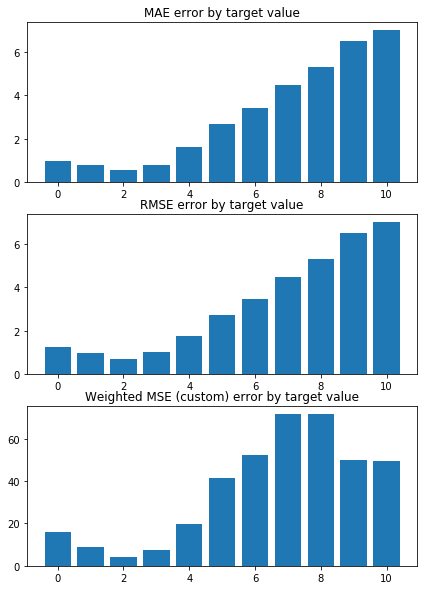

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0637230135879707 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0268655163938336 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


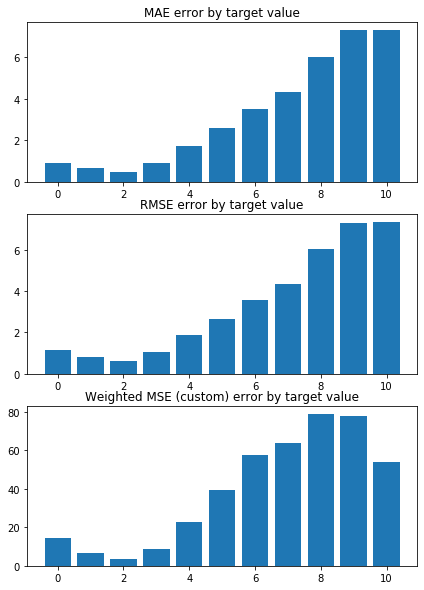

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.9763028956837794 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0370455085239103 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


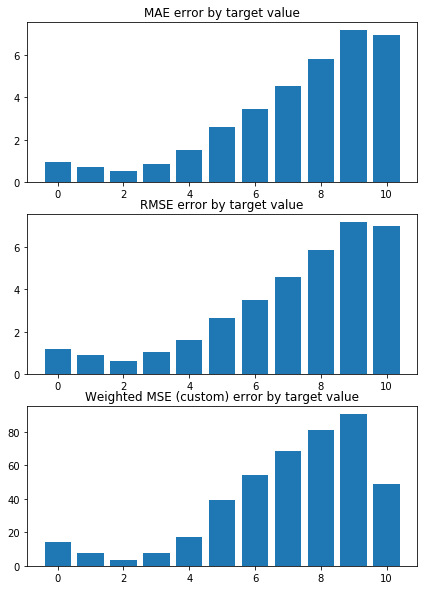

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0286580624033823 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0324150543144064 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


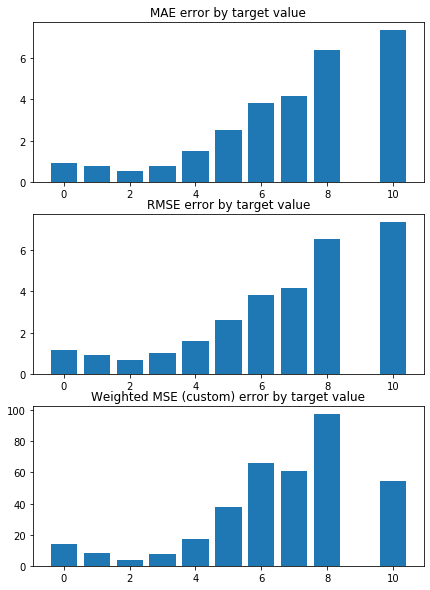

Weighted Mean squared error on Train: 1.03 
 MSE mean train: 2.1518828704764656 

Mean squared error on Test: 1.03 
 MSE mean test:  2.156007965599178 

Root of MSE on Test: 1.02 
 1.4683350999002844 

Variance score on Test: 0.04 
 r2_test: 0.2715187442205574 

wMSE_train 1.03
wMSE_test 1.03
MSE_train 2.15
MSE_test 2.16
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32  H3K27me1  H3K36me1  \
0 -0.302123 -0.260040 -0.194344 -0.146614 -0.128399 -0.099714 -0.094002   
1 -0.308022 -0.260907 -0.205152 -0.145434 -0.123900 -0.094188 -0.082497   
2 -0.305321 -0.262021 -0.203057 -0.148011 -0.129831 -0.095698 -0.096393   
3 -0.301800 -0.274190 -0.207084 -0.143468 -0.123837 -0.093931 -0.094887   
4 -0.301340 -0.266383 -0.204720 -0.154681 -0.121551 -0.095219 -0.091896   
5 -0.299028 -0.264011 -0.209861 -0.145256 -0.122463 -0.094774 -0.091097   
6 -0.297359 -0.266682 -0.204937 -0.140740 -0.129927 -0.097788 -0.084733   
7 -0.302546 -0.263407 -0.193521 -0.

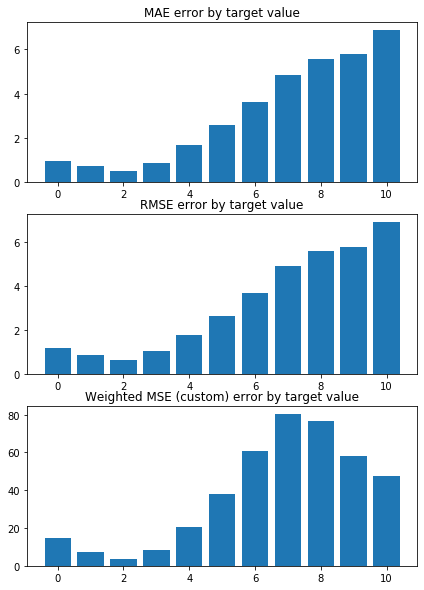

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0225237882416716 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0318722538649092 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


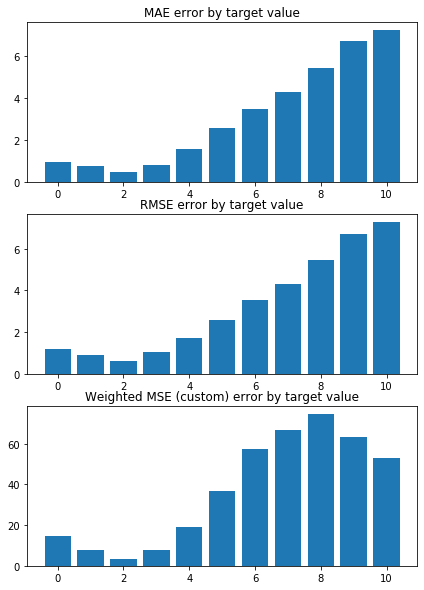

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.007996768627008 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0332135635404212 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


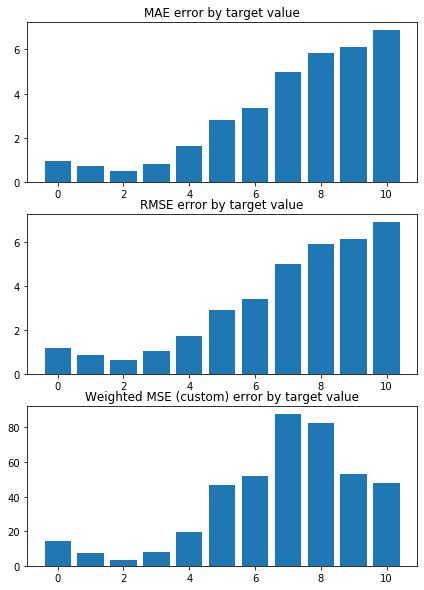

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9608770042500597 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0429647538366518 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


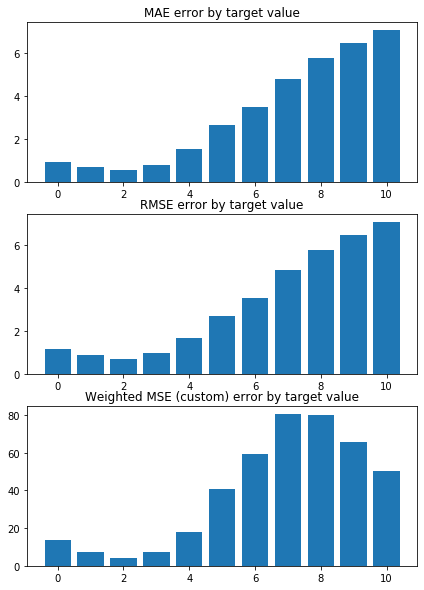

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0417602457912383 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0298375781244065 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


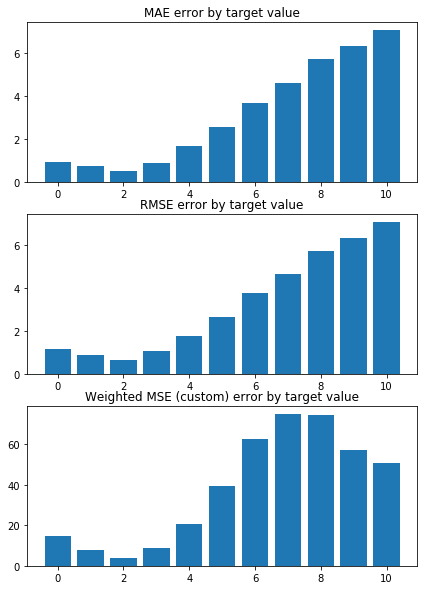

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1035725091125228 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0251170968568817 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


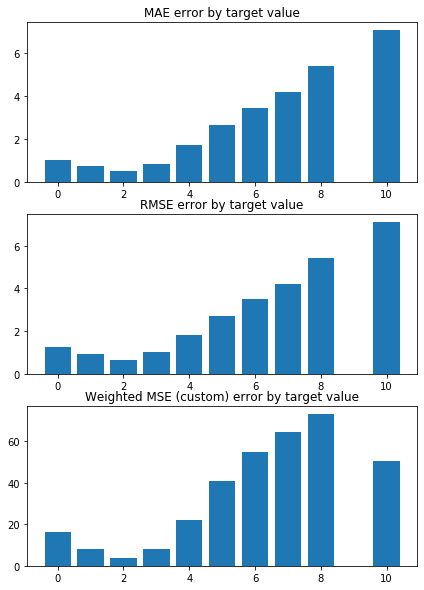

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.088588510341098 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0260874938645967 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


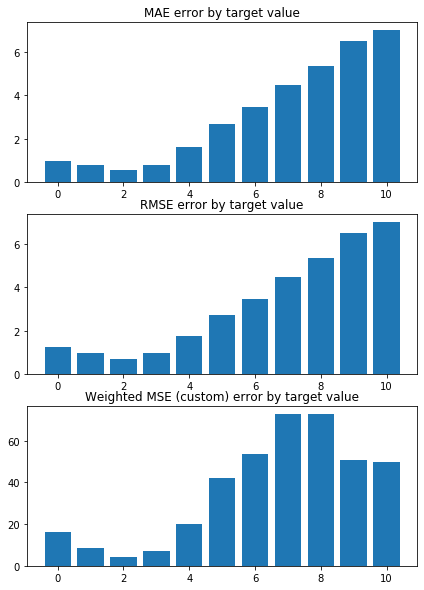

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.062551269047134 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0261166503880184 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


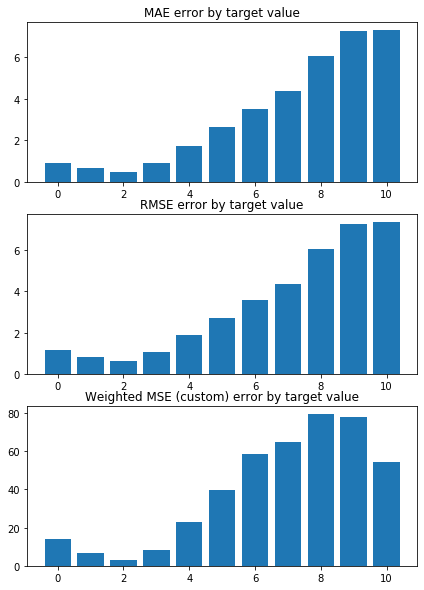

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.9761693991320164 


 TRAIN PREDICTION Error
weighted_mse_train: 1.036428940887779 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


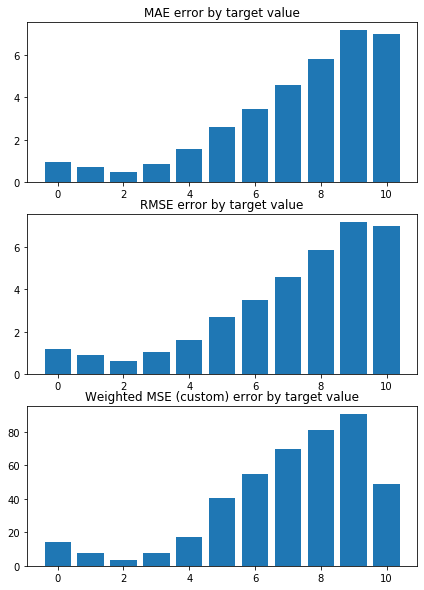

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0274560859142563 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0316920498836752 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


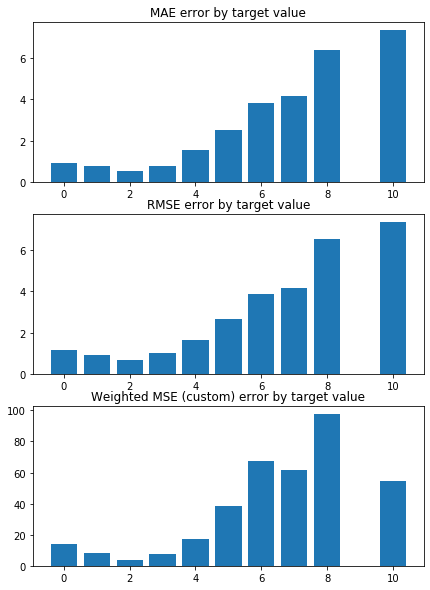

Weighted Mean squared error on Train: 1.03 
 MSE mean train: 2.1575189660475553 

Mean squared error on Test: 1.03 
 MSE mean test:  2.161216209979456 

Root of MSE on Test: 1.02 
 1.4701075504803913 

Variance score on Test: 0.04 
 r2_test: 0.26976325596507944 

wMSE_train 1.03
wMSE_test 1.03
MSE_train 2.16
MSE_test 2.16
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32  H3K27me1   H3K4me3  \
0 -0.260600 -0.223945 -0.174735 -0.132504 -0.116577 -0.101521 -0.095427   
1 -0.265329 -0.225176 -0.183191 -0.132511 -0.113195 -0.096644 -0.092532   
2 -0.263157 -0.225123 -0.182209 -0.134233 -0.117313 -0.098753 -0.088343   
3 -0.260066 -0.235850 -0.184996 -0.130904 -0.112904 -0.096440 -0.095608   
4 -0.260021 -0.229175 -0.181910 -0.140101 -0.110954 -0.098236 -0.088496   
5 -0.258253 -0.227179 -0.187134 -0.132431 -0.112043 -0.097660 -0.091130   
6 -0.256757 -0.229487 -0.181622 -0.127813 -0.117961 -0.100118 -0.094145   
7 -0.260905 -0.226998 -0.174958 -0

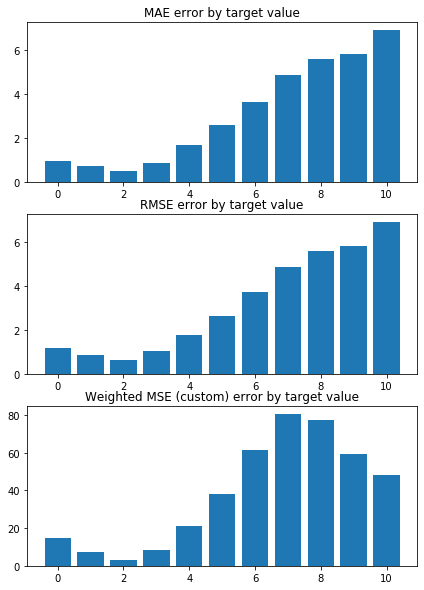

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0230731886889441 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0318550958981942 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5223866913238566
test sizes =  1785 1785 1785


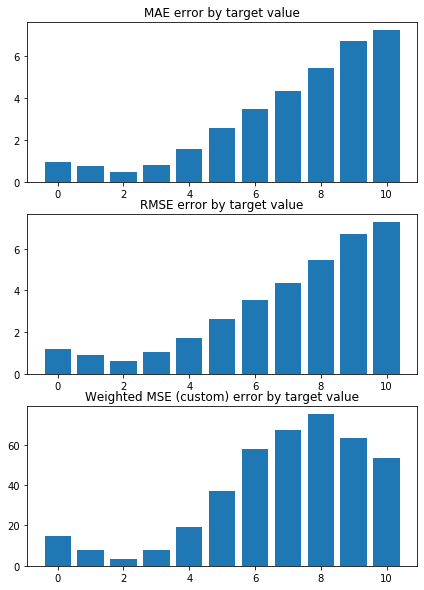

train_index= [    1     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0073041482766545 


 TRAIN PREDICTION Error
weighted_mse_train: 1.033601793661295 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4829104249189313
test sizes =  1785 1785 1785


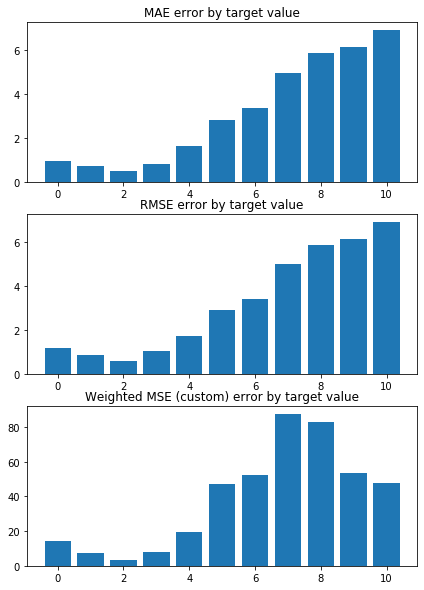

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 0.9600278945434532 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0431281545423123 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4244925388995253
test sizes =  1785 1785 1785


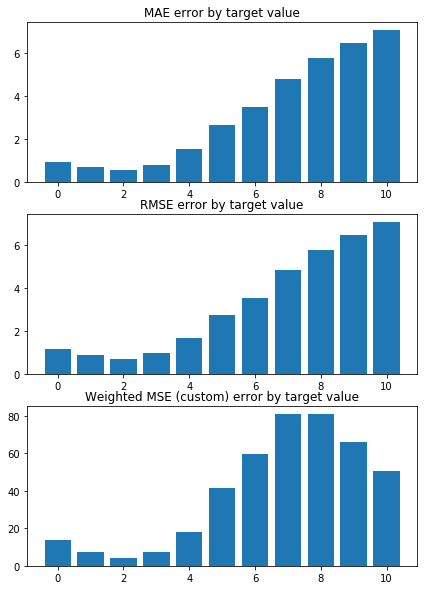

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0418582973434722 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0300810492429662 


 CONSTANT pred Error:
weighted_mse_test_const:  1.492735903069663
test sizes =  1785 1785 1785


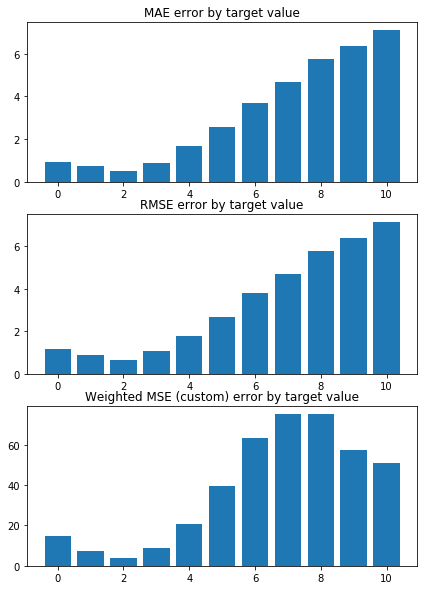

train_index= [    0     1     2 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.1035059632728232 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0253558067133346 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5334384341949743
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


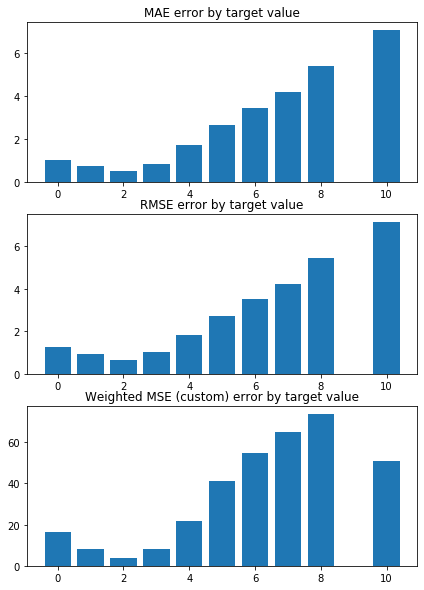

train_index= [    0     1     2 ... 17846 17847 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.088998629993452 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0263008716963358 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5139765180356128
test sizes =  1785 1785 1785


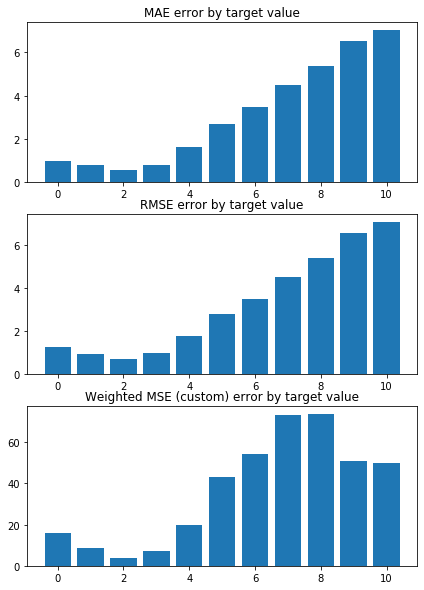

train_index= [    0     2     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0622806099298465 


 TRAIN PREDICTION Error
weighted_mse_train: 1.026186478948721 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5657406847615234
test sizes =  1785 1785 1785


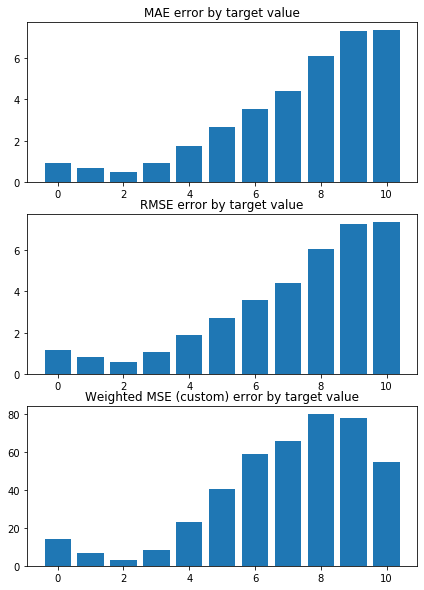

train_index= [    0     1     2 ... 17843 17847 17848]
 TEST PREDICTION Error
weighted_mse_test: 0.9768140351547742 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0365968586767549 


 CONSTANT pred Error:
weighted_mse_test_const:  1.46550533906606
test sizes =  1785 1785 1785


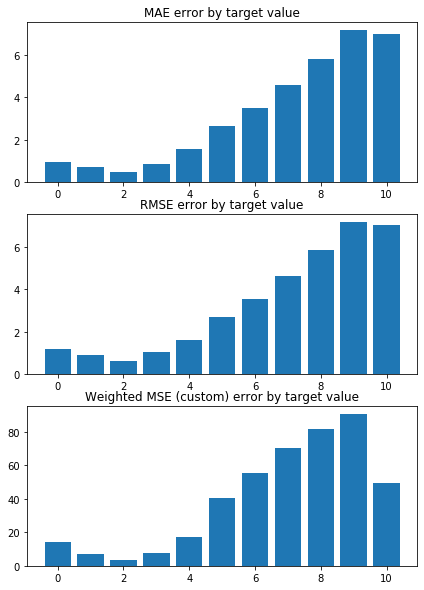

train_index= [    0     1     2 ... 17846 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.0272682234966857 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0317869752653073 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5204784209799074
test sizes =  1785 1785 1785


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


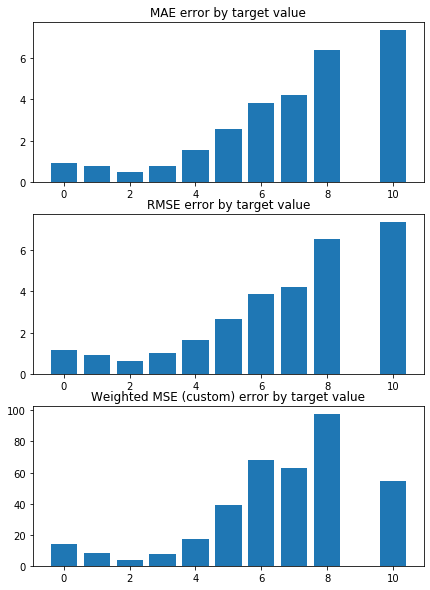

Weighted Mean squared error on Train: 1.03 
 MSE mean train: 2.162925598198112 

Mean squared error on Test: 1.03 
 MSE mean test:  2.166321401928578 

Root of MSE on Test: 1.02 
 1.4718428591152581 

Variance score on Test: 0.04 
 r2_test: 0.268038877870025 

wMSE_train 1.03
wMSE_test 1.03
MSE_train 2.16
MSE_test 2.17
MAE_train 0.98
MAE_test 0.99
r2_test 0.27
   H3K36me3     Chriz   H3K4me1       GAF   BEAF-32   H3K4me3  H3K27me1  \
0 -0.233579 -0.201348 -0.161658 -0.122194 -0.109094 -0.100043 -0.099393   
1 -0.237514 -0.202833 -0.168515 -0.122825 -0.106382 -0.098325 -0.094930   
2 -0.235698 -0.202054 -0.168164 -0.124028 -0.109431 -0.094064 -0.097358   
3 -0.232950 -0.211694 -0.170280 -0.121544 -0.105933 -0.100585 -0.094817   
4 -0.233121 -0.205708 -0.167093 -0.129238 -0.104270 -0.094055 -0.096883   
5 -0.231653 -0.204095 -0.171938 -0.122813 -0.105400 -0.096770 -0.096296   
6 -0.230413 -0.206164 -0.166621 -0.118270 -0.110295 -0.099199 -0.098314   
7 -0.233833 -0.204191 -0.162202 -0.12

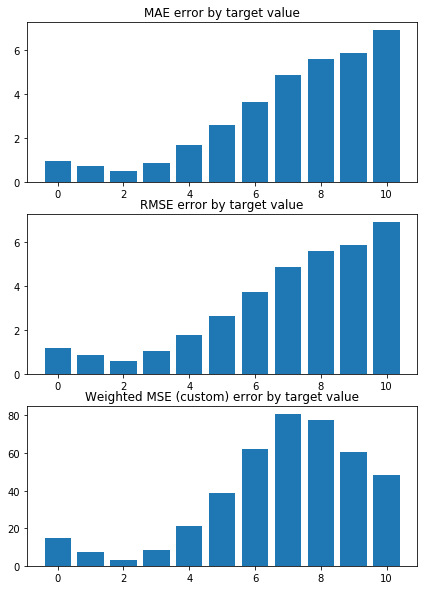

train_index= [    0     1     3 ... 17847 17848 17849]
 TEST PREDICTION Error
weighted_mse_test: 1.023720095954597 


 TRAIN PREDICTION Error


In [ ]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

alpha_grid = np.arange(1000, 10000, 1000)
# Create linear regression object



model_name = 'LR+L2_grid10000'
n_splits = 10
random_state = 16 
shuffle = True

wmse_test = []
wmse_train = []

results_pd_gr = pd.DataFrame()

for alpha in alpha_grid:
    model = linear_model.Ridge(alpha=alpha)

    lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                    weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                    rmse_test, rmse_train, rmse_test_const, \
                    mae_test,    mae_train,  mae_test_const, \
                    results_pd_gr = train_test_KFold(X, y, 
                                                  model, model_name, results_pd_gr,
                                                  n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    wmse_test.append(np.mean(weighted_mse_test_all))
    wmse_train.append(np.mean(weighted_mse_train_all))

results_pd_gr

In [ ]:
results_pd_gr

In [ ]:
plt.plot(alpha_grid, wmse_test)

In [ ]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# alpha_grid = np.arange(3000, 10000, 100)
# Create linear regression object


wmse_test = []
wmse_train = []

# for alpha in alpha_grid:
model = linear_model.Ridge(alpha=3000)


model_name = 'LR+L2_alf=3000'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)



wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


In [ ]:
coefs_argsort, np.sort(coefs)

In [ ]:
su_drsc.columns[2:][coefs_argsort[0]]

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS  + L2

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
%%time
n_splits=10
random_state=16

X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# alpha_grid = np.arange(3000, 10000, 100)
# Create linear regression object


wmse_test = []
wmse_train = []

# for alpha in alpha_grid:
model = linear_model.Ridge(alpha=2000)

model_name = 'LR+L2_alf=2000'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)

wmse_test.append(np.mean(weighted_mse_test_all))
wmse_train.append(np.mean(weighted_mse_train_all))


wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


In [ ]:
results_pd

In [ ]:
wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)

In [ ]:
su_drsc.columns[2:][coefs_argsort[0]]

In [ ]:
su_drsc.columns[2:], coefs

In [ ]:
coefs_argsort

In [ ]:
su_drsc.columns[2:][coefs_argsort[0]]

In [ ]:
coefs

In [ ]:
coefs_argsort, su_drsc.columns[2:][coefs_argsort[0]], np.sort(coefs)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# K-fold cross Validation - RL + L1  + L2/1 

In [ ]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.ElasticNet()

model_name = 'LR+L1+L2'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)

wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


In [ ]:
results_pd

In [ ]:
weighted_mse_train_all, weighted_mse_test_all

In [ ]:
print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


In [ ]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object

alpha =  0.2 # 3000 + 0.2
l1_ratio = 0.5 # 0.000066 # 0.2 / (3000 + 0.2)

model = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True, normalize=False, precompute=False, max_iter=1000, 
                                copy_X=True, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')


model_name = 'LR+L2_alf=.2_rat=.5'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)


wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


In [ ]:
results_pd

In [ ]:
print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)

In [ ]:
coefs_pd = pd.DataFrame(coefs, columns=su_drsc.columns[2:][coefs_argsort][0])
coefs_pd.round(2)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS 

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2


$$ \frac{1}{(2  n_{samples})} ||y - Xw||^2_2
+ alpha * l1_{ratio}  ||w||_1
+ 0.5 * alpha * (1 - l1_{ratio}) ||w||^2_2 $$



$$ \frac{1}{ n\_samples} ||y - Xw||^2_2
+ \alpha ||w||_1
+ \beta ||w||^2_2 $$

$$ \frac{1}{ n\_samples} ||y - Xw||^2_2 + \alpha ||w||_1 + \beta ||w||^2_2 $$

In [ ]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.LinearRegression()

model_name = 'LR'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)

wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)



In [ ]:
results_pd

In [ ]:
coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]]

In [ ]:
coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]].iloc[0]

In [ ]:
plt.plot(coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]].iloc[0])

# !! одинаковая приоритизация 

In [ ]:
np.sort(coefs[0])

In [ ]:
pd.DataFrame(coefs_argsort, columns=su_drsc.columns[2:][coefs_argsort[0]])

In [ ]:
su_drsc.columns[2:][coefs_argsort[0]]

In [ ]:
coefs_df = pd.DataFrame(coefs, columns=su_drsc.columns[2:])[su_drsc.columns[2:][coefs_argsort[0]]]

coefs_df

In [ ]:
coefs_df.round(2)

In [ ]:
# !! одинаковая приоритизация 

np.sort(coefs[0])

coefs

coefs_argsort[0]

pd.DataFrame(coefs_argsort, columns=su_drsc.columns[2:][coefs_argsort[0]])

su_drsc.columns[2:], su_drsc.columns[2:][coefs_argsort[0]]

coefs_df = pd.DataFrame(coefs, columns=su_drsc.columns[2:])[su_drsc.columns[2:][coefs_argsort[0]]]

coefs_df

coefs_df.round(2)

In [ ]:
coefs_df

In [ ]:
coefs_df_2 = coefs_df.round(2)
coefs_df_2

In [ ]:
coefs_means = pd.DataFrame ( coefs_df.mean() )
coefs_means.round(2)# .values, coefs_means.values

In [ ]:
coefs_std = pd.DataFrame (coefs_df.std())

coefs_std.round(4)

In [ ]:
order_df = np.argsort(np.abs(coefs_means))
priority_order = order_df.index.values

priority_order


In [ ]:
coefs_df_2[priority_order]

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS + L 

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2


$$ \frac{1}{(2  n_{samples})} ||y - Xw||^2_2
+ alpha * l1_{ratio}  ||w||_1
+ 0.5 * alpha * (1 - l1_{ratio}) ||w||^2_2 $$



$$ \frac{1}{ n\_samples} ||y - Xw||^2_2
+ \alpha ||w||_1
+ \beta ||w||^2_2 $$

$$ \frac{1}{ n\_samples} ||y - Xw||^2_2 + \alpha ||w||_1 + \beta ||w||^2_2 $$

In [ ]:
def getConfIdxFrequencies(coefs_argsort, feature_names, row_lim, min_lim = 5, max_lim = 5):
    ''' 
    Get Frequencies of feature indexes in the sorted array of indexes bu the coefficient of the feature in different itterstions.
    The smallest and the biggest elements are valueable - as they give the biggest impact.
    min_lim, max_lim - limitations of the number of smallest and biggest coefficients to consider for the frequency.
    '''
    merged_coefs = np.concatenate(np.hstack([coefs_argsort[:row_lim,:min_lim], coefs_argsort[:row_lim,-max_lim:]]))

    merged_coefs = list(merged_coefs)

    featur_freq_dict =  dict((i, merged_coefs.count(i)) for i in merged_coefs)
    for key, value in  sorted(featur_freq_dict.items(), key=lambda item: (-item[1], item[0])):
        print("{}: {}".format(feature_names[key], value)) # (feature_names[key], value))
        
    return featur_freq_dict

In [ ]:
feature_names = su_drsc.columns[2:]
feature_names

In [ ]:
featur_freq_dict = getConfIdxFrequencies(coefs_argsort,feature_names=feature_names, row_lim=len(coefs_argsort), min_lim = 3, max_lim = 0)

In [ ]:
featur_freq_dict = getConfIdxFrequencies(coefs_argsort,feature_names=feature_names, row_lim=len(coefs_argsort), min_lim = 5, max_lim = 0)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# CONST pred

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# CONSTANT pred Error:

In [ ]:

print(" CONSTANT pred Error:" )

const_pred = np.mean(y_train)
const_pred_test = np.array([const_pred] * len(y_test) )


const_pred_train = np.array([const_pred] * len(y_train) )


# rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

# mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

print("weighted_mse_train_const: ", weighted_mse_train_const )

print("weighted_mse_test_const: ", weighted_mse_test_const )





In [ ]:

def train_test_KFold_const(X, y, n_splits=10, random_state=16, shuffle=True):


    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    kf.get_n_splits(X)

    MSE_train = []
    MSE_test = []
    r2_test = []

    coefs = []
    coefs_argsort = []
    
    weighted_mse_test_all = []
    weighted_mse_train_all = []


    print(kf)  

    for train_index, test_index in kf.split(X):
        
        print('train_index=', train_index)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

#         # Train the model using the training sets
#         model.fit(X_train, y_train)

#         # Make predictions using the train set
#         y_pred_train = model.predict(X_train)

#         # Make predictions using the testing set
#         y_pred = model.predict(X_test)
        

        print(" CONSTANT pred Error:" )

        const_pred = np.mean(y_train)
        const_pred_test = np.array([const_pred] * len(y_test) )


        const_pred_train = np.array([const_pred] * len(y_train) )


        # rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
        weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

        weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

        # mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

        print("weighted_mse_train_const: ", weighted_mse_train_const )

        print("weighted_mse_test_const: ", weighted_mse_test_const )


#         MSE_train.append(mean_squared_error(y_train, y_pred_train))

#         MSE_test.append(mean_squared_error(y_test, y_pred))

#         r2_test.append(r2_score(y_test, y_pred))

#         coefs.append(model.coef_)
#         coefs_argsort.append(np.argsort(-np.abs(model.coef_)))
        
        
#         weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
#                 rmse_test, rmse_train, rmse_test_const, \
#                 mae_test,    mae_train,  mae_test_const = cout_errors_lin(X_train,  X_test,y_train, y_test, model )
            
        weighted_mse_test_all.append(weighted_mse_test_const)
        weighted_mse_train_all.append(weighted_mse_train_const)

    
    weighted_mse_test_all = np.array(weighted_mse_test_all)
    weighted_mse_train_all =  np.array(weighted_mse_train_all)



#     coefs = np.array(coefs)
#     coefs_argsort = np.array(coefs_argsort)

    # The mean squared error
    print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
          weighted_mse_train_all, "\n")

    # The mean squared error
    print("Weighted Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
          weighted_mse_test_all, "\n")

#     # The mean squared error
#     print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
#            np.sqrt(MSE_test), "\n")

    # Explained variance score: 1 is perfect prediction
    print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , weighted_mse_test_all, "\n")
    
    return weighted_mse_test_all, weighted_mse_train_all, 
    
    
    
print(" CONSTANT pred Error:" )

const_pred = np.mean(y_train)
const_pred_test = np.array([const_pred] * len(y_test) )


const_pred_train = np.array([const_pred] * len(y_train) )


# rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

# mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

print("weighted_mse_train_const: ", weighted_mse_train_const )

print("weighted_mse_test_const: ", weighted_mse_test_const )





In [ ]:
#  weighted_mse_test_all, weighted_mse_train_all = train_test_KFold_const(X, y, n_splits=10, random_state=16, shuffle=True)

In [ ]:
# weighted_mse_test_all, weighted_mse_train_all

In [ ]:
# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")

#     # The mean squared error
#     print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
#            np.sqrt(MSE_test), "\n")
# # Explained variance score: 1 is perfect prediction
# print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , weighted_mse_test_all, "\n")


In [ ]:
print(" CONSTANT pred Error:" )

const_pred = np.mean(y_train)
const_pred_test = np.array([const_pred] * len(y_test) )


const_pred_train = np.array([const_pred] * len(y_train) )


# rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

# mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

print("weighted_mse_train_const: ", weighted_mse_train_const )

print("weighted_mse_test_const: ", weighted_mse_test_const )

In [ ]:
def train_test_KFold_const(X, y, n_splits=5, random_state=16, shuffle=True):


    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    kf.get_n_splits(X)

    MSE_train = []
    MSE_test = []
    r2_test = []

    coefs = []
    coefs_argsort = []
    
    weighted_mse_test_all = []
    weighted_mse_train_all = []


    print(kf)  

    for train_index, test_index in kf.split(X):
        
        print('train_index=', train_index)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

#         # Train the model using the training sets
#         model.fit(X_train, y_train)

#         # Make predictions using the train set
#         y_pred_train = model.predict(X_train)

#         # Make predictions using the testing set
#         y_pred = model.predict(X_test)
        

        print(" CONSTANT pred Error:" )

        const_pred = np.mean(y_train)
        const_pred_test = np.array([const_pred] * len(y_test) )
        const_pred_train = np.array([const_pred] * len(y_train) )


        # rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
        weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

        weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

        # mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

        print("weighted_mse_train_const: ", weighted_mse_train_const )

        print("weighted_mse_test_const: ", weighted_mse_test_const )


#         MSE_train.append(mean_squared_error(y_train, y_pred_train))

#         MSE_test.append(mean_squared_error(y_test, y_pred))

#         r2_test.append(r2_score(y_test, y_pred))

#         coefs.append(model.coef_)
#         coefs_argsort.append(np.argsort(-np.abs(model.coef_)))
        
        
#         weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
#                 rmse_test, rmse_train, rmse_test_const, \
#                 mae_test,    mae_train,  mae_test_const = cout_errors_lin(X_train,  X_test,y_train, y_test, model )
            
        weighted_mse_test_all.append(weighted_mse_test_const)
        weighted_mse_train_all.append(weighted_mse_train_const)

    
    weighted_mse_test_all = np.array(weighted_mse_test_all)
    weighted_mse_train_all =  np.array(weighted_mse_train_all)



#     coefs = np.array(coefs)
#     coefs_argsort = np.array(coefs_argsort)

    # The mean squared error
    print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
          weighted_mse_train_all, "\n")

    # The mean squared error
    print("Weighted Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
          weighted_mse_test_all, "\n")

#     # The mean squared error
#     print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
#            np.sqrt(MSE_test), "\n")

    # Explained variance score: 1 is perfect prediction
    print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , weighted_mse_test_all, "\n")
    
    return weighted_mse_test_all, weighted_mse_train_all, 
    
    
    
print(" CONSTANT pred Error:" )

const_pred = np.mean(y_train)
const_pred_test = np.array([const_pred] * len(y_test) )


const_pred_train = np.array([const_pred] * len(y_train) )


# rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

# mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

print("weighted_mse_train_const: ", weighted_mse_train_const )

print("weighted_mse_test_const: ", weighted_mse_test_const )





In [ ]:
weighted_mse_test_all, \
weighted_mse_train_all  =  train_test_KFold_const(X, 
                                                 y,
                                                 n_splits=5, 
                                                 random_state=16,
                                                 shuffle=True)


In [ ]:
 weighted_mse_test_all, weighted_mse_train_all = train_test_KFold_const(X, y, n_splits=10, random_state=16, shuffle=True)

In [ ]:
# The mean squared error
print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
      weighted_mse_train_all, "\n")

# The mean squared error
print("Weighted Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
      weighted_mse_test_all, "\n")

# Explained variance score: 1 is perfect prediction
print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , weighted_mse_test_all, "\n")


In [ ]:
%%time

for train_index, test_index in kf.split(X):
    print('train_index=', train_index)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #         # Train the model using the training sets
    #         model.fit(X_train, y_train)

    #         # Make predictions using the train set
    #         y_pred_train = model.predict(X_train)

    #         # Make predictions using the testing set
    #         y_pred = model.predict(X_test)


    print(" CONSTANT pred Error:" )

    const_pred = np.mean(y_train)
    const_pred_test = np.array([const_pred] * len(y_test) )
    const_pred_train = np.array([const_pred] * len(y_train) )


    y_pred_train = const_pred_train
    y_pred = const_pred_test
    
    
    print("wMean squared error on Train: %.2f"
          % weighted_mse_cout(y_train, y_pred_train))

    # The mean squared error
    print("wMean squared error on Test: %.2f"
          %  weighted_mse_cout(y_test, y_pred))



    print("Mean squared error on Train: %.2f"
          % mean_squared_error(y_train, y_pred_train))

    # The mean squared error
    print("Mean squared error on Test: %.2f"
          % mean_squared_error(y_test, y_pred))

    # The mean squared error
    print("Root of Mean squared error: %.2f"
          % np.sqrt(mean_squared_error(y_test, y_pred)))

    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test, y_pred))


    print("MAE on Train: %.2f"
          % mae_cout(y_train, y_pred_train))

    # The mean squared error
    print("MAE on Test: %.2f"
          %  mae_cout(y_test, y_pred))


In [ ]:
# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")

# L1 Lasso regulization

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 
# Create linear regression object
lin_reg_l1 = linear_model.Lasso(alpha=0.2)

# Train the model using the training sets
lin_reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg_l1.predict(X_test)

Коэффициенты

In [ ]:
# plt.plot(lin_reg_l1.coef_)
plt.scatter( np.arange(len(lin_reg_l1.coef_)) , lin_reg_l1.coef_)


plt.show()

In [ ]:
su_drsc.columns[2:][lin_reg_l1.coef_ < 0]

In [ ]:
lin_reg_l1.coef_

In [ ]:
plt.hist(lin_reg_l1.coef_, bins=50)
plt.show()

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 
# Create linear regression object
lin_reg_l1 = linear_model.Lasso(alpha=0.8)

# Train the model using the training sets
lin_reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg_l1.predict(X_test)

Коэффициенты

In [ ]:
# plt.plot(lin_reg_l1.coef_)
plt.scatter( np.arange(len(lin_reg_l1.coef_)) , lin_reg_l1.coef_)


plt.show()

In [ ]:
su_drsc.columns[2:][lin_reg_l1.coef_ < 0]

In [ ]:
lin_reg_l1.coef_

In [ ]:
plt.hist(lin_reg_l1.coef_, bins=50)
plt.show()

# Gradient Boosting Regressor

In [ ]:
%%time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import ensemble

params = {'n_estimators': 250, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}


X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)


kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
kf.get_n_splits(X)

MSE_train = []
MSE_test = []
MAE_train = []
MAE_test = []
r2_test = []

coefs = []
coefs_argsort = []

weighted_mse_test_all = []
weighted_mse_train_all = []

for train_index, test_index in kf.split(X):

    print('train_index=', train_index)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gr_boost_300 = ensemble.GradientBoostingRegressor(**params)

    # Train the model using the training sets
    gr_boost_300.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = gr_boost_300.predict(X_test)

    # Make predictions using the testing set
    y_pred_train = gr_boost_300.predict(X_train)

    MSE_train.append(mean_squared_error(y_train, y_pred_train))
    MSE_test.append(mean_squared_error(y_test, y_pred))

    MAE_train.append(mae_cout(y_true = y_train, y_pred = y_pred_train))
    MAE_test.append(mae_cout(y_true = y_test, y_pred = y_pred))

    r2_test.append(r2_score(y_test, y_pred))

    coefs.append(model.coef_)
    coefs_argsort.append(np.argsort(-np.abs(model.coef_)))
    
    print("wMean squared error on Train: %.2f"
          % weighted_mse_cout(y_train, y_pred_train))

    # The mean squared error
    print("wMean squared error on Test: %.2f"
          %  weighted_mse_cout(y_test, y_pred))



    weighted_mse_test_all.append(weighted_mse_cout(y_test, y_pred))
    weighted_mse_train_all.append(weighted_mse_cout(y_train, y_pred_train))
    

weighted_mse_test_all = np.array(weighted_mse_test_all)
weighted_mse_train_all =  np.array(weighted_mse_train_all)

coefs = np.array(coefs)
coefs_argsort = np.array(coefs_argsort)

# The mean squared error
print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
      MSE_train,  "\n")

# The mean squared error
print("Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
      MSE_test, "\n")

# The mean squared error
print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
       np.sqrt(MSE_test), "\n")

# Explained variance score: 1 is perfect prediction
print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , r2_test, "\n")

model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
            weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
            rmse_test, rmse_train, rmse_test_const, \
            MAE_test,    MAE_train,  mae_test_const
print_metrices(model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const)

coefs_pd = pd.DataFrame(coefs, columns=su_drsc.columns[2:])
coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]]

# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")


In [ ]:
# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")


# GB 250 TRAIN 0.9+0.01
# GB 250 TEST   1.07+0.06

In [ ]:
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}


X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)


kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
kf.get_n_splits(X)

MSE_train = []
MSE_test = []
MAE_train = []
MAE_test = []
r2_test = []

coefs = []
coefs_argsort = []

weighted_mse_test_all = []
weighted_mse_train_all = []

for train_index, test_index in kf.split(X):

    print('train_index=', train_index)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gr_boost_300 = ensemble.GradientBoostingRegressor(**params)

    # Train the model using the training sets
    gr_boost_300.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = gr_boost_300.predict(X_test)

    # Make predictions using the testing set
    y_pred_train = gr_boost_300.predict(X_train)

    
#     y_pred_train = const_pred_train
#     y_pred = const_pred_test

    MSE_train.append(mean_squared_error(y_train, y_pred_train))
    MSE_test.append(mean_squared_error(y_test, y_pred))

    MAE_train.append(mae_cout(y_true = y_train, y_pred = y_pred_train))
    MAE_test.append(mae_cout(y_true = y_test, y_pred = y_pred))

    r2_test.append(r2_score(y_test, y_pred))

    coefs.append(model.coef_)
    coefs_argsort.append(np.argsort(-np.abs(model.coef_)))

    print("wMean squared error on Train: %.2f"
          % weighted_mse_cout(y_train, y_pred_train))

    # The mean squared error
    print("wMean squared error on Test: %.2f"
          %  weighted_mse_cout(y_test, y_pred))



    weighted_mse_test_all.append(weighted_mse_cout(y_test, y_pred))
    weighted_mse_train_all.append(weighted_mse_cout(y_train, y_pred_train))

    
    

weighted_mse_test_all = np.array(weighted_mse_test_all)
weighted_mse_train_all =  np.array(weighted_mse_train_all)

coefs = np.array(coefs)
coefs_argsort = np.array(coefs_argsort)

# The mean squared error
print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
      MSE_train,  "\n")

# The mean squared error
print("Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
      MSE_test, "\n")

# The mean squared error
print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
       np.sqrt(MSE_test), "\n")

# Explained variance score: 1 is perfect prediction
print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , r2_test, "\n")

model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
            weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
            rmse_test, rmse_train, rmse_test_const, \
            MAE_test,    MAE_train,  mae_test_const
print_metrices(model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const)

coefs_pd = pd.DataFrame(coefs, columns=su_drsc.columns[2:])
coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]]

In [ ]:
# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")

# Results

In [ ]:
results_pd